In [ ]:

import os, time, multiprocessing as mp
from pathlib import Path
from functools import partial
from importlib import reload

import numpy as np
import torch

import evaluate, baseline, housegymrl
reload(evaluate); reload(baseline); reload(housegymrl)


from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv, VecMonitor
from stable_baselines3.common.callbacks import EvalCallback, CheckpointCallback, BaseCallback
from stable_baselines3.common.utils import set_random_seed


SEEDS        = [42, 43, 44]      
N_ENVS       = 10                
TOTAL_STEPS  = 500_000           
EVAL_FREQ    = 10_000
CKPT_FREQ    = 50_000
H_RANGE      = (10_000, 100_000) # synthetic houses ranges
WORKER_RATIO = (0.10, 0.25)      # synthetic workers ratio ranges
DEVICE = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

ROOT_RUNS = Path("runs"); ROOT_RUNS.mkdir(parents=True, exist_ok=True)

# using spawn for multi-processing
try:
    mp.set_start_method("spawn", force=True)
except RuntimeError:
    pass

# ---------- TensorBoard----------
class CompletionTBCallback(BaseCallback):
    def __init__(self, tb_every: int = 200, verbose: int = 0):
        super().__init__(verbose); self.tb_every = int(tb_every)
    def _on_step(self) -> bool:
        if self.tb_every > 0 and (self.num_timesteps % self.tb_every != 0):
            return True
        infos = self.locals.get("infos", None)
        if not infos: return True
        vals = [i.get("completion") for i in infos if isinstance(i, dict) and ("completion" in i)]
        if not vals: return True
        v = np.asarray(vals, dtype=float)
        self.logger.record("env/completion_household_mean", float(np.nanmean(v)))
        self.logger.record("env/completion_household_min",  float(np.nanmin(v)))
        self.logger.record("env/completion_household_max",  float(np.nanmax(v)))
        return True


def _make_env_top(H_min, H_max, worker_ratio, seed):
    env = evaluate.make_synth_env(
        H_min=H_min, H_max=H_max, worker_ratio=worker_ratio,
        seed=seed, verbose=False
    )
    return Monitor(env)

saved_models = []
for SEED in SEEDS:
    print(f"\n========== Training seed={SEED} ==========")
    set_random_seed(SEED)
    ts_tag = time.strftime("%Y-%m-%d_%H-%M-%S")
    RUN_DIR = ROOT_RUNS / f"sac_synth_seed{SEED}_{ts_tag}"
    TB_LOG  = RUN_DIR / "tensorboard_logs" / "SAC_1"
    RUN_DIR.mkdir(parents=True, exist_ok=True)

    # generate vectorized envs
    env_fns = [
        partial(_make_env_top,
                H_min=H_RANGE[0], H_max=H_RANGE[1],
                worker_ratio=WORKER_RATIO,
                seed=SEED + i)
        for i in range(N_ENVS)
    ]
    _tmp = env_fns[0]() ; _tmp.close()

    try:
        vec_env = SubprocVecEnv(env_fns, start_method="spawn")
    except Exception as e:
        print("[WARN] SubprocVecEnv spawn failed, fallback to DummyVecEnv:", repr(e))
        vec_env = DummyVecEnv(env_fns)
    vec_env = VecMonitor(vec_env)

    # eval env
    eval_env_fns = [partial(_make_env_top,
                            H_min=H_RANGE[0], H_max=H_RANGE[1],
                            worker_ratio=WORKER_RATIO,
                            seed=SEED + 9999)]
    eval_env = DummyVecEnv(eval_env_fns)
    eval_env = VecMonitor(eval_env)

    # learning rate. jingran's idea and params
    TOTAL = int(TOTAL_STEPS)
    B1, B2 = int(0.60*TOTAL), int(0.85*TOTAL)
    LR1, LR2, LR3 = 3e-4, 1e-4, 5e-5
    def lr_schedule(progress_remaining: float) -> float:
        step_done = int((1.0 - progress_remaining) * TOTAL)
        if step_done < B1:   return LR1
        elif step_done < B2: return LR2
        else:                return LR3

    # SAC: auto entropy
    policy_kwargs = dict(net_arch=dict(pi=[512], qf=[512]))
    batch_size = 1024 if DEVICE == "mps" else 512
    model = SAC(
        "MlpPolicy",
        vec_env,
        verbose=1,
        device=DEVICE,
        policy_kwargs=policy_kwargs,
        learning_rate=lr_schedule,            
        buffer_size=max(300_000, TOTAL),
        batch_size=batch_size,
        gamma=0.95,
        tau=0.01,
        train_freq=(1, "step"),
        gradient_steps=1,
        ent_coef="auto",                      
        tensorboard_log=str(TB_LOG),
        seed=SEED,
    )

    # eval & checkpoint callbacks
    eval_cb = EvalCallback(
        eval_env,
        best_model_save_path=str(RUN_DIR / "best"),
        log_path=str(RUN_DIR / "eval"),
        eval_freq=max(1, EVAL_FREQ // max(1, N_ENVS)),
        deterministic=True,
        render=False,
    )
    ckpt_cb = CheckpointCallback(
        save_freq=max(1, CKPT_FREQ // max(1, N_ENVS)),
        save_path=str(RUN_DIR / "ckpt"),
        name_prefix="sac"
    )
    completion_cb = CompletionTBCallback(tb_every=200)

    # training
    print("Training...")
    model.learn(total_timesteps=TOTAL_STEPS, callback=[eval_cb, ckpt_cb, completion_cb], progress_bar=True)

    # save final model
    model_path = RUN_DIR / "sac_model.zip"
    model.save(str(model_path))
    saved_models.append((RUN_DIR.name, model_path))
    print("Saved:", model_path)
    print("Best checkpoint dir:", RUN_DIR / "best")

    # cleanup
    try:
        vec_env.close()
        eval_env.close()
    except Exception:
        pass

print("\nAll seeds finished. Saved models:")
for tag, p in saved_models:
    print(f" - {tag}: {p}")


Device: mps

========== Training seed=42 ==========


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Using mps device
Logging to runs/sac_synth_seed42_2025-09-18_19-57-46/tensorboard_logs/SAC_1/SAC_1


Output()

-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.706    |
|    completion_household_min  | 0.00275  |
| rollout/                     |          |
|    ep_len_mean               | 226      |
|    ep_rew_mean               | -21.6    |
| time/                        |          |
|    episodes                  | 4        |
|    fps                       | 344      |
|    time_elapsed              | 7        |
|    total_timesteps           | 2570     |
| train/                       |          |
|    actor_loss                | 4.81e+03 |
|    critic_loss               | 3.89e+04 |
|    ent_coef                  | 1.07     |
|    ent_coef_loss             | -72.4    |
|    learning_rate             | 0.0003   |
|    n_updates                 | 246      |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.999    |
|    completion_household_mean | 0.656    |
|    completion_household_min  | 0.248    |
| rollout/                     |          |
|    ep_len_mean               | 243      |
|    ep_rew_mean               | -23.3    |
| time/                        |          |
|    episodes                  | 8        |
|    fps                       | 345      |
|    time_elapsed              | 9        |
|    total_timesteps           | 3330     |
| train/                       |          |
|    actor_loss                | 5.36e+03 |
|    critic_loss               | 5.14e+04 |
|    ent_coef                  | 1.09     |
|    ent_coef_loss             | -92.7    |
|    learning_rate             | 0.0003   |
|    n_updates                 | 322      |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.672    |
|    completion_household_min  | 0.134    |
| rollout/                     |          |
|    ep_len_mean               | 265      |
|    ep_rew_mean               | -25.5    |
| time/                        |          |
|    episodes                  | 12       |
|    fps                       | 340      |
|    time_elapsed              | 14       |
|    total_timesteps           | 4800     |
| train/                       |          |
|    actor_loss                | 6.66e+03 |
|    critic_loss               | 3.67e+04 |
|    ent_coef                  | 1.13     |
|    ent_coef_loss             | -136     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 469      |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.999    |
|    completion_household_mean | 0.603    |
|    completion_household_min  | 0.185    |
| rollout/                     |          |
|    ep_len_mean               | 266      |
|    ep_rew_mean               | -25.6    |
| time/                        |          |
|    episodes                  | 16       |
|    fps                       | 343      |
|    time_elapsed              | 16       |
|    total_timesteps           | 5730     |
| train/                       |          |
|    actor_loss                | 7.51e+03 |
|    critic_loss               | 7.38e+04 |
|    ent_coef                  | 1.16     |
|    ent_coef_loss             | -162     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 562      |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.985    |
|    completion_household_mean | 0.62     |
|    completion_household_min  | 0.0717   |
| rollout/                     |          |
|    ep_len_mean               | 278      |
|    ep_rew_mean               | -26.8    |
| time/                        |          |
|    episodes                  | 20       |
|    fps                       | 340      |
|    time_elapsed              | 20       |
|    total_timesteps           | 6900     |
| train/                       |          |
|    actor_loss                | 8.72e+03 |
|    critic_loss               | 5.96e+04 |
|    ent_coef                  | 1.2      |
|    ent_coef_loss             | -197     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 679      |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.614    |
|    completion_household_min  | 0.0536   |
| rollout/                     |          |
|    ep_len_mean               | 276      |
|    ep_rew_mean               | -26.6    |
| time/                        |          |
|    episodes                  | 24       |
|    fps                       | 339      |
|    time_elapsed              | 23       |
|    total_timesteps           | 8010     |
| train/                       |          |
|    actor_loss                | 9.7e+03  |
|    critic_loss               | 1.85e+05 |
|    ent_coef                  | 1.24     |
|    ent_coef_loss             | -231     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 790      |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.669    |
|    completion_household_min  | 0        |
| rollout/                     |          |
|    ep_len_mean               | 281      |
|    ep_rew_mean               | -27.1    |
| time/                        |          |
|    episodes                  | 28       |
|    fps                       | 339      |
|    time_elapsed              | 27       |
|    total_timesteps           | 9210     |
| train/                       |          |
|    actor_loss                | 1.1e+04  |
|    critic_loss               | 1.92e+05 |
|    ent_coef                  | 1.28     |
|    ent_coef_loss             | -270     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 910      |
-------------------------------------------


Eval num_timesteps=10000, episode_reward=-49.84 +/- 0.17

Episode length: 508.40 +/- 1.74

-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.955    |
|    completion_household_mean | 0.561    |
|    completion_household_min  | 0.000247 |
| eval/                        |          |
|    mean_ep_length            | 508      |
|    mean_reward               | -49.8    |
| time/                        |          |
|    total_timesteps           | 10000    |
| train/                       |          |
|    actor_loss                | 1.16e+04 |
|    critic_loss               | 4.07e+05 |
|    ent_coef                  | 1.31     |
|    ent_coef_loss             | -293     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 989      |
-------------------------------------------


New best mean reward!

-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.998    |
|    completion_household_mean | 0.676    |
|    completion_household_min  | 0.28     |
| rollout/                     |          |
|    ep_len_mean               | 277      |
|    ep_rew_mean               | -26.7    |
| time/                        |          |
|    episodes                  | 32       |
|    fps                       | 248      |
|    time_elapsed              | 42       |
|    total_timesteps           | 10470    |
| train/                       |          |
|    actor_loss                | 1.21e+04 |
|    critic_loss               | 7.78e+04 |
|    ent_coef                  | 1.33     |
|    ent_coef_loss             | -308     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1036     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.999    |
|    completion_household_mean | 0.72     |
|    completion_household_min  | 0.337    |
| rollout/                     |          |
|    ep_len_mean               | 273      |
|    ep_rew_mean               | -26.3    |
| time/                        |          |
|    episodes                  | 36       |
|    fps                       | 254      |
|    time_elapsed              | 45       |
|    total_timesteps           | 11540    |
| train/                       |          |
|    actor_loss                | 1.32e+04 |
|    critic_loss               | 2.49e+05 |
|    ent_coef                  | 1.37     |
|    ent_coef_loss             | -342     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1143     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.959    |
|    completion_household_mean | 0.619    |
|    completion_household_min  | 0.179    |
| rollout/                     |          |
|    ep_len_mean               | 280      |
|    ep_rew_mean               | -27      |
| time/                        |          |
|    episodes                  | 40       |
|    fps                       | 259      |
|    time_elapsed              | 48       |
|    total_timesteps           | 12550    |
| train/                       |          |
|    actor_loss                | 1.43e+04 |
|    critic_loss               | 2e+05    |
|    ent_coef                  | 1.41     |
|    ent_coef_loss             | -377     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1244     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.981    |
|    completion_household_mean | 0.598    |
|    completion_household_min  | 0.0722   |
| rollout/                     |          |
|    ep_len_mean               | 279      |
|    ep_rew_mean               | -26.9    |
| time/                        |          |
|    episodes                  | 44       |
|    fps                       | 264      |
|    time_elapsed              | 52       |
|    total_timesteps           | 13790    |
| train/                       |          |
|    actor_loss                | 1.54e+04 |
|    critic_loss               | 4.34e+05 |
|    ent_coef                  | 1.46     |
|    ent_coef_loss             | -414     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1368     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.604    |
|    completion_household_min  | 0.187    |
| rollout/                     |          |
|    ep_len_mean               | 280      |
|    ep_rew_mean               | -27      |
| time/                        |          |
|    episodes                  | 48       |
|    fps                       | 267      |
|    time_elapsed              | 54       |
|    total_timesteps           | 14610    |
| train/                       |          |
|    actor_loss                | 1.61e+04 |
|    critic_loss               | 3e+05    |
|    ent_coef                  | 1.5      |
|    ent_coef_loss             | -443     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1450     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.998    |
|    completion_household_mean | 0.618    |
|    completion_household_min  | 0.00933  |
| rollout/                     |          |
|    ep_len_mean               | 279      |
|    ep_rew_mean               | -26.9    |
| time/                        |          |
|    episodes                  | 52       |
|    fps                       | 272      |
|    time_elapsed              | 58       |
|    total_timesteps           | 16070    |
| train/                       |          |
|    actor_loss                | 1.76e+04 |
|    critic_loss               | 4.35e+05 |
|    ent_coef                  | 1.56     |
|    ent_coef_loss             | -489     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1596     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.687    |
|    completion_household_min  | 0.143    |
| rollout/                     |          |
|    ep_len_mean               | 277      |
|    ep_rew_mean               | -26.7    |
| time/                        |          |
|    episodes                  | 56       |
|    fps                       | 276      |
|    time_elapsed              | 62       |
|    total_timesteps           | 17230    |
| train/                       |          |
|    actor_loss                | 1.88e+04 |
|    critic_loss               | 3.48e+05 |
|    ent_coef                  | 1.62     |
|    ent_coef_loss             | -527     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1712     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.991    |
|    completion_household_mean | 0.721    |
|    completion_household_min  | 0.311    |
| rollout/                     |          |
|    ep_len_mean               | 281      |
|    ep_rew_mean               | -27.1    |
| time/                        |          |
|    episodes                  | 60       |
|    fps                       | 279      |
|    time_elapsed              | 65       |
|    total_timesteps           | 18330    |
| train/                       |          |
|    actor_loss                | 2e+04    |
|    critic_loss               | 3.66e+05 |
|    ent_coef                  | 1.67     |
|    ent_coef_loss             | -563     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1822     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.988    |
|    completion_household_mean | 0.662    |
|    completion_household_min  | 0.369    |
| rollout/                     |          |
|    ep_len_mean               | 281      |
|    ep_rew_mean               | -27.1    |
| time/                        |          |
|    episodes                  | 64       |
|    fps                       | 282      |
|    time_elapsed              | 68       |
|    total_timesteps           | 19490    |
| train/                       |          |
|    actor_loss                | 2.07e+04 |
|    critic_loss               | 7.3e+05  |
|    ent_coef                  | 1.73     |
|    ent_coef_loss             | -604     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1938     |
-------------------------------------------


Eval num_timesteps=20000, episode_reward=-49.58 +/- 0.07

Episode length: 505.80 +/- 0.75

-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.708    |
|    completion_household_min  | 0.285    |
| eval/                        |          |
|    mean_ep_length            | 506      |
|    mean_reward               | -49.6    |
| time/                        |          |
|    total_timesteps           | 20000    |
| train/                       |          |
|    actor_loss                | 2.14e+04 |
|    critic_loss               | 5.93e+05 |
|    ent_coef                  | 1.75     |
|    ent_coef_loss             | -621     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1989     |
-------------------------------------------


New best mean reward!

-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.653    |
|    completion_household_min  | 0.147    |
| rollout/                     |          |
|    ep_len_mean               | 282      |
|    ep_rew_mean               | -27.2    |
| time/                        |          |
|    episodes                  | 68       |
|    fps                       | 248      |
|    time_elapsed              | 81       |
|    total_timesteps           | 20300    |
| train/                       |          |
|    actor_loss                | 2.18e+04 |
|    critic_loss               | 3.41e+05 |
|    ent_coef                  | 1.77     |
|    ent_coef_loss             | -631     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 2019     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.999    |
|    completion_household_mean | 0.711    |
|    completion_household_min  | 0.188    |
| rollout/                     |          |
|    ep_len_mean               | 279      |
|    ep_rew_mean               | -26.9    |
| time/                        |          |
|    episodes                  | 72       |
|    fps                       | 253      |
|    time_elapsed              | 86       |
|    total_timesteps           | 21840    |
| train/                       |          |
|    actor_loss                | 2.32e+04 |
|    critic_loss               | 3.53e+05 |
|    ent_coef                  | 1.85     |
|    ent_coef_loss             | -681     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 2173     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.785    |
|    completion_household_min  | 0.179    |
| rollout/                     |          |
|    ep_len_mean               | 280      |
|    ep_rew_mean               | -27      |
| time/                        |          |
|    episodes                  | 76       |
|    fps                       | 257      |
|    time_elapsed              | 89       |
|    total_timesteps           | 23060    |
| train/                       |          |
|    actor_loss                | 2.42e+04 |
|    critic_loss               | 5.77e+05 |
|    ent_coef                  | 1.92     |
|    ent_coef_loss             | -704     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 2295     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.98     |
|    completion_household_mean | 0.544    |
|    completion_household_min  | 0.0316   |
| rollout/                     |          |
|    ep_len_mean               | 283      |
|    ep_rew_mean               | -27.3    |
| time/                        |          |
|    episodes                  | 80       |
|    fps                       | 259      |
|    time_elapsed              | 91       |
|    total_timesteps           | 23720    |
| train/                       |          |
|    actor_loss                | 2.49e+04 |
|    critic_loss               | 1.03e+06 |
|    ent_coef                  | 1.96     |
|    ent_coef_loss             | -727     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 2361     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.976    |
|    completion_household_mean | 0.617    |
|    completion_household_min  | 0.324    |
| rollout/                     |          |
|    ep_len_mean               | 282      |
|    ep_rew_mean               | -27.2    |
| time/                        |          |
|    episodes                  | 84       |
|    fps                       | 262      |
|    time_elapsed              | 95       |
|    total_timesteps           | 24930    |
| train/                       |          |
|    actor_loss                | 2.6e+04  |
|    critic_loss               | 7.9e+05  |
|    ent_coef                  | 2.03     |
|    ent_coef_loss             | -763     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 2482     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.999    |
|    completion_household_mean | 0.728    |
|    completion_household_min  | 0.254    |
| rollout/                     |          |
|    ep_len_mean               | 280      |
|    ep_rew_mean               | -27      |
| time/                        |          |
|    episodes                  | 88       |
|    fps                       | 266      |
|    time_elapsed              | 99       |
|    total_timesteps           | 26470    |
| train/                       |          |
|    actor_loss                | 2.77e+04 |
|    critic_loss               | 9.9e+05  |
|    ent_coef                  | 2.12     |
|    ent_coef_loss             | -815     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 2636     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.924    |
|    completion_household_mean | 0.609    |
|    completion_household_min  | 0.199    |
| rollout/                     |          |
|    ep_len_mean               | 279      |
|    ep_rew_mean               | -26.9    |
| time/                        |          |
|    episodes                  | 92       |
|    fps                       | 267      |
|    time_elapsed              | 102      |
|    total_timesteps           | 27380    |
| train/                       |          |
|    actor_loss                | 2.85e+04 |
|    critic_loss               | 8.94e+05 |
|    ent_coef                  | 2.18     |
|    ent_coef_loss             | -844     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 2727     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.967    |
|    completion_household_mean | 0.718    |
|    completion_household_min  | 0.421    |
| rollout/                     |          |
|    ep_len_mean               | 281      |
|    ep_rew_mean               | -27.1    |
| time/                        |          |
|    episodes                  | 96       |
|    fps                       | 270      |
|    time_elapsed              | 105      |
|    total_timesteps           | 28710    |
| train/                       |          |
|    actor_loss                | 3.01e+04 |
|    critic_loss               | 8.59e+05 |
|    ent_coef                  | 2.27     |
|    ent_coef_loss             | -886     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 2860     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.954    |
|    completion_household_mean | 0.699    |
|    completion_household_min  | 0.158    |
| rollout/                     |          |
|    ep_len_mean               | 279      |
|    ep_rew_mean               | -26.9    |
| time/                        |          |
|    episodes                  | 100      |
|    fps                       | 272      |
|    time_elapsed              | 108      |
|    total_timesteps           | 29580    |
| train/                       |          |
|    actor_loss                | 3.08e+04 |
|    critic_loss               | 8.9e+05  |
|    ent_coef                  | 2.33     |
|    ent_coef_loss             | -915     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 2947     |
-------------------------------------------


Eval num_timesteps=30000, episode_reward=-49.64 +/- 0.05

Episode length: 506.40 +/- 0.49

-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.97     |
|    completion_household_mean | 0.455    |
|    completion_household_min  | 0.105    |
| eval/                        |          |
|    mean_ep_length            | 506      |
|    mean_reward               | -49.6    |
| time/                        |          |
|    total_timesteps           | 30000    |
| train/                       |          |
|    actor_loss                | 3.14e+04 |
|    critic_loss               | 1.42e+06 |
|    ent_coef                  | 2.36     |
|    ent_coef_loss             | -928     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 2989     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.998    |
|    completion_household_mean | 0.771    |
|    completion_household_min  | 0.488    |
| rollout/                     |          |
|    ep_len_mean               | 283      |
|    ep_rew_mean               | -27.3    |
| time/                        |          |
|    episodes                  | 104      |
|    fps                       | 251      |
|    time_elapsed              | 123      |
|    total_timesteps           | 31100    |
| train/                       |          |
|    actor_loss                | 3.25e+04 |
|    critic_loss               | 1.18e+06 |
|    ent_coef                  | 2.44     |
|    ent_coef_loss             | -963     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 3099     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.745    |
|    completion_household_min  | 0.246    |
| rollout/                     |          |
|    ep_len_mean               | 284      |
|    ep_rew_mean               | -27.4    |
| time/                        |          |
|    episodes                  | 108      |
|    fps                       | 252      |
|    time_elapsed              | 125      |
|    total_timesteps           | 31660    |
| train/                       |          |
|    actor_loss                | 3.32e+04 |
|    critic_loss               | 9.59e+05 |
|    ent_coef                  | 2.48     |
|    ent_coef_loss             | -981     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 3155     |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.58      |
|    completion_household_min  | 0.199     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 112       |
|    fps                       | 254       |
|    time_elapsed              | 128       |
|    total_timesteps           | 32640     |
| train/                       |           |
|    actor_loss                | 3.4e+04   |
|    critic_loss               | 6.48e+05  |
|    ent_coef                  | 2.55      |
|    ent_coef_loss             | -1.01e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 3253      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.682     |
|    completion_household_min  | 0.112     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 116       |
|    fps                       | 257       |
|    time_elapsed              | 132       |
|    total_timesteps           | 34200     |
| train/                       |           |
|    actor_loss                | 3.51e+04  |
|    critic_loss               | 1.32e+06  |
|    ent_coef                  | 2.67      |
|    ent_coef_loss             | -1.04e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 3409      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.96      |
|    completion_household_mean | 0.727     |
|    completion_household_min  | 0.317     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 120       |
|    fps                       | 259       |
|    time_elapsed              | 136       |
|    total_timesteps           | 35560     |
| train/                       |           |
|    actor_loss                | 3.64e+04  |
|    critic_loss               | 5.66e+05  |
|    ent_coef                  | 2.78      |
|    ent_coef_loss             | -1.08e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 3545      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.997     |
|    completion_household_mean | 0.754     |
|    completion_household_min  | 0.401     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 124       |
|    fps                       | 261       |
|    time_elapsed              | 139       |
|    total_timesteps           | 36500     |
| train/                       |           |
|    actor_loss                | 3.75e+04  |
|    critic_loss               | 6.9e+05   |
|    ent_coef                  | 2.86      |
|    ent_coef_loss             | -1.11e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 3639      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.601     |
|    completion_household_min  | 0.199     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 128       |
|    fps                       | 262       |
|    time_elapsed              | 141       |
|    total_timesteps           | 37290     |
| train/                       |           |
|    actor_loss                | 3.82e+04  |
|    critic_loss               | 1.2e+06   |
|    ent_coef                  | 2.92      |
|    ent_coef_loss             | -1.14e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 3718      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.71      |
|    completion_household_min  | 0.000362  |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 132       |
|    fps                       | 264       |
|    time_elapsed              | 146       |
|    total_timesteps           | 38820     |
| train/                       |           |
|    actor_loss                | 4.01e+04  |
|    critic_loss               | 1.39e+06  |
|    ent_coef                  | 3.06      |
|    ent_coef_loss             | -1.19e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 3871      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.962     |
|    completion_household_mean | 0.694     |
|    completion_household_min  | 0.269     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 136       |
|    fps                       | 267       |
|    time_elapsed              | 149       |
|    total_timesteps           | 39980     |
| train/                       |           |
|    actor_loss                | 4.21e+04  |
|    critic_loss               | 1.26e+06  |
|    ent_coef                  | 3.17      |
|    ent_coef_loss             | -1.22e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 3987      |
--------------------------------------------


Eval num_timesteps=40000, episode_reward=-49.62 +/- 0.04

Episode length: 506.20 +/- 0.40

----------------------------------
| eval/              |           |
|    mean_ep_length  | 506       |
|    mean_reward     | -49.6     |
| time/              |           |
|    total_timesteps | 40000     |
| train/             |           |
|    actor_loss      | 4.2e+04   |
|    critic_loss     | 1.39e+06  |
|    ent_coef        | 3.17      |
|    ent_coef_loss   | -1.22e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 3989      |
----------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.7       |
|    completion_household_min  | 0.401     |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 140       |
|    fps                       | 251       |
|    time_elapsed              | 163       |
|    total_timesteps           | 41010     |
| train/                       |           |
|    actor_loss                | 4.3e+04   |
|    critic_loss               | 1.26e+06  |
|    ent_coef                  | 3.26      |
|    ent_coef_loss             | -1.25e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 4090      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.943     |
|    completion_household_mean | 0.539     |
|    completion_household_min  | 0.0724    |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 144       |
|    fps                       | 252       |
|    time_elapsed              | 165       |
|    total_timesteps           | 41760     |
| train/                       |           |
|    actor_loss                | 4.45e+04  |
|    critic_loss               | 1.05e+06  |
|    ent_coef                  | 3.34      |
|    ent_coef_loss             | -1.28e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 4165      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.685     |
|    completion_household_min  | 0.000984  |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 148       |
|    fps                       | 255       |
|    time_elapsed              | 169       |
|    total_timesteps           | 43280     |
| train/                       |           |
|    actor_loss                | 4.69e+04  |
|    critic_loss               | 2.58e+06  |
|    ent_coef                  | 3.49      |
|    ent_coef_loss             | -1.32e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 4317      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.933     |
|    completion_household_mean | 0.461     |
|    completion_household_min  | 0.137     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 152       |
|    fps                       | 255       |
|    time_elapsed              | 171       |
|    total_timesteps           | 43790     |
| train/                       |           |
|    actor_loss                | 4.77e+04  |
|    critic_loss               | 1.61e+06  |
|    ent_coef                  | 3.54      |
|    ent_coef_loss             | -1.34e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 4368      |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.97     |
|    completion_household_mean | 0.704    |
|    completion_household_min  | 0.00224  |
| rollout/                     |          |
|    ep_len_mean               | 282      |
|    ep_rew_mean               | -27.2    |
| time/                        |          |
|    episodes                  | 156      |
|    fps                       | 258      |
|    time_elapsed              | 176      |
|    total_timesteps           | 45690    |
| train/                       |          |
|    actor_loss                | 5.08e+04 |
|    critic_loss               | 1.69e+06 |
|    ent_coef                  | 3.75     |
|    ent_coef_loss             | -1.4e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 4558     |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.971     |
|    completion_household_mean | 0.623     |
|    completion_household_min  | 0.148     |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 160       |
|    fps                       | 259       |
|    time_elapsed              | 179       |
|    total_timesteps           | 46540     |
| train/                       |           |
|    actor_loss                | 5.24e+04  |
|    critic_loss               | 2.76e+06  |
|    ent_coef                  | 3.85      |
|    ent_coef_loss             | -1.43e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 4643      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.96      |
|    completion_household_mean | 0.609     |
|    completion_household_min  | 0.181     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 164       |
|    fps                       | 260       |
|    time_elapsed              | 181       |
|    total_timesteps           | 47390     |
| train/                       |           |
|    actor_loss                | 5.39e+04  |
|    critic_loss               | 2.44e+06  |
|    ent_coef                  | 3.94      |
|    ent_coef_loss             | -1.45e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 4728      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.646     |
|    completion_household_min  | 0.184     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 168       |
|    fps                       | 262       |
|    time_elapsed              | 185       |
|    total_timesteps           | 48620     |
| train/                       |           |
|    actor_loss                | 5.68e+04  |
|    critic_loss               | 2.06e+06  |
|    ent_coef                  | 4.09      |
|    ent_coef_loss             | -1.49e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 4851      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.97      |
|    completion_household_mean | 0.632     |
|    completion_household_min  | 0.166     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 172       |
|    fps                       | 264       |
|    time_elapsed              | 189       |
|    total_timesteps           | 49970     |
| train/                       |           |
|    actor_loss                | 5.91e+04  |
|    critic_loss               | 2.82e+06  |
|    ent_coef                  | 4.26      |
|    ent_coef_loss             | -1.54e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 4986      |
--------------------------------------------


Eval num_timesteps=50000, episode_reward=-49.78 +/- 0.07

Episode length: 507.80 +/- 0.75

----------------------------------
| eval/              |           |
|    mean_ep_length  | 508       |
|    mean_reward     | -49.8     |
| time/              |           |
|    total_timesteps | 50000     |
| train/             |           |
|    actor_loss      | 5.92e+04  |
|    critic_loss     | 3.05e+06  |
|    ent_coef        | 4.26      |
|    ent_coef_loss   | -1.54e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 4989      |
----------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.758     |
|    completion_household_min  | 0.212     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 176       |
|    fps                       | 251       |
|    time_elapsed              | 203       |
|    total_timesteps           | 51060     |
| train/                       |           |
|    actor_loss                | 6.12e+04  |
|    critic_loss               | 2.19e+06  |
|    ent_coef                  | 4.4       |
|    ent_coef_loss             | -1.57e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 5095      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.934     |
|    completion_household_mean | 0.635     |
|    completion_household_min  | 0.208     |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 180       |
|    fps                       | 252       |
|    time_elapsed              | 206       |
|    total_timesteps           | 52180     |
| train/                       |           |
|    actor_loss                | 6.37e+04  |
|    critic_loss               | 4.33e+06  |
|    ent_coef                  | 4.55      |
|    ent_coef_loss             | -1.61e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 5207      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.755     |
|    completion_household_min  | 0.414     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 184       |
|    fps                       | 254       |
|    time_elapsed              | 209       |
|    total_timesteps           | 53300     |
| train/                       |           |
|    actor_loss                | 6.62e+04  |
|    critic_loss               | 2.06e+06  |
|    ent_coef                  | 4.71      |
|    ent_coef_loss             | -1.64e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 5319      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.93      |
|    completion_household_mean | 0.655     |
|    completion_household_min  | 0.16      |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 188       |
|    fps                       | 255       |
|    time_elapsed              | 213       |
|    total_timesteps           | 54580     |
| train/                       |           |
|    actor_loss                | 6.93e+04  |
|    critic_loss               | 3.43e+06  |
|    ent_coef                  | 4.89      |
|    ent_coef_loss             | -1.68e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 5447      |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.676    |
|    completion_household_min  | 0.314    |
| rollout/                     |          |
|    ep_len_mean               | 286      |
|    ep_rew_mean               | -27.6    |
| time/                        |          |
|    episodes                  | 192      |
|    fps                       | 256      |
|    time_elapsed              | 215      |
|    total_timesteps           | 55220    |
| train/                       |          |
|    actor_loss                | 7.05e+04 |
|    critic_loss               | 3.6e+06  |
|    ent_coef                  | 4.98     |
|    ent_coef_loss             | -1.7e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 5511     |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.647     |
|    completion_household_min  | 0.178     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 196       |
|    fps                       | 258       |
|    time_elapsed              | 219       |
|    total_timesteps           | 56620     |
| train/                       |           |
|    actor_loss                | 7.26e+04  |
|    critic_loss               | 4.17e+06  |
|    ent_coef                  | 5.19      |
|    ent_coef_loss             | -1.67e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 5651      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.553     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 200       |
|    fps                       | 258       |
|    time_elapsed              | 222       |
|    total_timesteps           | 57490     |
| train/                       |           |
|    actor_loss                | 7.28e+04  |
|    critic_loss               | 3.61e+06  |
|    ent_coef                  | 5.32      |
|    ent_coef_loss             | -1.66e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 5738      |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.982    |
|    completion_household_mean | 0.738    |
|    completion_household_min  | 0.0257   |
| rollout/                     |          |
|    ep_len_mean               | 279      |
|    ep_rew_mean               | -26.9    |
| time/                        |          |
|    episodes                  | 204      |
|    fps                       | 260      |
|    time_elapsed              | 226      |
|    total_timesteps           | 59120    |
| train/                       |          |
|    actor_loss                | 7.45e+04 |
|    critic_loss               | 1.84e+06 |
|    ent_coef                  | 5.57     |
|    ent_coef_loss             | -1.7e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 5901     |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.704     |
|    completion_household_min  | 0.384     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 208       |
|    fps                       | 261       |
|    time_elapsed              | 229       |
|    total_timesteps           | 59940     |
| train/                       |           |
|    actor_loss                | 7.47e+04  |
|    critic_loss               | 2.89e+06  |
|    ent_coef                  | 5.7       |
|    ent_coef_loss             | -1.73e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 5983      |
--------------------------------------------


Eval num_timesteps=60000, episode_reward=-49.72 +/- 0.12

Episode length: 507.20 +/- 1.17

----------------------------------
| eval/              |           |
|    mean_ep_length  | 507       |
|    mean_reward     | -49.7     |
| time/              |           |
|    total_timesteps | 60000     |
| train/             |           |
|    actor_loss      | 7.58e+04  |
|    critic_loss     | 4.6e+06   |
|    ent_coef        | 5.71      |
|    ent_coef_loss   | -1.73e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 5989      |
----------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.928     |
|    completion_household_mean | 0.505     |
|    completion_household_min  | 0.205     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 212       |
|    fps                       | 250       |
|    time_elapsed              | 242       |
|    total_timesteps           | 60790     |
| train/                       |           |
|    actor_loss                | 7.69e+04  |
|    critic_loss               | 4.62e+06  |
|    ent_coef                  | 5.85      |
|    ent_coef_loss             | -1.75e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 6068      |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.763    |
|    completion_household_min  | 0.457    |
| rollout/                     |          |
|    ep_len_mean               | 282      |
|    ep_rew_mean               | -27.2    |
| time/                        |          |
|    episodes                  | 216      |
|    fps                       | 253      |
|    time_elapsed              | 247      |
|    total_timesteps           | 62610    |
| train/                       |          |
|    actor_loss                | 8.02e+04 |
|    critic_loss               | 3.4e+06  |
|    ent_coef                  | 6.16     |
|    ent_coef_loss             | -1.8e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 6250     |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.758     |
|    completion_household_min  | 0.132     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 220       |
|    fps                       | 253       |
|    time_elapsed              | 249       |
|    total_timesteps           | 63270     |
| train/                       |           |
|    actor_loss                | 8.08e+04  |
|    critic_loss               | 6.86e+06  |
|    ent_coef                  | 6.28      |
|    ent_coef_loss             | -1.82e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 6316      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.73      |
|    completion_household_min  | 0.534     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 224       |
|    fps                       | 254       |
|    time_elapsed              | 252       |
|    total_timesteps           | 64450     |
| train/                       |           |
|    actor_loss                | 8.3e+04   |
|    critic_loss               | 4.69e+06  |
|    ent_coef                  | 6.5       |
|    ent_coef_loss             | -1.86e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 6434      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.652     |
|    completion_household_min  | 0.294     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 228       |
|    fps                       | 256       |
|    time_elapsed              | 256       |
|    total_timesteps           | 65660     |
| train/                       |           |
|    actor_loss                | 8.56e+04  |
|    critic_loss               | 4.89e+06  |
|    ent_coef                  | 6.73      |
|    ent_coef_loss             | -1.89e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 6555      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.727     |
|    completion_household_min  | 0.386     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 232       |
|    fps                       | 257       |
|    time_elapsed              | 258       |
|    total_timesteps           | 66610     |
| train/                       |           |
|    actor_loss                | 8.81e+04  |
|    critic_loss               | 7.34e+06  |
|    ent_coef                  | 6.92      |
|    ent_coef_loss             | -1.92e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 6650      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.985     |
|    completion_household_mean | 0.686     |
|    completion_household_min  | 0.158     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 236       |
|    fps                       | 258       |
|    time_elapsed              | 263       |
|    total_timesteps           | 68080     |
| train/                       |           |
|    actor_loss                | 9.2e+04   |
|    critic_loss               | 6.95e+06  |
|    ent_coef                  | 7.23      |
|    ent_coef_loss             | -1.96e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 6797      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.654     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 240       |
|    fps                       | 259       |
|    time_elapsed              | 265       |
|    total_timesteps           | 69020     |
| train/                       |           |
|    actor_loss                | 9.49e+04  |
|    critic_loss               | 6.71e+06  |
|    ent_coef                  | 7.43      |
|    ent_coef_loss             | -1.99e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 6891      |
--------------------------------------------


Eval num_timesteps=70000, episode_reward=-49.72 +/- 0.07

Episode length: 507.20 +/- 0.75

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.696     |
|    completion_household_min  | 0.028     |
| eval/                        |           |
|    mean_ep_length            | 507       |
|    mean_reward               | -49.7     |
| time/                        |           |
|    total_timesteps           | 70000     |
| train/                       |           |
|    actor_loss                | 9.75e+04  |
|    critic_loss               | 9.01e+06  |
|    ent_coef                  | 7.65      |
|    ent_coef_loss             | -2.02e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 6989      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.72      |
|    completion_household_min  | 0.311     |
| rollout/                     |           |
|    ep_len_mean               | 279       |
|    ep_rew_mean               | -26.9     |
| time/                        |           |
|    episodes                  | 244       |
|    fps                       | 250       |
|    time_elapsed              | 280       |
|    total_timesteps           | 70430     |
| train/                       |           |
|    actor_loss                | 9.91e+04  |
|    critic_loss               | 4.56e+06  |
|    ent_coef                  | 7.74      |
|    ent_coef_loss             | -2.03e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 7032      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.579     |
|    completion_household_min  | 0.00197   |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 248       |
|    fps                       | 251       |
|    time_elapsed              | 282       |
|    total_timesteps           | 71060     |
| train/                       |           |
|    actor_loss                | 1e+05     |
|    critic_loss               | 7.69e+06  |
|    ent_coef                  | 7.89      |
|    ent_coef_loss             | -2.05e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 7095      |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.953    |
|    completion_household_mean | 0.702    |
|    completion_household_min  | 0.01     |
| rollout/                     |          |
|    ep_len_mean               | 282      |
|    ep_rew_mean               | -27.2    |
| time/                        |          |
|    episodes                  | 252      |
|    fps                       | 252      |
|    time_elapsed              | 287      |
|    total_timesteps           | 72700    |
| train/                       |          |
|    actor_loss                | 1.07e+05 |
|    critic_loss               | 5.75e+06 |
|    ent_coef                  | 8.28     |
|    ent_coef_loss             | -2.1e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 7259     |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.557     |
|    completion_household_min  | 0.157     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 256       |
|    fps                       | 253       |
|    time_elapsed              | 289       |
|    total_timesteps           | 73270     |
| train/                       |           |
|    actor_loss                | 1.07e+05  |
|    critic_loss               | 1.17e+07  |
|    ent_coef                  | 8.42      |
|    ent_coef_loss             | -2.11e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 7316      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.672     |
|    completion_household_min  | 0.000971  |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 260       |
|    fps                       | 254       |
|    time_elapsed              | 293       |
|    total_timesteps           | 74850     |
| train/                       |           |
|    actor_loss                | 1.15e+05  |
|    critic_loss               | 1e+07     |
|    ent_coef                  | 8.82      |
|    ent_coef_loss             | -2.16e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 7474      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.612     |
|    completion_household_min  | 0.158     |
| rollout/                     |           |
|    ep_len_mean               | 279       |
|    ep_rew_mean               | -26.9     |
| time/                        |           |
|    episodes                  | 264       |
|    fps                       | 255       |
|    time_elapsed              | 296       |
|    total_timesteps           | 75650     |
| train/                       |           |
|    actor_loss                | 1.17e+05  |
|    critic_loss               | 1.16e+07  |
|    ent_coef                  | 9.04      |
|    ent_coef_loss             | -2.18e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 7554      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.74      |
|    completion_household_min  | 0.13      |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 268       |
|    fps                       | 256       |
|    time_elapsed              | 300       |
|    total_timesteps           | 77230     |
| train/                       |           |
|    actor_loss                | 1.24e+05  |
|    critic_loss               | 1.04e+07  |
|    ent_coef                  | 9.47      |
|    ent_coef_loss             | -2.23e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 7712      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.671     |
|    completion_household_min  | 0.204     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 272       |
|    fps                       | 257       |
|    time_elapsed              | 302       |
|    total_timesteps           | 77890     |
| train/                       |           |
|    actor_loss                | 1.26e+05  |
|    critic_loss               | 8.21e+06  |
|    ent_coef                  | 9.66      |
|    ent_coef_loss             | -2.25e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 7778      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.538     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 276       |
|    fps                       | 257       |
|    time_elapsed              | 305       |
|    total_timesteps           | 78890     |
| train/                       |           |
|    actor_loss                | 1.3e+05   |
|    critic_loss               | 1.56e+07  |
|    ent_coef                  | 9.95      |
|    ent_coef_loss             | -2.28e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 7878      |
--------------------------------------------


Eval num_timesteps=80000, episode_reward=-49.72 +/- 0.04

Episode length: 507.20 +/- 0.40

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.7       |
|    completion_household_min  | 0.36      |
| eval/                        |           |
|    mean_ep_length            | 507       |
|    mean_reward               | -49.7     |
| time/                        |           |
|    total_timesteps           | 80000     |
| train/                       |           |
|    actor_loss                | 1.35e+05  |
|    critic_loss               | 1.83e+07  |
|    ent_coef                  | 10.3      |
|    ent_coef_loss             | -2.31e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 7989      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.701     |
|    completion_household_min  | 0.143     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 280       |
|    fps                       | 250       |
|    time_elapsed              | 321       |
|    total_timesteps           | 80440     |
| train/                       |           |
|    actor_loss                | 1.38e+05  |
|    critic_loss               | 1.52e+07  |
|    ent_coef                  | 10.4      |
|    ent_coef_loss             | -2.32e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 8033      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.932     |
|    completion_household_mean | 0.721     |
|    completion_household_min  | 0.471     |
| rollout/                     |           |
|    ep_len_mean               | 279       |
|    ep_rew_mean               | -26.9     |
| time/                        |           |
|    episodes                  | 284       |
|    fps                       | 251       |
|    time_elapsed              | 325       |
|    total_timesteps           | 81760     |
| train/                       |           |
|    actor_loss                | 1.43e+05  |
|    critic_loss               | 1.62e+07  |
|    ent_coef                  | 10.8      |
|    ent_coef_loss             | -2.36e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 8165      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.828     |
|    completion_household_min  | 0.447     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 288       |
|    fps                       | 252       |
|    time_elapsed              | 327       |
|    total_timesteps           | 82760     |
| train/                       |           |
|    actor_loss                | 1.49e+05  |
|    critic_loss               | 3.06e+07  |
|    ent_coef                  | 11.2      |
|    ent_coef_loss             | -2.39e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 8265      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.671     |
|    completion_household_min  | 0.209     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 292       |
|    fps                       | 253       |
|    time_elapsed              | 329       |
|    total_timesteps           | 83340     |
| train/                       |           |
|    actor_loss                | 1.52e+05  |
|    critic_loss               | 1.26e+07  |
|    ent_coef                  | 11.4      |
|    ent_coef_loss             | -2.41e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 8323      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.753     |
|    completion_household_min  | 0.569     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 296       |
|    fps                       | 254       |
|    time_elapsed              | 334       |
|    total_timesteps           | 85090     |
| train/                       |           |
|    actor_loss                | 1.59e+05  |
|    critic_loss               | 2.41e+07  |
|    ent_coef                  | 12        |
|    ent_coef_loss             | -2.46e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 8498      |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.701    |
|    completion_household_min  | 0.0316   |
| rollout/                     |          |
|    ep_len_mean               | 282      |
|    ep_rew_mean               | -27.2    |
| time/                        |          |
|    episodes                  | 300      |
|    fps                       | 255      |
|    time_elapsed              | 337      |
|    total_timesteps           | 86200    |
| train/                       |          |
|    actor_loss                | 1.66e+05 |
|    critic_loss               | 1.85e+07 |
|    ent_coef                  | 12.4     |
|    ent_coef_loss             | -2.5e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 8609     |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.581     |
|    completion_household_min  | 0.000182  |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 304       |
|    fps                       | 255       |
|    time_elapsed              | 338       |
|    total_timesteps           | 86640     |
| train/                       |           |
|    actor_loss                | 1.68e+05  |
|    critic_loss               | 3.8e+07   |
|    ent_coef                  | 12.5      |
|    ent_coef_loss             | -2.51e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 8653      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.924     |
|    completion_household_mean | 0.706     |
|    completion_household_min  | 0.22      |
| rollout/                     |           |
|    ep_len_mean               | 277       |
|    ep_rew_mean               | -26.7     |
| time/                        |           |
|    episodes                  | 308       |
|    fps                       | 257       |
|    time_elapsed              | 344       |
|    total_timesteps           | 88590     |
| train/                       |           |
|    actor_loss                | 1.78e+05  |
|    critic_loss               | 2.3e+07   |
|    ent_coef                  | 13.3      |
|    ent_coef_loss             | -2.57e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 8848      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.571     |
|    completion_household_min  | 0.106     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 312       |
|    fps                       | 257       |
|    time_elapsed              | 345       |
|    total_timesteps           | 89060     |
| train/                       |           |
|    actor_loss                | 1.82e+05  |
|    critic_loss               | 2.77e+07  |
|    ent_coef                  | 13.5      |
|    ent_coef_loss             | -2.58e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 8895      |
--------------------------------------------


Eval num_timesteps=90000, episode_reward=-49.68 +/- 0.13

Episode length: 506.80 +/- 1.33

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.64      |
|    completion_household_min  | 0.004     |
| eval/                        |           |
|    mean_ep_length            | 507       |
|    mean_reward               | -49.7     |
| time/                        |           |
|    total_timesteps           | 90000     |
| train/                       |           |
|    actor_loss                | 1.87e+05  |
|    critic_loss               | 5.91e+07  |
|    ent_coef                  | 13.9      |
|    ent_coef_loss             | -2.61e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 8989      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.967     |
|    completion_household_mean | 0.645     |
|    completion_household_min  | 0.324     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 316       |
|    fps                       | 250       |
|    time_elapsed              | 361       |
|    total_timesteps           | 90560     |
| train/                       |           |
|    actor_loss                | 1.9e+05   |
|    critic_loss               | 4.03e+07  |
|    ent_coef                  | 14.1      |
|    ent_coef_loss             | -2.62e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 9045      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.725     |
|    completion_household_min  | 0.365     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 320       |
|    fps                       | 251       |
|    time_elapsed              | 363       |
|    total_timesteps           | 91300     |
| train/                       |           |
|    actor_loss                | 1.95e+05  |
|    critic_loss               | 2.52e+07  |
|    ent_coef                  | 14.4      |
|    ent_coef_loss             | -2.65e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 9119      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.952     |
|    completion_household_mean | 0.646     |
|    completion_household_min  | 0.2       |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 324       |
|    fps                       | 252       |
|    time_elapsed              | 367       |
|    total_timesteps           | 92790     |
| train/                       |           |
|    actor_loss                | 2.04e+05  |
|    critic_loss               | 4.1e+07   |
|    ent_coef                  | 15.1      |
|    ent_coef_loss             | -2.69e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 9268      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.97      |
|    completion_household_mean | 0.741     |
|    completion_household_min  | 0.355     |
| rollout/                     |           |
|    ep_len_mean               | 279       |
|    ep_rew_mean               | -26.9     |
| time/                        |           |
|    episodes                  | 328       |
|    fps                       | 253       |
|    time_elapsed              | 371       |
|    total_timesteps           | 93990     |
| train/                       |           |
|    actor_loss                | 2.12e+05  |
|    critic_loss               | 3.97e+07  |
|    ent_coef                  | 15.6      |
|    ent_coef_loss             | -2.73e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 9388      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.965     |
|    completion_household_mean | 0.605     |
|    completion_household_min  | 0.0436    |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 332       |
|    fps                       | 253       |
|    time_elapsed              | 373       |
|    total_timesteps           | 94780     |
| train/                       |           |
|    actor_loss                | 2.18e+05  |
|    critic_loss               | 2.19e+07  |
|    ent_coef                  | 16        |
|    ent_coef_loss             | -2.75e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 9467      |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.999    |
|    completion_household_mean | 0.77     |
|    completion_household_min  | 0.429    |
| rollout/                     |          |
|    ep_len_mean               | 281      |
|    ep_rew_mean               | -27.1    |
| time/                        |          |
|    episodes                  | 336      |
|    fps                       | 255      |
|    time_elapsed              | 378      |
|    total_timesteps           | 96510    |
| train/                       |          |
|    actor_loss                | 2.3e+05  |
|    critic_loss               | 4.92e+07 |
|    ent_coef                  | 16.8     |
|    ent_coef_loss             | -2.8e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 9640     |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.663     |
|    completion_household_min  | 0.324     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 340       |
|    fps                       | 255       |
|    time_elapsed              | 380       |
|    total_timesteps           | 97200     |
| train/                       |           |
|    actor_loss                | 2.35e+05  |
|    critic_loss               | 5.66e+07  |
|    ent_coef                  | 17.2      |
|    ent_coef_loss             | -2.82e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 9709      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.714     |
|    completion_household_min  | 0.449     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 344       |
|    fps                       | 256       |
|    time_elapsed              | 384       |
|    total_timesteps           | 98440     |
| train/                       |           |
|    actor_loss                | 2.45e+05  |
|    critic_loss               | 4.53e+07  |
|    ent_coef                  | 17.9      |
|    ent_coef_loss             | -2.86e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 9833      |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.665    |
|    completion_household_min  | 0.186    |
| rollout/                     |          |
|    ep_len_mean               | 278      |
|    ep_rew_mean               | -26.8    |
| time/                        |          |
|    episodes                  | 348      |
|    fps                       | 256      |
|    time_elapsed              | 387      |
|    total_timesteps           | 99620    |
| train/                       |          |
|    actor_loss                | 2.53e+05 |
|    critic_loss               | 7.28e+07 |
|    ent_coef                  | 18.5     |
|    ent_coef_loss             | -2.9e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 9951     |
-------------------------------------------


Eval num_timesteps=100000, episode_reward=-49.66 +/- 0.05

Episode length: 506.60 +/- 0.49

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.656     |
|    completion_household_min  | 0.144     |
| eval/                        |           |
|    mean_ep_length            | 507       |
|    mean_reward               | -49.7     |
| time/                        |           |
|    total_timesteps           | 100000    |
| train/                       |           |
|    actor_loss                | 2.55e+05  |
|    critic_loss               | 3.88e+07  |
|    ent_coef                  | 18.7      |
|    ent_coef_loss             | -2.91e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 9989      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.979     |
|    completion_household_mean | 0.711     |
|    completion_household_min  | 0.324     |
| rollout/                     |           |
|    ep_len_mean               | 278       |
|    ep_rew_mean               | -26.8     |
| time/                        |           |
|    episodes                  | 352       |
|    fps                       | 250       |
|    time_elapsed              | 401       |
|    total_timesteps           | 100580    |
| train/                       |           |
|    actor_loss                | 2.61e+05  |
|    critic_loss               | 3.11e+07  |
|    ent_coef                  | 19        |
|    ent_coef_loss             | -2.92e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 10047     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.733     |
|    completion_household_min  | 0.213     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 356       |
|    fps                       | 251       |
|    time_elapsed              | 405       |
|    total_timesteps           | 102040    |
| train/                       |           |
|    actor_loss                | 2.71e+05  |
|    critic_loss               | 6.21e+07  |
|    ent_coef                  | 19.9      |
|    ent_coef_loss             | -2.97e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 10193     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.967     |
|    completion_household_mean | 0.403     |
|    completion_household_min  | 7.23e-05  |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 360       |
|    fps                       | 251       |
|    time_elapsed              | 406       |
|    total_timesteps           | 102380    |
| train/                       |           |
|    actor_loss                | 2.76e+05  |
|    critic_loss               | 4.56e+07  |
|    ent_coef                  | 20.1      |
|    ent_coef_loss             | -2.98e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 10227     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.942     |
|    completion_household_mean | 0.722     |
|    completion_household_min  | 0.435     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 364       |
|    fps                       | 253       |
|    time_elapsed              | 412       |
|    total_timesteps           | 104350    |
| train/                       |           |
|    actor_loss                | 2.92e+05  |
|    critic_loss               | 5.32e+07  |
|    ent_coef                  | 21.3      |
|    ent_coef_loss             | -3.03e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 10424     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.953     |
|    completion_household_mean | 0.636     |
|    completion_household_min  | 0.188     |
| rollout/                     |           |
|    ep_len_mean               | 278       |
|    ep_rew_mean               | -26.8     |
| time/                        |           |
|    episodes                  | 368       |
|    fps                       | 253       |
|    time_elapsed              | 414       |
|    total_timesteps           | 105150    |
| train/                       |           |
|    actor_loss                | 2.95e+05  |
|    critic_loss               | 5.98e+07  |
|    ent_coef                  | 21.8      |
|    ent_coef_loss             | -3.06e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 10504     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.991    |
|    completion_household_mean | 0.65     |
|    completion_household_min  | 0.002    |
| rollout/                     |          |
|    ep_len_mean               | 283      |
|    ep_rew_mean               | -27.3    |
| time/                        |          |
|    episodes                  | 372      |
|    fps                       | 254      |
|    time_elapsed              | 418      |
|    total_timesteps           | 106550   |
| train/                       |          |
|    actor_loss                | 3.15e+05 |
|    critic_loss               | 4.55e+07 |
|    ent_coef                  | 22.8     |
|    ent_coef_loss             | -3.1e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 10644    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.972     |
|    completion_household_mean | 0.453     |
|    completion_household_min  | 0.0884    |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 376       |
|    fps                       | 254       |
|    time_elapsed              | 419       |
|    total_timesteps           | 106910    |
| train/                       |           |
|    actor_loss                | 3.17e+05  |
|    critic_loss               | 9.83e+07  |
|    ent_coef                  | 23        |
|    ent_coef_loss             | -3.11e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 10680     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.94      |
|    completion_household_mean | 0.751     |
|    completion_household_min  | 0.435     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 380       |
|    fps                       | 256       |
|    time_elapsed              | 425       |
|    total_timesteps           | 108940    |
| train/                       |           |
|    actor_loss                | 3.36e+05  |
|    critic_loss               | 1.15e+08  |
|    ent_coef                  | 24.5      |
|    ent_coef_loss             | -3.17e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 10883     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.953     |
|    completion_household_mean | 0.626     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 384       |
|    fps                       | 256       |
|    time_elapsed              | 427       |
|    total_timesteps           | 109770    |
| train/                       |           |
|    actor_loss                | 3.46e+05  |
|    critic_loss               | 1.51e+08  |
|    ent_coef                  | 25.1      |
|    ent_coef_loss             | -3.19e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 10966     |
--------------------------------------------


Eval num_timesteps=110000, episode_reward=-49.70 +/- 0.00

Episode length: 507.00 +/- 0.00

-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.603    |
|    completion_household_min  | 0        |
| eval/                        |          |
|    mean_ep_length            | 507      |
|    mean_reward               | -49.7    |
| time/                        |          |
|    total_timesteps           | 110000   |
| train/                       |          |
|    actor_loss                | 3.5e+05  |
|    critic_loss               | 4.68e+07 |
|    ent_coef                  | 25.2     |
|    ent_coef_loss             | -3.2e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 10989    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.547     |
|    completion_household_min  | 0.01      |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 388       |
|    fps                       | 250       |
|    time_elapsed              | 440       |
|    total_timesteps           | 110340    |
| train/                       |           |
|    actor_loss                | 3.5e+05   |
|    critic_loss               | 1.07e+08  |
|    ent_coef                  | 25.5      |
|    ent_coef_loss             | -3.21e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 11023     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.707     |
|    completion_household_min  | 0.179     |
| rollout/                     |           |
|    ep_len_mean               | 278       |
|    ep_rew_mean               | -26.8     |
| time/                        |           |
|    episodes                  | 392       |
|    fps                       | 251       |
|    time_elapsed              | 445       |
|    total_timesteps           | 112060    |
| train/                       |           |
|    actor_loss                | 3.68e+05  |
|    critic_loss               | 1.73e+08  |
|    ent_coef                  | 26.9      |
|    ent_coef_loss             | -3.26e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 11195     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.591     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 396       |
|    fps                       | 252       |
|    time_elapsed              | 447       |
|    total_timesteps           | 112850    |
| train/                       |           |
|    actor_loss                | 3.79e+05  |
|    critic_loss               | 9.44e+07  |
|    ent_coef                  | 27.5      |
|    ent_coef_loss             | -3.29e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 11274     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.78      |
|    completion_household_min  | 0.506     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 400       |
|    fps                       | 252       |
|    time_elapsed              | 451       |
|    total_timesteps           | 114230    |
| train/                       |           |
|    actor_loss                | 3.93e+05  |
|    critic_loss               | 8.72e+07  |
|    ent_coef                  | 28.7      |
|    ent_coef_loss             | -3.33e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 11412     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.596     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 404       |
|    fps                       | 253       |
|    time_elapsed              | 453       |
|    total_timesteps           | 114940    |
| train/                       |           |
|    actor_loss                | 4.03e+05  |
|    critic_loss               | 1.11e+08  |
|    ent_coef                  | 29.3      |
|    ent_coef_loss             | -3.35e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 11483     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.991    |
|    completion_household_mean | 0.693    |
|    completion_household_min  | 0.411    |
| rollout/                     |          |
|    ep_len_mean               | 283      |
|    ep_rew_mean               | -27.3    |
| time/                        |          |
|    episodes                  | 408      |
|    fps                       | 254      |
|    time_elapsed              | 458      |
|    total_timesteps           | 116520   |
| train/                       |          |
|    actor_loss                | 4.21e+05 |
|    critic_loss               | 9.81e+07 |
|    ent_coef                  | 30.7     |
|    ent_coef_loss             | -3.4e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 11641    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.939     |
|    completion_household_mean | 0.658     |
|    completion_household_min  | 0.0884    |
| rollout/                     |           |
|    ep_len_mean               | 279       |
|    ep_rew_mean               | -26.9     |
| time/                        |           |
|    episodes                  | 412       |
|    fps                       | 254       |
|    time_elapsed              | 462       |
|    total_timesteps           | 117790    |
| train/                       |           |
|    actor_loss                | 4.41e+05  |
|    critic_loss               | 7.2e+07   |
|    ent_coef                  | 31.9      |
|    ent_coef_loss             | -3.44e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 11768     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.601     |
|    completion_household_min  | 0.184     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 416       |
|    fps                       | 255       |
|    time_elapsed              | 463       |
|    total_timesteps           | 118410    |
| train/                       |           |
|    actor_loss                | 4.5e+05   |
|    critic_loss               | 2.04e+08  |
|    ent_coef                  | 32.5      |
|    ent_coef_loss             | -3.45e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 11830     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.663    |
|    completion_household_min  | 0.158    |
| rollout/                     |          |
|    ep_len_mean               | 285      |
|    ep_rew_mean               | -27.5    |
| time/                        |          |
|    episodes                  | 420      |
|    fps                       | 256      |
|    time_elapsed              | 468      |
|    total_timesteps           | 119840   |
| train/                       |          |
|    actor_loss                | 4.63e+05 |
|    critic_loss               | 2.79e+08 |
|    ent_coef                  | 33.9     |
|    ent_coef_loss             | -3.5e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 11973    |
-------------------------------------------


Eval num_timesteps=120000, episode_reward=-49.82 +/- 0.12

Episode length: 508.20 +/- 1.17

---------------------------------
| eval/              |          |
|    mean_ep_length  | 508      |
|    mean_reward     | -49.8    |
| time/              |          |
|    total_timesteps | 120000   |
| train/             |          |
|    actor_loss      | 4.6e+05  |
|    critic_loss     | 2.08e+08 |
|    ent_coef        | 34.1     |
|    ent_coef_loss   | -3.5e+03 |
|    learning_rate   | 0.0003   |
|    n_updates       | 11989    |
---------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.575     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 424       |
|    fps                       | 250       |
|    time_elapsed              | 481       |
|    total_timesteps           | 120670    |
| train/                       |           |
|    actor_loss                | 4.71e+05  |
|    critic_loss               | 1.58e+08  |
|    ent_coef                  | 34.8      |
|    ent_coef_loss             | -3.52e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 12056     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.749     |
|    completion_household_min  | 0.364     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 428       |
|    fps                       | 251       |
|    time_elapsed              | 485       |
|    total_timesteps           | 122130    |
| train/                       |           |
|    actor_loss                | 4.81e+05  |
|    critic_loss               | 1.53e+08  |
|    ent_coef                  | 36.3      |
|    ent_coef_loss             | -3.56e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 12202     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.971     |
|    completion_household_mean | 0.729     |
|    completion_household_min  | 0.147     |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 432       |
|    fps                       | 252       |
|    time_elapsed              | 489       |
|    total_timesteps           | 123540    |
| train/                       |           |
|    actor_loss                | 4.96e+05  |
|    critic_loss               | 2.82e+08  |
|    ent_coef                  | 37.9      |
|    ent_coef_loss             | -3.61e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 12343     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.553     |
|    completion_household_min  | 0.00105   |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 436       |
|    fps                       | 252       |
|    time_elapsed              | 491       |
|    total_timesteps           | 124180    |
| train/                       |           |
|    actor_loss                | 5.06e+05  |
|    critic_loss               | 1.48e+08  |
|    ent_coef                  | 38.6      |
|    ent_coef_loss             | -3.63e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 12407     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.692     |
|    completion_household_min  | 0.402     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 440       |
|    fps                       | 253       |
|    time_elapsed              | 494       |
|    total_timesteps           | 125280    |
| train/                       |           |
|    actor_loss                | 5.2e+05   |
|    critic_loss               | 2.97e+08  |
|    ent_coef                  | 39.9      |
|    ent_coef_loss             | -3.66e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 12517     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.595     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 444       |
|    fps                       | 253       |
|    time_elapsed              | 497       |
|    total_timesteps           | 126420    |
| train/                       |           |
|    actor_loss                | 5.36e+05  |
|    critic_loss               | 2.86e+08  |
|    ent_coef                  | 41.3      |
|    ent_coef_loss             | -3.69e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 12631     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.992     |
|    completion_household_mean | 0.727     |
|    completion_household_min  | 0.547     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 448       |
|    fps                       | 254       |
|    time_elapsed              | 502       |
|    total_timesteps           | 127890    |
| train/                       |           |
|    actor_loss                | 5.59e+05  |
|    critic_loss               | 2.99e+08  |
|    ent_coef                  | 43.2      |
|    ent_coef_loss             | -3.74e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 12778     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.702     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 452       |
|    fps                       | 255       |
|    time_elapsed              | 505       |
|    total_timesteps           | 128950    |
| train/                       |           |
|    actor_loss                | 5.78e+05  |
|    critic_loss               | 1.75e+08  |
|    ent_coef                  | 44.6      |
|    ent_coef_loss             | -3.77e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 12884     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.714     |
|    completion_household_min  | 0.369     |
| rollout/                     |           |
|    ep_len_mean               | 279       |
|    ep_rew_mean               | -26.9     |
| time/                        |           |
|    episodes                  | 456       |
|    fps                       | 255       |
|    time_elapsed              | 507       |
|    total_timesteps           | 129860    |
| train/                       |           |
|    actor_loss                | 5.88e+05  |
|    critic_loss               | 1.11e+08  |
|    ent_coef                  | 45.8      |
|    ent_coef_loss             | -3.79e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 12975     |
--------------------------------------------


Eval num_timesteps=130000, episode_reward=-49.76 +/- 0.05

Episode length: 507.60 +/- 0.49

---------------------------------
| eval/              |          |
|    mean_ep_length  | 508      |
|    mean_reward     | -49.8    |
| time/              |          |
|    total_timesteps | 130000   |
| train/             |          |
|    actor_loss      | 5.95e+05 |
|    critic_loss     | 1.87e+08 |
|    ent_coef        | 46       |
|    ent_coef_loss   | -3.8e+03 |
|    learning_rate   | 0.0003   |
|    n_updates       | 12989    |
---------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.707     |
|    completion_household_min  | 0.403     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 460       |
|    fps                       | 251       |
|    time_elapsed              | 522       |
|    total_timesteps           | 131240    |
| train/                       |           |
|    actor_loss                | 6.16e+05  |
|    critic_loss               | 3.28e+08  |
|    ent_coef                  | 47.7      |
|    ent_coef_loss             | -3.83e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 13113     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.671     |
|    completion_household_min  | 0.369     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 464       |
|    fps                       | 251       |
|    time_elapsed              | 525       |
|    total_timesteps           | 132210    |
| train/                       |           |
|    actor_loss                | 6.27e+05  |
|    critic_loss               | 6.45e+08  |
|    ent_coef                  | 49.2      |
|    ent_coef_loss             | -3.86e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 13210     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.986    |
|    completion_household_mean | 0.556    |
|    completion_household_min  | 0        |
| rollout/                     |          |
|    ep_len_mean               | 286      |
|    ep_rew_mean               | -27.6    |
| time/                        |          |
|    episodes                  | 468      |
|    fps                       | 252      |
|    time_elapsed              | 528      |
|    total_timesteps           | 133390   |
| train/                       |          |
|    actor_loss                | 6.56e+05 |
|    critic_loss               | 2.52e+08 |
|    ent_coef                  | 50.9     |
|    ent_coef_loss             | -3.9e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 13328    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.964     |
|    completion_household_mean | 0.582     |
|    completion_household_min  | 0.232     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 472       |
|    fps                       | 252       |
|    time_elapsed              | 531       |
|    total_timesteps           | 134320    |
| train/                       |           |
|    actor_loss                | 6.75e+05  |
|    critic_loss               | 2.48e+08  |
|    ent_coef                  | 52.4      |
|    ent_coef_loss             | -3.93e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 13421     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.755     |
|    completion_household_min  | 0.187     |
| rollout/                     |           |
|    ep_len_mean               | 279       |
|    ep_rew_mean               | -26.9     |
| time/                        |           |
|    episodes                  | 476       |
|    fps                       | 253       |
|    time_elapsed              | 536       |
|    total_timesteps           | 136060    |
| train/                       |           |
|    actor_loss                | 7.03e+05  |
|    critic_loss               | 5.27e+08  |
|    ent_coef                  | 55.2      |
|    ent_coef_loss             | -3.98e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 13595     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.528     |
|    completion_household_min  | 0.159     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 480       |
|    fps                       | 253       |
|    time_elapsed              | 538       |
|    total_timesteps           | 136530    |
| train/                       |           |
|    actor_loss                | 7.13e+05  |
|    critic_loss               | 4.8e+08   |
|    ent_coef                  | 56        |
|    ent_coef_loss             | -3.99e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 13642     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.725     |
|    completion_household_min  | 0.206     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 484       |
|    fps                       | 254       |
|    time_elapsed              | 542       |
|    total_timesteps           | 137950    |
| train/                       |           |
|    actor_loss                | 7.43e+05  |
|    critic_loss               | 4.85e+08  |
|    ent_coef                  | 58.4      |
|    ent_coef_loss             | -4.03e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 13784     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.997     |
|    completion_household_mean | 0.549     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 488       |
|    fps                       | 254       |
|    time_elapsed              | 544       |
|    total_timesteps           | 138550    |
| train/                       |           |
|    actor_loss                | 7.54e+05  |
|    critic_loss               | 4e+08     |
|    ent_coef                  | 59.4      |
|    ent_coef_loss             | -4.05e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 13844     |
--------------------------------------------


Eval num_timesteps=140000, episode_reward=-49.74 +/- 0.08

Episode length: 507.40 +/- 0.80

-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.646    |
|    completion_household_min  | 0.0414   |
| eval/                        |          |
|    mean_ep_length            | 507      |
|    mean_reward               | -49.7    |
| time/                        |          |
|    total_timesteps           | 140000   |
| train/                       |          |
|    actor_loss                | 7.86e+05 |
|    critic_loss               | 6.56e+08 |
|    ent_coef                  | 62.1     |
|    ent_coef_loss             | -4.1e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 13989    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.8       |
|    completion_household_min  | 0.426     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 492       |
|    fps                       | 250       |
|    time_elapsed              | 561       |
|    total_timesteps           | 140730    |
| train/                       |           |
|    actor_loss                | 8.09e+05  |
|    critic_loss               | 4.3e+08   |
|    ent_coef                  | 63.5      |
|    ent_coef_loss             | -4.12e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 14062     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.54      |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 496       |
|    fps                       | 250       |
|    time_elapsed              | 562       |
|    total_timesteps           | 141000    |
| train/                       |           |
|    actor_loss                | 8.11e+05  |
|    critic_loss               | 4.55e+08  |
|    ent_coef                  | 64        |
|    ent_coef_loss             | -4.13e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 14089     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.677     |
|    completion_household_min  | 0.0725    |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 500       |
|    fps                       | 251       |
|    time_elapsed              | 566       |
|    total_timesteps           | 142380    |
| train/                       |           |
|    actor_loss                | 8.54e+05  |
|    critic_loss               | 3.9e+08   |
|    ent_coef                  | 66.7      |
|    ent_coef_loss             | -4.17e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 14227     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.63     |
|    completion_household_min  | 0.145    |
| rollout/                     |          |
|    ep_len_mean               | 283      |
|    ep_rew_mean               | -27.3    |
| time/                        |          |
|    episodes                  | 504      |
|    fps                       | 251      |
|    time_elapsed              | 569      |
|    total_timesteps           | 143420   |
| train/                       |          |
|    actor_loss                | 8.63e+05 |
|    critic_loss               | 1.11e+09 |
|    ent_coef                  | 68.8     |
|    ent_coef_loss             | -4.2e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 14331    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.78      |
|    completion_household_min  | 0.589     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 508       |
|    fps                       | 252       |
|    time_elapsed              | 574       |
|    total_timesteps           | 145070    |
| train/                       |           |
|    actor_loss                | 9.24e+05  |
|    critic_loss               | 8.79e+08  |
|    ent_coef                  | 72.3      |
|    ent_coef_loss             | -4.25e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 14496     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.733     |
|    completion_household_min  | 0.337     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 512       |
|    fps                       | 253       |
|    time_elapsed              | 576       |
|    total_timesteps           | 145840    |
| train/                       |           |
|    actor_loss                | 9.31e+05  |
|    critic_loss               | 7.85e+08  |
|    ent_coef                  | 74        |
|    ent_coef_loss             | -4.27e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 14573     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.959    |
|    completion_household_mean | 0.61     |
|    completion_household_min  | 0.148    |
| rollout/                     |          |
|    ep_len_mean               | 280      |
|    ep_rew_mean               | -27      |
| time/                        |          |
|    episodes                  | 516      |
|    fps                       | 253      |
|    time_elapsed              | 579      |
|    total_timesteps           | 146960   |
| train/                       |          |
|    actor_loss                | 9.73e+05 |
|    critic_loss               | 8.48e+08 |
|    ent_coef                  | 76.5     |
|    ent_coef_loss             | -4.3e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 14685    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.953     |
|    completion_household_mean | 0.555     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 520       |
|    fps                       | 253       |
|    time_elapsed              | 582       |
|    total_timesteps           | 147990    |
| train/                       |           |
|    actor_loss                | 1e+06     |
|    critic_loss               | 8.29e+08  |
|    ent_coef                  | 78.9      |
|    ent_coef_loss             | -4.33e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 14788     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.728     |
|    completion_household_min  | 0.369     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 524       |
|    fps                       | 254       |
|    time_elapsed              | 586       |
|    total_timesteps           | 149480    |
| train/                       |           |
|    actor_loss                | 1.05e+06  |
|    critic_loss               | 9.37e+08  |
|    ent_coef                  | 82.5      |
|    ent_coef_loss             | -4.38e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 14937     |
--------------------------------------------


Eval num_timesteps=150000, episode_reward=-49.62 +/- 0.10

Episode length: 506.20 +/- 0.98

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.662     |
|    completion_household_min  | 0         |
| eval/                        |           |
|    mean_ep_length            | 506       |
|    mean_reward               | -49.6     |
| time/                        |           |
|    total_timesteps           | 150000    |
| train/                       |           |
|    actor_loss                | 1.07e+06  |
|    critic_loss               | 1.06e+09  |
|    ent_coef                  | 83.8      |
|    ent_coef_loss             | -4.39e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 14989     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.999    |
|    completion_household_mean | 0.549    |
|    completion_household_min  | 0.018    |
| rollout/                     |          |
|    ep_len_mean               | 284      |
|    ep_rew_mean               | -27.4    |
| time/                        |          |
|    episodes                  | 528      |
|    fps                       | 250      |
|    time_elapsed              | 599      |
|    total_timesteps           | 150060   |
| train/                       |          |
|    actor_loss                | 1.06e+06 |
|    critic_loss               | 7.97e+08 |
|    ent_coef                  | 84       |
|    ent_coef_loss             | -4.4e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 14995    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.692     |
|    completion_household_min  | 0.0051    |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 532       |
|    fps                       | 251       |
|    time_elapsed              | 603       |
|    total_timesteps           | 151620    |
| train/                       |           |
|    actor_loss                | 1.12e+06  |
|    critic_loss               | 1.42e+09  |
|    ent_coef                  | 88        |
|    ent_coef_loss             | -4.44e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 15151     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.956     |
|    completion_household_mean | 0.792     |
|    completion_household_min  | 0.431     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 536       |
|    fps                       | 251       |
|    time_elapsed              | 608       |
|    total_timesteps           | 153120    |
| train/                       |           |
|    actor_loss                | 1.18e+06  |
|    critic_loss               | 1.56e+09  |
|    ent_coef                  | 92        |
|    ent_coef_loss             | -4.49e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 15301     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.606    |
|    completion_household_min  | 0.21     |
| rollout/                     |          |
|    ep_len_mean               | 282      |
|    ep_rew_mean               | -27.2    |
| time/                        |          |
|    episodes                  | 540      |
|    fps                       | 251      |
|    time_elapsed              | 610      |
|    total_timesteps           | 153720   |
| train/                       |          |
|    actor_loss                | 1.2e+06  |
|    critic_loss               | 1.38e+09 |
|    ent_coef                  | 93.7     |
|    ent_coef_loss             | -4.5e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 15361    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.604     |
|    completion_household_min  | 0.187     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 544       |
|    fps                       | 252       |
|    time_elapsed              | 613       |
|    total_timesteps           | 154730    |
| train/                       |           |
|    actor_loss                | 1.23e+06  |
|    critic_loss               | 1.69e+09  |
|    ent_coef                  | 96.6      |
|    ent_coef_loss             | -4.53e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 15462     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.71      |
|    completion_household_min  | 0.227     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 548       |
|    fps                       | 253       |
|    time_elapsed              | 617       |
|    total_timesteps           | 156290    |
| train/                       |           |
|    actor_loss                | 1.31e+06  |
|    critic_loss               | 1.59e+09  |
|    ent_coef                  | 101       |
|    ent_coef_loss             | -4.58e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 15618     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.544     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 552       |
|    fps                       | 253       |
|    time_elapsed              | 618       |
|    total_timesteps           | 156740    |
| train/                       |           |
|    actor_loss                | 1.32e+06  |
|    critic_loss               | 2.62e+09  |
|    ent_coef                  | 103       |
|    ent_coef_loss             | -4.59e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 15663     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.675     |
|    completion_household_min  | 0.206     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 556       |
|    fps                       | 253       |
|    time_elapsed              | 623       |
|    total_timesteps           | 158130    |
| train/                       |           |
|    actor_loss                | 1.38e+06  |
|    critic_loss               | 1.92e+09  |
|    ent_coef                  | 107       |
|    ent_coef_loss             | -4.63e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 15802     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.665     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 279       |
|    ep_rew_mean               | -26.9     |
| time/                        |           |
|    episodes                  | 560       |
|    fps                       | 254       |
|    time_elapsed              | 626       |
|    total_timesteps           | 159400    |
| train/                       |           |
|    actor_loss                | 1.44e+06  |
|    critic_loss               | 1.87e+09  |
|    ent_coef                  | 111       |
|    ent_coef_loss             | -4.67e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 15929     |
--------------------------------------------


Eval num_timesteps=160000, episode_reward=-49.70 +/- 0.11

Episode length: 507.00 +/- 1.10

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.71      |
|    completion_household_min  | 0.317     |
| eval/                        |           |
|    mean_ep_length            | 507       |
|    mean_reward               | -49.7     |
| time/                        |           |
|    total_timesteps           | 160000    |
| train/                       |           |
|    actor_loss                | 1.47e+06  |
|    critic_loss               | 1.02e+09  |
|    ent_coef                  | 113       |
|    ent_coef_loss             | -4.69e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 15989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.98      |
|    completion_household_mean | 0.741     |
|    completion_household_min  | 0.291     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 564       |
|    fps                       | 250       |
|    time_elapsed              | 642       |
|    total_timesteps           | 160960    |
| train/                       |           |
|    actor_loss                | 1.5e+06   |
|    critic_loss               | 2.18e+09  |
|    ent_coef                  | 116       |
|    ent_coef_loss             | -4.72e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 16085     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.577     |
|    completion_household_min  | 0.109     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 568       |
|    fps                       | 250       |
|    time_elapsed              | 642       |
|    total_timesteps           | 161230    |
| train/                       |           |
|    actor_loss                | 1.51e+06  |
|    critic_loss               | 8.71e+08  |
|    ent_coef                  | 117       |
|    ent_coef_loss             | -4.73e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 16112     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.671     |
|    completion_household_min  | 0.227     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 572       |
|    fps                       | 251       |
|    time_elapsed              | 647       |
|    total_timesteps           | 162860    |
| train/                       |           |
|    actor_loss                | 1.6e+06   |
|    critic_loss               | 2.17e+09  |
|    ent_coef                  | 123       |
|    ent_coef_loss             | -4.77e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 16275     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.714     |
|    completion_household_min  | 0.324     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 576       |
|    fps                       | 251       |
|    time_elapsed              | 650       |
|    total_timesteps           | 163920    |
| train/                       |           |
|    actor_loss                | 1.66e+06  |
|    critic_loss               | 1.73e+09  |
|    ent_coef                  | 127       |
|    ent_coef_loss             | -4.81e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 16381     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.795     |
|    completion_household_min  | 0.285     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 580       |
|    fps                       | 252       |
|    time_elapsed              | 655       |
|    total_timesteps           | 165600    |
| train/                       |           |
|    actor_loss                | 1.76e+06  |
|    critic_loss               | 2.43e+09  |
|    ent_coef                  | 134       |
|    ent_coef_loss             | -4.86e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 16549     |
--------------------------------------------


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 285       |
|    ep_rew_mean     | -27.5     |
| time/              |           |
|    episodes        | 584       |
|    fps             | 252       |
|    time_elapsed    | 656       |
|    total_timesteps | 165780    |
| train/             |           |
|    actor_loss      | 1.75e+06  |
|    critic_loss     | 2.71e+09  |
|    ent_coef        | 135       |
|    ent_coef_loss   | -4.86e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 16567     |
----------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.643     |
|    completion_household_min  | 0.331     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 588       |
|    fps                       | 253       |
|    time_elapsed              | 660       |
|    total_timesteps           | 167210    |
| train/                       |           |
|    actor_loss                | 1.84e+06  |
|    critic_loss               | 1.51e+09  |
|    ent_coef                  | 140       |
|    ent_coef_loss             | -4.91e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 16710     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.954     |
|    completion_household_mean | 0.726     |
|    completion_household_min  | 0.544     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 592       |
|    fps                       | 253       |
|    time_elapsed              | 665       |
|    total_timesteps           | 168780    |
| train/                       |           |
|    actor_loss                | 1.92e+06  |
|    critic_loss               | 2.77e+09  |
|    ent_coef                  | 147       |
|    ent_coef_loss             | -4.95e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 16867     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.69      |
|    completion_household_min  | 0.111     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 596       |
|    fps                       | 254       |
|    time_elapsed              | 667       |
|    total_timesteps           | 169840    |
| train/                       |           |
|    actor_loss                | 2.01e+06  |
|    critic_loss               | 2.93e+09  |
|    ent_coef                  | 152       |
|    ent_coef_loss             | -4.98e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 16973     |
--------------------------------------------


Eval num_timesteps=170000, episode_reward=-49.72 +/- 0.10

Episode length: 507.20 +/- 0.98

----------------------------------
| eval/              |           |
|    mean_ep_length  | 507       |
|    mean_reward     | -49.7     |
| time/              |           |
|    total_timesteps | 170000    |
| train/             |           |
|    actor_loss      | 2e+06     |
|    critic_loss     | 3.44e+09  |
|    ent_coef        | 153       |
|    ent_coef_loss   | -4.99e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 16989     |
----------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.56     |
|    completion_household_min  | 0.000157 |
| rollout/                     |          |
|    ep_len_mean               | 284      |
|    ep_rew_mean               | -27.3    |
| time/                        |          |
|    episodes                  | 600      |
|    fps                       | 250      |
|    time_elapsed              | 680      |
|    total_timesteps           | 170320   |
| train/                       |          |
|    actor_loss                | 2.03e+06 |
|    critic_loss               | 4.06e+09 |
|    ent_coef                  | 154      |
|    ent_coef_loss             | -5e+03   |
|    learning_rate             | 0.0003   |
|    n_updates                 | 17021    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.685     |
|    completion_household_min  | 0.0259    |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 604       |
|    fps                       | 251       |
|    time_elapsed              | 685       |
|    total_timesteps           | 172000    |
| train/                       |           |
|    actor_loss                | 2.14e+06  |
|    critic_loss               | 1.69e+09  |
|    ent_coef                  | 162       |
|    ent_coef_loss             | -5.05e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 17189     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.486     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 608       |
|    fps                       | 251       |
|    time_elapsed              | 686       |
|    total_timesteps           | 172600    |
| train/                       |           |
|    actor_loss                | 2.2e+06   |
|    critic_loss               | 4.9e+09   |
|    ent_coef                  | 165       |
|    ent_coef_loss             | -5.07e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 17249     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.794     |
|    completion_household_min  | 0.545     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 612       |
|    fps                       | 252       |
|    time_elapsed              | 693       |
|    total_timesteps           | 174680    |
| train/                       |           |
|    actor_loss                | 2.31e+06  |
|    critic_loss               | 9.96e+09  |
|    ent_coef                  | 176       |
|    ent_coef_loss             | -5.13e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 17457     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.53      |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 616       |
|    fps                       | 252       |
|    time_elapsed              | 694       |
|    total_timesteps           | 175010    |
| train/                       |           |
|    actor_loss                | 2.34e+06  |
|    critic_loss               | 6.03e+09  |
|    ent_coef                  | 177       |
|    ent_coef_loss             | -5.14e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 17490     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.712     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 620       |
|    fps                       | 252       |
|    time_elapsed              | 698       |
|    total_timesteps           | 176660    |
| train/                       |           |
|    actor_loss                | 2.46e+06  |
|    critic_loss               | 6.14e+09  |
|    ent_coef                  | 186       |
|    ent_coef_loss             | -5.19e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 17655     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.67      |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 624       |
|    fps                       | 252       |
|    time_elapsed              | 701       |
|    total_timesteps           | 177450    |
| train/                       |           |
|    actor_loss                | 2.52e+06  |
|    critic_loss               | 3.23e+09  |
|    ent_coef                  | 191       |
|    ent_coef_loss             | -5.21e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 17734     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.546     |
|    completion_household_min  | 0.00197   |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 628       |
|    fps                       | 253       |
|    time_elapsed              | 704       |
|    total_timesteps           | 178330    |
| train/                       |           |
|    actor_loss                | 2.61e+06  |
|    critic_loss               | 3.74e+09  |
|    ent_coef                  | 196       |
|    ent_coef_loss             | -5.23e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 17822     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.645     |
|    completion_household_min  | 0.0883    |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 632       |
|    fps                       | 253       |
|    time_elapsed              | 708       |
|    total_timesteps           | 179840    |
| train/                       |           |
|    actor_loss                | 2.73e+06  |
|    critic_loss               | 7.28e+09  |
|    ent_coef                  | 205       |
|    ent_coef_loss             | -5.28e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 17973     |
--------------------------------------------


Eval num_timesteps=180000, episode_reward=-49.70 +/- 0.09

Episode length: 507.00 +/- 0.89

----------------------------------
| eval/              |           |
|    mean_ep_length  | 507       |
|    mean_reward     | -49.7     |
| time/              |           |
|    total_timesteps | 180000    |
| train/             |           |
|    actor_loss      | 2.76e+06  |
|    critic_loss     | 6.95e+09  |
|    ent_coef        | 206       |
|    ent_coef_loss   | -5.29e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 17989     |
----------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.77      |
|    completion_household_min  | 0.544     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 636       |
|    fps                       | 250       |
|    time_elapsed              | 723       |
|    total_timesteps           | 181200    |
| train/                       |           |
|    actor_loss                | 2.85e+06  |
|    critic_loss               | 6.19e+09  |
|    ent_coef                  | 214       |
|    ent_coef_loss             | -5.32e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 18109     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.719     |
|    completion_household_min  | 0.463     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 640       |
|    fps                       | 250       |
|    time_elapsed              | 726       |
|    total_timesteps           | 182270    |
| train/                       |           |
|    actor_loss                | 2.96e+06  |
|    critic_loss               | 3.37e+09  |
|    ent_coef                  | 221       |
|    ent_coef_loss             | -5.35e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 18216     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.986     |
|    completion_household_mean | 0.65      |
|    completion_household_min  | 0.254     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 644       |
|    fps                       | 251       |
|    time_elapsed              | 729       |
|    total_timesteps           | 183360    |
| train/                       |           |
|    actor_loss                | 3.05e+06  |
|    critic_loss               | 1.32e+10  |
|    ent_coef                  | 228       |
|    ent_coef_loss             | -5.39e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 18325     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.651     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 287       |
|    ep_rew_mean               | -27.7     |
| time/                        |           |
|    episodes                  | 648       |
|    fps                       | 251       |
|    time_elapsed              | 731       |
|    total_timesteps           | 184070    |
| train/                       |           |
|    actor_loss                | 3.09e+06  |
|    critic_loss               | 1.09e+10  |
|    ent_coef                  | 233       |
|    ent_coef_loss             | -5.41e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 18396     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.634     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 652       |
|    fps                       | 251       |
|    time_elapsed              | 735       |
|    total_timesteps           | 185410    |
| train/                       |           |
|    actor_loss                | 3.27e+06  |
|    critic_loss               | 8.5e+09   |
|    ent_coef                  | 242       |
|    ent_coef_loss             | -5.45e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 18530     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.705     |
|    completion_household_min  | 0.451     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 656       |
|    fps                       | 252       |
|    time_elapsed              | 739       |
|    total_timesteps           | 186710    |
| train/                       |           |
|    actor_loss                | 3.38e+06  |
|    critic_loss               | 8.13e+09  |
|    ent_coef                  | 252       |
|    ent_coef_loss             | -5.49e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 18660     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.997     |
|    completion_household_mean | 0.735     |
|    completion_household_min  | 0.428     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 660       |
|    fps                       | 252       |
|    time_elapsed              | 743       |
|    total_timesteps           | 188110    |
| train/                       |           |
|    actor_loss                | 3.52e+06  |
|    critic_loss               | 8.1e+09   |
|    ent_coef                  | 263       |
|    ent_coef_loss             | -5.53e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 18800     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.707     |
|    completion_household_min  | 0.218     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 664       |
|    fps                       | 253       |
|    time_elapsed              | 746       |
|    total_timesteps           | 189030    |
| train/                       |           |
|    actor_loss                | 3.64e+06  |
|    critic_loss               | 7.01e+09  |
|    ent_coef                  | 270       |
|    ent_coef_loss             | -5.55e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 18892     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.613     |
|    completion_household_min  | 0.16      |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 668       |
|    fps                       | 253       |
|    time_elapsed              | 748       |
|    total_timesteps           | 189810    |
| train/                       |           |
|    actor_loss                | 3.72e+06  |
|    critic_loss               | 9.06e+09  |
|    ent_coef                  | 277       |
|    ent_coef_loss             | -5.58e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 18970     |
--------------------------------------------


Eval num_timesteps=190000, episode_reward=-49.68 +/- 0.10

Episode length: 506.80 +/- 0.98

----------------------------------
| eval/              |           |
|    mean_ep_length  | 507       |
|    mean_reward     | -49.7     |
| time/              |           |
|    total_timesteps | 190000    |
| train/             |           |
|    actor_loss      | 3.73e+06  |
|    critic_loss     | 1.32e+10  |
|    ent_coef        | 278       |
|    ent_coef_loss   | -5.58e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 18989     |
----------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.947     |
|    completion_household_mean | 0.583     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 672       |
|    fps                       | 250       |
|    time_elapsed              | 762       |
|    total_timesteps           | 190780    |
| train/                       |           |
|    actor_loss                | 3.81e+06  |
|    critic_loss               | 1.28e+10  |
|    ent_coef                  | 285       |
|    ent_coef_loss             | -5.61e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19067     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.752     |
|    completion_household_min  | 0.413     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 676       |
|    fps                       | 250       |
|    time_elapsed              | 767       |
|    total_timesteps           | 192690    |
| train/                       |           |
|    actor_loss                | 4.07e+06  |
|    critic_loss               | 1.75e+10  |
|    ent_coef                  | 302       |
|    ent_coef_loss             | -5.66e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19258     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.762     |
|    completion_household_min  | 0.18      |
| rollout/                     |           |
|    ep_len_mean               | 286       |
|    ep_rew_mean               | -27.6     |
| time/                        |           |
|    episodes                  | 680       |
|    fps                       | 251       |
|    time_elapsed              | 769       |
|    total_timesteps           | 193380    |
| train/                       |           |
|    actor_loss                | 4.18e+06  |
|    critic_loss               | 1.38e+10  |
|    ent_coef                  | 308       |
|    ent_coef_loss             | -5.68e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19327     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.662     |
|    completion_household_min  | 0.509     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 684       |
|    fps                       | 251       |
|    time_elapsed              | 773       |
|    total_timesteps           | 194430    |
| train/                       |           |
|    actor_loss                | 4.32e+06  |
|    critic_loss               | 1.23e+10  |
|    ent_coef                  | 318       |
|    ent_coef_loss             | -5.72e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19432     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.961     |
|    completion_household_mean | 0.545     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 688       |
|    fps                       | 251       |
|    time_elapsed              | 776       |
|    total_timesteps           | 195580    |
| train/                       |           |
|    actor_loss                | 4.45e+06  |
|    critic_loss               | 1.32e+10  |
|    ent_coef                  | 329       |
|    ent_coef_loss             | -5.75e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19547     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.65      |
|    completion_household_min  | 0.00338   |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 692       |
|    fps                       | 252       |
|    time_elapsed              | 780       |
|    total_timesteps           | 196810    |
| train/                       |           |
|    actor_loss                | 4.62e+06  |
|    critic_loss               | 1.12e+10  |
|    ent_coef                  | 341       |
|    ent_coef_loss             | -5.79e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19670     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.642     |
|    completion_household_min  | 0.276     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 696       |
|    fps                       | 252       |
|    time_elapsed              | 783       |
|    total_timesteps           | 197800    |
| train/                       |           |
|    actor_loss                | 4.71e+06  |
|    critic_loss               | 3.23e+10  |
|    ent_coef                  | 351       |
|    ent_coef_loss             | -5.82e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19769     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.593     |
|    completion_household_min  | 0.157     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 700       |
|    fps                       | 252       |
|    time_elapsed              | 786       |
|    total_timesteps           | 198850    |
| train/                       |           |
|    actor_loss                | 4.9e+06   |
|    critic_loss               | 2.31e+10  |
|    ent_coef                  | 363       |
|    ent_coef_loss             | -5.85e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19874     |
--------------------------------------------


Eval num_timesteps=200000, episode_reward=-49.68 +/- 0.07

Episode length: 506.80 +/- 0.75

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.739     |
|    completion_household_min  | 0.346     |
| eval/                        |           |
|    mean_ep_length            | 507       |
|    mean_reward               | -49.7     |
| time/                        |           |
|    total_timesteps           | 200000    |
| train/                       |           |
|    actor_loss                | 5.08e+06  |
|    critic_loss               | 1.76e+10  |
|    ent_coef                  | 375       |
|    ent_coef_loss             | -5.88e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.602     |
|    completion_household_min  | 0.00341   |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 704       |
|    fps                       | 249       |
|    time_elapsed              | 800       |
|    total_timesteps           | 200070    |
| train/                       |           |
|    actor_loss                | 5.14e+06  |
|    critic_loss               | 2.41e+10  |
|    ent_coef                  | 376       |
|    ent_coef_loss             | -5.88e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19996     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.779     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 708       |
|    fps                       | 250       |
|    time_elapsed              | 804       |
|    total_timesteps           | 201320    |
| train/                       |           |
|    actor_loss                | 5.32e+06  |
|    critic_loss               | 1.78e+10  |
|    ent_coef                  | 391       |
|    ent_coef_loss             | -5.92e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20121     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.985     |
|    completion_household_mean | 0.548     |
|    completion_household_min  | 0.222     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 712       |
|    fps                       | 250       |
|    time_elapsed              | 806       |
|    total_timesteps           | 202100    |
| train/                       |           |
|    actor_loss                | 5.4e+06   |
|    critic_loss               | 1.95e+10  |
|    ent_coef                  | 400       |
|    ent_coef_loss             | -5.94e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20199     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.998    |
|    completion_household_mean | 0.732    |
|    completion_household_min  | 0.228    |
| rollout/                     |          |
|    ep_len_mean               | 284      |
|    ep_rew_mean               | -27.4    |
| time/                        |          |
|    episodes                  | 716      |
|    fps                       | 251      |
|    time_elapsed              | 811      |
|    total_timesteps           | 203870   |
| train/                       |          |
|    actor_loss                | 5.71e+06 |
|    critic_loss               | 3.27e+10 |
|    ent_coef                  | 422      |
|    ent_coef_loss             | -6e+03   |
|    learning_rate             | 0.0003   |
|    n_updates                 | 20376    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.66      |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 720       |
|    fps                       | 251       |
|    time_elapsed              | 813       |
|    total_timesteps           | 204360    |
| train/                       |           |
|    actor_loss                | 5.78e+06  |
|    critic_loss               | 3.23e+10  |
|    ent_coef                  | 428       |
|    ent_coef_loss             | -6.01e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20425     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.794     |
|    completion_household_min  | 0.22      |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 724       |
|    fps                       | 251       |
|    time_elapsed              | 819       |
|    total_timesteps           | 206490    |
| train/                       |           |
|    actor_loss                | 6.18e+06  |
|    critic_loss               | 3.23e+10  |
|    ent_coef                  | 456       |
|    ent_coef_loss             | -6.08e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20638     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.982     |
|    completion_household_mean | 0.552     |
|    completion_household_min  | 0.000386  |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 728       |
|    fps                       | 252       |
|    time_elapsed              | 820       |
|    total_timesteps           | 206900    |
| train/                       |           |
|    actor_loss                | 6.2e+06   |
|    critic_loss               | 3.29e+10  |
|    ent_coef                  | 462       |
|    ent_coef_loss             | -6.09e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20679     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.563     |
|    completion_household_min  | 0.294     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 732       |
|    fps                       | 252       |
|    time_elapsed              | 823       |
|    total_timesteps           | 207720    |
| train/                       |           |
|    actor_loss                | 6.43e+06  |
|    critic_loss               | 2.06e+10  |
|    ent_coef                  | 473       |
|    ent_coef_loss             | -6.11e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20761     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.743     |
|    completion_household_min  | 0.0988    |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 736       |
|    fps                       | 252       |
|    time_elapsed              | 827       |
|    total_timesteps           | 209100    |
| train/                       |           |
|    actor_loss                | 6.71e+06  |
|    critic_loss               | 4.94e+10  |
|    ent_coef                  | 493       |
|    ent_coef_loss             | -6.15e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20899     |
--------------------------------------------


Eval num_timesteps=210000, episode_reward=-49.68 +/- 0.04

Episode length: 506.80 +/- 0.40

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.961     |
|    completion_household_mean | 0.603     |
|    completion_household_min  | 0.182     |
| eval/                        |           |
|    mean_ep_length            | 507       |
|    mean_reward               | -49.7     |
| time/                        |           |
|    total_timesteps           | 210000    |
| train/                       |           |
|    actor_loss                | 6.81e+06  |
|    critic_loss               | 4.79e+10  |
|    ent_coef                  | 507       |
|    ent_coef_loss             | -6.18e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.563     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 740       |
|    fps                       | 249       |
|    time_elapsed              | 840       |
|    total_timesteps           | 210090    |
| train/                       |           |
|    actor_loss                | 6.83e+06  |
|    critic_loss               | 4.44e+10  |
|    ent_coef                  | 508       |
|    ent_coef_loss             | -6.18e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20998     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.688     |
|    completion_household_min  | 0.0695    |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 744       |
|    fps                       | 250       |
|    time_elapsed              | 845       |
|    total_timesteps           | 211640    |
| train/                       |           |
|    actor_loss                | 7.22e+06  |
|    critic_loss               | 4.6e+10   |
|    ent_coef                  | 532       |
|    ent_coef_loss             | -6.23e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 21153     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.711     |
|    completion_household_min  | 0.292     |
| rollout/                     |           |
|    ep_len_mean               | 279       |
|    ep_rew_mean               | -26.9     |
| time/                        |           |
|    episodes                  | 748       |
|    fps                       | 250       |
|    time_elapsed              | 848       |
|    total_timesteps           | 212860    |
| train/                       |           |
|    actor_loss                | 7.51e+06  |
|    critic_loss               | 6.26e+10  |
|    ent_coef                  | 552       |
|    ent_coef_loss             | -6.26e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 21275     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.662     |
|    completion_household_min  | 0.209     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 752       |
|    fps                       | 250       |
|    time_elapsed              | 850       |
|    total_timesteps           | 213460    |
| train/                       |           |
|    actor_loss                | 7.6e+06   |
|    critic_loss               | 5.67e+10  |
|    ent_coef                  | 562       |
|    ent_coef_loss             | -6.28e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 21335     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.927     |
|    completion_household_mean | 0.642     |
|    completion_household_min  | 0.325     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 756       |
|    fps                       | 251       |
|    time_elapsed              | 855       |
|    total_timesteps           | 214990    |
| train/                       |           |
|    actor_loss                | 7.96e+06  |
|    critic_loss               | 6.89e+10  |
|    ent_coef                  | 589       |
|    ent_coef_loss             | -6.33e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 21488     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.721     |
|    completion_household_min  | 0.35      |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 760       |
|    fps                       | 251       |
|    time_elapsed              | 858       |
|    total_timesteps           | 216250    |
| train/                       |           |
|    actor_loss                | 8.24e+06  |
|    critic_loss               | 6.71e+10  |
|    ent_coef                  | 611       |
|    ent_coef_loss             | -6.36e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 21614     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.989     |
|    completion_household_mean | 0.609     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 286       |
|    ep_rew_mean               | -27.6     |
| time/                        |           |
|    episodes                  | 764       |
|    fps                       | 252       |
|    time_elapsed              | 860       |
|    total_timesteps           | 216960    |
| train/                       |           |
|    actor_loss                | 8.42e+06  |
|    critic_loss               | 6.77e+10  |
|    ent_coef                  | 624       |
|    ent_coef_loss             | -6.38e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 21685     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.783     |
|    completion_household_min  | 0.552     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 768       |
|    fps                       | 252       |
|    time_elapsed              | 865       |
|    total_timesteps           | 218630    |
| train/                       |           |
|    actor_loss                | 8.94e+06  |
|    critic_loss               | 9.78e+10  |
|    ent_coef                  | 656       |
|    ent_coef_loss             | -6.43e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 21852     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.942     |
|    completion_household_mean | 0.66      |
|    completion_household_min  | 0.279     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 772       |
|    fps                       | 252       |
|    time_elapsed              | 868       |
|    total_timesteps           | 219570    |
| train/                       |           |
|    actor_loss                | 9.15e+06  |
|    critic_loss               | 1.04e+11  |
|    ent_coef                  | 675       |
|    ent_coef_loss             | -6.46e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 21946     |
--------------------------------------------


Eval num_timesteps=220000, episode_reward=-49.68 +/- 0.07

Episode length: 506.80 +/- 0.75

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.911     |
|    completion_household_mean | 0.683     |
|    completion_household_min  | 0.181     |
| eval/                        |           |
|    mean_ep_length            | 507       |
|    mean_reward               | -49.7     |
| time/                        |           |
|    total_timesteps           | 220000    |
| train/                       |           |
|    actor_loss                | 9.28e+06  |
|    critic_loss               | 1.19e+11  |
|    ent_coef                  | 684       |
|    ent_coef_loss             | -6.48e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 21989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.696     |
|    completion_household_min  | 0.00339   |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 776       |
|    fps                       | 249       |
|    time_elapsed              | 881       |
|    total_timesteps           | 220360    |
| train/                       |           |
|    actor_loss                | 9.3e+06   |
|    critic_loss               | 1.3e+11   |
|    ent_coef                  | 691       |
|    ent_coef_loss             | -6.49e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22025     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.592     |
|    completion_household_min  | 0.149     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 780       |
|    fps                       | 250       |
|    time_elapsed              | 885       |
|    total_timesteps           | 221520    |
| train/                       |           |
|    actor_loss                | 9.64e+06  |
|    critic_loss               | 8.77e+10  |
|    ent_coef                  | 716       |
|    ent_coef_loss             | -6.52e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22141     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.744     |
|    completion_household_min  | 0.515     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 784       |
|    fps                       | 250       |
|    time_elapsed              | 889       |
|    total_timesteps           | 223040    |
| train/                       |           |
|    actor_loss                | 1.01e+07  |
|    critic_loss               | 6.98e+10  |
|    ent_coef                  | 749       |
|    ent_coef_loss             | -6.57e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22293     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.79      |
|    completion_household_min  | 0.487     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 788       |
|    fps                       | 251       |
|    time_elapsed              | 893       |
|    total_timesteps           | 224410    |
| train/                       |           |
|    actor_loss                | 1.06e+07  |
|    critic_loss               | 1.12e+11  |
|    ent_coef                  | 781       |
|    ent_coef_loss             | -6.61e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22430     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.81      |
|    completion_household_min  | 0.275     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 792       |
|    fps                       | 251       |
|    time_elapsed              | 895       |
|    total_timesteps           | 224910    |
| train/                       |           |
|    actor_loss                | 1.06e+07  |
|    critic_loss               | 8.78e+10  |
|    ent_coef                  | 793       |
|    ent_coef_loss             | -6.62e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22480     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.608     |
|    completion_household_min  | 0.188     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 796       |
|    fps                       | 251       |
|    time_elapsed              | 898       |
|    total_timesteps           | 226070    |
| train/                       |           |
|    actor_loss                | 1.11e+07  |
|    critic_loss               | 8.97e+10  |
|    ent_coef                  | 821       |
|    ent_coef_loss             | -6.66e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22596     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.618     |
|    completion_household_min  | 0.098     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 800       |
|    fps                       | 251       |
|    time_elapsed              | 902       |
|    total_timesteps           | 227290    |
| train/                       |           |
|    actor_loss                | 1.14e+07  |
|    critic_loss               | 9.6e+10   |
|    ent_coef                  | 851       |
|    ent_coef_loss             | -6.69e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22718     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.714     |
|    completion_household_min  | 0.292     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 804       |
|    fps                       | 252       |
|    time_elapsed              | 905       |
|    total_timesteps           | 228500    |
| train/                       |           |
|    actor_loss                | 1.19e+07  |
|    critic_loss               | 1.37e+11  |
|    ent_coef                  | 883       |
|    ent_coef_loss             | -6.73e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22839     |
--------------------------------------------


Eval num_timesteps=230000, episode_reward=-49.70 +/- 0.11

Episode length: 507.00 +/- 1.10

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.962     |
|    completion_household_mean | 0.722     |
|    completion_household_min  | 0.209     |
| eval/                        |           |
|    mean_ep_length            | 507       |
|    mean_reward               | -49.7     |
| time/                        |           |
|    total_timesteps           | 230000    |
| train/                       |           |
|    actor_loss                | 1.24e+07  |
|    critic_loss               | 1.08e+11  |
|    ent_coef                  | 923       |
|    ent_coef_loss             | -6.78e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.787     |
|    completion_household_min  | 0.378     |
| rollout/                     |           |
|    ep_len_mean               | 278       |
|    ep_rew_mean               | -26.8     |
| time/                        |           |
|    episodes                  | 808       |
|    fps                       | 249       |
|    time_elapsed              | 920       |
|    total_timesteps           | 230030    |
| train/                       |           |
|    actor_loss                | 1.25e+07  |
|    critic_loss               | 1.09e+11  |
|    ent_coef                  | 924       |
|    ent_coef_loss             | -6.78e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22992     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.675    |
|    completion_household_min  | 0.326    |
| rollout/                     |          |
|    ep_len_mean               | 286      |
|    ep_rew_mean               | -27.6    |
| time/                        |          |
|    episodes                  | 812      |
|    fps                       | 250      |
|    time_elapsed              | 923      |
|    total_timesteps           | 230860   |
| train/                       |          |
|    actor_loss                | 1.26e+07 |
|    critic_loss               | 1.21e+11 |
|    ent_coef                  | 947      |
|    ent_coef_loss             | -6.8e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 23075    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.602     |
|    completion_household_min  | 0.363     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 816       |
|    fps                       | 250       |
|    time_elapsed              | 925       |
|    total_timesteps           | 231600    |
| train/                       |           |
|    actor_loss                | 1.32e+07  |
|    critic_loss               | 2.12e+11  |
|    ent_coef                  | 969       |
|    ent_coef_loss             | -6.82e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 23149     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.636     |
|    completion_household_min  | 0.187     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 820       |
|    fps                       | 250       |
|    time_elapsed              | 929       |
|    total_timesteps           | 233080    |
| train/                       |           |
|    actor_loss                | 1.38e+07  |
|    critic_loss               | 1.15e+11  |
|    ent_coef                  | 1.01e+03  |
|    ent_coef_loss             | -6.86e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 23297     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.647     |
|    completion_household_min  | 0.178     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 824       |
|    fps                       | 250       |
|    time_elapsed              | 932       |
|    total_timesteps           | 233870    |
| train/                       |           |
|    actor_loss                | 1.38e+07  |
|    critic_loss               | 2.3e+11   |
|    ent_coef                  | 1.04e+03  |
|    ent_coef_loss             | -6.89e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 23376     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.952     |
|    completion_household_mean | 0.742     |
|    completion_household_min  | 0.257     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 828       |
|    fps                       | 251       |
|    time_elapsed              | 937       |
|    total_timesteps           | 235790    |
| train/                       |           |
|    actor_loss                | 1.47e+07  |
|    critic_loss               | 2e+11     |
|    ent_coef                  | 1.1e+03   |
|    ent_coef_loss             | -6.95e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 23568     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.997     |
|    completion_household_mean | 0.657     |
|    completion_household_min  | 0.293     |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 832       |
|    fps                       | 251       |
|    time_elapsed              | 939       |
|    total_timesteps           | 236500    |
| train/                       |           |
|    actor_loss                | 1.51e+07  |
|    critic_loss               | 2.61e+11  |
|    ent_coef                  | 1.12e+03  |
|    ent_coef_loss             | -6.97e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 23639     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.959     |
|    completion_household_mean | 0.585     |
|    completion_household_min  | 0.196     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 836       |
|    fps                       | 251       |
|    time_elapsed              | 942       |
|    total_timesteps           | 237360    |
| train/                       |           |
|    actor_loss                | 1.55e+07  |
|    critic_loss               | 2.82e+11  |
|    ent_coef                  | 1.15e+03  |
|    ent_coef_loss             | -6.99e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 23725     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.725     |
|    completion_household_min  | 0.427     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 840       |
|    fps                       | 252       |
|    time_elapsed              | 946       |
|    total_timesteps           | 238870    |
| train/                       |           |
|    actor_loss                | 1.62e+07  |
|    critic_loss               | 1.53e+11  |
|    ent_coef                  | 1.2e+03   |
|    ent_coef_loss             | -7.04e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 23876     |
--------------------------------------------


Eval num_timesteps=240000, episode_reward=-49.72 +/- 0.07

Episode length: 507.20 +/- 0.75

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.9       |
|    completion_household_mean | 0.653     |
|    completion_household_min  | 0.254     |
| eval/                        |           |
|    mean_ep_length            | 507       |
|    mean_reward               | -49.7     |
| time/                        |           |
|    total_timesteps           | 240000    |
| train/                       |           |
|    actor_loss                | 1.67e+07  |
|    critic_loss               | 2.87e+11  |
|    ent_coef                  | 1.25e+03  |
|    ent_coef_loss             | -7.07e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 23989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.967     |
|    completion_household_mean | 0.725     |
|    completion_household_min  | 0.326     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 844       |
|    fps                       | 249       |
|    time_elapsed              | 961       |
|    total_timesteps           | 240190    |
| train/                       |           |
|    actor_loss                | 1.68e+07  |
|    critic_loss               | 1.75e+11  |
|    ent_coef                  | 1.25e+03  |
|    ent_coef_loss             | -7.08e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 24008     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.594     |
|    completion_household_min  | 0.0123    |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 848       |
|    fps                       | 249       |
|    time_elapsed              | 962       |
|    total_timesteps           | 240630    |
| train/                       |           |
|    actor_loss                | 1.7e+07   |
|    critic_loss               | 2.29e+11  |
|    ent_coef                  | 1.27e+03  |
|    ent_coef_loss             | -7.09e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 24052     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.644     |
|    completion_household_min  | 0.072     |
| rollout/                     |           |
|    ep_len_mean               | 279       |
|    ep_rew_mean               | -26.9     |
| time/                        |           |
|    episodes                  | 852       |
|    fps                       | 250       |
|    time_elapsed              | 966       |
|    total_timesteps           | 242080    |
| train/                       |           |
|    actor_loss                | 1.78e+07  |
|    critic_loss               | 3.64e+11  |
|    ent_coef                  | 1.33e+03  |
|    ent_coef_loss             | -7.13e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 24197     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.657     |
|    completion_household_min  | 0.0302    |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 856       |
|    fps                       | 250       |
|    time_elapsed              | 969       |
|    total_timesteps           | 243100    |
| train/                       |           |
|    actor_loss                | 1.84e+07  |
|    critic_loss               | 3.51e+11  |
|    ent_coef                  | 1.37e+03  |
|    ent_coef_loss             | -7.17e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 24299     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.954     |
|    completion_household_mean | 0.691     |
|    completion_household_min  | 0.254     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 860       |
|    fps                       | 251       |
|    time_elapsed              | 974       |
|    total_timesteps           | 244560    |
| train/                       |           |
|    actor_loss                | 1.91e+07  |
|    critic_loss               | 3.1e+11   |
|    ent_coef                  | 1.43e+03  |
|    ent_coef_loss             | -7.21e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 24445     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.952     |
|    completion_household_mean | 0.608     |
|    completion_household_min  | 0.248     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 864       |
|    fps                       | 251       |
|    time_elapsed              | 976       |
|    total_timesteps           | 245180    |
| train/                       |           |
|    actor_loss                | 1.95e+07  |
|    critic_loss               | 3.03e+11  |
|    ent_coef                  | 1.46e+03  |
|    ent_coef_loss             | -7.23e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 24507     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.708     |
|    completion_household_min  | 0.00197   |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 868       |
|    fps                       | 251       |
|    time_elapsed              | 980       |
|    total_timesteps           | 246870    |
| train/                       |           |
|    actor_loss                | 2.03e+07  |
|    critic_loss               | 4.57e+11  |
|    ent_coef                  | 1.53e+03  |
|    ent_coef_loss             | -7.28e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 24676     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.956     |
|    completion_household_mean | 0.669     |
|    completion_household_min  | 0.213     |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 872       |
|    fps                       | 251       |
|    time_elapsed              | 984       |
|    total_timesteps           | 247930    |
| train/                       |           |
|    actor_loss                | 2.1e+07   |
|    critic_loss               | 4.47e+11  |
|    ent_coef                  | 1.58e+03  |
|    ent_coef_loss             | -7.31e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 24782     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.546     |
|    completion_household_min  | 0.00444   |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 876       |
|    fps                       | 252       |
|    time_elapsed              | 986       |
|    total_timesteps           | 248600    |
| train/                       |           |
|    actor_loss                | 2.17e+07  |
|    critic_loss               | 4.71e+11  |
|    ent_coef                  | 1.61e+03  |
|    ent_coef_loss             | -7.33e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 24849     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.682     |
|    completion_household_min  | 0.00166   |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 880       |
|    fps                       | 252       |
|    time_elapsed              | 990       |
|    total_timesteps           | 249930    |
| train/                       |           |
|    actor_loss                | 2.25e+07  |
|    critic_loss               | 2.21e+11  |
|    ent_coef                  | 1.68e+03  |
|    ent_coef_loss             | -7.37e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 24982     |
--------------------------------------------


Eval num_timesteps=250000, episode_reward=-49.74 +/- 0.08

Episode length: 507.40 +/- 0.80

----------------------------------
| eval/              |           |
|    mean_ep_length  | 507       |
|    mean_reward     | -49.7     |
| time/              |           |
|    total_timesteps | 250000    |
| train/             |           |
|    actor_loss      | 2.24e+07  |
|    critic_loss     | 5.35e+11  |
|    ent_coef        | 1.68e+03  |
|    ent_coef_loss   | -7.37e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 24989     |
----------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.952    |
|    completion_household_mean | 0.583    |
|    completion_household_min  | 0.293    |
| rollout/                     |          |
|    ep_len_mean               | 284      |
|    ep_rew_mean               | -27.4    |
| time/                        |          |
|    episodes                  | 884      |
|    fps                       | 249      |
|    time_elapsed              | 1003     |
|    total_timesteps           | 250950   |
| train/                       |          |
|    actor_loss                | 2.29e+07 |
|    critic_loss               | 6.72e+11 |
|    ent_coef                  | 1.73e+03 |
|    ent_coef_loss             | -7.4e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 25084    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.734     |
|    completion_household_min  | 0.000428  |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 888       |
|    fps                       | 250       |
|    time_elapsed              | 1008      |
|    total_timesteps           | 252630    |
| train/                       |           |
|    actor_loss                | 2.44e+07  |
|    critic_loss               | 4.17e+11  |
|    ent_coef                  | 1.82e+03  |
|    ent_coef_loss             | -7.45e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 25252     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.569     |
|    completion_household_min  | 0.00434   |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 892       |
|    fps                       | 250       |
|    time_elapsed              | 1010      |
|    total_timesteps           | 253290    |
| train/                       |           |
|    actor_loss                | 2.45e+07  |
|    critic_loss               | 5.27e+11  |
|    ent_coef                  | 1.86e+03  |
|    ent_coef_loss             | -7.47e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 25318     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.998    |
|    completion_household_mean | 0.631    |
|    completion_household_min  | 0.0301   |
| rollout/                     |          |
|    ep_len_mean               | 279      |
|    ep_rew_mean               | -26.9    |
| time/                        |          |
|    episodes                  | 896      |
|    fps                       | 250      |
|    time_elapsed              | 1014     |
|    total_timesteps           | 254490   |
| train/                       |          |
|    actor_loss                | 2.56e+07 |
|    critic_loss               | 5.84e+11 |
|    ent_coef                  | 1.92e+03 |
|    ent_coef_loss             | -7.5e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 25438    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.763     |
|    completion_household_min  | 0.415     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 900       |
|    fps                       | 251       |
|    time_elapsed              | 1018      |
|    total_timesteps           | 256060    |
| train/                       |           |
|    actor_loss                | 2.68e+07  |
|    critic_loss               | 5.08e+11  |
|    ent_coef                  | 2.02e+03  |
|    ent_coef_loss             | -7.55e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 25595     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.608     |
|    completion_household_min  | 0.162     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 904       |
|    fps                       | 251       |
|    time_elapsed              | 1020      |
|    total_timesteps           | 256590    |
| train/                       |           |
|    actor_loss                | 2.7e+07   |
|    critic_loss               | 8.42e+11  |
|    ent_coef                  | 2.05e+03  |
|    ent_coef_loss             | -7.56e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 25648     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.764    |
|    completion_household_min  | 0.426    |
| rollout/                     |          |
|    ep_len_mean               | 286      |
|    ep_rew_mean               | -27.6    |
| time/                        |          |
|    episodes                  | 908      |
|    fps                       | 251      |
|    time_elapsed              | 1023     |
|    total_timesteps           | 257730   |
| train/                       |          |
|    actor_loss                | 2.8e+07  |
|    critic_loss               | 1.01e+12 |
|    ent_coef                  | 2.12e+03 |
|    ent_coef_loss             | -7.6e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 25762    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.642     |
|    completion_household_min  | 0.159     |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 912       |
|    fps                       | 252       |
|    time_elapsed              | 1027      |
|    total_timesteps           | 259060    |
| train/                       |           |
|    actor_loss                | 2.88e+07  |
|    critic_loss               | 8.22e+11  |
|    ent_coef                  | 2.21e+03  |
|    ent_coef_loss             | -7.64e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 25895     |
--------------------------------------------


Eval num_timesteps=260000, episode_reward=-49.64 +/- 0.10

Episode length: 506.40 +/- 1.02

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.905     |
|    completion_household_mean | 0.719     |
|    completion_household_min  | 0.456     |
| eval/                        |           |
|    mean_ep_length            | 506       |
|    mean_reward               | -49.6     |
| time/                        |           |
|    total_timesteps           | 260000    |
| train/                       |           |
|    actor_loss                | 2.98e+07  |
|    critic_loss               | 1.2e+12   |
|    ent_coef                  | 2.27e+03  |
|    ent_coef_loss             | -7.67e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 25989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.713     |
|    completion_household_min  | 0.142     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 916       |
|    fps                       | 249       |
|    time_elapsed              | 1042      |
|    total_timesteps           | 260440    |
| train/                       |           |
|    actor_loss                | 3.04e+07  |
|    critic_loss               | 8.23e+11  |
|    ent_coef                  | 2.3e+03   |
|    ent_coef_loss             | -7.68e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 26033     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.945    |
|    completion_household_mean | 0.558    |
|    completion_household_min  | 0.189    |
| rollout/                     |          |
|    ep_len_mean               | 283      |
|    ep_rew_mean               | -27.3    |
| time/                        |          |
|    episodes                  | 920      |
|    fps                       | 250      |
|    time_elapsed              | 1044     |
|    total_timesteps           | 261140   |
| train/                       |          |
|    actor_loss                | 3.05e+07 |
|    critic_loss               | 9.29e+11 |
|    ent_coef                  | 2.35e+03 |
|    ent_coef_loss             | -7.7e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 26103    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.688     |
|    completion_household_min  | 0.206     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 924       |
|    fps                       | 250       |
|    time_elapsed              | 1047      |
|    total_timesteps           | 262340    |
| train/                       |           |
|    actor_loss                | 3.22e+07  |
|    critic_loss               | 8.63e+11  |
|    ent_coef                  | 2.44e+03  |
|    ent_coef_loss             | -7.73e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 26223     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.775     |
|    completion_household_min  | 0.445     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 928       |
|    fps                       | 250       |
|    time_elapsed              | 1051      |
|    total_timesteps           | 263590    |
| train/                       |           |
|    actor_loss                | 3.34e+07  |
|    critic_loss               | 1.21e+12  |
|    ent_coef                  | 2.53e+03  |
|    ent_coef_loss             | -7.77e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 26348     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.698     |
|    completion_household_min  | 0.385     |
| rollout/                     |           |
|    ep_len_mean               | 286       |
|    ep_rew_mean               | -27.6     |
| time/                        |           |
|    episodes                  | 932       |
|    fps                       | 250       |
|    time_elapsed              | 1055      |
|    total_timesteps           | 264830    |
| train/                       |           |
|    actor_loss                | 3.44e+07  |
|    critic_loss               | 1.06e+12  |
|    ent_coef                  | 2.62e+03  |
|    ent_coef_loss             | -7.81e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 26472     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.696     |
|    completion_household_min  | 0.363     |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 936       |
|    fps                       | 251       |
|    time_elapsed              | 1059      |
|    total_timesteps           | 266080    |
| train/                       |           |
|    actor_loss                | 3.59e+07  |
|    critic_loss               | 1.93e+12  |
|    ent_coef                  | 2.72e+03  |
|    ent_coef_loss             | -7.85e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 26597     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.68      |
|    completion_household_min  | 0.0318    |
| rollout/                     |           |
|    ep_len_mean               | 286       |
|    ep_rew_mean               | -27.6     |
| time/                        |           |
|    episodes                  | 940       |
|    fps                       | 251       |
|    time_elapsed              | 1061      |
|    total_timesteps           | 266940    |
| train/                       |           |
|    actor_loss                | 3.64e+07  |
|    critic_loss               | 1.09e+12  |
|    ent_coef                  | 2.8e+03   |
|    ent_coef_loss             | -7.87e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 26683     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.94      |
|    completion_household_mean | 0.551     |
|    completion_household_min  | 0.00449   |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 944       |
|    fps                       | 251       |
|    time_elapsed              | 1064      |
|    total_timesteps           | 267960    |
| train/                       |           |
|    actor_loss                | 3.74e+07  |
|    critic_loss               | 1.44e+12  |
|    ent_coef                  | 2.88e+03  |
|    ent_coef_loss             | -7.91e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 26785     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.985     |
|    completion_household_mean | 0.663     |
|    completion_household_min  | 0.31      |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 948       |
|    fps                       | 252       |
|    time_elapsed              | 1068      |
|    total_timesteps           | 269290    |
| train/                       |           |
|    actor_loss                | 3.87e+07  |
|    critic_loss               | 1.9e+12   |
|    ent_coef                  | 3e+03     |
|    ent_coef_loss             | -7.94e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 26918     |
--------------------------------------------


Eval num_timesteps=270000, episode_reward=-49.64 +/- 0.10

Episode length: 506.40 +/- 1.02

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.743     |
|    completion_household_min  | 0.362     |
| eval/                        |           |
|    mean_ep_length            | 506       |
|    mean_reward               | -49.6     |
| time/                        |           |
|    total_timesteps           | 270000    |
| train/                       |           |
|    actor_loss                | 3.97e+07  |
|    critic_loss               | 1.37e+12  |
|    ent_coef                  | 3.06e+03  |
|    ent_coef_loss             | -7.96e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 26989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.671     |
|    completion_household_min  | 0.0263    |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 952       |
|    fps                       | 249       |
|    time_elapsed              | 1081      |
|    total_timesteps           | 270270    |
| train/                       |           |
|    actor_loss                | 3.94e+07  |
|    critic_loss               | 1.96e+12  |
|    ent_coef                  | 3.09e+03  |
|    ent_coef_loss             | -7.98e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 27016     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.64      |
|    completion_household_min  | 0.000507  |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 956       |
|    fps                       | 250       |
|    time_elapsed              | 1086      |
|    total_timesteps           | 271660    |
| train/                       |           |
|    actor_loss                | 4.15e+07  |
|    critic_loss               | 1.5e+12   |
|    ent_coef                  | 3.22e+03  |
|    ent_coef_loss             | -8.02e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 27155     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.677     |
|    completion_household_min  | 0.252     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 960       |
|    fps                       | 250       |
|    time_elapsed              | 1087      |
|    total_timesteps           | 272290    |
| train/                       |           |
|    actor_loss                | 4.22e+07  |
|    critic_loss               | 3.45e+12  |
|    ent_coef                  | 3.28e+03  |
|    ent_coef_loss             | -8.03e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 27218     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.617     |
|    completion_household_min  | 0.07      |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 964       |
|    fps                       | 250       |
|    time_elapsed              | 1091      |
|    total_timesteps           | 273630    |
| train/                       |           |
|    actor_loss                | 4.41e+07  |
|    critic_loss               | 2.88e+12  |
|    ent_coef                  | 3.42e+03  |
|    ent_coef_loss             | -8.07e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 27352     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.993     |
|    completion_household_mean | 0.634     |
|    completion_household_min  | 0.00189   |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 968       |
|    fps                       | 250       |
|    time_elapsed              | 1094      |
|    total_timesteps           | 274760    |
| train/                       |           |
|    actor_loss                | 4.53e+07  |
|    critic_loss               | 2.61e+12  |
|    ent_coef                  | 3.54e+03  |
|    ent_coef_loss             | -8.11e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 27465     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.772     |
|    completion_household_min  | 0.000688  |
| rollout/                     |           |
|    ep_len_mean               | 286       |
|    ep_rew_mean               | -27.6     |
| time/                        |           |
|    episodes                  | 972       |
|    fps                       | 251       |
|    time_elapsed              | 1099      |
|    total_timesteps           | 276340    |
| train/                       |           |
|    actor_loss                | 4.76e+07  |
|    critic_loss               | 4.34e+12  |
|    ent_coef                  | 3.71e+03  |
|    ent_coef_loss             | -8.15e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 27623     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.567     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 976       |
|    fps                       | 251       |
|    time_elapsed              | 1101      |
|    total_timesteps           | 277030    |
| train/                       |           |
|    actor_loss                | 4.82e+07  |
|    critic_loss               | 3.16e+12  |
|    ent_coef                  | 3.79e+03  |
|    ent_coef_loss             | -8.17e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 27692     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.645     |
|    completion_household_min  | 0.232     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 980       |
|    fps                       | 251       |
|    time_elapsed              | 1105      |
|    total_timesteps           | 278210    |
| train/                       |           |
|    actor_loss                | 5.05e+07  |
|    critic_loss               | 3.48e+12  |
|    ent_coef                  | 3.92e+03  |
|    ent_coef_loss             | -8.21e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 27810     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.686     |
|    completion_household_min  | 0.07      |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 984       |
|    fps                       | 252       |
|    time_elapsed              | 1109      |
|    total_timesteps           | 279550    |
| train/                       |           |
|    actor_loss                | 5.14e+07  |
|    critic_loss               | 3.92e+12  |
|    ent_coef                  | 4.08e+03  |
|    ent_coef_loss             | -8.25e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 27944     |
--------------------------------------------


Eval num_timesteps=280000, episode_reward=-49.68 +/- 0.07

Episode length: 506.80 +/- 0.75

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.931     |
|    completion_household_mean | 0.479     |
|    completion_household_min  | 0         |
| eval/                        |           |
|    mean_ep_length            | 507       |
|    mean_reward               | -49.7     |
| time/                        |           |
|    total_timesteps           | 280000    |
| train/                       |           |
|    actor_loss                | 5.2e+07   |
|    critic_loss               | 2.95e+12  |
|    ent_coef                  | 4.14e+03  |
|    ent_coef_loss             | -8.26e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 27989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.534     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 988       |
|    fps                       | 249       |
|    time_elapsed              | 1122      |
|    total_timesteps           | 280320    |
| train/                       |           |
|    actor_loss                | 5.27e+07  |
|    critic_loss               | 4.33e+12  |
|    ent_coef                  | 4.18e+03  |
|    ent_coef_loss             | -8.27e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 28021     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.933     |
|    completion_household_mean | 0.691     |
|    completion_household_min  | 0.32      |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 992       |
|    fps                       | 250       |
|    time_elapsed              | 1127      |
|    total_timesteps           | 281990    |
| train/                       |           |
|    actor_loss                | 5.53e+07  |
|    critic_loss               | 3.88e+12  |
|    ent_coef                  | 4.39e+03  |
|    ent_coef_loss             | -8.32e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 28188     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.582     |
|    completion_household_min  | 0.17      |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 996       |
|    fps                       | 250       |
|    time_elapsed              | 1129      |
|    total_timesteps           | 282600    |
| train/                       |           |
|    actor_loss                | 5.57e+07  |
|    critic_loss               | 3.63e+12  |
|    ent_coef                  | 4.47e+03  |
|    ent_coef_loss             | -8.34e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 28249     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.72      |
|    completion_household_min  | 0.183     |
| rollout/                     |           |
|    ep_len_mean               | 286       |
|    ep_rew_mean               | -27.6     |
| time/                        |           |
|    episodes                  | 1000      |
|    fps                       | 250       |
|    time_elapsed              | 1134      |
|    total_timesteps           | 284140    |
| train/                       |           |
|    actor_loss                | 5.92e+07  |
|    critic_loss               | 3.86e+12  |
|    ent_coef                  | 4.69e+03  |
|    ent_coef_loss             | -8.38e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 28403     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.621     |
|    completion_household_min  | 0.00369   |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1004      |
|    fps                       | 250       |
|    time_elapsed              | 1136      |
|    total_timesteps           | 285000    |
| train/                       |           |
|    actor_loss                | 6e+07     |
|    critic_loss               | 7.71e+12  |
|    ent_coef                  | 4.81e+03  |
|    ent_coef_loss             | -8.41e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 28489     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.997     |
|    completion_household_mean | 0.602     |
|    completion_household_min  | 0.23      |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1008      |
|    fps                       | 250       |
|    time_elapsed              | 1139      |
|    total_timesteps           | 286110    |
| train/                       |           |
|    actor_loss                | 6.19e+07  |
|    critic_loss               | 3.82e+12  |
|    ent_coef                  | 4.97e+03  |
|    ent_coef_loss             | -8.44e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 28600     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.704     |
|    completion_household_min  | 0.246     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1012      |
|    fps                       | 251       |
|    time_elapsed              | 1144      |
|    total_timesteps           | 287600    |
| train/                       |           |
|    actor_loss                | 6.44e+07  |
|    critic_loss               | 5.35e+12  |
|    ent_coef                  | 5.2e+03   |
|    ent_coef_loss             | -8.49e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 28749     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.929     |
|    completion_household_mean | 0.544     |
|    completion_household_min  | 0.0438    |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1016      |
|    fps                       | 251       |
|    time_elapsed              | 1146      |
|    total_timesteps           | 288370    |
| train/                       |           |
|    actor_loss                | 6.51e+07  |
|    critic_loss               | 4.9e+12   |
|    ent_coef                  | 5.32e+03  |
|    ent_coef_loss             | -8.51e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 28826     |
--------------------------------------------


Eval num_timesteps=290000, episode_reward=-49.60 +/- 0.09

Episode length: 506.00 +/- 0.89

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.997     |
|    completion_household_mean | 0.773     |
|    completion_household_min  | 0.347     |
| eval/                        |           |
|    mean_ep_length            | 506       |
|    mean_reward               | -49.6     |
| time/                        |           |
|    total_timesteps           | 290000    |
| train/                       |           |
|    actor_loss                | 6.76e+07  |
|    critic_loss               | 9e+12     |
|    ent_coef                  | 5.59e+03  |
|    ent_coef_loss             | -8.56e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 28989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.725     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1020      |
|    fps                       | 249       |
|    time_elapsed              | 1162      |
|    total_timesteps           | 290050    |
| train/                       |           |
|    actor_loss                | 6.79e+07  |
|    critic_loss               | 7.65e+12  |
|    ent_coef                  | 5.6e+03   |
|    ent_coef_loss             | -8.56e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 28994     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.711     |
|    completion_household_min  | 0.104     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1024      |
|    fps                       | 249       |
|    time_elapsed              | 1163      |
|    total_timesteps           | 290380    |
| train/                       |           |
|    actor_loss                | 6.9e+07   |
|    critic_loss               | 7.12e+12  |
|    ent_coef                  | 5.65e+03  |
|    ent_coef_loss             | -8.57e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 29027     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.985     |
|    completion_household_mean | 0.634     |
|    completion_household_min  | 0.000695  |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 1028      |
|    fps                       | 249       |
|    time_elapsed              | 1168      |
|    total_timesteps           | 291940    |
| train/                       |           |
|    actor_loss                | 7.18e+07  |
|    critic_loss               | 8.04e+12  |
|    ent_coef                  | 5.92e+03  |
|    ent_coef_loss             | -8.62e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 29183     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.753     |
|    completion_household_min  | 0.507     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1032      |
|    fps                       | 250       |
|    time_elapsed              | 1171      |
|    total_timesteps           | 292980    |
| train/                       |           |
|    actor_loss                | 7.42e+07  |
|    critic_loss               | 8.63e+12  |
|    ent_coef                  | 6.11e+03  |
|    ent_coef_loss             | -8.65e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 29287     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.936     |
|    completion_household_mean | 0.606     |
|    completion_household_min  | 0.161     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1036      |
|    fps                       | 250       |
|    time_elapsed              | 1174      |
|    total_timesteps           | 294180    |
| train/                       |           |
|    actor_loss                | 7.64e+07  |
|    critic_loss               | 9.53e+12  |
|    ent_coef                  | 6.34e+03  |
|    ent_coef_loss             | -8.68e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 29407     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.664     |
|    completion_household_min  | 0.251     |
| rollout/                     |           |
|    ep_len_mean               | 279       |
|    ep_rew_mean               | -26.9     |
| time/                        |           |
|    episodes                  | 1040      |
|    fps                       | 250       |
|    time_elapsed              | 1178      |
|    total_timesteps           | 295460    |
| train/                       |           |
|    actor_loss                | 8.06e+07  |
|    critic_loss               | 1.13e+13  |
|    ent_coef                  | 6.58e+03  |
|    ent_coef_loss             | -8.72e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 29535     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.954     |
|    completion_household_mean | 0.677     |
|    completion_household_min  | 0.312     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1044      |
|    fps                       | 251       |
|    time_elapsed              | 1181      |
|    total_timesteps           | 296580    |
| train/                       |           |
|    actor_loss                | 8.2e+07   |
|    critic_loss               | 1.09e+13  |
|    ent_coef                  | 6.81e+03  |
|    ent_coef_loss             | -8.76e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 29647     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.615     |
|    completion_household_min  | 0.186     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1048      |
|    fps                       | 251       |
|    time_elapsed              | 1184      |
|    total_timesteps           | 297450    |
| train/                       |           |
|    actor_loss                | 8.3e+07   |
|    critic_loss               | 1.16e+13  |
|    ent_coef                  | 6.99e+03  |
|    ent_coef_loss             | -8.78e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 29734     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.746     |
|    completion_household_min  | 0.382     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1052      |
|    fps                       | 251       |
|    time_elapsed              | 1188      |
|    total_timesteps           | 299030    |
| train/                       |           |
|    actor_loss                | 8.77e+07  |
|    critic_loss               | 1.4e+13   |
|    ent_coef                  | 7.33e+03  |
|    ent_coef_loss             | -8.83e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 29892     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.977     |
|    completion_household_mean | 0.661     |
|    completion_household_min  | 0.111     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1056      |
|    fps                       | 251       |
|    time_elapsed              | 1191      |
|    total_timesteps           | 299750    |
| train/                       |           |
|    actor_loss                | 8.82e+07  |
|    critic_loss               | 1.32e+13  |
|    ent_coef                  | 7.49e+03  |
|    ent_coef_loss             | -8.85e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 29964     |
--------------------------------------------


Eval num_timesteps=300000, episode_reward=-49.70 +/- 0.13

Episode length: 507.00 +/- 1.26

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.99      |
|    completion_household_mean | 0.513     |
|    completion_household_min  | 0         |
| eval/                        |           |
|    mean_ep_length            | 507       |
|    mean_reward               | -49.7     |
| time/                        |           |
|    total_timesteps           | 300000    |
| train/                       |           |
|    actor_loss                | 9.04e+07  |
|    critic_loss               | 1.32e+13  |
|    ent_coef                  | 7.55e+03  |
|    ent_coef_loss             | -8.86e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 29989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.683     |
|    completion_household_min  | 0.254     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 1060      |
|    fps                       | 249       |
|    time_elapsed              | 1206      |
|    total_timesteps           | 301070    |
| train/                       |           |
|    actor_loss                | 9.05e+07  |
|    critic_loss               | 1.37e+13  |
|    ent_coef                  | 7.63e+03  |
|    ent_coef_loss             | -8.87e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 30096     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.659     |
|    completion_household_min  | 0.286     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1064      |
|    fps                       | 249       |
|    time_elapsed              | 1209      |
|    total_timesteps           | 301970    |
| train/                       |           |
|    actor_loss                | 9.32e+07  |
|    critic_loss               | 1.64e+13  |
|    ent_coef                  | 7.7e+03   |
|    ent_coef_loss             | -8.88e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 30186     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.992    |
|    completion_household_mean | 0.754    |
|    completion_household_min  | 0.245    |
| rollout/                     |          |
|    ep_len_mean               | 284      |
|    ep_rew_mean               | -27.4    |
| time/                        |          |
|    episodes                  | 1068     |
|    fps                       | 250      |
|    time_elapsed              | 1214     |
|    total_timesteps           | 303750   |
| train/                       |          |
|    actor_loss                | 9.49e+07 |
|    critic_loss               | 2.26e+13 |
|    ent_coef                  | 7.84e+03 |
|    ent_coef_loss             | -8.9e+03 |
|    learning_rate             | 0.0001   |
|    n_updates                 | 30364    |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.502    |
|    completion_household_min  | 0        |
| rollout/                     |          |
|    ep_len_mean               | 285      |
|    ep_rew_mean               | -27.5    |
| time/                        |          |
|    episodes                  | 1072     |
|    fps                       | 250      |
|    time_elapsed              | 1214     |
|    total_timesteps           | 303890   |
| train/                       |          |
|    actor_loss                | 9.64e+07 |
|    critic_loss               | 2.3e+13  |
|    ent_coef                  | 7.85e+03 |
|    ent_coef_loss             | -8.9e+03 |
|    learning_rate             | 0.0001   |
|    n_updates                 | 30378    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.958     |
|    completion_household_mean | 0.769     |
|    completion_household_min  | 0.427     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1076      |
|    fps                       | 250       |
|    time_elapsed              | 1221      |
|    total_timesteps           | 305940    |
| train/                       |           |
|    actor_loss                | 9.9e+07   |
|    critic_loss               | 2.05e+13  |
|    ent_coef                  | 8.01e+03  |
|    ent_coef_loss             | -8.92e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 30583     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.646     |
|    completion_household_min  | 0.00164   |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 1080      |
|    fps                       | 250       |
|    time_elapsed              | 1222      |
|    total_timesteps           | 306500    |
| train/                       |           |
|    actor_loss                | 9.86e+07  |
|    critic_loss               | 1.7e+13   |
|    ent_coef                  | 8.06e+03  |
|    ent_coef_loss             | -8.92e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 30639     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.741     |
|    completion_household_min  | 0.227     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1084      |
|    fps                       | 250       |
|    time_elapsed              | 1226      |
|    total_timesteps           | 307830    |
| train/                       |           |
|    actor_loss                | 1.01e+08  |
|    critic_loss               | 1.81e+13  |
|    ent_coef                  | 8.16e+03  |
|    ent_coef_loss             | -8.94e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 30772     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.944     |
|    completion_household_mean | 0.554     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1088      |
|    fps                       | 251       |
|    time_elapsed              | 1229      |
|    total_timesteps           | 308740    |
| train/                       |           |
|    actor_loss                | 1.02e+08  |
|    critic_loss               | 1.8e+13   |
|    ent_coef                  | 8.24e+03  |
|    ent_coef_loss             | -8.94e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 30863     |
--------------------------------------------


Eval num_timesteps=310000, episode_reward=-49.70 +/- 0.00

Episode length: 507.00 +/- 0.00

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.855     |
|    completion_household_mean | 0.629     |
|    completion_household_min  | 0.406     |
| eval/                        |           |
|    mean_ep_length            | 507       |
|    mean_reward               | -49.7     |
| time/                        |           |
|    total_timesteps           | 310000    |
| train/                       |           |
|    actor_loss                | 1.02e+08  |
|    critic_loss               | 2.01e+13  |
|    ent_coef                  | 8.34e+03  |
|    ent_coef_loss             | -8.96e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 30989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.794     |
|    completion_household_min  | 0.61      |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1092      |
|    fps                       | 249       |
|    time_elapsed              | 1245      |
|    total_timesteps           | 310480    |
| train/                       |           |
|    actor_loss                | 1.04e+08  |
|    critic_loss               | 2.14e+13  |
|    ent_coef                  | 8.38e+03  |
|    ent_coef_loss             | -8.96e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 31037     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.751     |
|    completion_household_min  | 0.235     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1096      |
|    fps                       | 249       |
|    time_elapsed              | 1247      |
|    total_timesteps           | 311170    |
| train/                       |           |
|    actor_loss                | 1.03e+08  |
|    critic_loss               | 1.95e+13  |
|    ent_coef                  | 8.44e+03  |
|    ent_coef_loss             | -8.97e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 31106     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.644     |
|    completion_household_min  | 0.253     |
| rollout/                     |           |
|    ep_len_mean               | 279       |
|    ep_rew_mean               | -26.9     |
| time/                        |           |
|    episodes                  | 1100      |
|    fps                       | 249       |
|    time_elapsed              | 1251      |
|    total_timesteps           | 312230    |
| train/                       |           |
|    actor_loss                | 1.04e+08  |
|    critic_loss               | 2.61e+13  |
|    ent_coef                  | 8.53e+03  |
|    ent_coef_loss             | -8.98e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 31212     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.782     |
|    completion_household_min  | 0.319     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1104      |
|    fps                       | 249       |
|    time_elapsed              | 1255      |
|    total_timesteps           | 313720    |
| train/                       |           |
|    actor_loss                | 1.07e+08  |
|    critic_loss               | 2.48e+13  |
|    ent_coef                  | 8.66e+03  |
|    ent_coef_loss             | -8.99e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 31361     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.457     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1108      |
|    fps                       | 249       |
|    time_elapsed              | 1255      |
|    total_timesteps           | 313910    |
| train/                       |           |
|    actor_loss                | 1.08e+08  |
|    critic_loss               | 2.43e+13  |
|    ent_coef                  | 8.68e+03  |
|    ent_coef_loss             | -8.99e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 31380     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.717     |
|    completion_household_min  | 0.227     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1112      |
|    fps                       | 250       |
|    time_elapsed              | 1261      |
|    total_timesteps           | 315720    |
| train/                       |           |
|    actor_loss                | 1.09e+08  |
|    critic_loss               | 2.28e+13  |
|    ent_coef                  | 8.84e+03  |
|    ent_coef_loss             | -9.01e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 31561     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.637     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 1116      |
|    fps                       | 250       |
|    time_elapsed              | 1264      |
|    total_timesteps           | 316910    |
| train/                       |           |
|    actor_loss                | 1.12e+08  |
|    critic_loss               | 2.51e+13  |
|    ent_coef                  | 8.94e+03  |
|    ent_coef_loss             | -9.03e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 31680     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.609     |
|    completion_household_min  | 0.158     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 1120      |
|    fps                       | 250       |
|    time_elapsed              | 1267      |
|    total_timesteps           | 317870    |
| train/                       |           |
|    actor_loss                | 1.12e+08  |
|    critic_loss               | 2.45e+13  |
|    ent_coef                  | 9.03e+03  |
|    ent_coef_loss             | -9.04e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 31776     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.809     |
|    completion_household_min  | 0.406     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1124      |
|    fps                       | 251       |
|    time_elapsed              | 1272      |
|    total_timesteps           | 319630    |
| train/                       |           |
|    actor_loss                | 1.13e+08  |
|    critic_loss               | 2.52e+13  |
|    ent_coef                  | 9.19e+03  |
|    ent_coef_loss             | -9.05e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 31952     |
--------------------------------------------


Eval num_timesteps=320000, episode_reward=-49.64 +/- 0.05

Episode length: 506.40 +/- 0.49

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.594     |
|    completion_household_min  | 0.105     |
| eval/                        |           |
|    mean_ep_length            | 506       |
|    mean_reward               | -49.6     |
| time/                        |           |
|    total_timesteps           | 320000    |
| train/                       |           |
|    actor_loss                | 1.15e+08  |
|    critic_loss               | 2.12e+13  |
|    ent_coef                  | 9.22e+03  |
|    ent_coef_loss             | -9.06e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 31989     |
--------------------------------------------
--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.58      |
|    compl

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.953     |
|    completion_household_mean | 0.69      |
|    completion_household_min  | 0.347     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1132      |
|    fps                       | 249       |
|    time_elapsed              | 1289      |
|    total_timesteps           | 321580    |
| train/                       |           |
|    actor_loss                | 1.14e+08  |
|    critic_loss               | 2.62e+13  |
|    ent_coef                  | 9.37e+03  |
|    ent_coef_loss             | -9.08e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 32147     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.984     |
|    completion_household_mean | 0.612     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1136      |
|    fps                       | 249       |
|    time_elapsed              | 1292      |
|    total_timesteps           | 322540    |
| train/                       |           |
|    actor_loss                | 1.18e+08  |
|    critic_loss               | 2.4e+13   |
|    ent_coef                  | 9.46e+03  |
|    ent_coef_loss             | -9.08e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 32243     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.652     |
|    completion_household_min  | 0.211     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1140      |
|    fps                       | 249       |
|    time_elapsed              | 1295      |
|    total_timesteps           | 323610    |
| train/                       |           |
|    actor_loss                | 1.2e+08   |
|    critic_loss               | 3.22e+13  |
|    ent_coef                  | 9.56e+03  |
|    ent_coef_loss             | -9.09e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 32350     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.999    |
|    completion_household_mean | 0.712    |
|    completion_household_min  | 0.258    |
| rollout/                     |          |
|    ep_len_mean               | 279      |
|    ep_rew_mean               | -26.9    |
| time/                        |          |
|    episodes                  | 1144     |
|    fps                       | 249      |
|    time_elapsed              | 1299     |
|    total_timesteps           | 324700   |
| train/                       |          |
|    actor_loss                | 1.22e+08 |
|    critic_loss               | 3.21e+13 |
|    ent_coef                  | 9.67e+03 |
|    ent_coef_loss             | -9.1e+03 |
|    learning_rate             | 0.0001   |
|    n_updates                 | 32459    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.933     |
|    completion_household_mean | 0.561     |
|    completion_household_min  | 0.000559  |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1148      |
|    fps                       | 250       |
|    time_elapsed              | 1302      |
|    total_timesteps           | 325790    |
| train/                       |           |
|    actor_loss                | 1.22e+08  |
|    critic_loss               | 3.62e+13  |
|    ent_coef                  | 9.77e+03  |
|    ent_coef_loss             | -9.12e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 32568     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.651     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1152      |
|    fps                       | 250       |
|    time_elapsed              | 1306      |
|    total_timesteps           | 326930    |
| train/                       |           |
|    actor_loss                | 1.22e+08  |
|    critic_loss               | 2.85e+13  |
|    ent_coef                  | 9.89e+03  |
|    ent_coef_loss             | -9.12e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 32682     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.948     |
|    completion_household_mean | 0.555     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1156      |
|    fps                       | 250       |
|    time_elapsed              | 1309      |
|    total_timesteps           | 327960    |
| train/                       |           |
|    actor_loss                | 1.23e+08  |
|    critic_loss               | 3.2e+13   |
|    ent_coef                  | 9.99e+03  |
|    ent_coef_loss             | -9.14e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 32785     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.744     |
|    completion_household_min  | 0.458     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 1160      |
|    fps                       | 250       |
|    time_elapsed              | 1313      |
|    total_timesteps           | 329350    |
| train/                       |           |
|    actor_loss                | 1.24e+08  |
|    critic_loss               | 3.11e+13  |
|    ent_coef                  | 1.01e+04  |
|    ent_coef_loss             | -9.15e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 32924     |
--------------------------------------------


Eval num_timesteps=330000, episode_reward=-49.64 +/- 0.05

Episode length: 506.40 +/- 0.49

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.841     |
|    completion_household_mean | 0.662     |
|    completion_household_min  | 0.254     |
| eval/                        |           |
|    mean_ep_length            | 506       |
|    mean_reward               | -49.6     |
| time/                        |           |
|    total_timesteps           | 330000    |
| train/                       |           |
|    actor_loss                | 1.23e+08  |
|    critic_loss               | 3.79e+13  |
|    ent_coef                  | 1.02e+04  |
|    ent_coef_loss             | -9.16e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 32989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.768     |
|    completion_household_min  | 0.000654  |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 1164      |
|    fps                       | 248       |
|    time_elapsed              | 1328      |
|    total_timesteps           | 330650    |
| train/                       |           |
|    actor_loss                | 1.25e+08  |
|    critic_loss               | 4.12e+13  |
|    ent_coef                  | 1.03e+04  |
|    ent_coef_loss             | -9.16e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 33054     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.588     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1168      |
|    fps                       | 248       |
|    time_elapsed              | 1331      |
|    total_timesteps           | 331470    |
| train/                       |           |
|    actor_loss                | 1.27e+08  |
|    critic_loss               | 4.75e+13  |
|    ent_coef                  | 1.03e+04  |
|    ent_coef_loss             | -9.17e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 33136     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.618     |
|    completion_household_min  | 0.252     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 1172      |
|    fps                       | 249       |
|    time_elapsed              | 1334      |
|    total_timesteps           | 332470    |
| train/                       |           |
|    actor_loss                | 1.31e+08  |
|    critic_loss               | 2.88e+13  |
|    ent_coef                  | 1.04e+04  |
|    ent_coef_loss             | -9.18e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 33236     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.651     |
|    completion_household_min  | 0.00159   |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1176      |
|    fps                       | 249       |
|    time_elapsed              | 1338      |
|    total_timesteps           | 333870    |
| train/                       |           |
|    actor_loss                | 1.3e+08   |
|    critic_loss               | 4.12e+13  |
|    ent_coef                  | 1.06e+04  |
|    ent_coef_loss             | -9.19e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 33376     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.795     |
|    completion_household_min  | 0.447     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1180      |
|    fps                       | 249       |
|    time_elapsed              | 1343      |
|    total_timesteps           | 335480    |
| train/                       |           |
|    actor_loss                | 1.32e+08  |
|    critic_loss               | 4.64e+13  |
|    ent_coef                  | 1.08e+04  |
|    ent_coef_loss             | -9.21e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 33537     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.603     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 1184      |
|    fps                       | 249       |
|    time_elapsed              | 1345      |
|    total_timesteps           | 336020    |
| train/                       |           |
|    actor_loss                | 1.3e+08   |
|    critic_loss               | 3.66e+13  |
|    ent_coef                  | 1.08e+04  |
|    ent_coef_loss             | -9.22e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 33591     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.654     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 1188      |
|    fps                       | 250       |
|    time_elapsed              | 1348      |
|    total_timesteps           | 337230    |
| train/                       |           |
|    actor_loss                | 1.33e+08  |
|    critic_loss               | 4.14e+13  |
|    ent_coef                  | 1.1e+04   |
|    ent_coef_loss             | -9.23e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 33712     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.997     |
|    completion_household_mean | 0.634     |
|    completion_household_min  | 0.211     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1192      |
|    fps                       | 250       |
|    time_elapsed              | 1352      |
|    total_timesteps           | 338300    |
| train/                       |           |
|    actor_loss                | 1.35e+08  |
|    critic_loss               | 3.77e+13  |
|    ent_coef                  | 1.11e+04  |
|    ent_coef_loss             | -9.24e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 33819     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.763     |
|    completion_household_min  | 0.344     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1196      |
|    fps                       | 250       |
|    time_elapsed              | 1356      |
|    total_timesteps           | 339840    |
| train/                       |           |
|    actor_loss                | 1.33e+08  |
|    critic_loss               | 5.88e+13  |
|    ent_coef                  | 1.12e+04  |
|    ent_coef_loss             | -9.26e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 33973     |
--------------------------------------------


Eval num_timesteps=340000, episode_reward=-49.66 +/- 0.05

Episode length: 506.60 +/- 0.49

----------------------------------
| eval/              |           |
|    mean_ep_length  | 507       |
|    mean_reward     | -49.7     |
| time/              |           |
|    total_timesteps | 340000    |
| train/             |           |
|    actor_loss      | 1.32e+08  |
|    critic_loss     | 4.09e+13  |
|    ent_coef        | 1.13e+04  |
|    ent_coef_loss   | -9.25e+03 |
|    learning_rate   | 0.0001    |
|    n_updates       | 33989     |
----------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.986     |
|    completion_household_mean | 0.561     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1200      |
|    fps                       | 248       |
|    time_elapsed              | 1369      |
|    total_timesteps           | 340570    |
| train/                       |           |
|    actor_loss                | 1.37e+08  |
|    critic_loss               | 4.26e+13  |
|    ent_coef                  | 1.13e+04  |
|    ent_coef_loss             | -9.26e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 34046     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.684     |
|    completion_household_min  | 0.256     |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 1204      |
|    fps                       | 248       |
|    time_elapsed              | 1373      |
|    total_timesteps           | 341860    |
| train/                       |           |
|    actor_loss                | 1.39e+08  |
|    critic_loss               | 4.9e+13   |
|    ent_coef                  | 1.15e+04  |
|    ent_coef_loss             | -9.27e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 34175     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.673     |
|    completion_household_min  | 0.0117    |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 1208      |
|    fps                       | 249       |
|    time_elapsed              | 1376      |
|    total_timesteps           | 342850    |
| train/                       |           |
|    actor_loss                | 1.4e+08   |
|    critic_loss               | 4.66e+13  |
|    ent_coef                  | 1.16e+04  |
|    ent_coef_loss             | -9.28e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 34274     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.619     |
|    completion_household_min  | 0.292     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1212      |
|    fps                       | 249       |
|    time_elapsed              | 1379      |
|    total_timesteps           | 343920    |
| train/                       |           |
|    actor_loss                | 1.38e+08  |
|    critic_loss               | 5.95e+13  |
|    ent_coef                  | 1.17e+04  |
|    ent_coef_loss             | -9.29e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 34381     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.985     |
|    completion_household_mean | 0.688     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 286       |
|    ep_rew_mean               | -27.6     |
| time/                        |           |
|    episodes                  | 1216      |
|    fps                       | 249       |
|    time_elapsed              | 1383      |
|    total_timesteps           | 345190    |
| train/                       |           |
|    actor_loss                | 1.44e+08  |
|    critic_loss               | 4.01e+13  |
|    ent_coef                  | 1.19e+04  |
|    ent_coef_loss             | -9.31e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 34508     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.985     |
|    completion_household_mean | 0.722     |
|    completion_household_min  | 0.457     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 1220      |
|    fps                       | 249       |
|    time_elapsed              | 1387      |
|    total_timesteps           | 346530    |
| train/                       |           |
|    actor_loss                | 1.42e+08  |
|    critic_loss               | 4.68e+13  |
|    ent_coef                  | 1.2e+04   |
|    ent_coef_loss             | -9.32e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 34642     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.753     |
|    completion_household_min  | 0.317     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 1224      |
|    fps                       | 249       |
|    time_elapsed              | 1390      |
|    total_timesteps           | 347390    |
| train/                       |           |
|    actor_loss                | 1.43e+08  |
|    critic_loss               | 4.8e+13   |
|    ent_coef                  | 1.21e+04  |
|    ent_coef_loss             | -9.33e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 34728     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.63      |
|    completion_household_min  | 0.233     |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 1228      |
|    fps                       | 250       |
|    time_elapsed              | 1393      |
|    total_timesteps           | 348460    |
| train/                       |           |
|    actor_loss                | 1.43e+08  |
|    critic_loss               | 4.67e+13  |
|    ent_coef                  | 1.23e+04  |
|    ent_coef_loss             | -9.34e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 34835     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.695     |
|    completion_household_min  | 0.0722    |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1232      |
|    fps                       | 250       |
|    time_elapsed              | 1396      |
|    total_timesteps           | 349660    |
| train/                       |           |
|    actor_loss                | 1.44e+08  |
|    critic_loss               | 4.84e+13  |
|    ent_coef                  | 1.24e+04  |
|    ent_coef_loss             | -9.35e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 34955     |
--------------------------------------------


Eval num_timesteps=350000, episode_reward=-49.72 +/- 0.04

Episode length: 507.20 +/- 0.40

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.589     |
|    completion_household_min  | 0.179     |
| eval/                        |           |
|    mean_ep_length            | 507       |
|    mean_reward               | -49.7     |
| time/                        |           |
|    total_timesteps           | 350000    |
| train/                       |           |
|    actor_loss                | 1.43e+08  |
|    critic_loss               | 6.38e+13  |
|    ent_coef                  | 1.25e+04  |
|    ent_coef_loss             | -9.35e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 34989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.596     |
|    completion_household_min  | 0.099     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1236      |
|    fps                       | 248       |
|    time_elapsed              | 1410      |
|    total_timesteps           | 350620    |
| train/                       |           |
|    actor_loss                | 1.5e+08   |
|    critic_loss               | 5.01e+13  |
|    ent_coef                  | 1.25e+04  |
|    ent_coef_loss             | -9.36e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 35051     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.949     |
|    completion_household_mean | 0.646     |
|    completion_household_min  | 0.365     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1240      |
|    fps                       | 248       |
|    time_elapsed              | 1414      |
|    total_timesteps           | 351930    |
| train/                       |           |
|    actor_loss                | 1.47e+08  |
|    critic_loss               | 6.05e+13  |
|    ent_coef                  | 1.27e+04  |
|    ent_coef_loss             | -9.38e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 35182     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.644     |
|    completion_household_min  | 0.228     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1244      |
|    fps                       | 248       |
|    time_elapsed              | 1418      |
|    total_timesteps           | 353080    |
| train/                       |           |
|    actor_loss                | 1.47e+08  |
|    critic_loss               | 6.07e+13  |
|    ent_coef                  | 1.28e+04  |
|    ent_coef_loss             | -9.39e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 35297     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.814    |
|    completion_household_min  | 0.148    |
| rollout/                     |          |
|    ep_len_mean               | 280      |
|    ep_rew_mean               | -27      |
| time/                        |          |
|    episodes                  | 1248     |
|    fps                       | 249      |
|    time_elapsed              | 1421     |
|    total_timesteps           | 354280   |
| train/                       |          |
|    actor_loss                | 1.52e+08 |
|    critic_loss               | 7.14e+13 |
|    ent_coef                  | 1.3e+04  |
|    ent_coef_loss             | -9.4e+03 |
|    learning_rate             | 0.0001   |
|    n_updates                 | 35417    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.959     |
|    completion_household_mean | 0.544     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1252      |
|    fps                       | 249       |
|    time_elapsed              | 1424      |
|    total_timesteps           | 355170    |
| train/                       |           |
|    actor_loss                | 1.49e+08  |
|    critic_loss               | 6.25e+13  |
|    ent_coef                  | 1.31e+04  |
|    ent_coef_loss             | -9.41e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 35506     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.659     |
|    completion_household_min  | 0.434     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1256      |
|    fps                       | 249       |
|    time_elapsed              | 1427      |
|    total_timesteps           | 356470    |
| train/                       |           |
|    actor_loss                | 1.54e+08  |
|    critic_loss               | 7.21e+13  |
|    ent_coef                  | 1.33e+04  |
|    ent_coef_loss             | -9.42e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 35636     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.675     |
|    completion_household_min  | 0.018     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1260      |
|    fps                       | 249       |
|    time_elapsed              | 1430      |
|    total_timesteps           | 357420    |
| train/                       |           |
|    actor_loss                | 1.55e+08  |
|    critic_loss               | 5.46e+13  |
|    ent_coef                  | 1.34e+04  |
|    ent_coef_loss             | -9.43e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 35731     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.983     |
|    completion_household_mean | 0.663     |
|    completion_household_min  | 0.00246   |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 1264      |
|    fps                       | 250       |
|    time_elapsed              | 1435      |
|    total_timesteps           | 358960    |
| train/                       |           |
|    actor_loss                | 1.56e+08  |
|    critic_loss               | 6.74e+13  |
|    ent_coef                  | 1.36e+04  |
|    ent_coef_loss             | -9.44e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 35885     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.736     |
|    completion_household_min  | 0.361     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 1268      |
|    fps                       | 250       |
|    time_elapsed              | 1438      |
|    total_timesteps           | 359980    |
| train/                       |           |
|    actor_loss                | 1.59e+08  |
|    critic_loss               | 6.37e+13  |
|    ent_coef                  | 1.38e+04  |
|    ent_coef_loss             | -9.45e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 35987     |
--------------------------------------------


Eval num_timesteps=360000, episode_reward=-49.78 +/- 0.07

Episode length: 507.80 +/- 0.75

----------------------------------
| eval/              |           |
|    mean_ep_length  | 508       |
|    mean_reward     | -49.8     |
| time/              |           |
|    total_timesteps | 360000    |
| train/             |           |
|    actor_loss      | 1.53e+08  |
|    critic_loss     | 6.13e+13  |
|    ent_coef        | 1.38e+04  |
|    ent_coef_loss   | -9.46e+03 |
|    learning_rate   | 0.0001    |
|    n_updates       | 35989     |
----------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.964     |
|    completion_household_mean | 0.587     |
|    completion_household_min  | 0.103     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 1272      |
|    fps                       | 248       |
|    time_elapsed              | 1451      |
|    total_timesteps           | 360920    |
| train/                       |           |
|    actor_loss                | 1.6e+08   |
|    critic_loss               | 6.89e+13  |
|    ent_coef                  | 1.39e+04  |
|    ent_coef_loss             | -9.46e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36081     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.993     |
|    completion_household_mean | 0.687     |
|    completion_household_min  | 0.16      |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 1276      |
|    fps                       | 248       |
|    time_elapsed              | 1456      |
|    total_timesteps           | 362300    |
| train/                       |           |
|    actor_loss                | 1.58e+08  |
|    critic_loss               | 6.55e+13  |
|    ent_coef                  | 1.41e+04  |
|    ent_coef_loss             | -9.48e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36219     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.606     |
|    completion_household_min  | 0.00201   |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1280      |
|    fps                       | 249       |
|    time_elapsed              | 1458      |
|    total_timesteps           | 363270    |
| train/                       |           |
|    actor_loss                | 1.6e+08   |
|    critic_loss               | 6.84e+13  |
|    ent_coef                  | 1.42e+04  |
|    ent_coef_loss             | -9.49e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36316     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.967     |
|    completion_household_mean | 0.494     |
|    completion_household_min  | 0.11      |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1284      |
|    fps                       | 249       |
|    time_elapsed              | 1460      |
|    total_timesteps           | 363990    |
| train/                       |           |
|    actor_loss                | 1.64e+08  |
|    critic_loss               | 9.44e+13  |
|    ent_coef                  | 1.43e+04  |
|    ent_coef_loss             | -9.49e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36388     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.669     |
|    completion_household_min  | 0.00181   |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1288      |
|    fps                       | 249       |
|    time_elapsed              | 1465      |
|    total_timesteps           | 365600    |
| train/                       |           |
|    actor_loss                | 1.63e+08  |
|    critic_loss               | 7.22e+13  |
|    ent_coef                  | 1.46e+04  |
|    ent_coef_loss             | -9.51e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36549     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.749     |
|    completion_household_min  | 0.227     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 1292      |
|    fps                       | 249       |
|    time_elapsed              | 1470      |
|    total_timesteps           | 367030    |
| train/                       |           |
|    actor_loss                | 1.67e+08  |
|    critic_loss               | 7.7e+13   |
|    ent_coef                  | 1.48e+04  |
|    ent_coef_loss             | -9.52e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36692     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.671     |
|    completion_household_min  | 0.312     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1296      |
|    fps                       | 249       |
|    time_elapsed              | 1472      |
|    total_timesteps           | 367810    |
| train/                       |           |
|    actor_loss                | 1.7e+08   |
|    critic_loss               | 8.08e+13  |
|    ent_coef                  | 1.49e+04  |
|    ent_coef_loss             | -9.53e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36770     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.572     |
|    completion_household_min  | 0.192     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1300      |
|    fps                       | 249       |
|    time_elapsed              | 1474      |
|    total_timesteps           | 368610    |
| train/                       |           |
|    actor_loss                | 1.7e+08   |
|    critic_loss               | 8.14e+13  |
|    ent_coef                  | 1.5e+04   |
|    ent_coef_loss             | -9.54e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36850     |
--------------------------------------------


Eval num_timesteps=370000, episode_reward=-49.72 +/- 0.07

Episode length: 507.20 +/- 0.75

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.676     |
|    completion_household_min  | 0.16      |
| eval/                        |           |
|    mean_ep_length            | 507       |
|    mean_reward               | -49.7     |
| time/                        |           |
|    total_timesteps           | 370000    |
| train/                       |           |
|    actor_loss                | 1.69e+08  |
|    critic_loss               | 9.58e+13  |
|    ent_coef                  | 1.52e+04  |
|    ent_coef_loss             | -9.56e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.655     |
|    completion_household_min  | 0.189     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1304      |
|    fps                       | 248       |
|    time_elapsed              | 1490      |
|    total_timesteps           | 370070    |
| train/                       |           |
|    actor_loss                | 1.72e+08  |
|    critic_loss               | 7.51e+13  |
|    ent_coef                  | 1.52e+04  |
|    ent_coef_loss             | -9.55e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36996     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.952     |
|    completion_household_mean | 0.658     |
|    completion_household_min  | 0.137     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1308      |
|    fps                       | 248       |
|    time_elapsed              | 1493      |
|    total_timesteps           | 371370    |
| train/                       |           |
|    actor_loss                | 1.7e+08   |
|    critic_loss               | 1.11e+14  |
|    ent_coef                  | 1.54e+04  |
|    ent_coef_loss             | -9.57e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 37126     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.943     |
|    completion_household_mean | 0.629     |
|    completion_household_min  | 0.148     |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 1312      |
|    fps                       | 248       |
|    time_elapsed              | 1496      |
|    total_timesteps           | 372330    |
| train/                       |           |
|    actor_loss                | 1.72e+08  |
|    critic_loss               | 1.08e+14  |
|    ent_coef                  | 1.56e+04  |
|    ent_coef_loss             | -9.58e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 37222     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.716     |
|    completion_household_min  | 0.368     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1316      |
|    fps                       | 248       |
|    time_elapsed              | 1500      |
|    total_timesteps           | 373670    |
| train/                       |           |
|    actor_loss                | 1.7e+08   |
|    critic_loss               | 8.7e+13   |
|    ent_coef                  | 1.58e+04  |
|    ent_coef_loss             | -9.59e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 37356     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.589    |
|    completion_household_min  | 0        |
| rollout/                     |          |
|    ep_len_mean               | 285      |
|    ep_rew_mean               | -27.5    |
| time/                        |          |
|    episodes                  | 1320     |
|    fps                       | 249      |
|    time_elapsed              | 1503     |
|    total_timesteps           | 374440   |
| train/                       |          |
|    actor_loss                | 1.71e+08 |
|    critic_loss               | 9.31e+13 |
|    ent_coef                  | 1.59e+04 |
|    ent_coef_loss             | -9.6e+03 |
|    learning_rate             | 0.0001   |
|    n_updates                 | 37433    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.775     |
|    completion_household_min  | 0.544     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 1324      |
|    fps                       | 249       |
|    time_elapsed              | 1507      |
|    total_timesteps           | 376070    |
| train/                       |           |
|    actor_loss                | 1.75e+08  |
|    critic_loss               | 9.32e+13  |
|    ent_coef                  | 1.62e+04  |
|    ent_coef_loss             | -9.61e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 37596     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.715     |
|    completion_household_min  | 0.16      |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1328      |
|    fps                       | 249       |
|    time_elapsed              | 1510      |
|    total_timesteps           | 376880    |
| train/                       |           |
|    actor_loss                | 1.72e+08  |
|    critic_loss               | 1.21e+14  |
|    ent_coef                  | 1.63e+04  |
|    ent_coef_loss             | -9.63e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 37677     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.549     |
|    completion_household_min  | 0.113     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1332      |
|    fps                       | 249       |
|    time_elapsed              | 1512      |
|    total_timesteps           | 377620    |
| train/                       |           |
|    actor_loss                | 1.81e+08  |
|    critic_loss               | 9.11e+13  |
|    ent_coef                  | 1.64e+04  |
|    ent_coef_loss             | -9.63e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 37751     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.675     |
|    completion_household_min  | 0.000171  |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1336      |
|    fps                       | 249       |
|    time_elapsed              | 1516      |
|    total_timesteps           | 379150    |
| train/                       |           |
|    actor_loss                | 1.78e+08  |
|    critic_loss               | 9.64e+13  |
|    ent_coef                  | 1.67e+04  |
|    ent_coef_loss             | -9.64e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 37904     |
--------------------------------------------


Eval num_timesteps=380000, episode_reward=-49.72 +/- 0.04

Episode length: 507.20 +/- 0.40

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.901     |
|    completion_household_mean | 0.562     |
|    completion_household_min  | 0.353     |
| eval/                        |           |
|    mean_ep_length            | 507       |
|    mean_reward               | -49.7     |
| time/                        |           |
|    total_timesteps           | 380000    |
| train/                       |           |
|    actor_loss                | 1.82e+08  |
|    critic_loss               | 1.09e+14  |
|    ent_coef                  | 1.68e+04  |
|    ent_coef_loss             | -9.65e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 37989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.975     |
|    completion_household_mean | 0.632     |
|    completion_household_min  | 0.416     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1340      |
|    fps                       | 248       |
|    time_elapsed              | 1530      |
|    total_timesteps           | 380150    |
| train/                       |           |
|    actor_loss                | 1.76e+08  |
|    critic_loss               | 1.04e+14  |
|    ent_coef                  | 1.68e+04  |
|    ent_coef_loss             | -9.65e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38004     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.956     |
|    completion_household_mean | 0.715     |
|    completion_household_min  | 0.181     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1344      |
|    fps                       | 248       |
|    time_elapsed              | 1535      |
|    total_timesteps           | 381740    |
| train/                       |           |
|    actor_loss                | 1.86e+08  |
|    critic_loss               | 1.03e+14  |
|    ent_coef                  | 1.71e+04  |
|    ent_coef_loss             | -9.67e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38163     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.562     |
|    completion_household_min  | 0.115     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1348      |
|    fps                       | 248       |
|    time_elapsed              | 1537      |
|    total_timesteps           | 382280    |
| train/                       |           |
|    actor_loss                | 1.8e+08   |
|    critic_loss               | 1.13e+14  |
|    ent_coef                  | 1.72e+04  |
|    ent_coef_loss             | -9.67e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38217     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.703     |
|    completion_household_min  | 0.0304    |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 1352      |
|    fps                       | 248       |
|    time_elapsed              | 1541      |
|    total_timesteps           | 383830    |
| train/                       |           |
|    actor_loss                | 1.88e+08  |
|    critic_loss               | 1.16e+14  |
|    ent_coef                  | 1.75e+04  |
|    ent_coef_loss             | -9.69e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38372     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.63     |
|    completion_household_min  | 0.16     |
| rollout/                     |          |
|    ep_len_mean               | 281      |
|    ep_rew_mean               | -27.1    |
| time/                        |          |
|    episodes                  | 1356     |
|    fps                       | 249      |
|    time_elapsed              | 1543     |
|    total_timesteps           | 384460   |
| train/                       |          |
|    actor_loss                | 1.84e+08 |
|    critic_loss               | 1.41e+14 |
|    ent_coef                  | 1.76e+04 |
|    ent_coef_loss             | -9.7e+03 |
|    learning_rate             | 0.0001   |
|    n_updates                 | 38435    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.733     |
|    completion_household_min  | 0.364     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1360      |
|    fps                       | 249       |
|    time_elapsed              | 1547      |
|    total_timesteps           | 385950    |
| train/                       |           |
|    actor_loss                | 1.86e+08  |
|    critic_loss               | 1.39e+14  |
|    ent_coef                  | 1.79e+04  |
|    ent_coef_loss             | -9.71e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38584     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.662     |
|    completion_household_min  | 0.115     |
| rollout/                     |           |
|    ep_len_mean               | 286       |
|    ep_rew_mean               | -27.6     |
| time/                        |           |
|    episodes                  | 1364      |
|    fps                       | 249       |
|    time_elapsed              | 1550      |
|    total_timesteps           | 386930    |
| train/                       |           |
|    actor_loss                | 1.88e+08  |
|    critic_loss               | 1.34e+14  |
|    ent_coef                  | 1.8e+04   |
|    ent_coef_loss             | -9.72e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38682     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.717     |
|    completion_household_min  | 0.475     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1368      |
|    fps                       | 249       |
|    time_elapsed              | 1554      |
|    total_timesteps           | 388230    |
| train/                       |           |
|    actor_loss                | 1.89e+08  |
|    critic_loss               | 1.46e+14  |
|    ent_coef                  | 1.83e+04  |
|    ent_coef_loss             | -9.73e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38812     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.751     |
|    completion_household_min  | 0.426     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1372      |
|    fps                       | 249       |
|    time_elapsed              | 1559      |
|    total_timesteps           | 389700    |
| train/                       |           |
|    actor_loss                | 1.85e+08  |
|    critic_loss               | 1.49e+14  |
|    ent_coef                  | 1.85e+04  |
|    ent_coef_loss             | -9.75e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38959     |
--------------------------------------------


Eval num_timesteps=390000, episode_reward=-49.70 +/- 0.06

Episode length: 507.00 +/- 0.63

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.7       |
|    completion_household_min  | 0.0148    |
| eval/                        |           |
|    mean_ep_length            | 507       |
|    mean_reward               | -49.7     |
| time/                        |           |
|    total_timesteps           | 390000    |
| train/                       |           |
|    actor_loss                | 1.88e+08  |
|    critic_loss               | 1.29e+14  |
|    ent_coef                  | 1.86e+04  |
|    ent_coef_loss             | -9.75e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.688     |
|    completion_household_min  | 0.0113    |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1376      |
|    fps                       | 248       |
|    time_elapsed              | 1573      |
|    total_timesteps           | 390730    |
| train/                       |           |
|    actor_loss                | 1.91e+08  |
|    critic_loss               | 1.34e+14  |
|    ent_coef                  | 1.87e+04  |
|    ent_coef_loss             | -9.76e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 39062     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.635     |
|    completion_household_min  | 0.115     |
| rollout/                     |           |
|    ep_len_mean               | 286       |
|    ep_rew_mean               | -27.6     |
| time/                        |           |
|    episodes                  | 1380      |
|    fps                       | 248       |
|    time_elapsed              | 1575      |
|    total_timesteps           | 391470    |
| train/                       |           |
|    actor_loss                | 1.94e+08  |
|    critic_loss               | 1.57e+14  |
|    ent_coef                  | 1.89e+04  |
|    ent_coef_loss             | -9.77e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 39136     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.981     |
|    completion_household_mean | 0.585     |
|    completion_household_min  | 0.00327   |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1384      |
|    fps                       | 248       |
|    time_elapsed              | 1578      |
|    total_timesteps           | 392520    |
| train/                       |           |
|    actor_loss                | 1.93e+08  |
|    critic_loss               | 1.42e+14  |
|    ent_coef                  | 1.91e+04  |
|    ent_coef_loss             | -9.78e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 39241     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.698     |
|    completion_household_min  | 0.0177    |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1388      |
|    fps                       | 248       |
|    time_elapsed              | 1582      |
|    total_timesteps           | 394060    |
| train/                       |           |
|    actor_loss                | 1.95e+08  |
|    critic_loss               | 1.52e+14  |
|    ent_coef                  | 1.94e+04  |
|    ent_coef_loss             | -9.79e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 39395     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.958    |
|    completion_household_mean | 0.563    |
|    completion_household_min  | 0.000428 |
| rollout/                     |          |
|    ep_len_mean               | 282      |
|    ep_rew_mean               | -27.2    |
| time/                        |          |
|    episodes                  | 1392     |
|    fps                       | 249      |
|    time_elapsed              | 1585     |
|    total_timesteps           | 394930   |
| train/                       |          |
|    actor_loss                | 1.99e+08 |
|    critic_loss               | 1.56e+14 |
|    ent_coef                  | 1.95e+04 |
|    ent_coef_loss             | -9.8e+03 |
|    learning_rate             | 0.0001   |
|    n_updates                 | 39482    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.71      |
|    completion_household_min  | 0.217     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 1396      |
|    fps                       | 249       |
|    time_elapsed              | 1589      |
|    total_timesteps           | 396270    |
| train/                       |           |
|    actor_loss                | 2.01e+08  |
|    critic_loss               | 1.49e+14  |
|    ent_coef                  | 1.98e+04  |
|    ent_coef_loss             | -9.81e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 39616     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.707     |
|    completion_household_min  | 0.0026    |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1400      |
|    fps                       | 249       |
|    time_elapsed              | 1592      |
|    total_timesteps           | 397400    |
| train/                       |           |
|    actor_loss                | 2.03e+08  |
|    critic_loss               | 1.54e+14  |
|    ent_coef                  | 2e+04     |
|    ent_coef_loss             | -9.83e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 39729     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.589     |
|    completion_household_min  | 0.213     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1404      |
|    fps                       | 249       |
|    time_elapsed              | 1594      |
|    total_timesteps           | 397900    |
| train/                       |           |
|    actor_loss                | 2.03e+08  |
|    critic_loss               | 1.69e+14  |
|    ent_coef                  | 2.01e+04  |
|    ent_coef_loss             | -9.83e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 39779     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.688     |
|    completion_household_min  | 0.206     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 1408      |
|    fps                       | 249       |
|    time_elapsed              | 1599      |
|    total_timesteps           | 399600    |
| train/                       |           |
|    actor_loss                | 2.04e+08  |
|    critic_loss               | 2.02e+14  |
|    ent_coef                  | 2.05e+04  |
|    ent_coef_loss             | -9.85e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 39949     |
--------------------------------------------


Eval num_timesteps=400000, episode_reward=-49.72 +/- 0.07

Episode length: 507.20 +/- 0.75

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.909     |
|    completion_household_mean | 0.656     |
|    completion_household_min  | 0.19      |
| eval/                        |           |
|    mean_ep_length            | 507       |
|    mean_reward               | -49.7     |
| time/                        |           |
|    total_timesteps           | 400000    |
| train/                       |           |
|    actor_loss                | 2.06e+08  |
|    critic_loss               | 1.64e+14  |
|    ent_coef                  | 2.05e+04  |
|    ent_coef_loss             | -9.85e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 39989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.927     |
|    completion_household_mean | 0.565     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1412      |
|    fps                       | 248       |
|    time_elapsed              | 1612      |
|    total_timesteps           | 400590    |
| train/                       |           |
|    actor_loss                | 2.04e+08  |
|    critic_loss               | 1.83e+14  |
|    ent_coef                  | 2.07e+04  |
|    ent_coef_loss             | -9.86e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40048     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.696     |
|    completion_household_min  | 0.428     |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 1416      |
|    fps                       | 248       |
|    time_elapsed              | 1616      |
|    total_timesteps           | 401870    |
| train/                       |           |
|    actor_loss                | 2.09e+08  |
|    critic_loss               | 1.81e+14  |
|    ent_coef                  | 2.09e+04  |
|    ent_coef_loss             | -9.87e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40176     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.637     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1420      |
|    fps                       | 248       |
|    time_elapsed              | 1619      |
|    total_timesteps           | 402790    |
| train/                       |           |
|    actor_loss                | 2.06e+08  |
|    critic_loss               | 1.92e+14  |
|    ent_coef                  | 2.11e+04  |
|    ent_coef_loss             | -9.88e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40268     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.68      |
|    completion_household_min  | 0.294     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1424      |
|    fps                       | 248       |
|    time_elapsed              | 1623      |
|    total_timesteps           | 404070    |
| train/                       |           |
|    actor_loss                | 2.04e+08  |
|    critic_loss               | 2.05e+14  |
|    ent_coef                  | 2.14e+04  |
|    ent_coef_loss             | -9.89e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40396     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.738     |
|    completion_household_min  | 0.218     |
| rollout/                     |           |
|    ep_len_mean               | 286       |
|    ep_rew_mean               | -27.6     |
| time/                        |           |
|    episodes                  | 1428      |
|    fps                       | 249       |
|    time_elapsed              | 1627      |
|    total_timesteps           | 405410    |
| train/                       |           |
|    actor_loss                | 2.1e+08   |
|    critic_loss               | 1.85e+14  |
|    ent_coef                  | 2.17e+04  |
|    ent_coef_loss             | -9.91e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40530     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.632     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1432      |
|    fps                       | 249       |
|    time_elapsed              | 1629      |
|    total_timesteps           | 406110    |
| train/                       |           |
|    actor_loss                | 2.14e+08  |
|    critic_loss               | 1.99e+14  |
|    ent_coef                  | 2.18e+04  |
|    ent_coef_loss             | -9.91e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40600     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.683     |
|    completion_household_min  | 0.209     |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 1436      |
|    fps                       | 249       |
|    time_elapsed              | 1633      |
|    total_timesteps           | 407440    |
| train/                       |           |
|    actor_loss                | 2.09e+08  |
|    critic_loss               | 2.3e+14   |
|    ent_coef                  | 2.21e+04  |
|    ent_coef_loss             | -9.93e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40733     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.653     |
|    completion_household_min  | 0.0694    |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1440      |
|    fps                       | 249       |
|    time_elapsed              | 1637      |
|    total_timesteps           | 408650    |
| train/                       |           |
|    actor_loss                | 2.11e+08  |
|    critic_loss               | 2.25e+14  |
|    ent_coef                  | 2.24e+04  |
|    ent_coef_loss             | -9.94e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40854     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.987     |
|    completion_household_mean | 0.624     |
|    completion_household_min  | 0.314     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1444      |
|    fps                       | 249       |
|    time_elapsed              | 1639      |
|    total_timesteps           | 409590    |
| train/                       |           |
|    actor_loss                | 2.16e+08  |
|    critic_loss               | 2.24e+14  |
|    ent_coef                  | 2.26e+04  |
|    ent_coef_loss             | -9.95e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40948     |
--------------------------------------------


Eval num_timesteps=410000, episode_reward=-49.72 +/- 0.04

Episode length: 507.20 +/- 0.40

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.843     |
|    completion_household_mean | 0.634     |
|    completion_household_min  | 0.115     |
| eval/                        |           |
|    mean_ep_length            | 507       |
|    mean_reward               | -49.7     |
| time/                        |           |
|    total_timesteps           | 410000    |
| train/                       |           |
|    actor_loss                | 2.18e+08  |
|    critic_loss               | 2.18e+14  |
|    ent_coef                  | 2.27e+04  |
|    ent_coef_loss             | -9.95e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.65      |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1448      |
|    fps                       | 248       |
|    time_elapsed              | 1654      |
|    total_timesteps           | 410790    |
| train/                       |           |
|    actor_loss                | 2.16e+08  |
|    critic_loss               | 2.31e+14  |
|    ent_coef                  | 2.29e+04  |
|    ent_coef_loss             | -9.96e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 41068     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.674     |
|    completion_household_min  | 0.35      |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1452      |
|    fps                       | 248       |
|    time_elapsed              | 1657      |
|    total_timesteps           | 411800    |
| train/                       |           |
|    actor_loss                | 2.19e+08  |
|    critic_loss               | 2.25e+14  |
|    ent_coef                  | 2.31e+04  |
|    ent_coef_loss             | -9.97e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 41169     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.856     |
|    completion_household_min  | 0.614     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1456      |
|    fps                       | 248       |
|    time_elapsed              | 1661      |
|    total_timesteps           | 413340    |
| train/                       |           |
|    actor_loss                | 2.19e+08  |
|    critic_loss               | 2.63e+14  |
|    ent_coef                  | 2.35e+04  |
|    ent_coef_loss             | -9.98e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 41323     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.635     |
|    completion_household_min  | 0.000365  |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 1460      |
|    fps                       | 248       |
|    time_elapsed              | 1664      |
|    total_timesteps           | 414210    |
| train/                       |           |
|    actor_loss                | 2.22e+08  |
|    critic_loss               | 2.34e+14  |
|    ent_coef                  | 2.37e+04  |
|    ent_coef_loss             | -9.99e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 41410     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.997    |
|    completion_household_mean | 0.511    |
|    completion_household_min  | 0.000523 |
| rollout/                     |          |
|    ep_len_mean               | 284      |
|    ep_rew_mean               | -27.4    |
| time/                        |          |
|    episodes                  | 1464     |
|    fps                       | 248      |
|    time_elapsed              | 1666     |
|    total_timesteps           | 414940   |
| train/                       |          |
|    actor_loss                | 2.25e+08 |
|    critic_loss               | 2.87e+14 |
|    ent_coef                  | 2.39e+04 |
|    ent_coef_loss             | -1e+04   |
|    learning_rate             | 0.0001   |
|    n_updates                 | 41483    |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.999    |
|    completion_household_mean | 0.668    |
|    completion_household_min  | 0.342    |
| rollout/                     |          |
|    ep_len_mean               | 282      |
|    ep_rew_mean               | -27.2    |
| time/                        |          |
|    episodes                  | 1468     |
|    fps                       | 249      |
|    time_elapsed              | 1671     |
|    total_timesteps           | 416490   |
| train/                       |          |
|    actor_loss                | 2.24e+08 |
|    critic_loss               | 2.62e+14 |
|    ent_coef                  | 2.42e+04 |
|    ent_coef_loss             | -1e+04   |
|    learning_rate             | 0.0001   |
|    n_updates                 | 41638    |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.733    |
|    completion_household_min  | 0.018    |
| rollout/                     |          |
|    ep_len_mean               | 284      |
|    ep_rew_mean               | -27.4    |
| time/                        |          |
|    episodes                  | 1472     |
|    fps                       | 249      |
|    time_elapsed              | 1674     |
|    total_timesteps           | 417740   |
| train/                       |          |
|    actor_loss                | 2.22e+08 |
|    critic_loss               | 2.75e+14 |
|    ent_coef                  | 2.45e+04 |
|    ent_coef_loss             | -1e+04   |
|    learning_rate             | 0.0001   |
|    n_updates                 | 41763    |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.637    |
|    completion_household_min  | 0.149    |
| rollout/                     |          |
|    ep_len_mean               | 282      |
|    ep_rew_mean               | -27.2    |
| time/                        |          |
|    episodes                  | 1476     |
|    fps                       | 249      |
|    time_elapsed              | 1677     |
|    total_timesteps           | 418520   |
| train/                       |          |
|    actor_loss                | 2.24e+08 |
|    critic_loss               | 2.67e+14 |
|    ent_coef                  | 2.47e+04 |
|    ent_coef_loss             | -1e+04   |
|    learning_rate             | 0.0001   |
|    n_updates                 | 41841    |
-------------------------------------------


Eval num_timesteps=420000, episode_reward=-49.62 +/- 0.07

Episode length: 506.20 +/- 0.75

-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.917    |
|    completion_household_mean | 0.637    |
|    completion_household_min  | 0.206    |
| eval/                        |          |
|    mean_ep_length            | 506      |
|    mean_reward               | -49.6    |
| time/                        |          |
|    total_timesteps           | 420000   |
| train/                       |          |
|    actor_loss                | 2.27e+08 |
|    critic_loss               | 2.72e+14 |
|    ent_coef                  | 2.51e+04 |
|    ent_coef_loss             | -1e+04   |
|    learning_rate             | 0.0001   |
|    n_updates                 | 41989    |
-------------------------------------------
-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.706    |
|    completion_household_min  |

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.622     |
|    completion_household_min  | 0.144     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1484      |
|    fps                       | 248       |
|    time_elapsed              | 1694      |
|    total_timesteps           | 420870    |
| train/                       |           |
|    actor_loss                | 2.31e+08  |
|    critic_loss               | 2.78e+14  |
|    ent_coef                  | 2.53e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 42076     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.678     |
|    completion_household_min  | 0.00369   |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1488      |
|    fps                       | 248       |
|    time_elapsed              | 1698      |
|    total_timesteps           | 422250    |
| train/                       |           |
|    actor_loss                | 2.25e+08  |
|    critic_loss               | 3.18e+14  |
|    ent_coef                  | 2.57e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 42214     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.987     |
|    completion_household_mean | 0.66      |
|    completion_household_min  | 0.143     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1492      |
|    fps                       | 248       |
|    time_elapsed              | 1701      |
|    total_timesteps           | 423370    |
| train/                       |           |
|    actor_loss                | 2.32e+08  |
|    critic_loss               | 2.91e+14  |
|    ent_coef                  | 2.6e+04   |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 42326     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.699     |
|    completion_household_min  | 0.318     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1496      |
|    fps                       | 248       |
|    time_elapsed              | 1704      |
|    total_timesteps           | 424280    |
| train/                       |           |
|    actor_loss                | 2.32e+08  |
|    critic_loss               | 3.16e+14  |
|    ent_coef                  | 2.62e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 42417     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.747     |
|    completion_household_min  | 0.285     |
| rollout/                     |           |
|    ep_len_mean               | 279       |
|    ep_rew_mean               | -26.9     |
| time/                        |           |
|    episodes                  | 1500      |
|    fps                       | 249       |
|    time_elapsed              | 1709      |
|    total_timesteps           | 425850    |
| train/                       |           |
|    actor_loss                | 2.36e+08  |
|    critic_loss               | 3.18e+14  |
|    ent_coef                  | 2.65e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 42574     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.765     |
|    completion_household_min  | 0.257     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1504      |
|    fps                       | 249       |
|    time_elapsed              | 1710      |
|    total_timesteps           | 426380    |
| train/                       |           |
|    actor_loss                | 2.4e+08   |
|    critic_loss               | 3.38e+14  |
|    ent_coef                  | 2.66e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 42627     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.608     |
|    completion_household_min  | 0.00226   |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1508      |
|    fps                       | 249       |
|    time_elapsed              | 1714      |
|    total_timesteps           | 427600    |
| train/                       |           |
|    actor_loss                | 2.32e+08  |
|    critic_loss               | 3.75e+14  |
|    ent_coef                  | 2.67e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 42749     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.67      |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1512      |
|    fps                       | 249       |
|    time_elapsed              | 1718      |
|    total_timesteps           | 429020    |
| train/                       |           |
|    actor_loss                | 2.38e+08  |
|    critic_loss               | 3.39e+14  |
|    ent_coef                  | 2.69e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 42891     |
--------------------------------------------


Eval num_timesteps=430000, episode_reward=-49.72 +/- 0.07

Episode length: 507.20 +/- 0.75

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.897     |
|    completion_household_mean | 0.695     |
|    completion_household_min  | 0.435     |
| eval/                        |           |
|    mean_ep_length            | 507       |
|    mean_reward               | -49.7     |
| time/                        |           |
|    total_timesteps           | 430000    |
| train/                       |           |
|    actor_loss                | 2.41e+08  |
|    critic_loss               | 3.65e+14  |
|    ent_coef                  | 2.71e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 42989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.795     |
|    completion_household_min  | 0.475     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1516      |
|    fps                       | 248       |
|    time_elapsed              | 1733      |
|    total_timesteps           | 430330    |
| train/                       |           |
|    actor_loss                | 2.47e+08  |
|    critic_loss               | 3.25e+14  |
|    ent_coef                  | 2.71e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 43022     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.966     |
|    completion_household_mean | 0.655     |
|    completion_household_min  | 0.154     |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 1520      |
|    fps                       | 248       |
|    time_elapsed              | 1736      |
|    total_timesteps           | 431320    |
| train/                       |           |
|    actor_loss                | 2.38e+08  |
|    critic_loss               | 3.86e+14  |
|    ent_coef                  | 2.72e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 43121     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.751     |
|    completion_household_min  | 0.26      |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1524      |
|    fps                       | 248       |
|    time_elapsed              | 1739      |
|    total_timesteps           | 432190    |
| train/                       |           |
|    actor_loss                | 2.44e+08  |
|    critic_loss               | 3.64e+14  |
|    ent_coef                  | 2.74e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 43208     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.706     |
|    completion_household_min  | 0.426     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1528      |
|    fps                       | 248       |
|    time_elapsed              | 1743      |
|    total_timesteps           | 433600    |
| train/                       |           |
|    actor_loss                | 2.42e+08  |
|    critic_loss               | 3.51e+14  |
|    ent_coef                  | 2.75e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 43349     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.734     |
|    completion_household_min  | 0.434     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1532      |
|    fps                       | 248       |
|    time_elapsed              | 1745      |
|    total_timesteps           | 434280    |
| train/                       |           |
|    actor_loss                | 2.45e+08  |
|    critic_loss               | 4.07e+14  |
|    ent_coef                  | 2.76e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 43417     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.635     |
|    completion_household_min  | 0.294     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1536      |
|    fps                       | 249       |
|    time_elapsed              | 1749      |
|    total_timesteps           | 435600    |
| train/                       |           |
|    actor_loss                | 2.41e+08  |
|    critic_loss               | 3.89e+14  |
|    ent_coef                  | 2.78e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 43549     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.743     |
|    completion_household_min  | 0.254     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 1540      |
|    fps                       | 249       |
|    time_elapsed              | 1753      |
|    total_timesteps           | 437220    |
| train/                       |           |
|    actor_loss                | 2.47e+08  |
|    critic_loss               | 3.69e+14  |
|    ent_coef                  | 2.8e+04   |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 43711     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.983     |
|    completion_household_mean | 0.637     |
|    completion_household_min  | 0.205     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1544      |
|    fps                       | 249       |
|    time_elapsed              | 1756      |
|    total_timesteps           | 438110    |
| train/                       |           |
|    actor_loss                | 2.44e+08  |
|    critic_loss               | 4.02e+14  |
|    ent_coef                  | 2.82e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 43800     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.523     |
|    completion_household_min  | 0.00246   |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1548      |
|    fps                       | 249       |
|    time_elapsed              | 1757      |
|    total_timesteps           | 438310    |
| train/                       |           |
|    actor_loss                | 2.39e+08  |
|    critic_loss               | 3.86e+14  |
|    ent_coef                  | 2.82e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 43820     |
--------------------------------------------


Eval num_timesteps=440000, episode_reward=-49.68 +/- 0.04

Episode length: 506.80 +/- 0.40

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.706     |
|    completion_household_min  | 0.245     |
| eval/                        |           |
|    mean_ep_length            | 507       |
|    mean_reward               | -49.7     |
| time/                        |           |
|    total_timesteps           | 440000    |
| train/                       |           |
|    actor_loss                | 2.41e+08  |
|    critic_loss               | 3.94e+14  |
|    ent_coef                  | 2.84e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 43989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.704     |
|    completion_household_min  | 0.286     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1552      |
|    fps                       | 248       |
|    time_elapsed              | 1773      |
|    total_timesteps           | 440400    |
| train/                       |           |
|    actor_loss                | 2.49e+08  |
|    critic_loss               | 3.86e+14  |
|    ent_coef                  | 2.85e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44029     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.672     |
|    completion_household_min  | 0.285     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1556      |
|    fps                       | 248       |
|    time_elapsed              | 1777      |
|    total_timesteps           | 441420    |
| train/                       |           |
|    actor_loss                | 2.44e+08  |
|    critic_loss               | 3.9e+14   |
|    ent_coef                  | 2.86e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44131     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.976     |
|    completion_household_mean | 0.6       |
|    completion_household_min  | 0.159     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1560      |
|    fps                       | 248       |
|    time_elapsed              | 1780      |
|    total_timesteps           | 442500    |
| train/                       |           |
|    actor_loss                | 2.53e+08  |
|    critic_loss               | 4.04e+14  |
|    ent_coef                  | 2.88e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44239     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.656     |
|    completion_household_min  | 0.00449   |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 1564      |
|    fps                       | 248       |
|    time_elapsed              | 1783      |
|    total_timesteps           | 443710    |
| train/                       |           |
|    actor_loss                | 2.49e+08  |
|    critic_loss               | 4.07e+14  |
|    ent_coef                  | 2.9e+04   |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44360     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.946     |
|    completion_household_mean | 0.585     |
|    completion_household_min  | 0.00192   |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1568      |
|    fps                       | 248       |
|    time_elapsed              | 1786      |
|    total_timesteps           | 444750    |
| train/                       |           |
|    actor_loss                | 2.43e+08  |
|    critic_loss               | 4.33e+14  |
|    ent_coef                  | 2.91e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44464     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.793     |
|    completion_household_min  | 0.535     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1572      |
|    fps                       | 249       |
|    time_elapsed              | 1790      |
|    total_timesteps           | 446160    |
| train/                       |           |
|    actor_loss                | 2.52e+08  |
|    critic_loss               | 4.36e+14  |
|    ent_coef                  | 2.93e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44605     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.716     |
|    completion_household_min  | 0.347     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1576      |
|    fps                       | 249       |
|    time_elapsed              | 1794      |
|    total_timesteps           | 447220    |
| train/                       |           |
|    actor_loss                | 2.54e+08  |
|    critic_loss               | 4.31e+14  |
|    ent_coef                  | 2.95e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44711     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.585     |
|    completion_household_min  | 0.181     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1580      |
|    fps                       | 249       |
|    time_elapsed              | 1795      |
|    total_timesteps           | 447680    |
| train/                       |           |
|    actor_loss                | 2.5e+08   |
|    critic_loss               | 4.57e+14  |
|    ent_coef                  | 2.95e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44757     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.997     |
|    completion_household_mean | 0.637     |
|    completion_household_min  | 0.0254    |
| rollout/                     |           |
|    ep_len_mean               | 279       |
|    ep_rew_mean               | -26.9     |
| time/                        |           |
|    episodes                  | 1584      |
|    fps                       | 249       |
|    time_elapsed              | 1801      |
|    total_timesteps           | 449490    |
| train/                       |           |
|    actor_loss                | 2.52e+08  |
|    critic_loss               | 4.56e+14  |
|    ent_coef                  | 2.98e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44938     |
--------------------------------------------


Eval num_timesteps=450000, episode_reward=-49.68 +/- 0.04

Episode length: 506.80 +/- 0.40

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.965     |
|    completion_household_mean | 0.606     |
|    completion_household_min  | 0         |
| eval/                        |           |
|    mean_ep_length            | 507       |
|    mean_reward               | -49.7     |
| time/                        |           |
|    total_timesteps           | 450000    |
| train/                       |           |
|    actor_loss                | 2.57e+08  |
|    critic_loss               | 4.34e+14  |
|    ent_coef                  | 2.99e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.493     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1588      |
|    fps                       | 248       |
|    time_elapsed              | 1813      |
|    total_timesteps           | 450080    |
| train/                       |           |
|    actor_loss                | 2.52e+08  |
|    critic_loss               | 4.47e+14  |
|    ent_coef                  | 2.99e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44997     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.935     |
|    completion_household_mean | 0.674     |
|    completion_household_min  | 0.288     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1592      |
|    fps                       | 248       |
|    time_elapsed              | 1818      |
|    total_timesteps           | 451770    |
| train/                       |           |
|    actor_loss                | 2.54e+08  |
|    critic_loss               | 4.48e+14  |
|    ent_coef                  | 3.01e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 45166     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.606     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1596      |
|    fps                       | 248       |
|    time_elapsed              | 1820      |
|    total_timesteps           | 452320    |
| train/                       |           |
|    actor_loss                | 2.51e+08  |
|    critic_loss               | 4.51e+14  |
|    ent_coef                  | 3.02e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 45221     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.768     |
|    completion_household_min  | 0.0539    |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1600      |
|    fps                       | 248       |
|    time_elapsed              | 1825      |
|    total_timesteps           | 454040    |
| train/                       |           |
|    actor_loss                | 2.63e+08  |
|    critic_loss               | 4.55e+14  |
|    ent_coef                  | 3.05e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 45393     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.677     |
|    completion_household_min  | 0.29      |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 1604      |
|    fps                       | 248       |
|    time_elapsed              | 1828      |
|    total_timesteps           | 455050    |
| train/                       |           |
|    actor_loss                | 2.51e+08  |
|    critic_loss               | 4.77e+14  |
|    ent_coef                  | 3.06e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 45494     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.571     |
|    completion_household_min  | 0.109     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1608      |
|    fps                       | 248       |
|    time_elapsed              | 1831      |
|    total_timesteps           | 455860    |
| train/                       |           |
|    actor_loss                | 2.6e+08   |
|    critic_loss               | 4.78e+14  |
|    ent_coef                  | 3.08e+04  |
|    ent_coef_loss             | -1.03e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 45575     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.668     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1612      |
|    fps                       | 249       |
|    time_elapsed              | 1834      |
|    total_timesteps           | 457160    |
| train/                       |           |
|    actor_loss                | 2.61e+08  |
|    critic_loss               | 4.9e+14   |
|    ent_coef                  | 3.1e+04   |
|    ent_coef_loss             | -1.03e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 45705     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.642     |
|    completion_household_min  | 0.000633  |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1616      |
|    fps                       | 249       |
|    time_elapsed              | 1836      |
|    total_timesteps           | 457970    |
| train/                       |           |
|    actor_loss                | 2.67e+08  |
|    critic_loss               | 4.61e+14  |
|    ent_coef                  | 3.11e+04  |
|    ent_coef_loss             | -1.03e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 45786     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.749     |
|    completion_household_min  | 0.281     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1620      |
|    fps                       | 249       |
|    time_elapsed              | 1842      |
|    total_timesteps           | 459840    |
| train/                       |           |
|    actor_loss                | 2.54e+08  |
|    critic_loss               | 4.93e+14  |
|    ent_coef                  | 3.14e+04  |
|    ent_coef_loss             | -1.03e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 45973     |
--------------------------------------------


Eval num_timesteps=460000, episode_reward=-49.72 +/- 0.10

Episode length: 507.20 +/- 0.98

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.7       |
|    completion_household_min  | 0.257     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 1624      |
|    fps                       | 248       |
|    time_elapsed              | 1856      |
|    total_timesteps           | 460830    |
| train/                       |           |
|    actor_loss                | 2.54e+08  |
|    critic_loss               | 5.27e+14  |
|    ent_coef                  | 3.15e+04  |
|    ent_coef_loss             | -1.03e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 46072     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.717     |
|    completion_household_min  | 0.324     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1628      |
|    fps                       | 248       |
|    time_elapsed              | 1859      |
|    total_timesteps           | 461780    |
| train/                       |           |
|    actor_loss                | 2.61e+08  |
|    critic_loss               | 5.13e+14  |
|    ent_coef                  | 3.17e+04  |
|    ent_coef_loss             | -1.03e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 46167     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.71      |
|    completion_household_min  | 0.35      |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1632      |
|    fps                       | 248       |
|    time_elapsed              | 1862      |
|    total_timesteps           | 463090    |
| train/                       |           |
|    actor_loss                | 2.56e+08  |
|    critic_loss               | 5.29e+14  |
|    ent_coef                  | 3.19e+04  |
|    ent_coef_loss             | -1.03e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 46298     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.962     |
|    completion_household_mean | 0.731     |
|    completion_household_min  | 0.401     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1636      |
|    fps                       | 248       |
|    time_elapsed              | 1866      |
|    total_timesteps           | 464380    |
| train/                       |           |
|    actor_loss                | 2.53e+08  |
|    critic_loss               | 5.4e+14   |
|    ent_coef                  | 3.21e+04  |
|    ent_coef_loss             | -1.03e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 46427     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.66      |
|    completion_household_min  | 0.188     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1640      |
|    fps                       | 248       |
|    time_elapsed              | 1869      |
|    total_timesteps           | 465240    |
| train/                       |           |
|    actor_loss                | 2.63e+08  |
|    critic_loss               | 5.29e+14  |
|    ent_coef                  | 3.22e+04  |
|    ent_coef_loss             | -1.03e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 46513     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.668     |
|    completion_household_min  | 0.281     |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 1644      |
|    fps                       | 249       |
|    time_elapsed              | 1872      |
|    total_timesteps           | 466280    |
| train/                       |           |
|    actor_loss                | 2.66e+08  |
|    critic_loss               | 5.5e+14   |
|    ent_coef                  | 3.24e+04  |
|    ent_coef_loss             | -1.03e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 46617     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.801     |
|    completion_household_min  | 0.47      |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1648      |
|    fps                       | 249       |
|    time_elapsed              | 1876      |
|    total_timesteps           | 467690    |
| train/                       |           |
|    actor_loss                | 2.61e+08  |
|    critic_loss               | 5.9e+14   |
|    ent_coef                  | 3.26e+04  |
|    ent_coef_loss             | -1.03e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 46758     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.971     |
|    completion_household_mean | 0.562     |
|    completion_household_min  | 0.187     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1652      |
|    fps                       | 249       |
|    time_elapsed              | 1878      |
|    total_timesteps           | 468320    |
| train/                       |           |
|    actor_loss                | 2.62e+08  |
|    critic_loss               | 5.82e+14  |
|    ent_coef                  | 3.27e+04  |
|    ent_coef_loss             | -1.03e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 46821     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.643     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1656      |
|    fps                       | 249       |
|    time_elapsed              | 1881      |
|    total_timesteps           | 469470    |
| train/                       |           |
|    actor_loss                | 2.7e+08   |
|    critic_loss               | 5.36e+14  |
|    ent_coef                  | 3.29e+04  |
|    ent_coef_loss             | -1.03e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 46936     |
--------------------------------------------


Eval num_timesteps=470000, episode_reward=-49.68 +/- 0.04

Episode length: 506.80 +/- 0.40

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.6       |
|    completion_household_min  | 0.188     |
| eval/                        |           |
|    mean_ep_length            | 507       |
|    mean_reward               | -49.7     |
| time/                        |           |
|    total_timesteps           | 470000    |
| train/                       |           |
|    actor_loss                | 2.62e+08  |
|    critic_loss               | 5.95e+14  |
|    ent_coef                  | 3.3e+04   |
|    ent_coef_loss             | -1.03e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 46989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.977     |
|    completion_household_mean | 0.694     |
|    completion_household_min  | 0.178     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 1660      |
|    fps                       | 248       |
|    time_elapsed              | 1897      |
|    total_timesteps           | 470930    |
| train/                       |           |
|    actor_loss                | 2.6e+08   |
|    critic_loss               | 6.03e+14  |
|    ent_coef                  | 3.31e+04  |
|    ent_coef_loss             | -1.03e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47082     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.756     |
|    completion_household_min  | 0.364     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1664      |
|    fps                       | 248       |
|    time_elapsed              | 1901      |
|    total_timesteps           | 472210    |
| train/                       |           |
|    actor_loss                | 2.72e+08  |
|    critic_loss               | 5.61e+14  |
|    ent_coef                  | 3.34e+04  |
|    ent_coef_loss             | -1.03e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47210     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.95      |
|    completion_household_mean | 0.716     |
|    completion_household_min  | 0.0023    |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 1668      |
|    fps                       | 248       |
|    time_elapsed              | 1905      |
|    total_timesteps           | 473560    |
| train/                       |           |
|    actor_loss                | 2.75e+08  |
|    critic_loss               | 5.66e+14  |
|    ent_coef                  | 3.36e+04  |
|    ent_coef_loss             | -1.03e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47345     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.664     |
|    completion_household_min  | 0.188     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1672      |
|    fps                       | 248       |
|    time_elapsed              | 1906      |
|    total_timesteps           | 474070    |
| train/                       |           |
|    actor_loss                | 2.72e+08  |
|    critic_loss               | 6.07e+14  |
|    ent_coef                  | 3.37e+04  |
|    ent_coef_loss             | -1.03e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47396     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.666     |
|    completion_household_min  | 0.428     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1676      |
|    fps                       | 248       |
|    time_elapsed              | 1910      |
|    total_timesteps           | 475230    |
| train/                       |           |
|    actor_loss                | 2.69e+08  |
|    critic_loss               | 6.17e+14  |
|    ent_coef                  | 3.39e+04  |
|    ent_coef_loss             | -1.03e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47512     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.944     |
|    completion_household_mean | 0.625     |
|    completion_household_min  | 0.181     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1680      |
|    fps                       | 248       |
|    time_elapsed              | 1914      |
|    total_timesteps           | 476550    |
| train/                       |           |
|    actor_loss                | 2.67e+08  |
|    critic_loss               | 6.16e+14  |
|    ent_coef                  | 3.41e+04  |
|    ent_coef_loss             | -1.04e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47644     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.766     |
|    completion_household_min  | 0.408     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1684      |
|    fps                       | 249       |
|    time_elapsed              | 1917      |
|    total_timesteps           | 477790    |
| train/                       |           |
|    actor_loss                | 2.72e+08  |
|    critic_loss               | 6.21e+14  |
|    ent_coef                  | 3.43e+04  |
|    ent_coef_loss             | -1.04e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47768     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.794     |
|    completion_household_min  | 0.386     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 1688      |
|    fps                       | 249       |
|    time_elapsed              | 1920      |
|    total_timesteps           | 478720    |
| train/                       |           |
|    actor_loss                | 2.77e+08  |
|    critic_loss               | 6.56e+14  |
|    ent_coef                  | 3.45e+04  |
|    ent_coef_loss             | -1.04e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47861     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.977     |
|    completion_household_mean | 0.536     |
|    completion_household_min  | 0.298     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1692      |
|    fps                       | 249       |
|    time_elapsed              | 1922      |
|    total_timesteps           | 479520    |
| train/                       |           |
|    actor_loss                | 2.73e+08  |
|    critic_loss               | 6.7e+14   |
|    ent_coef                  | 3.46e+04  |
|    ent_coef_loss             | -1.04e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47941     |
--------------------------------------------


Eval num_timesteps=480000, episode_reward=-49.74 +/- 0.10

Episode length: 507.40 +/- 1.02

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.797     |
|    completion_household_mean | 0.604     |
|    completion_household_min  | 0.208     |
| eval/                        |           |
|    mean_ep_length            | 507       |
|    mean_reward               | -49.7     |
| time/                        |           |
|    total_timesteps           | 480000    |
| train/                       |           |
|    actor_loss                | 2.71e+08  |
|    critic_loss               | 6.27e+14  |
|    ent_coef                  | 3.47e+04  |
|    ent_coef_loss             | -1.04e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.68      |
|    completion_household_min  | 0.000397  |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1696      |
|    fps                       | 248       |
|    time_elapsed              | 1938      |
|    total_timesteps           | 481270    |
| train/                       |           |
|    actor_loss                | 2.73e+08  |
|    critic_loss               | 6.34e+14  |
|    ent_coef                  | 3.49e+04  |
|    ent_coef_loss             | -1.04e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48116     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.489     |
|    completion_household_min  | 0.149     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1700      |
|    fps                       | 248       |
|    time_elapsed              | 1939      |
|    total_timesteps           | 481670    |
| train/                       |           |
|    actor_loss                | 2.77e+08  |
|    critic_loss               | 6.81e+14  |
|    ent_coef                  | 3.5e+04   |
|    ent_coef_loss             | -1.04e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48156     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.758     |
|    completion_household_min  | 0.0722    |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1704      |
|    fps                       | 248       |
|    time_elapsed              | 1945      |
|    total_timesteps           | 483540    |
| train/                       |           |
|    actor_loss                | 2.77e+08  |
|    critic_loss               | 7.02e+14  |
|    ent_coef                  | 3.53e+04  |
|    ent_coef_loss             | -1.04e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48343     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.598     |
|    completion_household_min  | 0.0915    |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 1708      |
|    fps                       | 248       |
|    time_elapsed              | 1946      |
|    total_timesteps           | 484110    |
| train/                       |           |
|    actor_loss                | 2.75e+08  |
|    critic_loss               | 7.42e+14  |
|    ent_coef                  | 3.54e+04  |
|    ent_coef_loss             | -1.04e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48400     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.677     |
|    completion_household_min  | 0.104     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 1712      |
|    fps                       | 248       |
|    time_elapsed              | 1951      |
|    total_timesteps           | 485610    |
| train/                       |           |
|    actor_loss                | 2.72e+08  |
|    critic_loss               | 7.08e+14  |
|    ent_coef                  | 3.56e+04  |
|    ent_coef_loss             | -1.04e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48550     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.64      |
|    completion_household_min  | 0.012     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 1716      |
|    fps                       | 248       |
|    time_elapsed              | 1954      |
|    total_timesteps           | 486650    |
| train/                       |           |
|    actor_loss                | 2.79e+08  |
|    critic_loss               | 6.95e+14  |
|    ent_coef                  | 3.58e+04  |
|    ent_coef_loss             | -1.04e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48654     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.762     |
|    completion_household_min  | 0.467     |
| rollout/                     |           |
|    ep_len_mean               | 286       |
|    ep_rew_mean               | -27.6     |
| time/                        |           |
|    episodes                  | 1720      |
|    fps                       | 249       |
|    time_elapsed              | 1958      |
|    total_timesteps           | 487870    |
| train/                       |           |
|    actor_loss                | 2.85e+08  |
|    critic_loss               | 6.78e+14  |
|    ent_coef                  | 3.6e+04   |
|    ent_coef_loss             | -1.04e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48776     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.742     |
|    completion_household_min  | 0.346     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 1724      |
|    fps                       | 249       |
|    time_elapsed              | 1962      |
|    total_timesteps           | 489270    |
| train/                       |           |
|    actor_loss                | 2.79e+08  |
|    critic_loss               | 7.01e+14  |
|    ent_coef                  | 3.63e+04  |
|    ent_coef_loss             | -1.04e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48916     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.575     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 1728      |
|    fps                       | 249       |
|    time_elapsed              | 1963      |
|    total_timesteps           | 489680    |
| train/                       |           |
|    actor_loss                | 2.77e+08  |
|    critic_loss               | 7.14e+14  |
|    ent_coef                  | 3.64e+04  |
|    ent_coef_loss             | -1.04e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48957     |
--------------------------------------------


Eval num_timesteps=490000, episode_reward=-49.70 +/- 0.06

Episode length: 507.00 +/- 0.63

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.866     |
|    completion_household_mean | 0.468     |
|    completion_household_min  | 0.07      |
| eval/                        |           |
|    mean_ep_length            | 507       |
|    mean_reward               | -49.7     |
| time/                        |           |
|    total_timesteps           | 490000    |
| train/                       |           |
|    actor_loss                | 2.78e+08  |
|    critic_loss               | 7.08e+14  |
|    ent_coef                  | 3.64e+04  |
|    ent_coef_loss             | -1.04e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.971     |
|    completion_household_mean | 0.789     |
|    completion_household_min  | 0.595     |
| rollout/                     |           |
|    ep_len_mean               | 279       |
|    ep_rew_mean               | -26.9     |
| time/                        |           |
|    episodes                  | 1732      |
|    fps                       | 248       |
|    time_elapsed              | 1978      |
|    total_timesteps           | 491190    |
| train/                       |           |
|    actor_loss                | 2.74e+08  |
|    critic_loss               | 7.59e+14  |
|    ent_coef                  | 3.66e+04  |
|    ent_coef_loss             | -1.04e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49108     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.677     |
|    completion_household_min  | 0.182     |
| rollout/                     |           |
|    ep_len_mean               | 286       |
|    ep_rew_mean               | -27.6     |
| time/                        |           |
|    episodes                  | 1736      |
|    fps                       | 248       |
|    time_elapsed              | 1982      |
|    total_timesteps           | 492480    |
| train/                       |           |
|    actor_loss                | 2.84e+08  |
|    critic_loss               | 7.25e+14  |
|    ent_coef                  | 3.69e+04  |
|    ent_coef_loss             | -1.04e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49237     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.669     |
|    completion_household_min  | 0.405     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1740      |
|    fps                       | 248       |
|    time_elapsed              | 1986      |
|    total_timesteps           | 493540    |
| train/                       |           |
|    actor_loss                | 2.78e+08  |
|    critic_loss               | 7.51e+14  |
|    ent_coef                  | 3.71e+04  |
|    ent_coef_loss             | -1.04e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49343     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.68      |
|    completion_household_min  | 0.00197   |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1744      |
|    fps                       | 248       |
|    time_elapsed              | 1989      |
|    total_timesteps           | 494540    |
| train/                       |           |
|    actor_loss                | 2.79e+08  |
|    critic_loss               | 7.5e+14   |
|    ent_coef                  | 3.73e+04  |
|    ent_coef_loss             | -1.04e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49443     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.704     |
|    completion_household_min  | 0.246     |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 1748      |
|    fps                       | 248       |
|    time_elapsed              | 1993      |
|    total_timesteps           | 495860    |
| train/                       |           |
|    actor_loss                | 2.86e+08  |
|    critic_loss               | 7.7e+14   |
|    ent_coef                  | 3.75e+04  |
|    ent_coef_loss             | -1.05e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49575     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.848     |
|    completion_household_min  | 0.578     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 1752      |
|    fps                       | 248       |
|    time_elapsed              | 1996      |
|    total_timesteps           | 497140    |
| train/                       |           |
|    actor_loss                | 2.84e+08  |
|    critic_loss               | 7.83e+14  |
|    ent_coef                  | 3.77e+04  |
|    ent_coef_loss             | -1.05e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49703     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.605     |
|    completion_household_min  | 0.00912   |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1756      |
|    fps                       | 249       |
|    time_elapsed              | 1998      |
|    total_timesteps           | 497590    |
| train/                       |           |
|    actor_loss                | 2.9e+08   |
|    critic_loss               | 7.72e+14  |
|    ent_coef                  | 3.78e+04  |
|    ent_coef_loss             | -1.05e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49748     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.953     |
|    completion_household_mean | 0.611     |
|    completion_household_min  | 0.29      |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 1760      |
|    fps                       | 249       |
|    time_elapsed              | 2002      |
|    total_timesteps           | 498980    |
| train/                       |           |
|    actor_loss                | 2.83e+08  |
|    critic_loss               | 8.29e+14  |
|    ent_coef                  | 3.81e+04  |
|    ent_coef_loss             | -1.05e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49887     |
--------------------------------------------


Eval num_timesteps=500000, episode_reward=-49.66 +/- 0.08

Episode length: 506.60 +/- 0.80

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.863     |
|    completion_household_mean | 0.617     |
|    completion_household_min  | 0.000943  |
| eval/                        |           |
|    mean_ep_length            | 507       |
|    mean_reward               | -49.7     |
| time/                        |           |
|    total_timesteps           | 500000    |
| train/                       |           |
|    actor_loss                | 2.81e+08  |
|    critic_loss               | 8.07e+14  |
|    ent_coef                  | 3.83e+04  |
|    ent_coef_loss             | -1.05e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49989     |
--------------------------------------------


Saved: runs/sac_synth_seed42_2025-09-18_19-57-46/sac_model.zip
Best checkpoint dir: runs/sac_synth_seed42_2025-09-18_19-57-46/best

========== Training seed=43 ==========


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Using mps device
Logging to runs/sac_synth_seed43_2025-09-18_20-31-24/tensorboard_logs/SAC_1/SAC_1


Output()

/Users/qianchenyu/miniconda3/envs/urbanai/lib/python3.11/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.736    |
|    completion_household_min  | 0.101    |
| rollout/                     |          |
|    ep_len_mean               | 208      |
|    ep_rew_mean               | -19.8    |
| time/                        |          |
|    episodes                  | 4        |
|    fps                       | 335      |
|    time_elapsed              | 7        |
|    total_timesteps           | 2600     |
| train/                       |          |
|    actor_loss                | 5.16e+03 |
|    critic_loss               | 6.52e+04 |
|    ent_coef                  | 1.07     |
|    ent_coef_loss             | -84.2    |
|    learning_rate             | 0.0003   |
|    n_updates                 | 249      |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.661    |
|    completion_household_min  | 0.000149 |
| rollout/                     |          |
|    ep_len_mean               | 222      |
|    ep_rew_mean               | -21.2    |
| time/                        |          |
|    episodes                  | 8        |
|    fps                       | 342      |
|    time_elapsed              | 9        |
|    total_timesteps           | 3330     |
| train/                       |          |
|    actor_loss                | 5.8e+03  |
|    critic_loss               | 5.02e+04 |
|    ent_coef                  | 1.09     |
|    ent_coef_loss             | -108     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 322      |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.82     |
|    completion_household_min  | 0.434    |
| rollout/                     |          |
|    ep_len_mean               | 266      |
|    ep_rew_mean               | -25.6    |
| time/                        |          |
|    episodes                  | 12       |
|    fps                       | 333      |
|    time_elapsed              | 14       |
|    total_timesteps           | 4900     |
| train/                       |          |
|    actor_loss                | 7.34e+03 |
|    critic_loss               | 5.33e+04 |
|    ent_coef                  | 1.14     |
|    ent_coef_loss             | -161     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 479      |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.635    |
|    completion_household_min  | 0.285    |
| rollout/                     |          |
|    ep_len_mean               | 260      |
|    ep_rew_mean               | -25      |
| time/                        |          |
|    episodes                  | 16       |
|    fps                       | 330      |
|    time_elapsed              | 17       |
|    total_timesteps           | 5760     |
| train/                       |          |
|    actor_loss                | 8.29e+03 |
|    critic_loss               | 5.24e+04 |
|    ent_coef                  | 1.16     |
|    ent_coef_loss             | -191     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 565      |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.599    |
|    completion_household_min  | 0.00502  |
| rollout/                     |          |
|    ep_len_mean               | 271      |
|    ep_rew_mean               | -26.1    |
| time/                        |          |
|    episodes                  | 20       |
|    fps                       | 333      |
|    time_elapsed              | 19       |
|    total_timesteps           | 6660     |
| train/                       |          |
|    actor_loss                | 9.26e+03 |
|    critic_loss               | 1.86e+05 |
|    ent_coef                  | 1.19     |
|    ent_coef_loss             | -224     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 655      |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.692    |
|    completion_household_min  | 0.000762 |
| rollout/                     |          |
|    ep_len_mean               | 268      |
|    ep_rew_mean               | -25.8    |
| time/                        |          |
|    episodes                  | 24       |
|    fps                       | 330      |
|    time_elapsed              | 24       |
|    total_timesteps           | 8190     |
| train/                       |          |
|    actor_loss                | 1.1e+04  |
|    critic_loss               | 1.54e+05 |
|    ent_coef                  | 1.25     |
|    ent_coef_loss             | -279     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 808      |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.775    |
|    completion_household_min  | 0.544    |
| rollout/                     |          |
|    ep_len_mean               | 272      |
|    ep_rew_mean               | -26.2    |
| time/                        |          |
|    episodes                  | 28       |
|    fps                       | 330      |
|    time_elapsed              | 28       |
|    total_timesteps           | 9400     |
| train/                       |          |
|    actor_loss                | 1.24e+04 |
|    critic_loss               | 2.5e+05  |
|    ent_coef                  | 1.29     |
|    ent_coef_loss             | -323     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 929      |
-------------------------------------------


Eval num_timesteps=10000, episode_reward=-20.30 +/- 0.37

Episode length: 213.00 +/- 3.74

-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.615    |
|    completion_household_min  | 0        |
| eval/                        |          |
|    mean_ep_length            | 213      |
|    mean_reward               | -20.3    |
| time/                        |          |
|    total_timesteps           | 10000    |
| train/                       |          |
|    actor_loss                | 1.3e+04  |
|    critic_loss               | 1.81e+05 |
|    ent_coef                  | 1.31     |
|    ent_coef_loss             | -345     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 989      |
-------------------------------------------


New best mean reward!

-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.672    |
|    completion_household_min  | 0.296    |
| rollout/                     |          |
|    ep_len_mean               | 271      |
|    ep_rew_mean               | -26.1    |
| time/                        |          |
|    episodes                  | 32       |
|    fps                       | 284      |
|    time_elapsed              | 35       |
|    total_timesteps           | 10240    |
| train/                       |          |
|    actor_loss                | 1.33e+04 |
|    critic_loss               | 2.49e+05 |
|    ent_coef                  | 1.32     |
|    ent_coef_loss             | -354     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1013     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.684    |
|    completion_household_min  | 0.000553 |
| rollout/                     |          |
|    ep_len_mean               | 270      |
|    ep_rew_mean               | -26      |
| time/                        |          |
|    episodes                  | 36       |
|    fps                       | 288      |
|    time_elapsed              | 39       |
|    total_timesteps           | 11430    |
| train/                       |          |
|    actor_loss                | 1.48e+04 |
|    critic_loss               | 2.94e+05 |
|    ent_coef                  | 1.37     |
|    ent_coef_loss             | -398     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1132     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.642    |
|    completion_household_min  | 0        |
| rollout/                     |          |
|    ep_len_mean               | 277      |
|    ep_rew_mean               | -26.7    |
| time/                        |          |
|    episodes                  | 40       |
|    fps                       | 290      |
|    time_elapsed              | 42       |
|    total_timesteps           | 12370    |
| train/                       |          |
|    actor_loss                | 1.57e+04 |
|    critic_loss               | 2.54e+05 |
|    ent_coef                  | 1.41     |
|    ent_coef_loss             | -433     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1226     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.739    |
|    completion_household_min  | 0.435    |
| rollout/                     |          |
|    ep_len_mean               | 274      |
|    ep_rew_mean               | -26.4    |
| time/                        |          |
|    episodes                  | 44       |
|    fps                       | 293      |
|    time_elapsed              | 47       |
|    total_timesteps           | 13870    |
| train/                       |          |
|    actor_loss                | 1.75e+04 |
|    critic_loss               | 6.01e+05 |
|    ent_coef                  | 1.47     |
|    ent_coef_loss             | -488     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1376     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.998    |
|    completion_household_mean | 0.526    |
|    completion_household_min  | 0.00139  |
| rollout/                     |          |
|    ep_len_mean               | 280      |
|    ep_rew_mean               | -27      |
| time/                        |          |
|    episodes                  | 48       |
|    fps                       | 294      |
|    time_elapsed              | 49       |
|    total_timesteps           | 14560    |
| train/                       |          |
|    actor_loss                | 1.84e+04 |
|    critic_loss               | 6.5e+05  |
|    ent_coef                  | 1.5      |
|    ent_coef_loss             | -514     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1445     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.593    |
|    completion_household_min  | 0.0247   |
| rollout/                     |          |
|    ep_len_mean               | 275      |
|    ep_rew_mean               | -26.5    |
| time/                        |          |
|    episodes                  | 52       |
|    fps                       | 296      |
|    time_elapsed              | 53       |
|    total_timesteps           | 15750    |
| train/                       |          |
|    actor_loss                | 1.99e+04 |
|    critic_loss               | 3.6e+05  |
|    ent_coef                  | 1.56     |
|    ent_coef_loss             | -559     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1564     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.663    |
|    completion_household_min  | 0        |
| rollout/                     |          |
|    ep_len_mean               | 276      |
|    ep_rew_mean               | -26.6    |
| time/                        |          |
|    episodes                  | 56       |
|    fps                       | 297      |
|    time_elapsed              | 57       |
|    total_timesteps           | 17000    |
| train/                       |          |
|    actor_loss                | 2.11e+04 |
|    critic_loss               | 6.66e+05 |
|    ent_coef                  | 1.62     |
|    ent_coef_loss             | -605     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1689     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.775    |
|    completion_household_min  | 0.363    |
| rollout/                     |          |
|    ep_len_mean               | 273      |
|    ep_rew_mean               | -26.3    |
| time/                        |          |
|    episodes                  | 60       |
|    fps                       | 299      |
|    time_elapsed              | 61       |
|    total_timesteps           | 18460    |
| train/                       |          |
|    actor_loss                | 2.3e+04  |
|    critic_loss               | 3.98e+05 |
|    ent_coef                  | 1.69     |
|    ent_coef_loss             | -660     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1835     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.604    |
|    completion_household_min  | 0.227    |
| rollout/                     |          |
|    ep_len_mean               | 281      |
|    ep_rew_mean               | -27.1    |
| time/                        |          |
|    episodes                  | 64       |
|    fps                       | 300      |
|    time_elapsed              | 63       |
|    total_timesteps           | 19150    |
| train/                       |          |
|    actor_loss                | 2.39e+04 |
|    critic_loss               | 6.94e+05 |
|    ent_coef                  | 1.72     |
|    ent_coef_loss             | -686     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1904     |
-------------------------------------------


Eval num_timesteps=20000, episode_reward=-20.90 +/- 0.55

Episode length: 219.00 +/- 5.48

-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.821    |
|    completion_household_mean | 0.499    |
|    completion_household_min  | 0        |
| eval/                        |          |
|    mean_ep_length            | 219      |
|    mean_reward               | -20.9    |
| time/                        |          |
|    total_timesteps           | 20000    |
| train/                       |          |
|    actor_loss                | 2.47e+04 |
|    critic_loss               | 1.02e+06 |
|    ent_coef                  | 1.77     |
|    ent_coef_loss             | -718     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1989     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.998    |
|    completion_household_mean | 0.659    |
|    completion_household_min  | 0.312    |
| rollout/                     |          |
|    ep_len_mean               | 277      |
|    ep_rew_mean               | -26.7    |
| time/                        |          |
|    episodes                  | 68       |
|    fps                       | 281      |
|    time_elapsed              | 72       |
|    total_timesteps           | 20310    |
| train/                       |          |
|    actor_loss                | 2.53e+04 |
|    critic_loss               | 7.77e+05 |
|    ent_coef                  | 1.78     |
|    ent_coef_loss             | -729     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 2020     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.599    |
|    completion_household_min  | 0.147    |
| rollout/                     |          |
|    ep_len_mean               | 278      |
|    ep_rew_mean               | -26.8    |
| time/                        |          |
|    episodes                  | 72       |
|    fps                       | 283      |
|    time_elapsed              | 75       |
|    total_timesteps           | 21310    |
| train/                       |          |
|    actor_loss                | 2.66e+04 |
|    critic_loss               | 7.4e+05  |
|    ent_coef                  | 1.84     |
|    ent_coef_loss             | -767     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 2120     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.706    |
|    completion_household_min  | 0.291    |
| rollout/                     |          |
|    ep_len_mean               | 276      |
|    ep_rew_mean               | -26.6    |
| time/                        |          |
|    episodes                  | 76       |
|    fps                       | 285      |
|    time_elapsed              | 79       |
|    total_timesteps           | 22600    |
| train/                       |          |
|    actor_loss                | 2.81e+04 |
|    critic_loss               | 2.03e+06 |
|    ent_coef                  | 1.91     |
|    ent_coef_loss             | -815     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 2249     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.773    |
|    completion_household_min  | 0.179    |
| rollout/                     |          |
|    ep_len_mean               | 276      |
|    ep_rew_mean               | -26.6    |
| time/                        |          |
|    episodes                  | 80       |
|    fps                       | 287      |
|    time_elapsed              | 83       |
|    total_timesteps           | 23980    |
| train/                       |          |
|    actor_loss                | 2.98e+04 |
|    critic_loss               | 1.92e+06 |
|    ent_coef                  | 1.99     |
|    ent_coef_loss             | -867     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 2387     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.595    |
|    completion_household_min  | 0        |
| rollout/                     |          |
|    ep_len_mean               | 279      |
|    ep_rew_mean               | -26.9    |
| time/                        |          |
|    episodes                  | 84       |
|    fps                       | 289      |
|    time_elapsed              | 85       |
|    total_timesteps           | 24600    |
| train/                       |          |
|    actor_loss                | 3.06e+04 |
|    critic_loss               | 1.42e+06 |
|    ent_coef                  | 2.03     |
|    ent_coef_loss             | -891     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 2449     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.636    |
|    completion_household_min  | 0.273    |
| rollout/                     |          |
|    ep_len_mean               | 280      |
|    ep_rew_mean               | -27      |
| time/                        |          |
|    episodes                  | 88       |
|    fps                       | 289      |
|    time_elapsed              | 87       |
|    total_timesteps           | 25470    |
| train/                       |          |
|    actor_loss                | 3.15e+04 |
|    critic_loss               | 8.82e+05 |
|    ent_coef                  | 2.08     |
|    ent_coef_loss             | -924     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 2536     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.702    |
|    completion_household_min  | 0.51     |
| rollout/                     |          |
|    ep_len_mean               | 277      |
|    ep_rew_mean               | -26.7    |
| time/                        |          |
|    episodes                  | 92       |
|    fps                       | 291      |
|    time_elapsed              | 92       |
|    total_timesteps           | 27130    |
| train/                       |          |
|    actor_loss                | 3.41e+04 |
|    critic_loss               | 1.15e+06 |
|    ent_coef                  | 2.18     |
|    ent_coef_loss             | -986     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 2702     |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.678     |
|    completion_household_min  | 0.18      |
| rollout/                     |           |
|    ep_len_mean               | 276       |
|    ep_rew_mean               | -26.6     |
| time/                        |           |
|    episodes                  | 96        |
|    fps                       | 293       |
|    time_elapsed              | 96        |
|    total_timesteps           | 28340     |
| train/                       |           |
|    actor_loss                | 3.59e+04  |
|    critic_loss               | 1.18e+06  |
|    ent_coef                  | 2.26      |
|    ent_coef_loss             | -1.03e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 2823      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.489     |
|    completion_household_min  | 0.00288   |
| rollout/                     |           |
|    ep_len_mean               | 276       |
|    ep_rew_mean               | -26.6     |
| time/                        |           |
|    episodes                  | 100       |
|    fps                       | 294       |
|    time_elapsed              | 98        |
|    total_timesteps           | 28950     |
| train/                       |           |
|    actor_loss                | 3.65e+04  |
|    critic_loss               | 1.6e+06   |
|    ent_coef                  | 2.31      |
|    ent_coef_loss             | -1.05e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 2884      |
--------------------------------------------


Eval num_timesteps=30000, episode_reward=-20.80 +/- 0.58

Episode length: 218.00 +/- 5.83

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.896     |
|    completion_household_mean | 0.63      |
|    completion_household_min  | 0.216     |
| eval/                        |           |
|    mean_ep_length            | 218       |
|    mean_reward               | -20.8     |
| time/                        |           |
|    total_timesteps           | 30000     |
| train/                       |           |
|    actor_loss                | 3.8e+04   |
|    critic_loss               | 1.9e+06   |
|    ent_coef                  | 2.38      |
|    ent_coef_loss             | -1.09e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 2989      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.743     |
|    completion_household_min  | 0.0245    |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 104       |
|    fps                       | 283       |
|    time_elapsed              | 108       |
|    total_timesteps           | 30710     |
| train/                       |           |
|    actor_loss                | 3.91e+04  |
|    critic_loss               | 2.26e+06  |
|    ent_coef                  | 2.43      |
|    ent_coef_loss             | -1.12e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 3060      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.705     |
|    completion_household_min  | 0.204     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 108       |
|    fps                       | 283       |
|    time_elapsed              | 109       |
|    total_timesteps           | 31170     |
| train/                       |           |
|    actor_loss                | 3.97e+04  |
|    critic_loss               | 1.31e+06  |
|    ent_coef                  | 2.47      |
|    ent_coef_loss             | -1.14e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 3106      |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.688    |
|    completion_household_min  | 0.229    |
| rollout/                     |          |
|    ep_len_mean               | 278      |
|    ep_rew_mean               | -26.8    |
| time/                        |          |
|    episodes                  | 112      |
|    fps                       | 285      |
|    time_elapsed              | 114      |
|    total_timesteps           | 32770    |
| train/                       |          |
|    actor_loss                | 4.21e+04 |
|    critic_loss               | 1.43e+06 |
|    ent_coef                  | 2.59     |
|    ent_coef_loss             | -1.2e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 3266     |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.756     |
|    completion_household_min  | 0.178     |
| rollout/                     |           |
|    ep_len_mean               | 279       |
|    ep_rew_mean               | -26.9     |
| time/                        |           |
|    episodes                  | 116       |
|    fps                       | 286       |
|    time_elapsed              | 118       |
|    total_timesteps           | 33820     |
| train/                       |           |
|    actor_loss                | 4.36e+04  |
|    critic_loss               | 2.83e+06  |
|    ent_coef                  | 2.67      |
|    ent_coef_loss             | -1.24e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 3371      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.948     |
|    completion_household_mean | 0.474     |
|    completion_household_min  | 0.17      |
| rollout/                     |           |
|    ep_len_mean               | 279       |
|    ep_rew_mean               | -26.9     |
| time/                        |           |
|    episodes                  | 120       |
|    fps                       | 286       |
|    time_elapsed              | 119       |
|    total_timesteps           | 34360     |
| train/                       |           |
|    actor_loss                | 4.31e+04  |
|    critic_loss               | 2.27e+06  |
|    ent_coef                  | 2.71      |
|    ent_coef_loss             | -1.19e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 3425      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.742     |
|    completion_household_min  | 0.211     |
| rollout/                     |           |
|    ep_len_mean               | 278       |
|    ep_rew_mean               | -26.8     |
| time/                        |           |
|    episodes                  | 124       |
|    fps                       | 287       |
|    time_elapsed              | 126       |
|    total_timesteps           | 36320     |
| train/                       |           |
|    actor_loss                | 4.49e+04  |
|    critic_loss               | 2.25e+06  |
|    ent_coef                  | 2.87      |
|    ent_coef_loss             | -1.26e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 3621      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.772     |
|    completion_household_min  | 0.344     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 128       |
|    fps                       | 288       |
|    time_elapsed              | 127       |
|    total_timesteps           | 36920     |
| train/                       |           |
|    actor_loss                | 4.58e+04  |
|    critic_loss               | 2.28e+06  |
|    ent_coef                  | 2.92      |
|    ent_coef_loss             | -1.28e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 3681      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.711     |
|    completion_household_min  | 0.295     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 132       |
|    fps                       | 289       |
|    time_elapsed              | 132       |
|    total_timesteps           | 38230     |
| train/                       |           |
|    actor_loss                | 4.71e+04  |
|    critic_loss               | 2.72e+06  |
|    ent_coef                  | 3.03      |
|    ent_coef_loss             | -1.32e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 3812      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.68      |
|    completion_household_min  | 0.154     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 136       |
|    fps                       | 289       |
|    time_elapsed              | 134       |
|    total_timesteps           | 38920     |
| train/                       |           |
|    actor_loss                | 4.81e+04  |
|    critic_loss               | 3.58e+06  |
|    ent_coef                  | 3.09      |
|    ent_coef_loss             | -1.35e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 3881      |
--------------------------------------------


Eval num_timesteps=40000, episode_reward=-21.48 +/- 0.70

Episode length: 224.80 +/- 6.97

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.59      |
|    completion_household_min  | 0         |
| eval/                        |           |
|    mean_ep_length            | 225       |
|    mean_reward               | -21.5     |
| time/                        |           |
|    total_timesteps           | 40000     |
| train/                       |           |
|    actor_loss                | 4.97e+04  |
|    critic_loss               | 2.35e+06  |
|    ent_coef                  | 3.19      |
|    ent_coef_loss             | -1.39e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 3989      |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.696    |
|    completion_household_min  | 0.294    |
| rollout/                     |          |
|    ep_len_mean               | 278      |
|    ep_rew_mean               | -26.8    |
| time/                        |          |
|    episodes                  | 140      |
|    fps                       | 281      |
|    time_elapsed              | 144      |
|    total_timesteps           | 40560    |
| train/                       |          |
|    actor_loss                | 5.04e+04 |
|    critic_loss               | 3.58e+06 |
|    ent_coef                  | 3.24     |
|    ent_coef_loss             | -1.4e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 4045     |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.814     |
|    completion_household_min  | 0.375     |
| rollout/                     |           |
|    ep_len_mean               | 278       |
|    ep_rew_mean               | -26.8     |
| time/                        |           |
|    episodes                  | 144       |
|    fps                       | 282       |
|    time_elapsed              | 148       |
|    total_timesteps           | 42020     |
| train/                       |           |
|    actor_loss                | 5.24e+04  |
|    critic_loss               | 4.75e+06  |
|    ent_coef                  | 3.38      |
|    ent_coef_loss             | -1.46e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 4191      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.627     |
|    completion_household_min  | 0.12      |
| rollout/                     |           |
|    ep_len_mean               | 275       |
|    ep_rew_mean               | -26.5     |
| time/                        |           |
|    episodes                  | 148       |
|    fps                       | 283       |
|    time_elapsed              | 150       |
|    total_timesteps           | 42730     |
| train/                       |           |
|    actor_loss                | 5.38e+04  |
|    critic_loss               | 2.52e+06  |
|    ent_coef                  | 3.45      |
|    ent_coef_loss             | -1.45e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 4262      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.612     |
|    completion_household_min  | 0.227     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 152       |
|    fps                       | 283       |
|    time_elapsed              | 153       |
|    total_timesteps           | 43670     |
| train/                       |           |
|    actor_loss                | 5.24e+04  |
|    critic_loss               | 2.99e+06  |
|    ent_coef                  | 3.54      |
|    ent_coef_loss             | -1.31e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 4356      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.818     |
|    completion_household_min  | 0.595     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 156       |
|    fps                       | 285       |
|    time_elapsed              | 159       |
|    total_timesteps           | 45500     |
| train/                       |           |
|    actor_loss                | 5.33e+04  |
|    critic_loss               | 3.39e+06  |
|    ent_coef                  | 3.71      |
|    ent_coef_loss             | -1.36e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 4539      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.615     |
|    completion_household_min  | 0.0543    |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 160       |
|    fps                       | 285       |
|    time_elapsed              | 161       |
|    total_timesteps           | 46110     |
| train/                       |           |
|    actor_loss                | 5.36e+04  |
|    critic_loss               | 3.32e+06  |
|    ent_coef                  | 3.77      |
|    ent_coef_loss             | -1.38e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 4600      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.747     |
|    completion_household_min  | 0.468     |
| rollout/                     |           |
|    ep_len_mean               | 276       |
|    ep_rew_mean               | -26.6     |
| time/                        |           |
|    episodes                  | 164       |
|    fps                       | 286       |
|    time_elapsed              | 165       |
|    total_timesteps           | 47410     |
| train/                       |           |
|    actor_loss                | 5.49e+04  |
|    critic_loss               | 2.48e+06  |
|    ent_coef                  | 3.91      |
|    ent_coef_loss             | -1.41e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 4730      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.695     |
|    completion_household_min  | 0.0241    |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 168       |
|    fps                       | 287       |
|    time_elapsed              | 169       |
|    total_timesteps           | 48610     |
| train/                       |           |
|    actor_loss                | 5.62e+04  |
|    critic_loss               | 2.8e+06   |
|    ent_coef                  | 4.04      |
|    ent_coef_loss             | -1.45e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 4850      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.655     |
|    completion_household_min  | 0.0716    |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 172       |
|    fps                       | 288       |
|    time_elapsed              | 170       |
|    total_timesteps           | 49270     |
| train/                       |           |
|    actor_loss                | 5.7e+04   |
|    critic_loss               | 2.99e+06  |
|    ent_coef                  | 4.11      |
|    ent_coef_loss             | -1.47e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 4916      |
--------------------------------------------


Eval num_timesteps=50000, episode_reward=-21.14 +/- 0.34

Episode length: 221.40 +/- 3.38

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.85      |
|    completion_household_mean | 0.519     |
|    completion_household_min  | 0.205     |
| eval/                        |           |
|    mean_ep_length            | 221       |
|    mean_reward               | -21.1     |
| time/                        |           |
|    total_timesteps           | 50000     |
| train/                       |           |
|    actor_loss                | 5.7e+04   |
|    critic_loss               | 2.9e+06   |
|    ent_coef                  | 4.19      |
|    ent_coef_loss             | -1.45e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 4989      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.763     |
|    completion_household_min  | 0.468     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 176       |
|    fps                       | 281       |
|    time_elapsed              | 180       |
|    total_timesteps           | 50780     |
| train/                       |           |
|    actor_loss                | 5.78e+04  |
|    critic_loss               | 3.68e+06  |
|    ent_coef                  | 4.28      |
|    ent_coef_loss             | -1.44e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 5067      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.976     |
|    completion_household_mean | 0.627     |
|    completion_household_min  | 0.252     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 180       |
|    fps                       | 281       |
|    time_elapsed              | 183       |
|    total_timesteps           | 51760     |
| train/                       |           |
|    actor_loss                | 5.84e+04  |
|    critic_loss               | 3.3e+06   |
|    ent_coef                  | 4.39      |
|    ent_coef_loss             | -1.47e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 5165      |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.612    |
|    completion_household_min  | 0        |
| rollout/                     |          |
|    ep_len_mean               | 278      |
|    ep_rew_mean               | -26.8    |
| time/                        |          |
|    episodes                  | 184      |
|    fps                       | 282      |
|    time_elapsed              | 187      |
|    total_timesteps           | 52890    |
| train/                       |          |
|    actor_loss                | 6.01e+04 |
|    critic_loss               | 3.17e+06 |
|    ent_coef                  | 4.53     |
|    ent_coef_loss             | -1.5e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 5278     |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.651     |
|    completion_household_min  | 0.000176  |
| rollout/                     |           |
|    ep_len_mean               | 278       |
|    ep_rew_mean               | -26.8     |
| time/                        |           |
|    episodes                  | 188       |
|    fps                       | 283       |
|    time_elapsed              | 190       |
|    total_timesteps           | 54080     |
| train/                       |           |
|    actor_loss                | 6.18e+04  |
|    critic_loss               | 3.86e+06  |
|    ent_coef                  | 4.68      |
|    ent_coef_loss             | -1.53e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 5397      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.696     |
|    completion_household_min  | 0.234     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 192       |
|    fps                       | 284       |
|    time_elapsed              | 194       |
|    total_timesteps           | 55320     |
| train/                       |           |
|    actor_loss                | 6.38e+04  |
|    critic_loss               | 4.18e+06  |
|    ent_coef                  | 4.84      |
|    ent_coef_loss             | -1.56e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 5521      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.575     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 196       |
|    fps                       | 284       |
|    time_elapsed              | 196       |
|    total_timesteps           | 56110     |
| train/                       |           |
|    actor_loss                | 6.54e+04  |
|    critic_loss               | 3.4e+06   |
|    ent_coef                  | 4.95      |
|    ent_coef_loss             | -1.59e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 5600      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.64      |
|    completion_household_min  | 0.0371    |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 200       |
|    fps                       | 285       |
|    time_elapsed              | 200       |
|    total_timesteps           | 57130     |
| train/                       |           |
|    actor_loss                | 6.69e+04  |
|    critic_loss               | 7.07e+06  |
|    ent_coef                  | 5.09      |
|    ent_coef_loss             | -1.62e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 5702      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.981     |
|    completion_household_mean | 0.722     |
|    completion_household_min  | 0.352     |
| rollout/                     |           |
|    ep_len_mean               | 279       |
|    ep_rew_mean               | -26.9     |
| time/                        |           |
|    episodes                  | 204       |
|    fps                       | 286       |
|    time_elapsed              | 204       |
|    total_timesteps           | 58690     |
| train/                       |           |
|    actor_loss                | 7.01e+04  |
|    critic_loss               | 4.15e+06  |
|    ent_coef                  | 5.32      |
|    ent_coef_loss             | -1.66e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 5858      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.675     |
|    completion_household_min  | 0.143     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 208       |
|    fps                       | 286       |
|    time_elapsed              | 208       |
|    total_timesteps           | 59680     |
| train/                       |           |
|    actor_loss                | 7.24e+04  |
|    critic_loss               | 4.17e+06  |
|    ent_coef                  | 5.47      |
|    ent_coef_loss             | -1.69e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 5957      |
--------------------------------------------


Eval num_timesteps=60000, episode_reward=-21.20 +/- 0.45

Episode length: 222.00 +/- 4.47

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.528     |
|    completion_household_min  | 0.0243    |
| eval/                        |           |
|    mean_ep_length            | 222       |
|    mean_reward               | -21.2     |
| time/                        |           |
|    total_timesteps           | 60000     |
| train/                       |           |
|    actor_loss                | 7.32e+04  |
|    critic_loss               | 2.73e+06  |
|    ent_coef                  | 5.52      |
|    ent_coef_loss             | -1.69e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 5989      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.706     |
|    completion_household_min  | 0.368     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 212       |
|    fps                       | 280       |
|    time_elapsed              | 216       |
|    total_timesteps           | 60820     |
| train/                       |           |
|    actor_loss                | 7.44e+04  |
|    critic_loss               | 5.45e+06  |
|    ent_coef                  | 5.65      |
|    ent_coef_loss             | -1.72e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 6071      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.758     |
|    completion_household_min  | 0.336     |
| rollout/                     |           |
|    ep_len_mean               | 279       |
|    ep_rew_mean               | -26.9     |
| time/                        |           |
|    episodes                  | 216       |
|    fps                       | 281       |
|    time_elapsed              | 220       |
|    total_timesteps           | 61990     |
| train/                       |           |
|    actor_loss                | 7.77e+04  |
|    critic_loss               | 6.11e+06  |
|    ent_coef                  | 5.84      |
|    ent_coef_loss             | -1.75e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 6188      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.972     |
|    completion_household_mean | 0.599     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 220       |
|    fps                       | 282       |
|    time_elapsed              | 223       |
|    total_timesteps           | 62980     |
| train/                       |           |
|    actor_loss                | 7.99e+04  |
|    critic_loss               | 4.25e+06  |
|    ent_coef                  | 6.01      |
|    ent_coef_loss             | -1.78e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 6287      |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.537    |
|    completion_household_min  | 0.195    |
| rollout/                     |          |
|    ep_len_mean               | 285      |
|    ep_rew_mean               | -27.5    |
| time/                        |          |
|    episodes                  | 224      |
|    fps                       | 282      |
|    time_elapsed              | 225      |
|    total_timesteps           | 63610    |
| train/                       |          |
|    actor_loss                | 8.15e+04 |
|    critic_loss               | 8.48e+06 |
|    ent_coef                  | 6.12     |
|    ent_coef_loss             | -1.8e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 6350     |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.709     |
|    completion_household_min  | 0.0282    |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 228       |
|    fps                       | 283       |
|    time_elapsed              | 230       |
|    total_timesteps           | 65440     |
| train/                       |           |
|    actor_loss                | 8.63e+04  |
|    critic_loss               | 7.51e+06  |
|    ent_coef                  | 6.46      |
|    ent_coef_loss             | -1.85e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 6533      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.807     |
|    completion_household_min  | 0.325     |
| rollout/                     |           |
|    ep_len_mean               | 278       |
|    ep_rew_mean               | -26.8     |
| time/                        |           |
|    episodes                  | 232       |
|    fps                       | 284       |
|    time_elapsed              | 234       |
|    total_timesteps           | 66820     |
| train/                       |           |
|    actor_loss                | 9.08e+04  |
|    critic_loss               | 6.97e+06  |
|    ent_coef                  | 6.72      |
|    ent_coef_loss             | -1.89e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 6671      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.618     |
|    completion_household_min  | 0.131     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 236       |
|    fps                       | 284       |
|    time_elapsed              | 236       |
|    total_timesteps           | 67450     |
| train/                       |           |
|    actor_loss                | 9.23e+04  |
|    critic_loss               | 7.81e+06  |
|    ent_coef                  | 6.85      |
|    ent_coef_loss             | -1.91e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 6734      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.647     |
|    completion_household_min  | 0.0606    |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 240       |
|    fps                       | 285       |
|    time_elapsed              | 239       |
|    total_timesteps           | 68380     |
| train/                       |           |
|    actor_loss                | 9.49e+04  |
|    critic_loss               | 6.39e+06  |
|    ent_coef                  | 7.04      |
|    ent_coef_loss             | -1.94e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 6827      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.716     |
|    completion_household_min  | 0.143     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 244       |
|    fps                       | 286       |
|    time_elapsed              | 244       |
|    total_timesteps           | 69840     |
| train/                       |           |
|    actor_loss                | 9.92e+04  |
|    critic_loss               | 1.16e+07  |
|    ent_coef                  | 7.34      |
|    ent_coef_loss             | -1.98e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 6973      |
--------------------------------------------


Eval num_timesteps=70000, episode_reward=-21.30 +/- 0.49

Episode length: 223.00 +/- 4.90

----------------------------------
| eval/              |           |
|    mean_ep_length  | 223       |
|    mean_reward     | -21.3     |
| time/              |           |
|    total_timesteps | 70000     |
| train/             |           |
|    actor_loss      | 9.99e+04  |
|    critic_loss     | 6.46e+06  |
|    ent_coef        | 7.38      |
|    ent_coef_loss   | -1.98e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 6989      |
----------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.81      |
|    completion_household_min  | 0.498     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 248       |
|    fps                       | 281       |
|    time_elapsed              | 253       |
|    total_timesteps           | 71250     |
| train/                       |           |
|    actor_loss                | 1.04e+05  |
|    critic_loss               | 9.2e+06   |
|    ent_coef                  | 7.66      |
|    ent_coef_loss             | -2.02e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 7114      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.58      |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 277       |
|    ep_rew_mean               | -26.7     |
| time/                        |           |
|    episodes                  | 252       |
|    fps                       | 281       |
|    time_elapsed              | 255       |
|    total_timesteps           | 71900     |
| train/                       |           |
|    actor_loss                | 1.06e+05  |
|    critic_loss               | 5.56e+06  |
|    ent_coef                  | 7.8       |
|    ent_coef_loss             | -2.04e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 7179      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.687     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 279       |
|    ep_rew_mean               | -26.9     |
| time/                        |           |
|    episodes                  | 256       |
|    fps                       | 282       |
|    time_elapsed              | 259       |
|    total_timesteps           | 73270     |
| train/                       |           |
|    actor_loss                | 1.11e+05  |
|    critic_loss               | 1.22e+07  |
|    ent_coef                  | 8.13      |
|    ent_coef_loss             | -2.08e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 7316      |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.643    |
|    completion_household_min  | 0.206    |
| rollout/                     |          |
|    ep_len_mean               | 285      |
|    ep_rew_mean               | -27.5    |
| time/                        |          |
|    episodes                  | 260      |
|    fps                       | 282      |
|    time_elapsed              | 261      |
|    total_timesteps           | 73960    |
| train/                       |          |
|    actor_loss                | 1.12e+05 |
|    critic_loss               | 1.24e+07 |
|    ent_coef                  | 8.29     |
|    ent_coef_loss             | -2.1e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 7385     |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.546     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 264       |
|    fps                       | 283       |
|    time_elapsed              | 265       |
|    total_timesteps           | 75060     |
| train/                       |           |
|    actor_loss                | 1.16e+05  |
|    critic_loss               | 1.32e+07  |
|    ent_coef                  | 8.57      |
|    ent_coef_loss             | -2.13e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 7495      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.714     |
|    completion_household_min  | 0.000176  |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 268       |
|    fps                       | 283       |
|    time_elapsed              | 269       |
|    total_timesteps           | 76610     |
| train/                       |           |
|    actor_loss                | 1.22e+05  |
|    critic_loss               | 2.12e+07  |
|    ent_coef                  | 8.97      |
|    ent_coef_loss             | -2.18e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 7650      |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.692    |
|    completion_household_min  | 0.211    |
| rollout/                     |          |
|    ep_len_mean               | 280      |
|    ep_rew_mean               | -27      |
| time/                        |          |
|    episodes                  | 272      |
|    fps                       | 284      |
|    time_elapsed              | 272      |
|    total_timesteps           | 77430    |
| train/                       |          |
|    actor_loss                | 1.26e+05 |
|    critic_loss               | 2.57e+07 |
|    ent_coef                  | 9.19     |
|    ent_coef_loss             | -2.2e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 7732     |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.601     |
|    completion_household_min  | 0.176     |
| rollout/                     |           |
|    ep_len_mean               | 278       |
|    ep_rew_mean               | -26.8     |
| time/                        |           |
|    episodes                  | 276       |
|    fps                       | 284       |
|    time_elapsed              | 275       |
|    total_timesteps           | 78300     |
| train/                       |           |
|    actor_loss                | 1.29e+05  |
|    critic_loss               | 2.01e+07  |
|    ent_coef                  | 9.43      |
|    ent_coef_loss             | -2.23e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 7819      |
--------------------------------------------


Eval num_timesteps=80000, episode_reward=-20.64 +/- 0.91

Episode length: 216.40 +/- 9.13

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.617     |
|    completion_household_min  | 0         |
| eval/                        |           |
|    mean_ep_length            | 216       |
|    mean_reward               | -20.6     |
| time/                        |           |
|    total_timesteps           | 80000     |
| train/                       |           |
|    actor_loss                | 1.36e+05  |
|    critic_loss               | 1.72e+07  |
|    ent_coef                  | 9.92      |
|    ent_coef_loss             | -2.28e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 7989      |
--------------------------------------------
-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.681    |
|    completio

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.685     |
|    completion_household_min  | 0.378     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 284       |
|    fps                       | 281       |
|    time_elapsed              | 288       |
|    total_timesteps           | 81000     |
| train/                       |           |
|    actor_loss                | 1.39e+05  |
|    critic_loss               | 7.96e+06  |
|    ent_coef                  | 10.2      |
|    ent_coef_loss             | -2.31e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 8089      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.577     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 288       |
|    fps                       | 281       |
|    time_elapsed              | 291       |
|    total_timesteps           | 81920     |
| train/                       |           |
|    actor_loss                | 1.44e+05  |
|    critic_loss               | 2.09e+07  |
|    ent_coef                  | 10.5      |
|    ent_coef_loss             | -2.33e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 8181      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.687     |
|    completion_household_min  | 0.295     |
| rollout/                     |           |
|    ep_len_mean               | 278       |
|    ep_rew_mean               | -26.8     |
| time/                        |           |
|    episodes                  | 292       |
|    fps                       | 282       |
|    time_elapsed              | 294       |
|    total_timesteps           | 83150     |
| train/                       |           |
|    actor_loss                | 1.5e+05   |
|    critic_loss               | 2.9e+07   |
|    ent_coef                  | 10.9      |
|    ent_coef_loss             | -2.37e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 8304      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.698     |
|    completion_household_min  | 0.00917   |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 296       |
|    fps                       | 282       |
|    time_elapsed              | 299       |
|    total_timesteps           | 84620     |
| train/                       |           |
|    actor_loss                | 1.56e+05  |
|    critic_loss               | 2.45e+07  |
|    ent_coef                  | 11.4      |
|    ent_coef_loss             | -2.41e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 8451      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.633     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 300       |
|    fps                       | 283       |
|    time_elapsed              | 301       |
|    total_timesteps           | 85390     |
| train/                       |           |
|    actor_loss                | 1.6e+05   |
|    critic_loss               | 1.75e+07  |
|    ent_coef                  | 11.7      |
|    ent_coef_loss             | -2.44e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 8528      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.683     |
|    completion_household_min  | 0.258     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 304       |
|    fps                       | 283       |
|    time_elapsed              | 305       |
|    total_timesteps           | 86660     |
| train/                       |           |
|    actor_loss                | 1.65e+05  |
|    critic_loss               | 3.65e+07  |
|    ent_coef                  | 12.1      |
|    ent_coef_loss             | -2.47e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 8655      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.648     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 308       |
|    fps                       | 284       |
|    time_elapsed              | 308       |
|    total_timesteps           | 87810     |
| train/                       |           |
|    actor_loss                | 1.72e+05  |
|    critic_loss               | 2.82e+07  |
|    ent_coef                  | 12.5      |
|    ent_coef_loss             | -2.51e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 8770      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.607     |
|    completion_household_min  | 0.356     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 312       |
|    fps                       | 284       |
|    time_elapsed              | 311       |
|    total_timesteps           | 88670     |
| train/                       |           |
|    actor_loss                | 1.76e+05  |
|    critic_loss               | 2.12e+07  |
|    ent_coef                  | 12.9      |
|    ent_coef_loss             | -2.53e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 8856      |
--------------------------------------------


Eval num_timesteps=90000, episode_reward=-21.14 +/- 0.56

Episode length: 221.40 +/- 5.61

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.882     |
|    completion_household_mean | 0.704     |
|    completion_household_min  | 0.216     |
| eval/                        |           |
|    mean_ep_length            | 221       |
|    mean_reward               | -21.1     |
| time/                        |           |
|    total_timesteps           | 90000     |
| train/                       |           |
|    actor_loss                | 1.84e+05  |
|    critic_loss               | 2.39e+07  |
|    ent_coef                  | 13.4      |
|    ent_coef_loss             | -2.57e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 8989      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.761     |
|    completion_household_min  | 2.24e-05  |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 316       |
|    fps                       | 280       |
|    time_elapsed              | 322       |
|    total_timesteps           | 90460     |
| train/                       |           |
|    actor_loss                | 1.84e+05  |
|    critic_loss               | 3.91e+07  |
|    ent_coef                  | 13.6      |
|    ent_coef_loss             | -2.59e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 9035      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.58      |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 278       |
|    ep_rew_mean               | -26.8     |
| time/                        |           |
|    episodes                  | 320       |
|    fps                       | 281       |
|    time_elapsed              | 323       |
|    total_timesteps           | 91100     |
| train/                       |           |
|    actor_loss                | 1.88e+05  |
|    critic_loss               | 4.71e+07  |
|    ent_coef                  | 13.8      |
|    ent_coef_loss             | -2.61e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 9099      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.638     |
|    completion_household_min  | 0.104     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 324       |
|    fps                       | 281       |
|    time_elapsed              | 327       |
|    total_timesteps           | 92200     |
| train/                       |           |
|    actor_loss                | 1.95e+05  |
|    critic_loss               | 3.14e+07  |
|    ent_coef                  | 14.3      |
|    ent_coef_loss             | -2.64e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 9209      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.611     |
|    completion_household_min  | 0.283     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 328       |
|    fps                       | 281       |
|    time_elapsed              | 330       |
|    total_timesteps           | 93310     |
| train/                       |           |
|    actor_loss                | 2.02e+05  |
|    critic_loss               | 3.94e+07  |
|    ent_coef                  | 14.8      |
|    ent_coef_loss             | -2.67e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 9320      |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.648    |
|    completion_household_min  | 0.278    |
| rollout/                     |          |
|    ep_len_mean               | 283      |
|    ep_rew_mean               | -27.3    |
| time/                        |          |
|    episodes                  | 332      |
|    fps                       | 282      |
|    time_elapsed              | 334      |
|    total_timesteps           | 94430    |
| train/                       |          |
|    actor_loss                | 2.07e+05 |
|    critic_loss               | 5.18e+07 |
|    ent_coef                  | 15.3     |
|    ent_coef_loss             | -2.7e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 9432     |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.623     |
|    completion_household_min  | 0.0546    |
| rollout/                     |           |
|    ep_len_mean               | 278       |
|    ep_rew_mean               | -26.8     |
| time/                        |           |
|    episodes                  | 336       |
|    fps                       | 282       |
|    time_elapsed              | 338       |
|    total_timesteps           | 95750     |
| train/                       |           |
|    actor_loss                | 2.17e+05  |
|    critic_loss               | 3.45e+07  |
|    ent_coef                  | 15.9      |
|    ent_coef_loss             | -2.74e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 9564      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.729     |
|    completion_household_min  | 0.215     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 340       |
|    fps                       | 283       |
|    time_elapsed              | 342       |
|    total_timesteps           | 97070     |
| train/                       |           |
|    actor_loss                | 2.24e+05  |
|    critic_loss               | 4.53e+07  |
|    ent_coef                  | 16.5      |
|    ent_coef_loss             | -2.78e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 9696      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.641     |
|    completion_household_min  | 0.0127    |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 344       |
|    fps                       | 283       |
|    time_elapsed              | 345       |
|    total_timesteps           | 97990     |
| train/                       |           |
|    actor_loss                | 2.31e+05  |
|    critic_loss               | 3.09e+07  |
|    ent_coef                  | 17        |
|    ent_coef_loss             | -2.81e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 9788      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.645     |
|    completion_household_min  | 0.323     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 348       |
|    fps                       | 283       |
|    time_elapsed              | 348       |
|    total_timesteps           | 98810     |
| train/                       |           |
|    actor_loss                | 2.36e+05  |
|    critic_loss               | 4.1e+07   |
|    ent_coef                  | 17.4      |
|    ent_coef_loss             | -2.84e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 9870      |
--------------------------------------------


Eval num_timesteps=100000, episode_reward=-21.30 +/- 0.66

Episode length: 223.00 +/- 6.63

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.951     |
|    completion_household_mean | 0.665     |
|    completion_household_min  | 0.183     |
| eval/                        |           |
|    mean_ep_length            | 223       |
|    mean_reward               | -21.3     |
| time/                        |           |
|    total_timesteps           | 100000    |
| train/                       |           |
|    actor_loss                | 2.46e+05  |
|    critic_loss               | 3.23e+07  |
|    ent_coef                  | 18        |
|    ent_coef_loss             | -2.87e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 9989      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.751     |
|    completion_household_min  | 0.204     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 352       |
|    fps                       | 280       |
|    time_elapsed              | 358       |
|    total_timesteps           | 100500    |
| train/                       |           |
|    actor_loss                | 2.5e+05   |
|    critic_loss               | 3.87e+07  |
|    ent_coef                  | 18.3      |
|    ent_coef_loss             | -2.88e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 10039     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.648     |
|    completion_household_min  | 0.211     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 356       |
|    fps                       | 280       |
|    time_elapsed              | 360       |
|    total_timesteps           | 101200    |
| train/                       |           |
|    actor_loss                | 2.54e+05  |
|    critic_loss               | 7.07e+07  |
|    ent_coef                  | 18.7      |
|    ent_coef_loss             | -2.91e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 10109     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.719     |
|    completion_household_min  | 0.28      |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 360       |
|    fps                       | 281       |
|    time_elapsed              | 363       |
|    total_timesteps           | 102250    |
| train/                       |           |
|    actor_loss                | 2.64e+05  |
|    critic_loss               | 6.63e+07  |
|    ent_coef                  | 19.3      |
|    ent_coef_loss             | -2.94e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 10214     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.648     |
|    completion_household_min  | 0.143     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 364       |
|    fps                       | 281       |
|    time_elapsed              | 367       |
|    total_timesteps           | 103400    |
| train/                       |           |
|    actor_loss                | 2.72e+05  |
|    critic_loss               | 3.98e+07  |
|    ent_coef                  | 20        |
|    ent_coef_loss             | -2.97e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 10329     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.957     |
|    completion_household_mean | 0.74      |
|    completion_household_min  | 0.309     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 368       |
|    fps                       | 281       |
|    time_elapsed              | 372       |
|    total_timesteps           | 104920    |
| train/                       |           |
|    actor_loss                | 2.86e+05  |
|    critic_loss               | 7.36e+07  |
|    ent_coef                  | 20.9      |
|    ent_coef_loss             | -3.02e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 10481     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.604     |
|    completion_household_min  | 0.123     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 372       |
|    fps                       | 282       |
|    time_elapsed              | 374       |
|    total_timesteps           | 105660    |
| train/                       |           |
|    actor_loss                | 2.9e+05   |
|    critic_loss               | 8.39e+07  |
|    ent_coef                  | 21.4      |
|    ent_coef_loss             | -3.04e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 10555     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.62      |
|    completion_household_min  | 0.26      |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 376       |
|    fps                       | 282       |
|    time_elapsed              | 377       |
|    total_timesteps           | 106640    |
| train/                       |           |
|    actor_loss                | 3e+05     |
|    critic_loss               | 1.05e+08  |
|    ent_coef                  | 22        |
|    ent_coef_loss             | -3.07e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 10653     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.675     |
|    completion_household_min  | 0.187     |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 380       |
|    fps                       | 282       |
|    time_elapsed              | 381       |
|    total_timesteps           | 108050    |
| train/                       |           |
|    actor_loss                | 3.13e+05  |
|    critic_loss               | 7e+07     |
|    ent_coef                  | 23        |
|    ent_coef_loss             | -3.11e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 10794     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.713     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 278       |
|    ep_rew_mean               | -26.8     |
| time/                        |           |
|    episodes                  | 384       |
|    fps                       | 283       |
|    time_elapsed              | 384       |
|    total_timesteps           | 109120    |
| train/                       |           |
|    actor_loss                | 3.23e+05  |
|    critic_loss               | 1.08e+08  |
|    ent_coef                  | 23.7      |
|    ent_coef_loss             | -3.14e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 10901     |
--------------------------------------------


Eval num_timesteps=110000, episode_reward=-21.20 +/- 0.45

Episode length: 222.00 +/- 4.47

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.914     |
|    completion_household_mean | 0.61      |
|    completion_household_min  | 0.0462    |
| eval/                        |           |
|    mean_ep_length            | 222       |
|    mean_reward               | -21.2     |
| time/                        |           |
|    total_timesteps           | 110000    |
| train/                       |           |
|    actor_loss                | 3.33e+05  |
|    critic_loss               | 7.86e+07  |
|    ent_coef                  | 24.4      |
|    ent_coef_loss             | -3.17e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 10989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.815     |
|    completion_household_min  | 0.449     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 388       |
|    fps                       | 280       |
|    time_elapsed              | 394       |
|    total_timesteps           | 110530    |
| train/                       |           |
|    actor_loss                | 3.38e+05  |
|    critic_loss               | 9.87e+07  |
|    ent_coef                  | 24.7      |
|    ent_coef_loss             | -3.18e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 11042     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.555    |
|    completion_household_min  | 0.0541   |
| rollout/                     |          |
|    ep_len_mean               | 284      |
|    ep_rew_mean               | -27.3    |
| time/                        |          |
|    episodes                  | 392      |
|    fps                       | 280      |
|    time_elapsed              | 395      |
|    total_timesteps           | 110940   |
| train/                       |          |
|    actor_loss                | 3.41e+05 |
|    critic_loss               | 8.42e+07 |
|    ent_coef                  | 25       |
|    ent_coef_loss             | -3.2e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 11083    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.822     |
|    completion_household_min  | 0.514     |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 396       |
|    fps                       | 281       |
|    time_elapsed              | 400       |
|    total_timesteps           | 112530    |
| train/                       |           |
|    actor_loss                | 3.58e+05  |
|    critic_loss               | 8.02e+07  |
|    ent_coef                  | 26.3      |
|    ent_coef_loss             | -3.24e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 11242     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.663     |
|    completion_household_min  | 0.000369  |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 400       |
|    fps                       | 281       |
|    time_elapsed              | 403       |
|    total_timesteps           | 113630    |
| train/                       |           |
|    actor_loss                | 3.72e+05  |
|    critic_loss               | 1.19e+08  |
|    ent_coef                  | 27.2      |
|    ent_coef_loss             | -3.28e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 11352     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.865     |
|    completion_household_min  | 0.656     |
| rollout/                     |           |
|    ep_len_mean               | 278       |
|    ep_rew_mean               | -26.8     |
| time/                        |           |
|    episodes                  | 404       |
|    fps                       | 282       |
|    time_elapsed              | 409       |
|    total_timesteps           | 115520    |
| train/                       |           |
|    actor_loss                | 3.94e+05  |
|    critic_loss               | 1.34e+08  |
|    ent_coef                  | 28.7      |
|    ent_coef_loss             | -3.33e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 11541     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.662     |
|    completion_household_min  | 0.159     |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 408       |
|    fps                       | 282       |
|    time_elapsed              | 410       |
|    total_timesteps           | 116030    |
| train/                       |           |
|    actor_loss                | 3.98e+05  |
|    critic_loss               | 1.82e+08  |
|    ent_coef                  | 29.2      |
|    ent_coef_loss             | -3.35e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 11592     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.536     |
|    completion_household_min  | 0.181     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 412       |
|    fps                       | 282       |
|    time_elapsed              | 412       |
|    total_timesteps           | 116620    |
| train/                       |           |
|    actor_loss                | 4.06e+05  |
|    critic_loss               | 1.17e+08  |
|    ent_coef                  | 29.7      |
|    ent_coef_loss             | -3.36e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 11651     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.616     |
|    completion_household_min  | 0.177     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 416       |
|    fps                       | 282       |
|    time_elapsed              | 417       |
|    total_timesteps           | 118020    |
| train/                       |           |
|    actor_loss                | 4.21e+05  |
|    critic_loss               | 1.73e+08  |
|    ent_coef                  | 31        |
|    ent_coef_loss             | -3.41e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 11791     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.715     |
|    completion_household_min  | 0.152     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 420       |
|    fps                       | 283       |
|    time_elapsed              | 420       |
|    total_timesteps           | 119320    |
| train/                       |           |
|    actor_loss                | 4.45e+05  |
|    critic_loss               | 1.04e+08  |
|    ent_coef                  | 32.2      |
|    ent_coef_loss             | -3.44e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 11921     |
--------------------------------------------


Eval num_timesteps=120000, episode_reward=-21.04 +/- 0.68

Episode length: 220.40 +/- 6.80

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.927     |
|    completion_household_mean | 0.561     |
|    completion_household_min  | 0.186     |
| eval/                        |           |
|    mean_ep_length            | 220       |
|    mean_reward               | -21       |
| time/                        |           |
|    total_timesteps           | 120000    |
| train/                       |           |
|    actor_loss                | 4.48e+05  |
|    critic_loss               | 1.1e+08   |
|    ent_coef                  | 32.9      |
|    ent_coef_loss             | -3.47e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 11989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.694     |
|    completion_household_min  | 0.425     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 424       |
|    fps                       | 280       |
|    time_elapsed              | 429       |
|    total_timesteps           | 120390    |
| train/                       |           |
|    actor_loss                | 4.54e+05  |
|    critic_loss               | 2.32e+08  |
|    ent_coef                  | 33.3      |
|    ent_coef_loss             | -3.48e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 12028     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.796     |
|    completion_household_min  | 0.433     |
| rollout/                     |           |
|    ep_len_mean               | 279       |
|    ep_rew_mean               | -26.9     |
| time/                        |           |
|    episodes                  | 428       |
|    fps                       | 281       |
|    time_elapsed              | 434       |
|    total_timesteps           | 122130    |
| train/                       |           |
|    actor_loss                | 4.81e+05  |
|    critic_loss               | 1.76e+08  |
|    ent_coef                  | 35        |
|    ent_coef_loss             | -3.53e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 12202     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.603     |
|    completion_household_min  | 0.00466   |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 432       |
|    fps                       | 281       |
|    time_elapsed              | 436       |
|    total_timesteps           | 122760    |
| train/                       |           |
|    actor_loss                | 4.87e+05  |
|    critic_loss               | 1.3e+08   |
|    ent_coef                  | 35.7      |
|    ent_coef_loss             | -3.55e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 12265     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.697     |
|    completion_household_min  | 0.409     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 436       |
|    fps                       | 281       |
|    time_elapsed              | 439       |
|    total_timesteps           | 123900    |
| train/                       |           |
|    actor_loss                | 5.1e+05   |
|    critic_loss               | 3.36e+08  |
|    ent_coef                  | 37        |
|    ent_coef_loss             | -3.58e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 12379     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.752     |
|    completion_household_min  | 0.206     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 440       |
|    fps                       | 282       |
|    time_elapsed              | 443       |
|    total_timesteps           | 125140    |
| train/                       |           |
|    actor_loss                | 5.22e+05  |
|    critic_loss               | 2.26e+08  |
|    ent_coef                  | 38.4      |
|    ent_coef_loss             | -3.62e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 12503     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.764     |
|    completion_household_min  | 0.457     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 444       |
|    fps                       | 282       |
|    time_elapsed              | 447       |
|    total_timesteps           | 126460    |
| train/                       |           |
|    actor_loss                | 5.49e+05  |
|    critic_loss               | 3.39e+08  |
|    ent_coef                  | 39.9      |
|    ent_coef_loss             | -3.66e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 12635     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.931     |
|    completion_household_mean | 0.605     |
|    completion_household_min  | 0.32      |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 448       |
|    fps                       | 282       |
|    time_elapsed              | 450       |
|    total_timesteps           | 127180    |
| train/                       |           |
|    actor_loss                | 5.61e+05  |
|    critic_loss               | 1.98e+08  |
|    ent_coef                  | 40.8      |
|    ent_coef_loss             | -3.68e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 12707     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.749     |
|    completion_household_min  | 0.228     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 452       |
|    fps                       | 283       |
|    time_elapsed              | 454       |
|    total_timesteps           | 128750    |
| train/                       |           |
|    actor_loss                | 5.9e+05   |
|    critic_loss               | 2.99e+08  |
|    ent_coef                  | 42.7      |
|    ent_coef_loss             | -3.73e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 12864     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.747     |
|    completion_household_min  | 0.402     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 456       |
|    fps                       | 283       |
|    time_elapsed              | 458       |
|    total_timesteps           | 129970    |
| train/                       |           |
|    actor_loss                | 6.11e+05  |
|    critic_loss               | 3.18e+08  |
|    ent_coef                  | 44.3      |
|    ent_coef_loss             | -3.76e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 12986     |
--------------------------------------------


Eval num_timesteps=130000, episode_reward=-21.00 +/- 0.81

Episode length: 220.00 +/- 8.12

----------------------------------
| eval/              |           |
|    mean_ep_length  | 220       |
|    mean_reward     | -21       |
| time/              |           |
|    total_timesteps | 130000    |
| train/             |           |
|    actor_loss      | 6.11e+05  |
|    critic_loss     | 4.03e+08  |
|    ent_coef        | 44.4      |
|    ent_coef_loss   | -3.76e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 12989     |
----------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.58      |
|    completion_household_min  | 0.176     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 460       |
|    fps                       | 280       |
|    time_elapsed              | 464       |
|    total_timesteps           | 130480    |
| train/                       |           |
|    actor_loss                | 6.19e+05  |
|    critic_loss               | 3.57e+08  |
|    ent_coef                  | 45        |
|    ent_coef_loss             | -3.78e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 13037     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.682     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 464       |
|    fps                       | 281       |
|    time_elapsed              | 469       |
|    total_timesteps           | 131810    |
| train/                       |           |
|    actor_loss                | 6.45e+05  |
|    critic_loss               | 3.49e+08  |
|    ent_coef                  | 46.8      |
|    ent_coef_loss             | -3.82e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 13170     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.825     |
|    completion_household_min  | 0.552     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 468       |
|    fps                       | 281       |
|    time_elapsed              | 473       |
|    total_timesteps           | 133450    |
| train/                       |           |
|    actor_loss                | 6.81e+05  |
|    critic_loss               | 3.83e+08  |
|    ent_coef                  | 49.2      |
|    ent_coef_loss             | -3.86e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 13334     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.7       |
|    completion_household_min  | 0.369     |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 472       |
|    fps                       | 281       |
|    time_elapsed              | 476       |
|    total_timesteps           | 134250    |
| train/                       |           |
|    actor_loss                | 6.93e+05  |
|    critic_loss               | 4.68e+08  |
|    ent_coef                  | 50.4      |
|    ent_coef_loss             | -3.89e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 13414     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.769     |
|    completion_household_min  | 0.112     |
| rollout/                     |           |
|    ep_len_mean               | 286       |
|    ep_rew_mean               | -27.6     |
| time/                        |           |
|    episodes                  | 476       |
|    fps                       | 282       |
|    time_elapsed              | 479       |
|    total_timesteps           | 135100    |
| train/                       |           |
|    actor_loss                | 7.08e+05  |
|    critic_loss               | 4.36e+08  |
|    ent_coef                  | 51.7      |
|    ent_coef_loss             | -3.91e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 13499     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.677     |
|    completion_household_min  | 0.413     |
| rollout/                     |           |
|    ep_len_mean               | 286       |
|    ep_rew_mean               | -27.6     |
| time/                        |           |
|    episodes                  | 480       |
|    fps                       | 282       |
|    time_elapsed              | 482       |
|    total_timesteps           | 136340    |
| train/                       |           |
|    actor_loss                | 7.38e+05  |
|    critic_loss               | 6.01e+08  |
|    ent_coef                  | 53.7      |
|    ent_coef_loss             | -3.95e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 13623     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.503     |
|    completion_household_min  | 0.000213  |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 484       |
|    fps                       | 282       |
|    time_elapsed              | 485       |
|    total_timesteps           | 137080    |
| train/                       |           |
|    actor_loss                | 7.59e+05  |
|    critic_loss               | 3.15e+08  |
|    ent_coef                  | 54.9      |
|    ent_coef_loss             | -3.97e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 13697     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.692     |
|    completion_household_min  | 0.0293    |
| rollout/                     |           |
|    ep_len_mean               | 278       |
|    ep_rew_mean               | -26.8     |
| time/                        |           |
|    episodes                  | 488       |
|    fps                       | 283       |
|    time_elapsed              | 490       |
|    total_timesteps           | 138760    |
| train/                       |           |
|    actor_loss                | 7.89e+05  |
|    critic_loss               | 4.86e+08  |
|    ent_coef                  | 57.7      |
|    ent_coef_loss             | -4.02e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 13865     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.632     |
|    completion_household_min  | 0.00203   |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 492       |
|    fps                       | 283       |
|    time_elapsed              | 492       |
|    total_timesteps           | 139550    |
| train/                       |           |
|    actor_loss                | 8.12e+05  |
|    critic_loss               | 5.9e+08   |
|    ent_coef                  | 59.1      |
|    ent_coef_loss             | -4.05e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 13944     |
--------------------------------------------


Eval num_timesteps=140000, episode_reward=-20.30 +/- 0.58

Episode length: 213.00 +/- 5.83

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.955     |
|    completion_household_mean | 0.633     |
|    completion_household_min  | 0.152     |
| eval/                        |           |
|    mean_ep_length            | 213       |
|    mean_reward               | -20.3     |
| time/                        |           |
|    total_timesteps           | 140000    |
| train/                       |           |
|    actor_loss                | 8.27e+05  |
|    critic_loss               | 5.88e+08  |
|    ent_coef                  | 59.9      |
|    ent_coef_loss             | -4.06e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 13989     |
--------------------------------------------


New best mean reward!

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.554     |
|    completion_household_min  | 0.103     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 496       |
|    fps                       | 280       |
|    time_elapsed              | 500       |
|    total_timesteps           | 140410    |
| train/                       |           |
|    actor_loss                | 8.31e+05  |
|    critic_loss               | 5.94e+08  |
|    ent_coef                  | 60.6      |
|    ent_coef_loss             | -4.07e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 14030     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.653     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 500       |
|    fps                       | 281       |
|    time_elapsed              | 504       |
|    total_timesteps           | 141950    |
| train/                       |           |
|    actor_loss                | 8.76e+05  |
|    critic_loss               | 5.07e+08  |
|    ent_coef                  | 63.5      |
|    ent_coef_loss             | -4.12e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 14184     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.806     |
|    completion_household_min  | 0.585     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 504       |
|    fps                       | 281       |
|    time_elapsed              | 509       |
|    total_timesteps           | 143410    |
| train/                       |           |
|    actor_loss                | 9.2e+05   |
|    critic_loss               | 1.08e+09  |
|    ent_coef                  | 66.3      |
|    ent_coef_loss             | -4.16e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 14330     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.751     |
|    completion_household_min  | 0.385     |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 508       |
|    fps                       | 281       |
|    time_elapsed              | 512       |
|    total_timesteps           | 144450    |
| train/                       |           |
|    actor_loss                | 9.41e+05  |
|    critic_loss               | 9.59e+08  |
|    ent_coef                  | 68.4      |
|    ent_coef_loss             | -4.19e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 14434     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.568     |
|    completion_household_min  | 0.144     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 512       |
|    fps                       | 281       |
|    time_elapsed              | 514       |
|    total_timesteps           | 145000    |
| train/                       |           |
|    actor_loss                | 9.58e+05  |
|    critic_loss               | 1.08e+09  |
|    ent_coef                  | 69.6      |
|    ent_coef_loss             | -4.21e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 14489     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.781     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 278       |
|    ep_rew_mean               | -26.8     |
| time/                        |           |
|    episodes                  | 516       |
|    fps                       | 282       |
|    time_elapsed              | 519       |
|    total_timesteps           | 146930    |
| train/                       |           |
|    actor_loss                | 1.01e+06  |
|    critic_loss               | 1.41e+09  |
|    ent_coef                  | 73.7      |
|    ent_coef_loss             | -4.27e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 14682     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.649     |
|    completion_household_min  | 0.114     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 520       |
|    fps                       | 282       |
|    time_elapsed              | 522       |
|    total_timesteps           | 147600    |
| train/                       |           |
|    actor_loss                | 1.04e+06  |
|    critic_loss               | 1.25e+09  |
|    ent_coef                  | 75.2      |
|    ent_coef_loss             | -4.28e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 14749     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.973     |
|    completion_household_mean | 0.57      |
|    completion_household_min  | 0.367     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 524       |
|    fps                       | 282       |
|    time_elapsed              | 524       |
|    total_timesteps           | 148390    |
| train/                       |           |
|    actor_loss                | 1.06e+06  |
|    critic_loss               | 9.89e+08  |
|    ent_coef                  | 77        |
|    ent_coef_loss             | -4.31e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 14828     |
--------------------------------------------


Eval num_timesteps=150000, episode_reward=-21.40 +/- 0.75

Episode length: 224.00 +/- 7.48

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.773     |
|    completion_household_min  | 0.296     |
| eval/                        |           |
|    mean_ep_length            | 224       |
|    mean_reward               | -21.4     |
| time/                        |           |
|    total_timesteps           | 150000    |
| train/                       |           |
|    actor_loss                | 1.12e+06  |
|    critic_loss               | 1.59e+09  |
|    ent_coef                  | 80.8      |
|    ent_coef_loss             | -4.36e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 14989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.821     |
|    completion_household_min  | 0.372     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 528       |
|    fps                       | 280       |
|    time_elapsed              | 534       |
|    total_timesteps           | 150040    |
| train/                       |           |
|    actor_loss                | 1.12e+06  |
|    critic_loss               | 1.36e+09  |
|    ent_coef                  | 80.9      |
|    ent_coef_loss             | -4.36e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 14993     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.56      |
|    completion_household_min  | 0.00115   |
| rollout/                     |           |
|    ep_len_mean               | 279       |
|    ep_rew_mean               | -26.9     |
| time/                        |           |
|    episodes                  | 532       |
|    fps                       | 280       |
|    time_elapsed              | 536       |
|    total_timesteps           | 150660    |
| train/                       |           |
|    actor_loss                | 1.14e+06  |
|    critic_loss               | 1.14e+09  |
|    ent_coef                  | 82.4      |
|    ent_coef_loss             | -4.38e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 15055     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.796     |
|    completion_household_min  | 0.46      |
| rollout/                     |           |
|    ep_len_mean               | 279       |
|    ep_rew_mean               | -26.9     |
| time/                        |           |
|    episodes                  | 536       |
|    fps                       | 281       |
|    time_elapsed              | 540       |
|    total_timesteps           | 151940    |
| train/                       |           |
|    actor_loss                | 1.19e+06  |
|    critic_loss               | 1.39e+09  |
|    ent_coef                  | 85.7      |
|    ent_coef_loss             | -4.42e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 15183     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.844     |
|    completion_household_min  | 0.438     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 540       |
|    fps                       | 281       |
|    time_elapsed              | 544       |
|    total_timesteps           | 153470    |
| train/                       |           |
|    actor_loss                | 1.24e+06  |
|    critic_loss               | 9.81e+08  |
|    ent_coef                  | 89.7      |
|    ent_coef_loss             | -4.46e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 15336     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.658     |
|    completion_household_min  | 0.248     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 544       |
|    fps                       | 281       |
|    time_elapsed              | 546       |
|    total_timesteps           | 154080    |
| train/                       |           |
|    actor_loss                | 1.26e+06  |
|    critic_loss               | 1.85e+09  |
|    ent_coef                  | 91.4      |
|    ent_coef_loss             | -4.48e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 15397     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.599     |
|    completion_household_min  | 0.0283    |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 548       |
|    fps                       | 281       |
|    time_elapsed              | 550       |
|    total_timesteps           | 155250    |
| train/                       |           |
|    actor_loss                | 1.29e+06  |
|    critic_loss               | 1.46e+09  |
|    ent_coef                  | 94.6      |
|    ent_coef_loss             | -4.51e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 15514     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.719     |
|    completion_household_min  | 0.188     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 552       |
|    fps                       | 282       |
|    time_elapsed              | 554       |
|    total_timesteps           | 156680    |
| train/                       |           |
|    actor_loss                | 1.36e+06  |
|    critic_loss               | 2.68e+09  |
|    ent_coef                  | 98.8      |
|    ent_coef_loss             | -4.56e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 15657     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.67      |
|    completion_household_min  | 0.205     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 556       |
|    fps                       | 282       |
|    time_elapsed              | 557       |
|    total_timesteps           | 157460    |
| train/                       |           |
|    actor_loss                | 1.39e+06  |
|    critic_loss               | 1.65e+09  |
|    ent_coef                  | 101       |
|    ent_coef_loss             | -4.58e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 15735     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.758     |
|    completion_household_min  | 0.381     |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 560       |
|    fps                       | 282       |
|    time_elapsed              | 562       |
|    total_timesteps           | 158940    |
| train/                       |           |
|    actor_loss                | 1.45e+06  |
|    critic_loss               | 1.89e+09  |
|    ent_coef                  | 106       |
|    ent_coef_loss             | -4.62e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 15883     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.723     |
|    completion_household_min  | 0.175     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 564       |
|    fps                       | 283       |
|    time_elapsed              | 564       |
|    total_timesteps           | 159920    |
| train/                       |           |
|    actor_loss                | 1.49e+06  |
|    critic_loss               | 2.52e+09  |
|    ent_coef                  | 109       |
|    ent_coef_loss             | -4.65e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 15981     |
--------------------------------------------


Eval num_timesteps=160000, episode_reward=-21.14 +/- 0.39

Episode length: 221.40 +/- 3.93

----------------------------------
| eval/              |           |
|    mean_ep_length  | 221       |
|    mean_reward     | -21.1     |
| time/              |           |
|    total_timesteps | 160000    |
| train/             |           |
|    actor_loss      | 1.51e+06  |
|    critic_loss     | 1.94e+09  |
|    ent_coef        | 109       |
|    ent_coef_loss   | -4.66e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 15989     |
----------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.547     |
|    completion_household_min  | 0.138     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 568       |
|    fps                       | 280       |
|    time_elapsed              | 572       |
|    total_timesteps           | 160720    |
| train/                       |           |
|    actor_loss                | 1.54e+06  |
|    critic_loss               | 2.42e+09  |
|    ent_coef                  | 111       |
|    ent_coef_loss             | -4.68e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 16061     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.692     |
|    completion_household_min  | 0.222     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 572       |
|    fps                       | 281       |
|    time_elapsed              | 577       |
|    total_timesteps           | 162310    |
| train/                       |           |
|    actor_loss                | 1.61e+06  |
|    critic_loss               | 1.94e+09  |
|    ent_coef                  | 117       |
|    ent_coef_loss             | -4.73e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 16220     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.711     |
|    completion_household_min  | 0.212     |
| rollout/                     |           |
|    ep_len_mean               | 275       |
|    ep_rew_mean               | -26.5     |
| time/                        |           |
|    episodes                  | 576       |
|    fps                       | 281       |
|    time_elapsed              | 580       |
|    total_timesteps           | 163490    |
| train/                       |           |
|    actor_loss                | 1.69e+06  |
|    critic_loss               | 2.66e+09  |
|    ent_coef                  | 121       |
|    ent_coef_loss             | -4.76e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 16338     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.711     |
|    completion_household_min  | 0.15      |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 580       |
|    fps                       | 281       |
|    time_elapsed              | 584       |
|    total_timesteps           | 164640    |
| train/                       |           |
|    actor_loss                | 1.72e+06  |
|    critic_loss               | 3.47e+09  |
|    ent_coef                  | 125       |
|    ent_coef_loss             | -4.79e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 16453     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.672     |
|    completion_household_min  | 0.421     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 584       |
|    fps                       | 281       |
|    time_elapsed              | 587       |
|    total_timesteps           | 165510    |
| train/                       |           |
|    actor_loss                | 1.75e+06  |
|    critic_loss               | 4.22e+09  |
|    ent_coef                  | 129       |
|    ent_coef_loss             | -4.82e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 16540     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.618     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 588       |
|    fps                       | 282       |
|    time_elapsed              | 590       |
|    total_timesteps           | 166590    |
| train/                       |           |
|    actor_loss                | 1.84e+06  |
|    critic_loss               | 2.23e+09  |
|    ent_coef                  | 133       |
|    ent_coef_loss             | -4.85e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 16648     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.679     |
|    completion_household_min  | 0.184     |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 592       |
|    fps                       | 282       |
|    time_elapsed              | 594       |
|    total_timesteps           | 167820    |
| train/                       |           |
|    actor_loss                | 1.9e+06   |
|    critic_loss               | 1.85e+09  |
|    ent_coef                  | 138       |
|    ent_coef_loss             | -4.89e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 16771     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.64      |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 596       |
|    fps                       | 282       |
|    time_elapsed              | 597       |
|    total_timesteps           | 168860    |
| train/                       |           |
|    actor_loss                | 1.94e+06  |
|    critic_loss               | 6.36e+09  |
|    ent_coef                  | 142       |
|    ent_coef_loss             | -4.92e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 16875     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.608     |
|    completion_household_min  | 0.0855    |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 600       |
|    fps                       | 282       |
|    time_elapsed              | 600       |
|    total_timesteps           | 169830    |
| train/                       |           |
|    actor_loss                | 2e+06     |
|    critic_loss               | 6.69e+09  |
|    ent_coef                  | 147       |
|    ent_coef_loss             | -4.95e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 16972     |
--------------------------------------------


Eval num_timesteps=170000, episode_reward=-21.70 +/- 0.84

Episode length: 227.00 +/- 8.37

----------------------------------
| eval/              |           |
|    mean_ep_length  | 227       |
|    mean_reward     | -21.7     |
| time/              |           |
|    total_timesteps | 170000    |
| train/             |           |
|    actor_loss      | 2.04e+06  |
|    critic_loss     | 2.87e+09  |
|    ent_coef        | 147       |
|    ent_coef_loss   | -4.95e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 16989     |
----------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.7       |
|    completion_household_min  | 0.205     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 604       |
|    fps                       | 280       |
|    time_elapsed              | 609       |
|    total_timesteps           | 171240    |
| train/                       |           |
|    actor_loss                | 2.09e+06  |
|    critic_loss               | 4.52e+09  |
|    ent_coef                  | 153       |
|    ent_coef_loss             | -4.99e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 17113     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.793     |
|    completion_household_min  | 0.402     |
| rollout/                     |           |
|    ep_len_mean               | 279       |
|    ep_rew_mean               | -26.9     |
| time/                        |           |
|    episodes                  | 608       |
|    fps                       | 281       |
|    time_elapsed              | 614       |
|    total_timesteps           | 172750    |
| train/                       |           |
|    actor_loss                | 2.22e+06  |
|    critic_loss               | 5.3e+09   |
|    ent_coef                  | 160       |
|    ent_coef_loss             | -5.03e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 17264     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.675     |
|    completion_household_min  | 0.211     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 612       |
|    fps                       | 281       |
|    time_elapsed              | 615       |
|    total_timesteps           | 173280    |
| train/                       |           |
|    actor_loss                | 2.24e+06  |
|    critic_loss               | 3.91e+09  |
|    ent_coef                  | 162       |
|    ent_coef_loss             | -5.05e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 17317     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.639     |
|    completion_household_min  | 0.0116    |
| rollout/                     |           |
|    ep_len_mean               | 285       |
|    ep_rew_mean               | -27.5     |
| time/                        |           |
|    episodes                  | 616       |
|    fps                       | 281       |
|    time_elapsed              | 619       |
|    total_timesteps           | 174490    |
| train/                       |           |
|    actor_loss                | 2.31e+06  |
|    critic_loss               | 7.86e+09  |
|    ent_coef                  | 168       |
|    ent_coef_loss             | -5.09e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 17438     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.772     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 620       |
|    fps                       | 281       |
|    time_elapsed              | 624       |
|    total_timesteps           | 176120    |
| train/                       |           |
|    actor_loss                | 2.43e+06  |
|    critic_loss               | 5.47e+09  |
|    ent_coef                  | 177       |
|    ent_coef_loss             | -5.13e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 17601     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.611     |
|    completion_household_min  | 0.36      |
| rollout/                     |           |
|    ep_len_mean               | 278       |
|    ep_rew_mean               | -26.8     |
| time/                        |           |
|    episodes                  | 624       |
|    fps                       | 282       |
|    time_elapsed              | 626       |
|    total_timesteps           | 176750    |
| train/                       |           |
|    actor_loss                | 2.49e+06  |
|    critic_loss               | 4.81e+09  |
|    ent_coef                  | 180       |
|    ent_coef_loss             | -5.15e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 17664     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.816     |
|    completion_household_min  | 0.298     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 628       |
|    fps                       | 282       |
|    time_elapsed              | 630       |
|    total_timesteps           | 177920    |
| train/                       |           |
|    actor_loss                | 2.59e+06  |
|    critic_loss               | 5.8e+09   |
|    ent_coef                  | 187       |
|    ent_coef_loss             | -5.19e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 17781     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.579     |
|    completion_household_min  | 0.188     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 632       |
|    fps                       | 282       |
|    time_elapsed              | 633       |
|    total_timesteps           | 178940    |
| train/                       |           |
|    actor_loss                | 2.64e+06  |
|    critic_loss               | 1.04e+10  |
|    ent_coef                  | 193       |
|    ent_coef_loss             | -5.22e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 17883     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.51      |
|    completion_household_min  | 0.152     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 636       |
|    fps                       | 282       |
|    time_elapsed              | 635       |
|    total_timesteps           | 179610    |
| train/                       |           |
|    actor_loss                | 2.72e+06  |
|    critic_loss               | 9.51e+09  |
|    ent_coef                  | 196       |
|    ent_coef_loss             | -5.24e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 17950     |
--------------------------------------------


Eval num_timesteps=180000, episode_reward=-21.20 +/- 0.84

Episode length: 222.00 +/- 8.37

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.743     |
|    completion_household_mean | 0.508     |
|    completion_household_min  | 0.205     |
| eval/                        |           |
|    mean_ep_length            | 222       |
|    mean_reward               | -21.2     |
| time/                        |           |
|    total_timesteps           | 180000    |
| train/                       |           |
|    actor_loss                | 2.74e+06  |
|    critic_loss               | 4.04e+09  |
|    ent_coef                  | 199       |
|    ent_coef_loss             | -5.25e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 17989     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.668    |
|    completion_household_min  | 0.0239   |
| rollout/                     |          |
|    ep_len_mean               | 278      |
|    ep_rew_mean               | -26.8    |
| time/                        |          |
|    episodes                  | 640      |
|    fps                       | 280      |
|    time_elapsed              | 646      |
|    total_timesteps           | 181570   |
| train/                       |          |
|    actor_loss                | 2.87e+06 |
|    critic_loss               | 1.13e+10 |
|    ent_coef                  | 208      |
|    ent_coef_loss             | -5.3e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 18146    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.707     |
|    completion_household_min  | 0.37      |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 644       |
|    fps                       | 281       |
|    time_elapsed              | 649       |
|    total_timesteps           | 182550    |
| train/                       |           |
|    actor_loss                | 2.94e+06  |
|    critic_loss               | 1.01e+10  |
|    ent_coef                  | 215       |
|    ent_coef_loss             | -5.33e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 18244     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.669     |
|    completion_household_min  | 0.188     |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 648       |
|    fps                       | 281       |
|    time_elapsed              | 652       |
|    total_timesteps           | 183640    |
| train/                       |           |
|    actor_loss                | 3.04e+06  |
|    critic_loss               | 1.03e+10  |
|    ent_coef                  | 222       |
|    ent_coef_loss             | -5.36e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 18353     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.667     |
|    completion_household_min  | 0.216     |
| rollout/                     |           |
|    ep_len_mean               | 282       |
|    ep_rew_mean               | -27.2     |
| time/                        |           |
|    episodes                  | 652       |
|    fps                       | 281       |
|    time_elapsed              | 655       |
|    total_timesteps           | 184660    |
| train/                       |           |
|    actor_loss                | 3.15e+06  |
|    critic_loss               | 1.34e+10  |
|    ent_coef                  | 229       |
|    ent_coef_loss             | -5.39e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 18455     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.707     |
|    completion_household_min  | 0.228     |
| rollout/                     |           |
|    ep_len_mean               | 284       |
|    ep_rew_mean               | -27.4     |
| time/                        |           |
|    episodes                  | 656       |
|    fps                       | 281       |
|    time_elapsed              | 659       |
|    total_timesteps           | 185790    |
| train/                       |           |
|    actor_loss                | 3.26e+06  |
|    critic_loss               | 1.8e+10   |
|    ent_coef                  | 236       |
|    ent_coef_loss             | -5.42e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 18568     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.528     |
|    completion_household_min  | 0.143     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 660       |
|    fps                       | 281       |
|    time_elapsed              | 661       |
|    total_timesteps           | 186530    |
| train/                       |           |
|    actor_loss                | 3.32e+06  |
|    critic_loss               | 1.33e+10  |
|    ent_coef                  | 242       |
|    ent_coef_loss             | -5.45e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 18642     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.734    |
|    completion_household_min  | 0.227    |
| rollout/                     |          |
|    ep_len_mean               | 280      |
|    ep_rew_mean               | -27      |
| time/                        |          |
|    episodes                  | 664      |
|    fps                       | 282      |
|    time_elapsed              | 667      |
|    total_timesteps           | 188290   |
| train/                       |          |
|    actor_loss                | 3.54e+06 |
|    critic_loss               | 7.8e+09  |
|    ent_coef                  | 255      |
|    ent_coef_loss             | -5.5e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 18818    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.614     |
|    completion_household_min  | 0.154     |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 668       |
|    fps                       | 282       |
|    time_elapsed              | 669       |
|    total_timesteps           | 189020    |
| train/                       |           |
|    actor_loss                | 3.58e+06  |
|    critic_loss               | 2.09e+10  |
|    ent_coef                  | 261       |
|    ent_coef_loss             | -5.52e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 18891     |
--------------------------------------------


Eval num_timesteps=190000, episode_reward=-21.10 +/- 0.49

Episode length: 221.00 +/- 4.90

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.652     |
|    completion_household_min  | 0.214     |
| eval/                        |           |
|    mean_ep_length            | 221       |
|    mean_reward               | -21.1     |
| time/                        |           |
|    total_timesteps           | 190000    |
| train/                       |           |
|    actor_loss                | 3.67e+06  |
|    critic_loss               | 2.04e+10  |
|    ent_coef                  | 268       |
|    ent_coef_loss             | -5.55e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 18989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.703     |
|    completion_household_min  | 0.389     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 672       |
|    fps                       | 280       |
|    time_elapsed              | 677       |
|    total_timesteps           | 190110    |
| train/                       |           |
|    actor_loss                | 3.7e+06   |
|    critic_loss               | 1.06e+10  |
|    ent_coef                  | 269       |
|    ent_coef_loss             | -5.55e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19000     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.731     |
|    completion_household_min  | 0.373     |
| rollout/                     |           |
|    ep_len_mean               | 283       |
|    ep_rew_mean               | -27.3     |
| time/                        |           |
|    episodes                  | 676       |
|    fps                       | 280       |
|    time_elapsed              | 681       |
|    total_timesteps           | 191330    |
| train/                       |           |
|    actor_loss                | 3.82e+06  |
|    critic_loss               | 1.5e+10   |
|    ent_coef                  | 279       |
|    ent_coef_loss             | -5.59e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19122     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.705     |
|    completion_household_min  | 0.227     |
| rollout/                     |           |
|    ep_len_mean               | 279       |
|    ep_rew_mean               | -26.9     |
| time/                        |           |
|    episodes                  | 680       |
|    fps                       | 281       |
|    time_elapsed              | 684       |
|    total_timesteps           | 192350    |
| train/                       |           |
|    actor_loss                | 3.94e+06  |
|    critic_loss               | 1.08e+10  |
|    ent_coef                  | 288       |
|    ent_coef_loss             | -5.62e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19224     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.729     |
|    completion_household_min  | 0.324     |
| rollout/                     |           |
|    ep_len_mean               | 281       |
|    ep_rew_mean               | -27.1     |
| time/                        |           |
|    episodes                  | 684       |
|    fps                       | 281       |
|    time_elapsed              | 688       |
|    total_timesteps           | 193800    |
| train/                       |           |
|    actor_loss                | 4.17e+06  |
|    critic_loss               | 2.22e+10  |
|    ent_coef                  | 301       |
|    ent_coef_loss             | -5.66e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19369     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.658     |
|    completion_household_min  | 0.178     |
| rollout/                     |           |
|    ep_len_mean               | 279       |
|    ep_rew_mean               | -26.9     |
| time/                        |           |
|    episodes                  | 688       |
|    fps                       | 281       |
|    time_elapsed              | 691       |
|    total_timesteps           | 194790    |
| train/                       |           |
|    actor_loss                | 4.25e+06  |
|    critic_loss               | 1.91e+10  |
|    ent_coef                  | 310       |
|    ent_coef_loss             | -5.69e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19468     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.654     |
|    completion_household_min  | 0.0505    |
| rollout/                     |           |
|    ep_len_mean               | 279       |
|    ep_rew_mean               | -26.9     |
| time/                        |           |
|    episodes                  | 692       |
|    fps                       | 281       |
|    time_elapsed              | 695       |
|    total_timesteps           | 195830    |
| train/                       |           |
|    actor_loss                | 4.32e+06  |
|    critic_loss               | 2.6e+10   |
|    ent_coef                  | 320       |
|    ent_coef_loss             | -5.72e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19572     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.976     |
|    completion_household_mean | 0.531     |
|    completion_household_min  | 0.176     |
| rollout/                     |           |
|    ep_len_mean               | 278       |
|    ep_rew_mean               | -26.8     |
| time/                        |           |
|    episodes                  | 696       |
|    fps                       | 281       |
|    time_elapsed              | 696       |
|    total_timesteps           | 196370    |
| train/                       |           |
|    actor_loss                | 4.42e+06  |
|    critic_loss               | 2.07e+10  |
|    ent_coef                  | 325       |
|    ent_coef_loss             | -5.74e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19626     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.715     |
|    completion_household_min  | 0.102     |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 700       |
|    fps                       | 282       |
|    time_elapsed              | 701       |
|    total_timesteps           | 197970    |
| train/                       |           |
|    actor_loss                | 4.57e+06  |
|    critic_loss               | 2.06e+10  |
|    ent_coef                  | 341       |
|    ent_coef_loss             | -5.78e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19786     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.55      |
|    completion_household_min  | 0.00359   |
| rollout/                     |           |
|    ep_len_mean               | 280       |
|    ep_rew_mean               | -27       |
| time/                        |           |
|    episodes                  | 704       |
|    fps                       | 282       |
|    time_elapsed              | 703       |
|    total_timesteps           | 198690    |
| train/                       |           |
|    actor_loss                | 4.68e+06  |
|    critic_loss               | 2.17e+10  |
|    ent_coef                  | 348       |
|    ent_coef_loss             | -5.81e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19858     |
--------------------------------------------


Eval num_timesteps=200000, episode_reward=-18.16 +/- 0.10

Episode length: 191.60 +/- 1.02

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.769     |
|    completion_household_mean | 0.629     |
|    completion_household_min  | 0.339     |
| eval/                        |           |
|    mean_ep_length            | 192       |
|    mean_reward               | -18.2     |
| time/                        |           |
|    total_timesteps           | 200000    |
| train/                       |           |
|    actor_loss                | 4.83e+06  |
|    critic_loss               | 3.02e+10  |
|    ent_coef                  | 362       |
|    ent_coef_loss             | -5.84e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19989     |
--------------------------------------------


New best mean reward!

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.753     |
|    completion_household_min  | 0.544     |
| rollout/                     |           |
|    ep_len_mean               | 277       |
|    ep_rew_mean               | -26.7     |
| time/                        |           |
|    episodes                  | 708       |
|    fps                       | 280       |
|    time_elapsed              | 713       |
|    total_timesteps           | 200250    |
| train/                       |           |
|    actor_loss                | 4.88e+06  |
|    critic_loss               | 4.24e+10  |
|    ent_coef                  | 365       |
|    ent_coef_loss             | -5.86e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20014     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.924     |
|    completion_household_mean | 0.622     |
|    completion_household_min  | 0.0033    |
| rollout/                     |           |
|    ep_len_mean               | 274       |
|    ep_rew_mean               | -26.4     |
| time/                        |           |
|    episodes                  | 712       |
|    fps                       | 280       |
|    time_elapsed              | 716       |
|    total_timesteps           | 201180    |
| train/                       |           |
|    actor_loss                | 5e+06     |
|    critic_loss               | 3.46e+10  |
|    ent_coef                  | 375       |
|    ent_coef_loss             | -5.88e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20107     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.702     |
|    completion_household_min  | 0.228     |
| rollout/                     |           |
|    ep_len_mean               | 277       |
|    ep_rew_mean               | -26.7     |
| time/                        |           |
|    episodes                  | 716       |
|    fps                       | 280       |
|    time_elapsed              | 719       |
|    total_timesteps           | 202240    |
| train/                       |           |
|    actor_loss                | 5.12e+06  |
|    critic_loss               | 2.72e+10  |
|    ent_coef                  | 387       |
|    ent_coef_loss             | -5.91e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20213     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.559     |
|    completion_household_min  | 0.288     |
| rollout/                     |           |
|    ep_len_mean               | 277       |
|    ep_rew_mean               | -26.7     |
| time/                        |           |
|    episodes                  | 720       |
|    fps                       | 280       |
|    time_elapsed              | 721       |
|    total_timesteps           | 202860    |
| train/                       |           |
|    actor_loss                | 5.28e+06  |
|    critic_loss               | 1.92e+10  |
|    ent_coef                  | 395       |
|    ent_coef_loss             | -5.93e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20275     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.542     |
|    completion_household_min  | 9.96e-05  |
| rollout/                     |           |
|    ep_len_mean               | 278       |
|    ep_rew_mean               | -26.8     |
| time/                        |           |
|    episodes                  | 724       |
|    fps                       | 281       |
|    time_elapsed              | 725       |
|    total_timesteps           | 203850    |
| train/                       |           |
|    actor_loss                | 5.36e+06  |
|    critic_loss               | 3.1e+10   |
|    ent_coef                  | 406       |
|    ent_coef_loss             | -5.96e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20374     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.724     |
|    completion_household_min  | 0.352     |
| rollout/                     |           |
|    ep_len_mean               | 271       |
|    ep_rew_mean               | -26.1     |
| time/                        |           |
|    episodes                  | 728       |
|    fps                       | 281       |
|    time_elapsed              | 730       |
|    total_timesteps           | 205480    |
| train/                       |           |
|    actor_loss                | 5.66e+06  |
|    critic_loss               | 1.67e+10  |
|    ent_coef                  | 427       |
|    ent_coef_loss             | -6.01e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20537     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.982     |
|    completion_household_mean | 0.677     |
|    completion_household_min  | 0.136     |
| rollout/                     |           |
|    ep_len_mean               | 269       |
|    ep_rew_mean               | -25.9     |
| time/                        |           |
|    episodes                  | 732       |
|    fps                       | 281       |
|    time_elapsed              | 733       |
|    total_timesteps           | 206490    |
| train/                       |           |
|    actor_loss                | 5.83e+06  |
|    critic_loss               | 3.13e+10  |
|    ent_coef                  | 440       |
|    ent_coef_loss             | -6.04e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20638     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.549     |
|    completion_household_min  | 0.109     |
| rollout/                     |           |
|    ep_len_mean               | 271       |
|    ep_rew_mean               | -26.1     |
| time/                        |           |
|    episodes                  | 736       |
|    fps                       | 281       |
|    time_elapsed              | 735       |
|    total_timesteps           | 207020    |
| train/                       |           |
|    actor_loss                | 5.9e+06   |
|    critic_loss               | 4.41e+10  |
|    ent_coef                  | 447       |
|    ent_coef_loss             | -6.06e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20691     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.952    |
|    completion_household_mean | 0.685    |
|    completion_household_min  | 0.237    |
| rollout/                     |          |
|    ep_len_mean               | 273      |
|    ep_rew_mean               | -26.3    |
| time/                        |          |
|    episodes                  | 740      |
|    fps                       | 281      |
|    time_elapsed              | 739      |
|    total_timesteps           | 208560   |
| train/                       |          |
|    actor_loss                | 6.11e+06 |
|    critic_loss               | 6.37e+10 |
|    ent_coef                  | 468      |
|    ent_coef_loss             | -6.1e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 20845    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.645     |
|    completion_household_min  | 0.182     |
| rollout/                     |           |
|    ep_len_mean               | 272       |
|    ep_rew_mean               | -26.2     |
| time/                        |           |
|    episodes                  | 744       |
|    fps                       | 282       |
|    time_elapsed              | 742       |
|    total_timesteps           | 209520    |
| train/                       |           |
|    actor_loss                | 6.24e+06  |
|    critic_loss               | 5.24e+10  |
|    ent_coef                  | 482       |
|    ent_coef_loss             | -6.13e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20941     |
--------------------------------------------


Eval num_timesteps=210000, episode_reward=-18.24 +/- 0.08

Episode length: 192.40 +/- 0.80

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.93      |
|    completion_household_mean | 0.523     |
|    completion_household_min  | 0.177     |
| eval/                        |           |
|    mean_ep_length            | 192       |
|    mean_reward               | -18.2     |
| time/                        |           |
|    total_timesteps           | 210000    |
| train/                       |           |
|    actor_loss                | 6.41e+06  |
|    critic_loss               | 3.85e+10  |
|    ent_coef                  | 489       |
|    ent_coef_loss             | -6.14e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.623     |
|    completion_household_min  | 0.29      |
| rollout/                     |           |
|    ep_len_mean               | 271       |
|    ep_rew_mean               | -26.1     |
| time/                        |           |
|    episodes                  | 748       |
|    fps                       | 280       |
|    time_elapsed              | 749       |
|    total_timesteps           | 210180    |
| train/                       |           |
|    actor_loss                | 6.44e+06  |
|    critic_loss               | 6.66e+10  |
|    ent_coef                  | 491       |
|    ent_coef_loss             | -6.15e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 21007     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.656     |
|    completion_household_min  | 0.115     |
| rollout/                     |           |
|    ep_len_mean               | 268       |
|    ep_rew_mean               | -25.8     |
| time/                        |           |
|    episodes                  | 752       |
|    fps                       | 280       |
|    time_elapsed              | 754       |
|    total_timesteps           | 211640    |
| train/                       |           |
|    actor_loss                | 6.76e+06  |
|    critic_loss               | 4.25e+10  |
|    ent_coef                  | 513       |
|    ent_coef_loss             | -6.19e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 21153     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.597     |
|    completion_household_min  | 0.00029   |
| rollout/                     |           |
|    ep_len_mean               | 266       |
|    ep_rew_mean               | -25.6     |
| time/                        |           |
|    episodes                  | 756       |
|    fps                       | 280       |
|    time_elapsed              | 756       |
|    total_timesteps           | 212400    |
| train/                       |           |
|    actor_loss                | 6.9e+06   |
|    critic_loss               | 4.76e+10  |
|    ent_coef                  | 525       |
|    ent_coef_loss             | -6.21e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 21229     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.981     |
|    completion_household_mean | 0.635     |
|    completion_household_min  | 0.143     |
| rollout/                     |           |
|    ep_len_mean               | 270       |
|    ep_rew_mean               | -26       |
| time/                        |           |
|    episodes                  | 760       |
|    fps                       | 281       |
|    time_elapsed              | 760       |
|    total_timesteps           | 213720    |
| train/                       |           |
|    actor_loss                | 7.15e+06  |
|    critic_loss               | 7.56e+10  |
|    ent_coef                  | 547       |
|    ent_coef_loss             | -6.25e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 21361     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.953     |
|    completion_household_mean | 0.547     |
|    completion_household_min  | 0.00498   |
| rollout/                     |           |
|    ep_len_mean               | 269       |
|    ep_rew_mean               | -25.9     |
| time/                        |           |
|    episodes                  | 764       |
|    fps                       | 281       |
|    time_elapsed              | 762       |
|    total_timesteps           | 214540    |
| train/                       |           |
|    actor_loss                | 7.29e+06  |
|    critic_loss               | 4.65e+10  |
|    ent_coef                  | 560       |
|    ent_coef_loss             | -6.28e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 21443     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.701     |
|    completion_household_min  | 0.0806    |
| rollout/                     |           |
|    ep_len_mean               | 268       |
|    ep_rew_mean               | -25.8     |
| time/                        |           |
|    episodes                  | 768       |
|    fps                       | 281       |
|    time_elapsed              | 766       |
|    total_timesteps           | 215880    |
| train/                       |           |
|    actor_loss                | 7.61e+06  |
|    critic_loss               | 6.88e+10  |
|    ent_coef                  | 583       |
|    ent_coef_loss             | -6.32e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 21577     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.519     |
|    completion_household_min  | 0.158     |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 772       |
|    fps                       | 281       |
|    time_elapsed              | 768       |
|    total_timesteps           | 216450    |
| train/                       |           |
|    actor_loss                | 7.7e+06   |
|    critic_loss               | 6.01e+10  |
|    ent_coef                  | 593       |
|    ent_coef_loss             | -6.34e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 21634     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.704     |
|    completion_household_min  | 0.207     |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 776       |
|    fps                       | 281       |
|    time_elapsed              | 773       |
|    total_timesteps           | 218060    |
| train/                       |           |
|    actor_loss                | 8.09e+06  |
|    critic_loss               | 8.62e+10  |
|    ent_coef                  | 622       |
|    ent_coef_loss             | -6.38e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 21795     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.708     |
|    completion_household_min  | 0.355     |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 780       |
|    fps                       | 281       |
|    time_elapsed              | 776       |
|    total_timesteps           | 219000    |
| train/                       |           |
|    actor_loss                | 8.31e+06  |
|    critic_loss               | 8.3e+10   |
|    ent_coef                  | 640       |
|    ent_coef_loss             | -6.41e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 21889     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.628     |
|    completion_household_min  | 0.105     |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 784       |
|    fps                       | 282       |
|    time_elapsed              | 779       |
|    total_timesteps           | 219870    |
| train/                       |           |
|    actor_loss                | 8.62e+06  |
|    critic_loss               | 5.71e+10  |
|    ent_coef                  | 657       |
|    ent_coef_loss             | -6.44e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 21976     |
--------------------------------------------


Eval num_timesteps=220000, episode_reward=-18.22 +/- 0.07

Episode length: 192.20 +/- 0.75

----------------------------------
| eval/              |           |
|    mean_ep_length  | 192       |
|    mean_reward     | -18.2     |
| time/              |           |
|    total_timesteps | 220000    |
| train/             |           |
|    actor_loss      | 8.57e+06  |
|    critic_loss     | 1.02e+11  |
|    ent_coef        | 660       |
|    ent_coef_loss   | -6.44e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 21989     |
----------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.569     |
|    completion_household_min  | 0.00164   |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 788       |
|    fps                       | 280       |
|    time_elapsed              | 787       |
|    total_timesteps           | 220830    |
| train/                       |           |
|    actor_loss                | 8.79e+06  |
|    critic_loss               | 7.41e+10  |
|    ent_coef                  | 676       |
|    ent_coef_loss             | -6.47e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22072     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.759     |
|    completion_household_min  | 0.459     |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 792       |
|    fps                       | 280       |
|    time_elapsed              | 791       |
|    total_timesteps           | 222130    |
| train/                       |           |
|    actor_loss                | 9.05e+06  |
|    critic_loss               | 8.6e+10   |
|    ent_coef                  | 703       |
|    ent_coef_loss             | -6.51e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22202     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.946     |
|    completion_household_mean | 0.631     |
|    completion_household_min  | 0.349     |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 796       |
|    fps                       | 280       |
|    time_elapsed              | 794       |
|    total_timesteps           | 223160    |
| train/                       |           |
|    actor_loss                | 9.35e+06  |
|    critic_loss               | 1.92e+11  |
|    ent_coef                  | 725       |
|    ent_coef_loss             | -6.53e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22305     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.655     |
|    completion_household_min  | 0.0127    |
| rollout/                     |           |
|    ep_len_mean               | 260       |
|    ep_rew_mean               | -25       |
| time/                        |           |
|    episodes                  | 800       |
|    fps                       | 281       |
|    time_elapsed              | 796       |
|    total_timesteps           | 223940    |
| train/                       |           |
|    actor_loss                | 9.54e+06  |
|    critic_loss               | 7.42e+10  |
|    ent_coef                  | 743       |
|    ent_coef_loss             | -6.56e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22383     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.681    |
|    completion_household_min  | 0.0854   |
| rollout/                     |          |
|    ep_len_mean               | 260      |
|    ep_rew_mean               | -25      |
| time/                        |          |
|    episodes                  | 804      |
|    fps                       | 281      |
|    time_elapsed              | 801      |
|    total_timesteps           | 225440   |
| train/                       |          |
|    actor_loss                | 1.01e+07 |
|    critic_loss               | 1.68e+11 |
|    ent_coef                  | 777      |
|    ent_coef_loss             | -6.6e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 22533    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.363     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 808       |
|    fps                       | 281       |
|    time_elapsed              | 802       |
|    total_timesteps           | 225650    |
| train/                       |           |
|    actor_loss                | 1.01e+07  |
|    critic_loss               | 1.61e+11  |
|    ent_coef                  | 782       |
|    ent_coef_loss             | -6.61e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22554     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.728     |
|    completion_household_min  | 0.464     |
| rollout/                     |           |
|    ep_len_mean               | 266       |
|    ep_rew_mean               | -25.6     |
| time/                        |           |
|    episodes                  | 812       |
|    fps                       | 281       |
|    time_elapsed              | 806       |
|    total_timesteps           | 226980    |
| train/                       |           |
|    actor_loss                | 1.05e+07  |
|    critic_loss               | 1.72e+11  |
|    ent_coef                  | 813       |
|    ent_coef_loss             | -6.65e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22687     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.7       |
|    completion_household_min  | 0.294     |
| rollout/                     |           |
|    ep_len_mean               | 260       |
|    ep_rew_mean               | -25       |
| time/                        |           |
|    episodes                  | 816       |
|    fps                       | 281       |
|    time_elapsed              | 810       |
|    total_timesteps           | 228410    |
| train/                       |           |
|    actor_loss                | 1.09e+07  |
|    critic_loss               | 1.67e+11  |
|    ent_coef                  | 849       |
|    ent_coef_loss             | -6.69e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22830     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.81      |
|    completion_household_min  | 0.362     |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 820       |
|    fps                       | 281       |
|    time_elapsed              | 814       |
|    total_timesteps           | 229710    |
| train/                       |           |
|    actor_loss                | 1.14e+07  |
|    critic_loss               | 2.32e+11  |
|    ent_coef                  | 883       |
|    ent_coef_loss             | -6.73e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22960     |
--------------------------------------------


Eval num_timesteps=230000, episode_reward=-18.20 +/- 0.00

Episode length: 192.00 +/- 0.00

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.674     |
|    completion_household_min  | 0.0121    |
| eval/                        |           |
|    mean_ep_length            | 192       |
|    mean_reward               | -18.2     |
| time/                        |           |
|    total_timesteps           | 230000    |
| train/                       |           |
|    actor_loss                | 1.17e+07  |
|    critic_loss               | 1.99e+11  |
|    ent_coef                  | 891       |
|    ent_coef_loss             | -6.74e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.556     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 824       |
|    fps                       | 280       |
|    time_elapsed              | 820       |
|    total_timesteps           | 230080    |
| train/                       |           |
|    actor_loss                | 1.16e+07  |
|    critic_loss               | 1.03e+11  |
|    ent_coef                  | 893       |
|    ent_coef_loss             | -6.74e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22997     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.745     |
|    completion_household_min  | 0.534     |
| rollout/                     |           |
|    ep_len_mean               | 267       |
|    ep_rew_mean               | -25.7     |
| time/                        |           |
|    episodes                  | 828       |
|    fps                       | 280       |
|    time_elapsed              | 825       |
|    total_timesteps           | 231550    |
| train/                       |           |
|    actor_loss                | 1.21e+07  |
|    critic_loss               | 1.66e+11  |
|    ent_coef                  | 933       |
|    ent_coef_loss             | -6.78e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 23144     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.943     |
|    completion_household_mean | 0.576     |
|    completion_household_min  | 0.00412   |
| rollout/                     |           |
|    ep_len_mean               | 266       |
|    ep_rew_mean               | -25.6     |
| time/                        |           |
|    episodes                  | 832       |
|    fps                       | 280       |
|    time_elapsed              | 828       |
|    total_timesteps           | 232580    |
| train/                       |           |
|    actor_loss                | 1.25e+07  |
|    critic_loss               | 1.58e+11  |
|    ent_coef                  | 962       |
|    ent_coef_loss             | -6.82e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 23247     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.514     |
|    completion_household_min  | 5.33e-05  |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 836       |
|    fps                       | 280       |
|    time_elapsed              | 830       |
|    total_timesteps           | 233270    |
| train/                       |           |
|    actor_loss                | 1.28e+07  |
|    critic_loss               | 1.93e+11  |
|    ent_coef                  | 982       |
|    ent_coef_loss             | -6.84e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 23316     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.642     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 840       |
|    fps                       | 281       |
|    time_elapsed              | 834       |
|    total_timesteps           | 234680    |
| train/                       |           |
|    actor_loss                | 1.32e+07  |
|    critic_loss               | 2.21e+11  |
|    ent_coef                  | 1.02e+03  |
|    ent_coef_loss             | -6.88e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 23457     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.621     |
|    completion_household_min  | 0.0923    |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 844       |
|    fps                       | 281       |
|    time_elapsed              | 837       |
|    total_timesteps           | 235610    |
| train/                       |           |
|    actor_loss                | 1.37e+07  |
|    critic_loss               | 2.53e+11  |
|    ent_coef                  | 1.05e+03  |
|    ent_coef_loss             | -6.91e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 23550     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.68      |
|    completion_household_min  | 0.399     |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 848       |
|    fps                       | 281       |
|    time_elapsed              | 841       |
|    total_timesteps           | 236840    |
| train/                       |           |
|    actor_loss                | 1.43e+07  |
|    critic_loss               | 2.73e+11  |
|    ent_coef                  | 1.09e+03  |
|    ent_coef_loss             | -6.94e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 23673     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.978     |
|    completion_household_mean | 0.759     |
|    completion_household_min  | 0.112     |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 852       |
|    fps                       | 281       |
|    time_elapsed              | 844       |
|    total_timesteps           | 237760    |
| train/                       |           |
|    actor_loss                | 1.45e+07  |
|    critic_loss               | 2.2e+11   |
|    ent_coef                  | 1.12e+03  |
|    ent_coef_loss             | -6.97e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 23765     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.667    |
|    completion_household_min  | 0.207    |
| rollout/                     |          |
|    ep_len_mean               | 265      |
|    ep_rew_mean               | -25.5    |
| time/                        |          |
|    episodes                  | 856      |
|    fps                       | 281      |
|    time_elapsed              | 847      |
|    total_timesteps           | 238790   |
| train/                       |          |
|    actor_loss                | 1.49e+07 |
|    critic_loss               | 3.21e+11 |
|    ent_coef                  | 1.16e+03 |
|    ent_coef_loss             | -7e+03   |
|    learning_rate             | 0.0003   |
|    n_updates                 | 23868    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.501     |
|    completion_household_min  | 0.0117    |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 860       |
|    fps                       | 281       |
|    time_elapsed              | 849       |
|    total_timesteps           | 239390    |
| train/                       |           |
|    actor_loss                | 1.54e+07  |
|    critic_loss               | 3.17e+11  |
|    ent_coef                  | 1.18e+03  |
|    ent_coef_loss             | -7.02e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 23928     |
--------------------------------------------


Eval num_timesteps=240000, episode_reward=-18.28 +/- 0.10

Episode length: 192.80 +/- 0.98

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.89      |
|    completion_household_mean | 0.581     |
|    completion_household_min  | 0.336     |
| eval/                        |           |
|    mean_ep_length            | 193       |
|    mean_reward               | -18.3     |
| time/                        |           |
|    total_timesteps           | 240000    |
| train/                       |           |
|    actor_loss                | 1.55e+07  |
|    critic_loss               | 3.42e+11  |
|    ent_coef                  | 1.2e+03   |
|    ent_coef_loss             | -7.03e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 23989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.713     |
|    completion_household_min  | 0.202     |
| rollout/                     |           |
|    ep_len_mean               | 260       |
|    ep_rew_mean               | -25       |
| time/                        |           |
|    episodes                  | 864       |
|    fps                       | 280       |
|    time_elapsed              | 859       |
|    total_timesteps           | 241270    |
| train/                       |           |
|    actor_loss                | 1.62e+07  |
|    critic_loss               | 3.14e+11  |
|    ent_coef                  | 1.25e+03  |
|    ent_coef_loss             | -7.07e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 24116     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.74     |
|    completion_household_min  | 0.392    |
| rollout/                     |          |
|    ep_len_mean               | 262      |
|    ep_rew_mean               | -25.2    |
| time/                        |          |
|    episodes                  | 868      |
|    fps                       | 280      |
|    time_elapsed              | 863      |
|    total_timesteps           | 242260   |
| train/                       |          |
|    actor_loss                | 1.65e+07 |
|    critic_loss               | 2.59e+11 |
|    ent_coef                  | 1.29e+03 |
|    ent_coef_loss             | -7.1e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 24215    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.986     |
|    completion_household_mean | 0.699     |
|    completion_household_min  | 0.429     |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 872       |
|    fps                       | 280       |
|    time_elapsed              | 866       |
|    total_timesteps           | 243330    |
| train/                       |           |
|    actor_loss                | 1.71e+07  |
|    critic_loss               | 2.75e+11  |
|    ent_coef                  | 1.33e+03  |
|    ent_coef_loss             | -7.14e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 24322     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.637     |
|    completion_household_min  | 0.177     |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 876       |
|    fps                       | 280       |
|    time_elapsed              | 868       |
|    total_timesteps           | 243950    |
| train/                       |           |
|    actor_loss                | 1.75e+07  |
|    critic_loss               | 2.38e+11  |
|    ent_coef                  | 1.35e+03  |
|    ent_coef_loss             | -7.15e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 24384     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.736    |
|    completion_household_min  | 0.292    |
| rollout/                     |          |
|    ep_len_mean               | 263      |
|    ep_rew_mean               | -25.3    |
| time/                        |          |
|    episodes                  | 880      |
|    fps                       | 281      |
|    time_elapsed              | 872      |
|    total_timesteps           | 245420   |
| train/                       |          |
|    actor_loss                | 1.84e+07 |
|    critic_loss               | 2.76e+11 |
|    ent_coef                  | 1.41e+03 |
|    ent_coef_loss             | -7.2e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 24531    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.944     |
|    completion_household_mean | 0.492     |
|    completion_household_min  | 0.12      |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 884       |
|    fps                       | 281       |
|    time_elapsed              | 874       |
|    total_timesteps           | 245940    |
| train/                       |           |
|    actor_loss                | 1.84e+07  |
|    critic_loss               | 3.36e+11  |
|    ent_coef                  | 1.44e+03  |
|    ent_coef_loss             | -7.21e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 24583     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.631     |
|    completion_household_min  | 0.169     |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 888       |
|    fps                       | 281       |
|    time_elapsed              | 878       |
|    total_timesteps           | 247230    |
| train/                       |           |
|    actor_loss                | 1.94e+07  |
|    critic_loss               | 4.74e+11  |
|    ent_coef                  | 1.49e+03  |
|    ent_coef_loss             | -7.25e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 24712     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.671     |
|    completion_household_min  | 0.186     |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 892       |
|    fps                       | 281       |
|    time_elapsed              | 882       |
|    total_timesteps           | 248500    |
| train/                       |           |
|    actor_loss                | 1.99e+07  |
|    critic_loss               | 5.43e+11  |
|    ent_coef                  | 1.55e+03  |
|    ent_coef_loss             | -7.29e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 24839     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.682     |
|    completion_household_min  | 0.179     |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 896       |
|    fps                       | 281       |
|    time_elapsed              | 884       |
|    total_timesteps           | 249290    |
| train/                       |           |
|    actor_loss                | 2.04e+07  |
|    critic_loss               | 8.16e+11  |
|    ent_coef                  | 1.59e+03  |
|    ent_coef_loss             | -7.31e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 24918     |
--------------------------------------------


Eval num_timesteps=250000, episode_reward=-18.16 +/- 0.05

Episode length: 191.60 +/- 0.49

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.644     |
|    completion_household_min  | 0.138     |
| eval/                        |           |
|    mean_ep_length            | 192       |
|    mean_reward               | -18.2     |
| time/                        |           |
|    total_timesteps           | 250000    |
| train/                       |           |
|    actor_loss                | 2.08e+07  |
|    critic_loss               | 4.86e+11  |
|    ent_coef                  | 1.62e+03  |
|    ent_coef_loss             | -7.33e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 24989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.507     |
|    completion_household_min  | 0.00466   |
| rollout/                     |           |
|    ep_len_mean               | 267       |
|    ep_rew_mean               | -25.7     |
| time/                        |           |
|    episodes                  | 900       |
|    fps                       | 280       |
|    time_elapsed              | 891       |
|    total_timesteps           | 250040    |
| train/                       |           |
|    actor_loss                | 2.09e+07  |
|    critic_loss               | 9.6e+11   |
|    ent_coef                  | 1.62e+03  |
|    ent_coef_loss             | -7.33e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 24993     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.948     |
|    completion_household_mean | 0.745     |
|    completion_household_min  | 0.208     |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 904       |
|    fps                       | 280       |
|    time_elapsed              | 897       |
|    total_timesteps           | 251930    |
| train/                       |           |
|    actor_loss                | 2.22e+07  |
|    critic_loss               | 7.35e+11  |
|    ent_coef                  | 1.72e+03  |
|    ent_coef_loss             | -7.39e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 25182     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.576     |
|    completion_household_min  | 0.00166   |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 908       |
|    fps                       | 280       |
|    time_elapsed              | 899       |
|    total_timesteps           | 252510    |
| train/                       |           |
|    actor_loss                | 2.24e+07  |
|    critic_loss               | 9.08e+11  |
|    ent_coef                  | 1.75e+03  |
|    ent_coef_loss             | -7.41e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 25240     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.982     |
|    completion_household_mean | 0.625     |
|    completion_household_min  | 0.229     |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 912       |
|    fps                       | 280       |
|    time_elapsed              | 902       |
|    total_timesteps           | 253520    |
| train/                       |           |
|    actor_loss                | 2.29e+07  |
|    critic_loss               | 8.02e+11  |
|    ent_coef                  | 1.8e+03   |
|    ent_coef_loss             | -7.44e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 25341     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.812     |
|    completion_household_min  | 0.544     |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 916       |
|    fps                       | 281       |
|    time_elapsed              | 906       |
|    total_timesteps           | 254760    |
| train/                       |           |
|    actor_loss                | 2.39e+07  |
|    critic_loss               | 5.94e+11  |
|    ent_coef                  | 1.87e+03  |
|    ent_coef_loss             | -7.47e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 25465     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.972    |
|    completion_household_mean | 0.568    |
|    completion_household_min  | 0.158    |
| rollout/                     |          |
|    ep_len_mean               | 263      |
|    ep_rew_mean               | -25.3    |
| time/                        |          |
|    episodes                  | 920      |
|    fps                       | 281      |
|    time_elapsed              | 908      |
|    total_timesteps           | 255540   |
| train/                       |          |
|    actor_loss                | 2.47e+07 |
|    critic_loss               | 8.33e+11 |
|    ent_coef                  | 1.92e+03 |
|    ent_coef_loss             | -7.5e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 25543    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.718     |
|    completion_household_min  | 0.236     |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 924       |
|    fps                       | 281       |
|    time_elapsed              | 913       |
|    total_timesteps           | 257070    |
| train/                       |           |
|    actor_loss                | 2.57e+07  |
|    critic_loss               | 8.41e+11  |
|    ent_coef                  | 2.01e+03  |
|    ent_coef_loss             | -7.55e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 25696     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.49      |
|    completion_household_min  | 0.0112    |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 928       |
|    fps                       | 281       |
|    time_elapsed              | 914       |
|    total_timesteps           | 257470    |
| train/                       |           |
|    actor_loss                | 2.59e+07  |
|    critic_loss               | 9.43e+11  |
|    ent_coef                  | 2.03e+03  |
|    ent_coef_loss             | -7.55e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 25736     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.665    |
|    completion_household_min  | 0.205    |
| rollout/                     |          |
|    ep_len_mean               | 262      |
|    ep_rew_mean               | -25.2    |
| time/                        |          |
|    episodes                  | 932      |
|    fps                       | 281      |
|    time_elapsed              | 918      |
|    total_timesteps           | 258870   |
| train/                       |          |
|    actor_loss                | 2.7e+07  |
|    critic_loss               | 1.09e+12 |
|    ent_coef                  | 2.12e+03 |
|    ent_coef_loss             | -7.6e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 25876    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.621     |
|    completion_household_min  | 0.147     |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 936       |
|    fps                       | 281       |
|    time_elapsed              | 921       |
|    total_timesteps           | 259800    |
| train/                       |           |
|    actor_loss                | 2.77e+07  |
|    critic_loss               | 1.77e+12  |
|    ent_coef                  | 2.18e+03  |
|    ent_coef_loss             | -7.62e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 25969     |
--------------------------------------------


Eval num_timesteps=260000, episode_reward=-18.20 +/- 0.00

Episode length: 192.00 +/- 0.00

----------------------------------
| eval/              |           |
|    mean_ep_length  | 192       |
|    mean_reward     | -18.2     |
| time/              |           |
|    total_timesteps | 260000    |
| train/             |           |
|    actor_loss      | 2.76e+07  |
|    critic_loss     | 1.36e+12  |
|    ent_coef        | 2.19e+03  |
|    ent_coef_loss   | -7.63e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 25989     |
----------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.961     |
|    completion_household_mean | 0.724     |
|    completion_household_min  | 0.00934   |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 940       |
|    fps                       | 280       |
|    time_elapsed              | 931       |
|    total_timesteps           | 261370    |
| train/                       |           |
|    actor_loss                | 2.91e+07  |
|    critic_loss               | 6.08e+11  |
|    ent_coef                  | 2.28e+03  |
|    ent_coef_loss             | -7.67e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 26126     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.58      |
|    completion_household_min  | 0.102     |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 944       |
|    fps                       | 280       |
|    time_elapsed              | 932       |
|    total_timesteps           | 261810    |
| train/                       |           |
|    actor_loss                | 2.97e+07  |
|    critic_loss               | 1.08e+12  |
|    ent_coef                  | 2.31e+03  |
|    ent_coef_loss             | -7.68e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 26170     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.533     |
|    completion_household_min  | 0.231     |
| rollout/                     |           |
|    ep_len_mean               | 267       |
|    ep_rew_mean               | -25.7     |
| time/                        |           |
|    episodes                  | 948       |
|    fps                       | 280       |
|    time_elapsed              | 935       |
|    total_timesteps           | 262640    |
| train/                       |           |
|    actor_loss                | 3.06e+07  |
|    critic_loss               | 8.5e+11   |
|    ent_coef                  | 2.37e+03  |
|    ent_coef_loss             | -7.71e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 26253     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.995     |
|    completion_household_mean | 0.675     |
|    completion_household_min  | 0.103     |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 952       |
|    fps                       | 281       |
|    time_elapsed              | 940       |
|    total_timesteps           | 264340    |
| train/                       |           |
|    actor_loss                | 3.15e+07  |
|    critic_loss               | 1.6e+12   |
|    ent_coef                  | 2.49e+03  |
|    ent_coef_loss             | -7.76e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 26423     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.991     |
|    completion_household_mean | 0.76      |
|    completion_household_min  | 0.457     |
| rollout/                     |           |
|    ep_len_mean               | 260       |
|    ep_rew_mean               | -25       |
| time/                        |           |
|    episodes                  | 956       |
|    fps                       | 281       |
|    time_elapsed              | 943       |
|    total_timesteps           | 265340    |
| train/                       |           |
|    actor_loss                | 3.25e+07  |
|    critic_loss               | 1.75e+12  |
|    ent_coef                  | 2.57e+03  |
|    ent_coef_loss             | -7.79e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 26523     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.652     |
|    completion_household_min  | 0.0855    |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 960       |
|    fps                       | 281       |
|    time_elapsed              | 946       |
|    total_timesteps           | 266240    |
| train/                       |           |
|    actor_loss                | 3.35e+07  |
|    critic_loss               | 1.66e+12  |
|    ent_coef                  | 2.64e+03  |
|    ent_coef_loss             | -7.82e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 26613     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.55      |
|    completion_household_min  | 0.00341   |
| rollout/                     |           |
|    ep_len_mean               | 266       |
|    ep_rew_mean               | -25.6     |
| time/                        |           |
|    episodes                  | 964       |
|    fps                       | 281       |
|    time_elapsed              | 948       |
|    total_timesteps           | 267030    |
| train/                       |           |
|    actor_loss                | 3.43e+07  |
|    critic_loss               | 1.17e+12  |
|    ent_coef                  | 2.7e+03   |
|    ent_coef_loss             | -7.84e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 26692     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.701     |
|    completion_household_min  | 0.334     |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 968       |
|    fps                       | 281       |
|    time_elapsed              | 953       |
|    total_timesteps           | 268450    |
| train/                       |           |
|    actor_loss                | 3.57e+07  |
|    critic_loss               | 1.81e+12  |
|    ent_coef                  | 2.82e+03  |
|    ent_coef_loss             | -7.88e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 26834     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.608     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 972       |
|    fps                       | 281       |
|    time_elapsed              | 955       |
|    total_timesteps           | 269300    |
| train/                       |           |
|    actor_loss                | 3.68e+07  |
|    critic_loss               | 1.36e+12  |
|    ent_coef                  | 2.89e+03  |
|    ent_coef_loss             | -7.91e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 26919     |
--------------------------------------------


Eval num_timesteps=270000, episode_reward=-18.28 +/- 0.12

Episode length: 192.80 +/- 1.17

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.952     |
|    completion_household_mean | 0.649     |
|    completion_household_min  | 0.347     |
| eval/                        |           |
|    mean_ep_length            | 193       |
|    mean_reward               | -18.3     |
| time/                        |           |
|    total_timesteps           | 270000    |
| train/                       |           |
|    actor_loss                | 3.76e+07  |
|    critic_loss               | 1.73e+12  |
|    ent_coef                  | 2.96e+03  |
|    ent_coef_loss             | -7.93e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 26989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.728     |
|    completion_household_min  | 0.353     |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 976       |
|    fps                       | 280       |
|    time_elapsed              | 964       |
|    total_timesteps           | 270630    |
| train/                       |           |
|    actor_loss                | 3.77e+07  |
|    critic_loss               | 1.67e+12  |
|    ent_coef                  | 3.01e+03  |
|    ent_coef_loss             | -7.95e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 27052     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.984     |
|    completion_household_mean | 0.656     |
|    completion_household_min  | 0.296     |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 980       |
|    fps                       | 280       |
|    time_elapsed              | 967       |
|    total_timesteps           | 271520    |
| train/                       |           |
|    actor_loss                | 3.91e+07  |
|    critic_loss               | 1.45e+12  |
|    ent_coef                  | 3.09e+03  |
|    ent_coef_loss             | -7.97e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 27141     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.965     |
|    completion_household_mean | 0.745     |
|    completion_household_min  | 0.357     |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 984       |
|    fps                       | 280       |
|    time_elapsed              | 971       |
|    total_timesteps           | 272950    |
| train/                       |           |
|    actor_loss                | 4.1e+07   |
|    critic_loss               | 1.1e+12   |
|    ent_coef                  | 3.23e+03  |
|    ent_coef_loss             | -8.01e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 27284     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.519     |
|    completion_household_min  | 0.00239   |
| rollout/                     |           |
|    ep_len_mean               | 266       |
|    ep_rew_mean               | -25.6     |
| time/                        |           |
|    episodes                  | 988       |
|    fps                       | 280       |
|    time_elapsed              | 972       |
|    total_timesteps           | 273240    |
| train/                       |           |
|    actor_loss                | 4.08e+07  |
|    critic_loss               | 1.83e+12  |
|    ent_coef                  | 3.26e+03  |
|    ent_coef_loss             | -8.02e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 27313     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.952     |
|    completion_household_mean | 0.613     |
|    completion_household_min  | 0.159     |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 992       |
|    fps                       | 281       |
|    time_elapsed              | 976       |
|    total_timesteps           | 274560    |
| train/                       |           |
|    actor_loss                | 4.2e+07   |
|    critic_loss               | 4.89e+12  |
|    ent_coef                  | 3.39e+03  |
|    ent_coef_loss             | -8.06e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 27445     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.736     |
|    completion_household_min  | 1.81e-05  |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 996       |
|    fps                       | 281       |
|    time_elapsed              | 979       |
|    total_timesteps           | 275490    |
| train/                       |           |
|    actor_loss                | 4.32e+07  |
|    critic_loss               | 2.71e+12  |
|    ent_coef                  | 3.49e+03  |
|    ent_coef_loss             | -7.91e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 27538     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.638     |
|    completion_household_min  | 0.383     |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 1000      |
|    fps                       | 281       |
|    time_elapsed              | 982       |
|    total_timesteps           | 276620    |
| train/                       |           |
|    actor_loss                | 4.35e+07  |
|    critic_loss               | 1.7e+12   |
|    ent_coef                  | 3.6e+03   |
|    ent_coef_loss             | -7.94e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 27651     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.701     |
|    completion_household_min  | 0.386     |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1004      |
|    fps                       | 281       |
|    time_elapsed              | 986       |
|    total_timesteps           | 277680    |
| train/                       |           |
|    actor_loss                | 4.58e+07  |
|    critic_loss               | 4.09e+12  |
|    ent_coef                  | 3.72e+03  |
|    ent_coef_loss             | -7.97e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 27757     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.626    |
|    completion_household_min  | 0        |
| rollout/                     |          |
|    ep_len_mean               | 260      |
|    ep_rew_mean               | -25      |
| time/                        |          |
|    episodes                  | 1008     |
|    fps                       | 281      |
|    time_elapsed              | 989      |
|    total_timesteps           | 278830   |
| train/                       |          |
|    actor_loss                | 4.65e+07 |
|    critic_loss               | 4.46e+12 |
|    ent_coef                  | 3.85e+03 |
|    ent_coef_loss             | -8e+03   |
|    learning_rate             | 0.0003   |
|    n_updates                 | 27872    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.656     |
|    completion_household_min  | 0.402     |
| rollout/                     |           |
|    ep_len_mean               | 267       |
|    ep_rew_mean               | -25.7     |
| time/                        |           |
|    episodes                  | 1012      |
|    fps                       | 281       |
|    time_elapsed              | 993       |
|    total_timesteps           | 279900    |
| train/                       |           |
|    actor_loss                | 4.83e+07  |
|    critic_loss               | 4.32e+12  |
|    ent_coef                  | 3.97e+03  |
|    ent_coef_loss             | -8.03e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 27979     |
--------------------------------------------


Eval num_timesteps=280000, episode_reward=-18.18 +/- 0.19

Episode length: 191.80 +/- 1.94

----------------------------------
| eval/              |           |
|    mean_ep_length  | 192       |
|    mean_reward     | -18.2     |
| time/              |           |
|    total_timesteps | 280000    |
| train/             |           |
|    actor_loss      | 4.84e+07  |
|    critic_loss     | 4.69e+12  |
|    ent_coef        | 3.98e+03  |
|    ent_coef_loss   | -8.04e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 27989     |
----------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.686     |
|    completion_household_min  | 0.248     |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 1016      |
|    fps                       | 280       |
|    time_elapsed              | 1001      |
|    total_timesteps           | 281130    |
| train/                       |           |
|    actor_loss                | 4.99e+07  |
|    critic_loss               | 6.31e+12  |
|    ent_coef                  | 4.12e+03  |
|    ent_coef_loss             | -8.07e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 28102     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.623     |
|    completion_household_min  | 0.0708    |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 1020      |
|    fps                       | 280       |
|    time_elapsed              | 1003      |
|    total_timesteps           | 281730    |
| train/                       |           |
|    actor_loss                | 5.02e+07  |
|    critic_loss               | 4.35e+12  |
|    ent_coef                  | 4.19e+03  |
|    ent_coef_loss             | -8.08e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 28162     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.982     |
|    completion_household_mean | 0.757     |
|    completion_household_min  | 0.539     |
| rollout/                     |           |
|    ep_len_mean               | 260       |
|    ep_rew_mean               | -25       |
| time/                        |           |
|    episodes                  | 1024      |
|    fps                       | 280       |
|    time_elapsed              | 1008      |
|    total_timesteps           | 283290    |
| train/                       |           |
|    actor_loss                | 5.33e+07  |
|    critic_loss               | 4.83e+12  |
|    ent_coef                  | 4.39e+03  |
|    ent_coef_loss             | -8.13e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 28318     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.735     |
|    completion_household_min  | 0.253     |
| rollout/                     |           |
|    ep_len_mean               | 258       |
|    ep_rew_mean               | -24.8     |
| time/                        |           |
|    episodes                  | 1028      |
|    fps                       | 281       |
|    time_elapsed              | 1011      |
|    total_timesteps           | 284470    |
| train/                       |           |
|    actor_loss                | 5.39e+07  |
|    critic_loss               | 4.81e+12  |
|    ent_coef                  | 4.55e+03  |
|    ent_coef_loss             | -8.17e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 28436     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.545     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1032      |
|    fps                       | 281       |
|    time_elapsed              | 1012      |
|    total_timesteps           | 284850    |
| train/                       |           |
|    actor_loss                | 5.55e+07  |
|    critic_loss               | 4.07e+12  |
|    ent_coef                  | 4.6e+03   |
|    ent_coef_loss             | -8.18e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 28474     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.951     |
|    completion_household_mean | 0.696     |
|    completion_household_min  | 0.39      |
| rollout/                     |           |
|    ep_len_mean               | 267       |
|    ep_rew_mean               | -25.7     |
| time/                        |           |
|    episodes                  | 1036      |
|    fps                       | 281       |
|    time_elapsed              | 1017      |
|    total_timesteps           | 286340    |
| train/                       |           |
|    actor_loss                | 5.8e+07   |
|    critic_loss               | 6.53e+12  |
|    ent_coef                  | 4.81e+03  |
|    ent_coef_loss             | -8.22e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 28623     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.638     |
|    completion_household_min  | 0.185     |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1040      |
|    fps                       | 281       |
|    time_elapsed              | 1019      |
|    total_timesteps           | 286790    |
| train/                       |           |
|    actor_loss                | 5.76e+07  |
|    critic_loss               | 4.1e+12   |
|    ent_coef                  | 4.87e+03  |
|    ent_coef_loss             | -8.23e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 28668     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.939     |
|    completion_household_mean | 0.731     |
|    completion_household_min  | 0.228     |
| rollout/                     |           |
|    ep_len_mean               | 258       |
|    ep_rew_mean               | -24.8     |
| time/                        |           |
|    episodes                  | 1044      |
|    fps                       | 281       |
|    time_elapsed              | 1025      |
|    total_timesteps           | 288770    |
| train/                       |           |
|    actor_loss                | 6.11e+07  |
|    critic_loss               | 5.59e+12  |
|    ent_coef                  | 5.17e+03  |
|    ent_coef_loss             | -8.29e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 28866     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.689    |
|    completion_household_min  | 0.142    |
| rollout/                     |          |
|    ep_len_mean               | 262      |
|    ep_rew_mean               | -25.2    |
| time/                        |          |
|    episodes                  | 1048     |
|    fps                       | 281      |
|    time_elapsed              | 1026     |
|    total_timesteps           | 289050   |
| train/                       |          |
|    actor_loss                | 6.11e+07 |
|    critic_loss               | 7.25e+12 |
|    ent_coef                  | 5.21e+03 |
|    ent_coef_loss             | -8.3e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 28894    |
-------------------------------------------


Eval num_timesteps=290000, episode_reward=-18.34 +/- 0.08

Episode length: 193.40 +/- 0.80

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.593     |
|    completion_household_min  | 0.212     |
| eval/                        |           |
|    mean_ep_length            | 193       |
|    mean_reward               | -18.3     |
| time/                        |           |
|    total_timesteps           | 290000    |
| train/                       |           |
|    actor_loss                | 6.34e+07  |
|    critic_loss               | 6.28e+12  |
|    ent_coef                  | 5.36e+03  |
|    ent_coef_loss             | -8.32e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 28989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.625     |
|    completion_household_min  | 0.232     |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 1052      |
|    fps                       | 280       |
|    time_elapsed              | 1034      |
|    total_timesteps           | 290340    |
| train/                       |           |
|    actor_loss                | 6.38e+07  |
|    critic_loss               | 5.39e+12  |
|    ent_coef                  | 5.41e+03  |
|    ent_coef_loss             | -8.34e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 29023     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.664     |
|    completion_household_min  | 0.00506   |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 1056      |
|    fps                       | 280       |
|    time_elapsed              | 1037      |
|    total_timesteps           | 291280    |
| train/                       |           |
|    actor_loss                | 6.54e+07  |
|    critic_loss               | 6.8e+12   |
|    ent_coef                  | 5.57e+03  |
|    ent_coef_loss             | -8.36e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 29117     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.709    |
|    completion_household_min  | 0.298    |
| rollout/                     |          |
|    ep_len_mean               | 262      |
|    ep_rew_mean               | -25.2    |
| time/                        |          |
|    episodes                  | 1060     |
|    fps                       | 280      |
|    time_elapsed              | 1042     |
|    total_timesteps           | 292670   |
| train/                       |          |
|    actor_loss                | 6.75e+07 |
|    critic_loss               | 8.66e+12 |
|    ent_coef                  | 5.8e+03  |
|    ent_coef_loss             | -8.4e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 29256    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.98      |
|    completion_household_mean | 0.619     |
|    completion_household_min  | 0.169     |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 1064      |
|    fps                       | 280       |
|    time_elapsed              | 1044      |
|    total_timesteps           | 293530    |
| train/                       |           |
|    actor_loss                | 6.84e+07  |
|    critic_loss               | 6.53e+12  |
|    ent_coef                  | 5.95e+03  |
|    ent_coef_loss             | -8.43e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 29342     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.618     |
|    completion_household_min  | 0.185     |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 1068      |
|    fps                       | 281       |
|    time_elapsed              | 1047      |
|    total_timesteps           | 294490    |
| train/                       |           |
|    actor_loss                | 7.13e+07  |
|    critic_loss               | 7.87e+12  |
|    ent_coef                  | 6.13e+03  |
|    ent_coef_loss             | -8.46e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 29438     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.918     |
|    completion_household_mean | 0.728     |
|    completion_household_min  | 0.0505    |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 1072      |
|    fps                       | 281       |
|    time_elapsed              | 1051      |
|    total_timesteps           | 295790    |
| train/                       |           |
|    actor_loss                | 7.4e+07   |
|    critic_loss               | 9.09e+12  |
|    ent_coef                  | 6.37e+03  |
|    ent_coef_loss             | -8.49e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 29568     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.649     |
|    completion_household_min  | 0.367     |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 1076      |
|    fps                       | 281       |
|    time_elapsed              | 1054      |
|    total_timesteps           | 296630    |
| train/                       |           |
|    actor_loss                | 7.55e+07  |
|    critic_loss               | 1.48e+13  |
|    ent_coef                  | 6.53e+03  |
|    ent_coef_loss             | -8.52e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 29652     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.646     |
|    completion_household_min  | 1.03e-05  |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 1080      |
|    fps                       | 281       |
|    time_elapsed              | 1057      |
|    total_timesteps           | 297580    |
| train/                       |           |
|    actor_loss                | 7.68e+07  |
|    critic_loss               | 1.21e+13  |
|    ent_coef                  | 6.72e+03  |
|    ent_coef_loss             | -8.54e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 29747     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.693     |
|    completion_household_min  | 0.284     |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1084      |
|    fps                       | 281       |
|    time_elapsed              | 1061      |
|    total_timesteps           | 298800    |
| train/                       |           |
|    actor_loss                | 8.12e+07  |
|    critic_loss               | 1.06e+13  |
|    ent_coef                  | 6.97e+03  |
|    ent_coef_loss             | -8.58e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 29869     |
--------------------------------------------


Eval num_timesteps=300000, episode_reward=-18.24 +/- 0.17

Episode length: 192.40 +/- 1.74

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.897     |
|    completion_household_mean | 0.667     |
|    completion_household_min  | 0.457     |
| eval/                        |           |
|    mean_ep_length            | 192       |
|    mean_reward               | -18.2     |
| time/                        |           |
|    total_timesteps           | 300000    |
| train/                       |           |
|    actor_loss                | 8.17e+07  |
|    critic_loss               | 1.33e+13  |
|    ent_coef                  | 7.23e+03  |
|    ent_coef_loss             | -8.62e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 29989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.725     |
|    completion_household_min  | 0.459     |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 1088      |
|    fps                       | 280       |
|    time_elapsed              | 1069      |
|    total_timesteps           | 300110    |
| train/                       |           |
|    actor_loss                | 8.38e+07  |
|    critic_loss               | 1.54e+13  |
|    ent_coef                  | 7.24e+03  |
|    ent_coef_loss             | -8.62e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 30000     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.622     |
|    completion_household_min  | 0.123     |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 1092      |
|    fps                       | 280       |
|    time_elapsed              | 1072      |
|    total_timesteps           | 300890    |
| train/                       |           |
|    actor_loss                | 8.4e+07   |
|    critic_loss               | 1.49e+13  |
|    ent_coef                  | 7.29e+03  |
|    ent_coef_loss             | -8.62e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 30078     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.755     |
|    completion_household_min  | 0.000598  |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 1096      |
|    fps                       | 280       |
|    time_elapsed              | 1075      |
|    total_timesteps           | 302120    |
| train/                       |           |
|    actor_loss                | 8.69e+07  |
|    critic_loss               | 1.44e+13  |
|    ent_coef                  | 7.38e+03  |
|    ent_coef_loss             | -8.63e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 30201     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.983     |
|    completion_household_mean | 0.494     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 1100      |
|    fps                       | 280       |
|    time_elapsed              | 1077      |
|    total_timesteps           | 302760    |
| train/                       |           |
|    actor_loss                | 8.69e+07  |
|    critic_loss               | 1.61e+13  |
|    ent_coef                  | 7.43e+03  |
|    ent_coef_loss             | -8.64e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 30265     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.63      |
|    completion_household_min  | 0.212     |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 1104      |
|    fps                       | 281       |
|    time_elapsed              | 1080      |
|    total_timesteps           | 303730    |
| train/                       |           |
|    actor_loss                | 8.92e+07  |
|    critic_loss               | 2.04e+13  |
|    ent_coef                  | 7.5e+03   |
|    ent_coef_loss             | -8.65e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 30362     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.921     |
|    completion_household_mean | 0.624     |
|    completion_household_min  | 0.138     |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 1108      |
|    fps                       | 281       |
|    time_elapsed              | 1085      |
|    total_timesteps           | 305170    |
| train/                       |           |
|    actor_loss                | 8.93e+07  |
|    critic_loss               | 1.94e+13  |
|    ent_coef                  | 7.61e+03  |
|    ent_coef_loss             | -8.67e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 30506     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.934     |
|    completion_household_mean | 0.495     |
|    completion_household_min  | 0.121     |
| rollout/                     |           |
|    ep_len_mean               | 260       |
|    ep_rew_mean               | -25       |
| time/                        |           |
|    episodes                  | 1112      |
|    fps                       | 281       |
|    time_elapsed              | 1087      |
|    total_timesteps           | 305780    |
| train/                       |           |
|    actor_loss                | 9.12e+07  |
|    critic_loss               | 1.65e+13  |
|    ent_coef                  | 7.66e+03  |
|    ent_coef_loss             | -8.67e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 30567     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.996     |
|    completion_household_mean | 0.639     |
|    completion_household_min  | 0.0617    |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 1116      |
|    fps                       | 281       |
|    time_elapsed              | 1092      |
|    total_timesteps           | 307350    |
| train/                       |           |
|    actor_loss                | 9.18e+07  |
|    critic_loss               | 1.94e+13  |
|    ent_coef                  | 7.78e+03  |
|    ent_coef_loss             | -8.69e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 30724     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.714    |
|    completion_household_min  | 0.0246   |
| rollout/                     |          |
|    ep_len_mean               | 259      |
|    ep_rew_mean               | -24.9    |
| time/                        |          |
|    episodes                  | 1120     |
|    fps                       | 281      |
|    time_elapsed              | 1095     |
|    total_timesteps           | 308340   |
| train/                       |          |
|    actor_loss                | 9.32e+07 |
|    critic_loss               | 2.48e+13 |
|    ent_coef                  | 7.86e+03 |
|    ent_coef_loss             | -8.7e+03 |
|    learning_rate             | 0.0001   |
|    n_updates                 | 30823    |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.984    |
|    completion_household_mean | 0.491    |
|    completion_household_min  | 0.104    |
| rollout/                     |          |
|    ep_len_mean               | 267      |
|    ep_rew_mean               | -25.7    |
| time/                        |          |
|    episodes                  | 1124     |
|    fps                       | 281      |
|    time_elapsed              | 1096     |
|    total_timesteps           | 308770   |
| train/                       |          |
|    actor_loss                | 9.58e+07 |
|    critic_loss               | 2.22e+13 |
|    ent_coef                  | 7.89e+03 |
|    ent_coef_loss             | -8.7e+03 |
|    learning_rate             | 0.0001   |
|    n_updates                 | 30866    |
-------------------------------------------


Eval num_timesteps=310000, episode_reward=-18.14 +/- 0.12

Episode length: 191.40 +/- 1.20

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.712     |
|    completion_household_min  | 0.486     |
| eval/                        |           |
|    mean_ep_length            | 191       |
|    mean_reward               | -18.1     |
| time/                        |           |
|    total_timesteps           | 310000    |
| train/                       |           |
|    actor_loss                | 9.67e+07  |
|    critic_loss               | 2.37e+13  |
|    ent_coef                  | 7.99e+03  |
|    ent_coef_loss             | -8.71e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 30989     |
--------------------------------------------


New best mean reward!

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.752     |
|    completion_household_min  | 0.514     |
| rollout/                     |           |
|    ep_len_mean               | 266       |
|    ep_rew_mean               | -25.6     |
| time/                        |           |
|    episodes                  | 1128      |
|    fps                       | 280       |
|    time_elapsed              | 1107      |
|    total_timesteps           | 310600    |
| train/                       |           |
|    actor_loss                | 9.58e+07  |
|    critic_loss               | 2.16e+13  |
|    ent_coef                  | 8.04e+03  |
|    ent_coef_loss             | -8.72e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 31049     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.742     |
|    completion_household_min  | 0.379     |
| rollout/                     |           |
|    ep_len_mean               | 260       |
|    ep_rew_mean               | -25       |
| time/                        |           |
|    episodes                  | 1132      |
|    fps                       | 280       |
|    time_elapsed              | 1109      |
|    total_timesteps           | 311470    |
| train/                       |           |
|    actor_loss                | 9.74e+07  |
|    critic_loss               | 2.08e+13  |
|    ent_coef                  | 8.11e+03  |
|    ent_coef_loss             | -8.73e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 31136     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.706     |
|    completion_household_min  | 0.322     |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 1136      |
|    fps                       | 280       |
|    time_elapsed              | 1113      |
|    total_timesteps           | 312700    |
| train/                       |           |
|    actor_loss                | 1e+08     |
|    critic_loss               | 1.87e+13  |
|    ent_coef                  | 8.21e+03  |
|    ent_coef_loss             | -8.74e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 31259     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.629     |
|    completion_household_min  | 0.27      |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1140      |
|    fps                       | 280       |
|    time_elapsed              | 1116      |
|    total_timesteps           | 313440    |
| train/                       |           |
|    actor_loss                | 1.03e+08  |
|    critic_loss               | 1.79e+13  |
|    ent_coef                  | 8.27e+03  |
|    ent_coef_loss             | -8.75e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 31333     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.633     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 267       |
|    ep_rew_mean               | -25.7     |
| time/                        |           |
|    episodes                  | 1144      |
|    fps                       | 280       |
|    time_elapsed              | 1119      |
|    total_timesteps           | 314490    |
| train/                       |           |
|    actor_loss                | 1.01e+08  |
|    critic_loss               | 1.96e+13  |
|    ent_coef                  | 8.36e+03  |
|    ent_coef_loss             | -8.76e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 31438     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.768     |
|    completion_household_min  | 0.324     |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 1148      |
|    fps                       | 281       |
|    time_elapsed              | 1124      |
|    total_timesteps           | 316040    |
| train/                       |           |
|    actor_loss                | 1.02e+08  |
|    critic_loss               | 2.25e+13  |
|    ent_coef                  | 8.49e+03  |
|    ent_coef_loss             | -8.77e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 31593     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.543     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 1152      |
|    fps                       | 281       |
|    time_elapsed              | 1125      |
|    total_timesteps           | 316370    |
| train/                       |           |
|    actor_loss                | 1.04e+08  |
|    critic_loss               | 2.38e+13  |
|    ent_coef                  | 8.52e+03  |
|    ent_coef_loss             | -8.77e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 31626     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.931     |
|    completion_household_mean | 0.627     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 1156      |
|    fps                       | 281       |
|    time_elapsed              | 1129      |
|    total_timesteps           | 317780    |
| train/                       |           |
|    actor_loss                | 1.05e+08  |
|    critic_loss               | 2.57e+13  |
|    ent_coef                  | 8.64e+03  |
|    ent_coef_loss             | -8.79e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 31767     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.961    |
|    completion_household_mean | 0.665    |
|    completion_household_min  | 0.0614   |
| rollout/                     |          |
|    ep_len_mean               | 263      |
|    ep_rew_mean               | -25.3    |
| time/                        |          |
|    episodes                  | 1160     |
|    fps                       | 281      |
|    time_elapsed              | 1132     |
|    total_timesteps           | 318790   |
| train/                       |          |
|    actor_loss                | 1.07e+08 |
|    critic_loss               | 2.34e+13 |
|    ent_coef                  | 8.72e+03 |
|    ent_coef_loss             | -8.8e+03 |
|    learning_rate             | 0.0001   |
|    n_updates                 | 31868    |
-------------------------------------------


Eval num_timesteps=320000, episode_reward=-18.28 +/- 0.10

Episode length: 192.80 +/- 0.98

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.916     |
|    completion_household_mean | 0.664     |
|    completion_household_min  | 0.369     |
| eval/                        |           |
|    mean_ep_length            | 193       |
|    mean_reward               | -18.3     |
| time/                        |           |
|    total_timesteps           | 320000    |
| train/                       |           |
|    actor_loss                | 1.1e+08   |
|    critic_loss               | 2.62e+13  |
|    ent_coef                  | 8.83e+03  |
|    ent_coef_loss             | -8.81e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 31989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.771     |
|    completion_household_min  | 0.459     |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 1164      |
|    fps                       | 280       |
|    time_elapsed              | 1142      |
|    total_timesteps           | 320280    |
| train/                       |           |
|    actor_loss                | 1.06e+08  |
|    critic_loss               | 3.9e+13   |
|    ent_coef                  | 8.86e+03  |
|    ent_coef_loss             | -8.81e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 32017     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.609     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 1168      |
|    fps                       | 280       |
|    time_elapsed              | 1143      |
|    total_timesteps           | 320750    |
| train/                       |           |
|    actor_loss                | 1.1e+08   |
|    critic_loss               | 2.37e+13  |
|    ent_coef                  | 8.9e+03   |
|    ent_coef_loss             | -8.82e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 32064     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.714     |
|    completion_household_min  | 0.368     |
| rollout/                     |           |
|    ep_len_mean               | 267       |
|    ep_rew_mean               | -25.7     |
| time/                        |           |
|    episodes                  | 1172      |
|    fps                       | 280       |
|    time_elapsed              | 1147      |
|    total_timesteps           | 322110    |
| train/                       |           |
|    actor_loss                | 1.11e+08  |
|    critic_loss               | 2.84e+13  |
|    ent_coef                  | 9.02e+03  |
|    ent_coef_loss             | -8.83e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 32200     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.604     |
|    completion_household_min  | 0.217     |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1176      |
|    fps                       | 280       |
|    time_elapsed              | 1149      |
|    total_timesteps           | 322810    |
| train/                       |           |
|    actor_loss                | 1.11e+08  |
|    critic_loss               | 2.39e+13  |
|    ent_coef                  | 9.08e+03  |
|    ent_coef_loss             | -8.84e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 32270     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.742     |
|    completion_household_min  | 0.229     |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 1180      |
|    fps                       | 280       |
|    time_elapsed              | 1153      |
|    total_timesteps           | 324090    |
| train/                       |           |
|    actor_loss                | 1.11e+08  |
|    critic_loss               | 3.34e+13  |
|    ent_coef                  | 9.2e+03   |
|    ent_coef_loss             | -8.85e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 32398     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.778     |
|    completion_household_min  | 0.198     |
| rollout/                     |           |
|    ep_len_mean               | 259       |
|    ep_rew_mean               | -24.9     |
| time/                        |           |
|    episodes                  | 1184      |
|    fps                       | 281       |
|    time_elapsed              | 1157      |
|    total_timesteps           | 325240    |
| train/                       |           |
|    actor_loss                | 1.13e+08  |
|    critic_loss               | 2.6e+13   |
|    ent_coef                  | 9.31e+03  |
|    ent_coef_loss             | -8.86e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 32513     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.567     |
|    completion_household_min  | 0.134     |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 1188      |
|    fps                       | 281       |
|    time_elapsed              | 1158      |
|    total_timesteps           | 325630    |
| train/                       |           |
|    actor_loss                | 1.14e+08  |
|    critic_loss               | 4.34e+13  |
|    ent_coef                  | 9.34e+03  |
|    ent_coef_loss             | -8.86e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 32552     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.903     |
|    completion_household_mean | 0.61      |
|    completion_household_min  | 0.184     |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 1192      |
|    fps                       | 281       |
|    time_elapsed              | 1163      |
|    total_timesteps           | 327190    |
| train/                       |           |
|    actor_loss                | 1.15e+08  |
|    critic_loss               | 2.43e+13  |
|    ent_coef                  | 9.49e+03  |
|    ent_coef_loss             | -8.88e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 32708     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.671     |
|    completion_household_min  | 0.221     |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1196      |
|    fps                       | 281       |
|    time_elapsed              | 1166      |
|    total_timesteps           | 328320    |
| train/                       |           |
|    actor_loss                | 1.18e+08  |
|    critic_loss               | 3.45e+13  |
|    ent_coef                  | 9.6e+03   |
|    ent_coef_loss             | -8.89e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 32821     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.71     |
|    completion_household_min  | 0.372    |
| rollout/                     |          |
|    ep_len_mean               | 262      |
|    ep_rew_mean               | -25.2    |
| time/                        |          |
|    episodes                  | 1200     |
|    fps                       | 281      |
|    time_elapsed              | 1170     |
|    total_timesteps           | 329430   |
| train/                       |          |
|    actor_loss                | 1.17e+08 |
|    critic_loss               | 3.2e+13  |
|    ent_coef                  | 9.71e+03 |
|    ent_coef_loss             | -8.9e+03 |
|    learning_rate             | 0.0001   |
|    n_updates                 | 32932    |
-------------------------------------------


Eval num_timesteps=330000, episode_reward=-18.16 +/- 0.14

Episode length: 191.60 +/- 1.36

-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.73     |
|    completion_household_min  | 0.235    |
| eval/                        |          |
|    mean_ep_length            | 192      |
|    mean_reward               | -18.2    |
| time/                        |          |
|    total_timesteps           | 330000   |
| train/                       |          |
|    actor_loss                | 1.2e+08  |
|    critic_loss               | 2.95e+13 |
|    ent_coef                  | 9.76e+03 |
|    ent_coef_loss             | -8.9e+03 |
|    learning_rate             | 0.0001   |
|    n_updates                 | 32989    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.986     |
|    completion_household_mean | 0.604     |
|    completion_household_min  | 0.0874    |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1204      |
|    fps                       | 280       |
|    time_elapsed              | 1177      |
|    total_timesteps           | 330140    |
| train/                       |           |
|    actor_loss                | 1.19e+08  |
|    critic_loss               | 4.02e+13  |
|    ent_coef                  | 9.78e+03  |
|    ent_coef_loss             | -8.91e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 33003     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.972     |
|    completion_household_mean | 0.782     |
|    completion_household_min  | 0.362     |
| rollout/                     |           |
|    ep_len_mean               | 260       |
|    ep_rew_mean               | -25       |
| time/                        |           |
|    episodes                  | 1208      |
|    fps                       | 280       |
|    time_elapsed              | 1182      |
|    total_timesteps           | 331900    |
| train/                       |           |
|    actor_loss                | 1.22e+08  |
|    critic_loss               | 4.06e+13  |
|    ent_coef                  | 9.95e+03  |
|    ent_coef_loss             | -8.93e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 33179     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.742     |
|    completion_household_min  | 0.0127    |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 1212      |
|    fps                       | 280       |
|    time_elapsed              | 1183      |
|    total_timesteps           | 332120    |
| train/                       |           |
|    actor_loss                | 1.2e+08   |
|    critic_loss               | 4.61e+13  |
|    ent_coef                  | 9.97e+03  |
|    ent_coef_loss             | -8.93e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 33201     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.664     |
|    completion_household_min  | 0.41      |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 1216      |
|    fps                       | 280       |
|    time_elapsed              | 1187      |
|    total_timesteps           | 333470    |
| train/                       |           |
|    actor_loss                | 1.25e+08  |
|    critic_loss               | 3.24e+13  |
|    ent_coef                  | 1.01e+04  |
|    ent_coef_loss             | -8.94e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 33336     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.662     |
|    completion_household_min  | 0.122     |
| rollout/                     |           |
|    ep_len_mean               | 266       |
|    ep_rew_mean               | -25.6     |
| time/                        |           |
|    episodes                  | 1220      |
|    fps                       | 280       |
|    time_elapsed              | 1191      |
|    total_timesteps           | 334730    |
| train/                       |           |
|    actor_loss                | 1.26e+08  |
|    critic_loss               | 3.54e+13  |
|    ent_coef                  | 1.02e+04  |
|    ent_coef_loss             | -8.95e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 33462     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.962     |
|    completion_household_mean | 0.525     |
|    completion_household_min  | 0.144     |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 1224      |
|    fps                       | 281       |
|    time_elapsed              | 1193      |
|    total_timesteps           | 335370    |
| train/                       |           |
|    actor_loss                | 1.25e+08  |
|    critic_loss               | 3.22e+13  |
|    ent_coef                  | 1.03e+04  |
|    ent_coef_loss             | -8.96e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 33526     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.63      |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1228      |
|    fps                       | 281       |
|    time_elapsed              | 1197      |
|    total_timesteps           | 336610    |
| train/                       |           |
|    actor_loss                | 1.25e+08  |
|    critic_loss               | 3.01e+13  |
|    ent_coef                  | 1.04e+04  |
|    ent_coef_loss             | -8.97e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 33650     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.759     |
|    completion_household_min  | 0.457     |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1232      |
|    fps                       | 281       |
|    time_elapsed              | 1200      |
|    total_timesteps           | 337560    |
| train/                       |           |
|    actor_loss                | 1.26e+08  |
|    critic_loss               | 4e+13     |
|    ent_coef                  | 1.05e+04  |
|    ent_coef_loss             | -8.98e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 33745     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.655     |
|    completion_household_min  | 0.0176    |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 1236      |
|    fps                       | 281       |
|    time_elapsed              | 1204      |
|    total_timesteps           | 338830    |
| train/                       |           |
|    actor_loss                | 1.29e+08  |
|    critic_loss               | 5e+13     |
|    ent_coef                  | 1.07e+04  |
|    ent_coef_loss             | -8.99e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 33872     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.926    |
|    completion_household_mean | 0.585    |
|    completion_household_min  | 0.0121   |
| rollout/                     |          |
|    ep_len_mean               | 265      |
|    ep_rew_mean               | -25.5    |
| time/                        |          |
|    episodes                  | 1240     |
|    fps                       | 281      |
|    time_elapsed              | 1207     |
|    total_timesteps           | 339760   |
| train/                       |          |
|    actor_loss                | 1.28e+08 |
|    critic_loss               | 3.82e+13 |
|    ent_coef                  | 1.08e+04 |
|    ent_coef_loss             | -9e+03   |
|    learning_rate             | 0.0001   |
|    n_updates                 | 33965    |
-------------------------------------------


Eval num_timesteps=340000, episode_reward=-18.24 +/- 0.05

Episode length: 192.40 +/- 0.49

-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.997    |
|    completion_household_mean | 0.561    |
|    completion_household_min  | 1.03e-05 |
| eval/                        |          |
|    mean_ep_length            | 192      |
|    mean_reward               | -18.2    |
| time/                        |          |
|    total_timesteps           | 340000   |
| train/                       |          |
|    actor_loss                | 1.31e+08 |
|    critic_loss               | 4.46e+13 |
|    ent_coef                  | 1.08e+04 |
|    ent_coef_loss             | -9e+03   |
|    learning_rate             | 0.0001   |
|    n_updates                 | 33989    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.587     |
|    completion_household_min  | 0.273     |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1244      |
|    fps                       | 280       |
|    time_elapsed              | 1214      |
|    total_timesteps           | 340610    |
| train/                       |           |
|    actor_loss                | 1.28e+08  |
|    critic_loss               | 4.14e+13  |
|    ent_coef                  | 1.09e+04  |
|    ent_coef_loss             | -9.01e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 34050     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.793     |
|    completion_household_min  | 0.488     |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 1248      |
|    fps                       | 280       |
|    time_elapsed              | 1219      |
|    total_timesteps           | 342160    |
| train/                       |           |
|    actor_loss                | 1.28e+08  |
|    critic_loss               | 6.47e+13  |
|    ent_coef                  | 1.1e+04   |
|    ent_coef_loss             | -9.03e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 34205     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.983     |
|    completion_household_mean | 0.588     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 1252      |
|    fps                       | 280       |
|    time_elapsed              | 1221      |
|    total_timesteps           | 342900    |
| train/                       |           |
|    actor_loss                | 1.33e+08  |
|    critic_loss               | 6.09e+13  |
|    ent_coef                  | 1.11e+04  |
|    ent_coef_loss             | -9.03e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 34279     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.675     |
|    completion_household_min  | 0.0249    |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 1256      |
|    fps                       | 280       |
|    time_elapsed              | 1224      |
|    total_timesteps           | 343930    |
| train/                       |           |
|    actor_loss                | 1.33e+08  |
|    critic_loss               | 4.12e+13  |
|    ent_coef                  | 1.12e+04  |
|    ent_coef_loss             | -9.04e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 34382     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.716     |
|    completion_household_min  | 0.32      |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 1260      |
|    fps                       | 280       |
|    time_elapsed              | 1228      |
|    total_timesteps           | 345250    |
| train/                       |           |
|    actor_loss                | 1.39e+08  |
|    critic_loss               | 4.73e+13  |
|    ent_coef                  | 1.14e+04  |
|    ent_coef_loss             | -9.05e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 34514     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.482     |
|    completion_household_min  | 0.147     |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1264      |
|    fps                       | 281       |
|    time_elapsed              | 1229      |
|    total_timesteps           | 345630    |
| train/                       |           |
|    actor_loss                | 1.34e+08  |
|    critic_loss               | 3.86e+13  |
|    ent_coef                  | 1.14e+04  |
|    ent_coef_loss             | -9.06e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 34552     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.773     |
|    completion_household_min  | 0.301     |
| rollout/                     |           |
|    ep_len_mean               | 260       |
|    ep_rew_mean               | -25       |
| time/                        |           |
|    episodes                  | 1268      |
|    fps                       | 281       |
|    time_elapsed              | 1235      |
|    total_timesteps           | 347620    |
| train/                       |           |
|    actor_loss                | 1.36e+08  |
|    critic_loss               | 5.37e+13  |
|    ent_coef                  | 1.16e+04  |
|    ent_coef_loss             | -9.08e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 34751     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.986     |
|    completion_household_mean | 0.718     |
|    completion_household_min  | 0.0292    |
| rollout/                     |           |
|    ep_len_mean               | 260       |
|    ep_rew_mean               | -25       |
| time/                        |           |
|    episodes                  | 1272      |
|    fps                       | 281       |
|    time_elapsed              | 1237      |
|    total_timesteps           | 348180    |
| train/                       |           |
|    actor_loss                | 1.32e+08  |
|    critic_loss               | 6.5e+13   |
|    ent_coef                  | 1.17e+04  |
|    ent_coef_loss             | -9.09e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 34807     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.915     |
|    completion_household_mean | 0.585     |
|    completion_household_min  | 0.178     |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 1276      |
|    fps                       | 281       |
|    time_elapsed              | 1241      |
|    total_timesteps           | 349180    |
| train/                       |           |
|    actor_loss                | 1.4e+08   |
|    critic_loss               | 4.86e+13  |
|    ent_coef                  | 1.18e+04  |
|    ent_coef_loss             | -9.09e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 34907     |
--------------------------------------------


Eval num_timesteps=350000, episode_reward=-18.26 +/- 0.08

Episode length: 192.60 +/- 0.80

-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.66     |
|    completion_household_min  | 0.148    |
| eval/                        |          |
|    mean_ep_length            | 193      |
|    mean_reward               | -18.3    |
| time/                        |          |
|    total_timesteps           | 350000   |
| train/                       |          |
|    actor_loss                | 1.39e+08 |
|    critic_loss               | 5.71e+13 |
|    ent_coef                  | 1.19e+04 |
|    ent_coef_loss             | -9.1e+03 |
|    learning_rate             | 0.0001   |
|    n_updates                 | 34989    |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.931    |
|    completion_household_mean | 0.523    |
|    completion_household_min  | 0.0288   |
| rollout/                     |          |
|    ep_len_mean               | 266      |
|    ep_rew_mean               | -25.6    |
| time/                        |          |
|    episodes                  | 1280     |
|    fps                       | 280      |
|    time_elapsed              | 1248     |
|    total_timesteps           | 350180   |
| train/                       |          |
|    actor_loss                | 1.41e+08 |
|    critic_loss               | 5.58e+13 |
|    ent_coef                  | 1.19e+04 |
|    ent_coef_loss             | -9.1e+03 |
|    learning_rate             | 0.0001   |
|    n_updates                 | 35007    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.664     |
|    completion_household_min  | 0.247     |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 1284      |
|    fps                       | 280       |
|    time_elapsed              | 1252      |
|    total_timesteps           | 351440    |
| train/                       |           |
|    actor_loss                | 1.43e+08  |
|    critic_loss               | 4.94e+13  |
|    ent_coef                  | 1.21e+04  |
|    ent_coef_loss             | -9.12e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 35133     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.953     |
|    completion_household_mean | 0.541     |
|    completion_household_min  | 0.0019    |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 1288      |
|    fps                       | 280       |
|    time_elapsed              | 1255      |
|    total_timesteps           | 352340    |
| train/                       |           |
|    actor_loss                | 1.42e+08  |
|    critic_loss               | 5.29e+13  |
|    ent_coef                  | 1.22e+04  |
|    ent_coef_loss             | -9.12e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 35223     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.642     |
|    completion_household_min  | 0.189     |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1292      |
|    fps                       | 280       |
|    time_elapsed              | 1258      |
|    total_timesteps           | 353440    |
| train/                       |           |
|    actor_loss                | 1.47e+08  |
|    critic_loss               | 4.92e+13  |
|    ent_coef                  | 1.23e+04  |
|    ent_coef_loss             | -9.13e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 35333     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.704     |
|    completion_household_min  | 0.371     |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1296      |
|    fps                       | 280       |
|    time_elapsed              | 1262      |
|    total_timesteps           | 354510    |
| train/                       |           |
|    actor_loss                | 1.47e+08  |
|    critic_loss               | 4.92e+13  |
|    ent_coef                  | 1.25e+04  |
|    ent_coef_loss             | -9.14e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 35440     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.966     |
|    completion_household_mean | 0.658     |
|    completion_household_min  | 0.12      |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 1300      |
|    fps                       | 281       |
|    time_elapsed              | 1265      |
|    total_timesteps           | 355750    |
| train/                       |           |
|    actor_loss                | 1.46e+08  |
|    critic_loss               | 5.57e+13  |
|    ent_coef                  | 1.26e+04  |
|    ent_coef_loss             | -9.15e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 35564     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.719     |
|    completion_household_min  | 0.412     |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 1304      |
|    fps                       | 281       |
|    time_elapsed              | 1269      |
|    total_timesteps           | 356800    |
| train/                       |           |
|    actor_loss                | 1.5e+08   |
|    critic_loss               | 4.78e+13  |
|    ent_coef                  | 1.28e+04  |
|    ent_coef_loss             | -9.17e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 35669     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.973     |
|    completion_household_mean | 0.597     |
|    completion_household_min  | 0.258     |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 1308      |
|    fps                       | 281       |
|    time_elapsed              | 1271      |
|    total_timesteps           | 357580    |
| train/                       |           |
|    actor_loss                | 1.46e+08  |
|    critic_loss               | 7.27e+13  |
|    ent_coef                  | 1.29e+04  |
|    ent_coef_loss             | -9.17e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 35747     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.79      |
|    completion_household_min  | 0.425     |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1312      |
|    fps                       | 281       |
|    time_elapsed              | 1275      |
|    total_timesteps           | 358790    |
| train/                       |           |
|    actor_loss                | 1.51e+08  |
|    critic_loss               | 7.45e+13  |
|    ent_coef                  | 1.3e+04   |
|    ent_coef_loss             | -9.19e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 35868     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.617    |
|    completion_household_min  | 0.284    |
| rollout/                     |          |
|    ep_len_mean               | 262      |
|    ep_rew_mean               | -25.2    |
| time/                        |          |
|    episodes                  | 1316     |
|    fps                       | 281      |
|    time_elapsed              | 1277     |
|    total_timesteps           | 359690   |
| train/                       |          |
|    actor_loss                | 1.51e+08 |
|    critic_loss               | 5.92e+13 |
|    ent_coef                  | 1.31e+04 |
|    ent_coef_loss             | -9.2e+03 |
|    learning_rate             | 0.0001   |
|    n_updates                 | 35958    |
-------------------------------------------


Eval num_timesteps=360000, episode_reward=-18.26 +/- 0.08

Episode length: 192.60 +/- 0.80

-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.965    |
|    completion_household_mean | 0.581    |
|    completion_household_min  | 0.0462   |
| eval/                        |          |
|    mean_ep_length            | 193      |
|    mean_reward               | -18.3    |
| time/                        |          |
|    total_timesteps           | 360000   |
| train/                       |          |
|    actor_loss                | 1.54e+08 |
|    critic_loss               | 7.07e+13 |
|    ent_coef                  | 1.32e+04 |
|    ent_coef_loss             | -9.2e+03 |
|    learning_rate             | 0.0001   |
|    n_updates                 | 35989    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.818     |
|    completion_household_min  | 0.58      |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 1320      |
|    fps                       | 280       |
|    time_elapsed              | 1287      |
|    total_timesteps           | 361450    |
| train/                       |           |
|    actor_loss                | 1.53e+08  |
|    critic_loss               | 8.03e+13  |
|    ent_coef                  | 1.34e+04  |
|    ent_coef_loss             | -9.21e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36134     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.683     |
|    completion_household_min  | 0.0289    |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1324      |
|    fps                       | 280       |
|    time_elapsed              | 1288      |
|    total_timesteps           | 361760    |
| train/                       |           |
|    actor_loss                | 1.57e+08  |
|    critic_loss               | 6.21e+13  |
|    ent_coef                  | 1.34e+04  |
|    ent_coef_loss             | -9.22e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36165     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.961     |
|    completion_household_mean | 0.476     |
|    completion_household_min  | 0.109     |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 1328      |
|    fps                       | 280       |
|    time_elapsed              | 1291      |
|    total_timesteps           | 362580    |
| train/                       |           |
|    actor_loss                | 1.51e+08  |
|    critic_loss               | 7.2e+13   |
|    ent_coef                  | 1.35e+04  |
|    ent_coef_loss             | -9.22e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36247     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.978     |
|    completion_household_mean | 0.556     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 266       |
|    ep_rew_mean               | -25.6     |
| time/                        |           |
|    episodes                  | 1332      |
|    fps                       | 280       |
|    time_elapsed              | 1295      |
|    total_timesteps           | 363970    |
| train/                       |           |
|    actor_loss                | 1.53e+08  |
|    critic_loss               | 7.24e+13  |
|    ent_coef                  | 1.37e+04  |
|    ent_coef_loss             | -9.24e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36386     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.714     |
|    completion_household_min  | 0.216     |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 1336      |
|    fps                       | 281       |
|    time_elapsed              | 1299      |
|    total_timesteps           | 365280    |
| train/                       |           |
|    actor_loss                | 1.6e+08   |
|    critic_loss               | 7.59e+13  |
|    ent_coef                  | 1.39e+04  |
|    ent_coef_loss             | -9.25e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36517     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.759     |
|    completion_household_min  | 0.453     |
| rollout/                     |           |
|    ep_len_mean               | 260       |
|    ep_rew_mean               | -25       |
| time/                        |           |
|    episodes                  | 1340      |
|    fps                       | 281       |
|    time_elapsed              | 1303      |
|    total_timesteps           | 366470    |
| train/                       |           |
|    actor_loss                | 1.61e+08  |
|    critic_loss               | 9.19e+13  |
|    ent_coef                  | 1.41e+04  |
|    ent_coef_loss             | -9.26e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36636     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.596     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 1344      |
|    fps                       | 281       |
|    time_elapsed              | 1304      |
|    total_timesteps           | 366820    |
| train/                       |           |
|    actor_loss                | 1.63e+08  |
|    critic_loss               | 7.31e+13  |
|    ent_coef                  | 1.41e+04  |
|    ent_coef_loss             | -9.26e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36671     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.997     |
|    completion_household_mean | 0.671     |
|    completion_household_min  | 0.152     |
| rollout/                     |           |
|    ep_len_mean               | 266       |
|    ep_rew_mean               | -25.6     |
| time/                        |           |
|    episodes                  | 1348      |
|    fps                       | 281       |
|    time_elapsed              | 1309      |
|    total_timesteps           | 368280    |
| train/                       |           |
|    actor_loss                | 1.64e+08  |
|    critic_loss               | 7.27e+13  |
|    ent_coef                  | 1.43e+04  |
|    ent_coef_loss             | -9.28e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36817     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.597     |
|    completion_household_min  | 0.171     |
| rollout/                     |           |
|    ep_len_mean               | 267       |
|    ep_rew_mean               | -25.7     |
| time/                        |           |
|    episodes                  | 1352      |
|    fps                       | 281       |
|    time_elapsed              | 1311      |
|    total_timesteps           | 369010    |
| train/                       |           |
|    actor_loss                | 1.59e+08  |
|    critic_loss               | 6.79e+13  |
|    ent_coef                  | 1.44e+04  |
|    ent_coef_loss             | -9.29e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36890     |
--------------------------------------------


Eval num_timesteps=370000, episode_reward=-18.24 +/- 0.10

Episode length: 192.40 +/- 1.02

-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.593    |
|    completion_household_min  | 0.185    |
| eval/                        |          |
|    mean_ep_length            | 192      |
|    mean_reward               | -18.2    |
| time/                        |          |
|    total_timesteps           | 370000   |
| train/                       |          |
|    actor_loss                | 1.62e+08 |
|    critic_loss               | 6.61e+13 |
|    ent_coef                  | 1.46e+04 |
|    ent_coef_loss             | -9.3e+03 |
|    learning_rate             | 0.0001   |
|    n_updates                 | 36989    |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.939    |
|    completion_household_mean | 0.689    |
|    completion_household_min  | 0.43     |
| rollout/                     |          |
|    ep_len_mean               | 260      |
|    ep_rew_mean               | -25      |
| time/                        |          |
|    episodes                  | 1356     |
|    fps                       | 280      |
|    time_elapsed              | 1320     |
|    total_timesteps           | 370550   |
| train/                       |          |
|    actor_loss                | 1.65e+08 |
|    critic_loss               | 7.33e+13 |
|    ent_coef                  | 1.47e+04 |
|    ent_coef_loss             | -9.3e+03 |
|    learning_rate             | 0.0001   |
|    n_updates                 | 37044    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.639     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 1360      |
|    fps                       | 280       |
|    time_elapsed              | 1323      |
|    total_timesteps           | 371400    |
| train/                       |           |
|    actor_loss                | 1.65e+08  |
|    critic_loss               | 9.14e+13  |
|    ent_coef                  | 1.48e+04  |
|    ent_coef_loss             | -9.31e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 37129     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.58      |
|    completion_household_min  | 0.0752    |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1364      |
|    fps                       | 280       |
|    time_elapsed              | 1325      |
|    total_timesteps           | 372130    |
| train/                       |           |
|    actor_loss                | 1.63e+08  |
|    critic_loss               | 1.13e+14  |
|    ent_coef                  | 1.49e+04  |
|    ent_coef_loss             | -9.32e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 37202     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.979     |
|    completion_household_mean | 0.655     |
|    completion_household_min  | 0.411     |
| rollout/                     |           |
|    ep_len_mean               | 267       |
|    ep_rew_mean               | -25.7     |
| time/                        |           |
|    episodes                  | 1368      |
|    fps                       | 280       |
|    time_elapsed              | 1330      |
|    total_timesteps           | 373530    |
| train/                       |           |
|    actor_loss                | 1.68e+08  |
|    critic_loss               | 1.01e+14  |
|    ent_coef                  | 1.51e+04  |
|    ent_coef_loss             | -9.33e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 37342     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.606     |
|    completion_household_min  | 1.03e-05  |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1372      |
|    fps                       | 280       |
|    time_elapsed              | 1332      |
|    total_timesteps           | 374470    |
| train/                       |           |
|    actor_loss                | 1.64e+08  |
|    critic_loss               | 1.08e+14  |
|    ent_coef                  | 1.52e+04  |
|    ent_coef_loss             | -9.34e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 37436     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.756     |
|    completion_household_min  | 0.298     |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 1376      |
|    fps                       | 281       |
|    time_elapsed              | 1337      |
|    total_timesteps           | 375830    |
| train/                       |           |
|    actor_loss                | 1.73e+08  |
|    critic_loss               | 7.57e+13  |
|    ent_coef                  | 1.54e+04  |
|    ent_coef_loss             | -9.35e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 37572     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.997     |
|    completion_household_mean | 0.51      |
|    completion_household_min  | 0.133     |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1380      |
|    fps                       | 281       |
|    time_elapsed              | 1338      |
|    total_timesteps           | 376280    |
| train/                       |           |
|    actor_loss                | 1.72e+08  |
|    critic_loss               | 1.06e+14  |
|    ent_coef                  | 1.55e+04  |
|    ent_coef_loss             | -9.35e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 37617     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.656     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 1384      |
|    fps                       | 281       |
|    time_elapsed              | 1342      |
|    total_timesteps           | 377540    |
| train/                       |           |
|    actor_loss                | 1.72e+08  |
|    critic_loss               | 8.44e+13  |
|    ent_coef                  | 1.57e+04  |
|    ent_coef_loss             | -9.37e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 37743     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.72      |
|    completion_household_min  | 0.186     |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 1388      |
|    fps                       | 281       |
|    time_elapsed              | 1347      |
|    total_timesteps           | 379080    |
| train/                       |           |
|    actor_loss                | 1.76e+08  |
|    critic_loss               | 9.03e+13  |
|    ent_coef                  | 1.6e+04   |
|    ent_coef_loss             | -9.39e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 37897     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.661     |
|    completion_household_min  | 0.104     |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1392      |
|    fps                       | 281       |
|    time_elapsed              | 1349      |
|    total_timesteps           | 379770    |
| train/                       |           |
|    actor_loss                | 1.78e+08  |
|    critic_loss               | 1.39e+14  |
|    ent_coef                  | 1.61e+04  |
|    ent_coef_loss             | -9.39e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 37966     |
--------------------------------------------


Eval num_timesteps=380000, episode_reward=-18.34 +/- 0.08

Episode length: 193.40 +/- 0.80

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.544     |
|    completion_household_min  | 0         |
| eval/                        |           |
|    mean_ep_length            | 193       |
|    mean_reward               | -18.3     |
| time/                        |           |
|    total_timesteps           | 380000    |
| train/                       |           |
|    actor_loss                | 1.74e+08  |
|    critic_loss               | 9.25e+13  |
|    ent_coef                  | 1.61e+04  |
|    ent_coef_loss             | -9.39e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 37989     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.601    |
|    completion_household_min  | 1.81e-05 |
| rollout/                     |          |
|    ep_len_mean               | 267      |
|    ep_rew_mean               | -25.7    |
| time/                        |          |
|    episodes                  | 1396     |
|    fps                       | 280      |
|    time_elapsed              | 1356     |
|    total_timesteps           | 380630   |
| train/                       |          |
|    actor_loss                | 1.75e+08 |
|    critic_loss               | 9.64e+13 |
|    ent_coef                  | 1.62e+04 |
|    ent_coef_loss             | -9.4e+03 |
|    learning_rate             | 0.0001   |
|    n_updates                 | 38052    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.679     |
|    completion_household_min  | 0.0292    |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1400      |
|    fps                       | 280       |
|    time_elapsed              | 1360      |
|    total_timesteps           | 382030    |
| train/                       |           |
|    actor_loss                | 1.72e+08  |
|    critic_loss               | 1.12e+14  |
|    ent_coef                  | 1.64e+04  |
|    ent_coef_loss             | -9.41e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38192     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.612     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 1404      |
|    fps                       | 280       |
|    time_elapsed              | 1363      |
|    total_timesteps           | 382800    |
| train/                       |           |
|    actor_loss                | 1.83e+08  |
|    critic_loss               | 1.08e+14  |
|    ent_coef                  | 1.66e+04  |
|    ent_coef_loss             | -9.42e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38269     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.549     |
|    completion_household_min  | 0.00191   |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1408      |
|    fps                       | 280       |
|    time_elapsed              | 1366      |
|    total_timesteps           | 383820    |
| train/                       |           |
|    actor_loss                | 1.78e+08  |
|    critic_loss               | 1.15e+14  |
|    ent_coef                  | 1.67e+04  |
|    ent_coef_loss             | -9.43e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38371     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.779     |
|    completion_household_min  | 0.000561  |
| rollout/                     |           |
|    ep_len_mean               | 267       |
|    ep_rew_mean               | -25.7     |
| time/                        |           |
|    episodes                  | 1412      |
|    fps                       | 281       |
|    time_elapsed              | 1371      |
|    total_timesteps           | 385370    |
| train/                       |           |
|    actor_loss                | 1.81e+08  |
|    critic_loss               | 9.81e+13  |
|    ent_coef                  | 1.7e+04   |
|    ent_coef_loss             | -9.45e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38526     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.442     |
|    completion_household_min  | 0.0418    |
| rollout/                     |           |
|    ep_len_mean               | 266       |
|    ep_rew_mean               | -25.6     |
| time/                        |           |
|    episodes                  | 1416      |
|    fps                       | 281       |
|    time_elapsed              | 1372      |
|    total_timesteps           | 385680    |
| train/                       |           |
|    actor_loss                | 1.84e+08  |
|    critic_loss               | 9.92e+13  |
|    ent_coef                  | 1.7e+04   |
|    ent_coef_loss             | -9.45e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38557     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.931     |
|    completion_household_mean | 0.551     |
|    completion_household_min  | 0.00192   |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 1420      |
|    fps                       | 281       |
|    time_elapsed              | 1375      |
|    total_timesteps           | 386950    |
| train/                       |           |
|    actor_loss                | 1.87e+08  |
|    critic_loss               | 1.18e+14  |
|    ent_coef                  | 1.73e+04  |
|    ent_coef_loss             | -9.46e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38684     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.701     |
|    completion_household_min  | 0.0874    |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1424      |
|    fps                       | 281       |
|    time_elapsed              | 1380      |
|    total_timesteps           | 388450    |
| train/                       |           |
|    actor_loss                | 1.88e+08  |
|    critic_loss               | 1.42e+14  |
|    ent_coef                  | 1.75e+04  |
|    ent_coef_loss             | -9.47e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38834     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.474     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 260       |
|    ep_rew_mean               | -25       |
| time/                        |           |
|    episodes                  | 1428      |
|    fps                       | 281       |
|    time_elapsed              | 1381      |
|    total_timesteps           | 388710    |
| train/                       |           |
|    actor_loss                | 1.86e+08  |
|    critic_loss               | 1.06e+14  |
|    ent_coef                  | 1.76e+04  |
|    ent_coef_loss             | -9.48e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38860     |
--------------------------------------------


Eval num_timesteps=390000, episode_reward=-18.30 +/- 0.06

Episode length: 193.00 +/- 0.63

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.661     |
|    completion_household_min  | 0.0448    |
| eval/                        |           |
|    mean_ep_length            | 193       |
|    mean_reward               | -18.3     |
| time/                        |           |
|    total_timesteps           | 390000    |
| train/                       |           |
|    actor_loss                | 1.91e+08  |
|    critic_loss               | 1.17e+14  |
|    ent_coef                  | 1.78e+04  |
|    ent_coef_loss             | -9.49e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38989     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.792    |
|    completion_household_min  | 0.475    |
| rollout/                     |          |
|    ep_len_mean               | 261      |
|    ep_rew_mean               | -25.1    |
| time/                        |          |
|    episodes                  | 1432     |
|    fps                       | 280      |
|    time_elapsed              | 1392     |
|    total_timesteps           | 390850   |
| train/                       |          |
|    actor_loss                | 1.9e+08  |
|    critic_loss               | 1.59e+14 |
|    ent_coef                  | 1.8e+04  |
|    ent_coef_loss             | -9.5e+03 |
|    learning_rate             | 0.0001   |
|    n_updates                 | 39074    |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.666    |
|    completion_household_min  | 0.205    |
| rollout/                     |          |
|    ep_len_mean               | 265      |
|    ep_rew_mean               | -25.5    |
| time/                        |          |
|    episodes                  | 1436     |
|    fps                       | 280      |
|    time_elapsed              | 1394     |
|    total_timesteps           | 391340   |
| train/                       |          |
|    actor_loss                | 1.87e+08 |
|    critic_loss               | 1.49e+14 |
|    ent_coef                  | 1.8e+04  |
|    ent_coef_loss             | -9.5e+03 |
|    learning_rate             | 0.0001   |
|    n_updates                 | 39123    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.561     |
|    completion_household_min  | 0.237     |
| rollout/                     |           |
|    ep_len_mean               | 267       |
|    ep_rew_mean               | -25.7     |
| time/                        |           |
|    episodes                  | 1440      |
|    fps                       | 280       |
|    time_elapsed              | 1396      |
|    total_timesteps           | 392030    |
| train/                       |           |
|    actor_loss                | 1.9e+08   |
|    critic_loss               | 1.49e+14  |
|    ent_coef                  | 1.82e+04  |
|    ent_coef_loss             | -9.51e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 39192     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.736     |
|    completion_household_min  | 0.248     |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 1444      |
|    fps                       | 280       |
|    time_elapsed              | 1400      |
|    total_timesteps           | 393330    |
| train/                       |           |
|    actor_loss                | 1.97e+08  |
|    critic_loss               | 1.36e+14  |
|    ent_coef                  | 1.84e+04  |
|    ent_coef_loss             | -9.52e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 39322     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.743     |
|    completion_household_min  | 0.402     |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 1448      |
|    fps                       | 281       |
|    time_elapsed              | 1403      |
|    total_timesteps           | 394390    |
| train/                       |           |
|    actor_loss                | 1.95e+08  |
|    critic_loss               | 1.24e+14  |
|    ent_coef                  | 1.86e+04  |
|    ent_coef_loss             | -9.53e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 39428     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.985     |
|    completion_household_mean | 0.648     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1452      |
|    fps                       | 281       |
|    time_elapsed              | 1407      |
|    total_timesteps           | 395570    |
| train/                       |           |
|    actor_loss                | 1.97e+08  |
|    critic_loss               | 1.23e+14  |
|    ent_coef                  | 1.88e+04  |
|    ent_coef_loss             | -9.54e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 39546     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.618     |
|    completion_household_min  | 0.227     |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1456      |
|    fps                       | 281       |
|    time_elapsed              | 1409      |
|    total_timesteps           | 396380    |
| train/                       |           |
|    actor_loss                | 2.01e+08  |
|    critic_loss               | 1.53e+14  |
|    ent_coef                  | 1.9e+04   |
|    ent_coef_loss             | -9.55e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 39627     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.69      |
|    completion_household_min  | 0.235     |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 1460      |
|    fps                       | 281       |
|    time_elapsed              | 1414      |
|    total_timesteps           | 397800    |
| train/                       |           |
|    actor_loss                | 1.98e+08  |
|    critic_loss               | 1.45e+14  |
|    ent_coef                  | 1.92e+04  |
|    ent_coef_loss             | -9.56e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 39769     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.667     |
|    completion_household_min  | 0.0319    |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 1464      |
|    fps                       | 281       |
|    time_elapsed              | 1417      |
|    total_timesteps           | 398830    |
| train/                       |           |
|    actor_loss                | 1.99e+08  |
|    critic_loss               | 1.92e+14  |
|    ent_coef                  | 1.94e+04  |
|    ent_coef_loss             | -9.57e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 39872     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.617     |
|    completion_household_min  | 0.294     |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1468      |
|    fps                       | 281       |
|    time_elapsed              | 1419      |
|    total_timesteps           | 399530    |
| train/                       |           |
|    actor_loss                | 2e+08     |
|    critic_loss               | 1.7e+14   |
|    ent_coef                  | 1.96e+04  |
|    ent_coef_loss             | -9.59e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 39942     |
--------------------------------------------


Eval num_timesteps=400000, episode_reward=-18.24 +/- 0.08

Episode length: 192.40 +/- 0.80

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.902     |
|    completion_household_mean | 0.588     |
|    completion_household_min  | 0.212     |
| eval/                        |           |
|    mean_ep_length            | 192       |
|    mean_reward               | -18.2     |
| time/                        |           |
|    total_timesteps           | 400000    |
| train/                       |           |
|    actor_loss                | 2.07e+08  |
|    critic_loss               | 1.66e+14  |
|    ent_coef                  | 1.97e+04  |
|    ent_coef_loss             | -9.59e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 39989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.592     |
|    completion_household_min  | 0.00304   |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1472      |
|    fps                       | 280       |
|    time_elapsed              | 1427      |
|    total_timesteps           | 400630    |
| train/                       |           |
|    actor_loss                | 1.99e+08  |
|    critic_loss               | 2.27e+14  |
|    ent_coef                  | 1.98e+04  |
|    ent_coef_loss             | -9.59e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40052     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.765     |
|    completion_household_min  | 0.312     |
| rollout/                     |           |
|    ep_len_mean               | 260       |
|    ep_rew_mean               | -25       |
| time/                        |           |
|    episodes                  | 1476      |
|    fps                       | 280       |
|    time_elapsed              | 1432      |
|    total_timesteps           | 402060    |
| train/                       |           |
|    actor_loss                | 2.02e+08  |
|    critic_loss               | 1.48e+14  |
|    ent_coef                  | 2.01e+04  |
|    ent_coef_loss             | -9.61e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40195     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.757     |
|    completion_household_min  | 0.222     |
| rollout/                     |           |
|    ep_len_mean               | 259       |
|    ep_rew_mean               | -24.9     |
| time/                        |           |
|    episodes                  | 1480      |
|    fps                       | 280       |
|    time_elapsed              | 1435      |
|    total_timesteps           | 403070    |
| train/                       |           |
|    actor_loss                | 2.02e+08  |
|    critic_loss               | 1.72e+14  |
|    ent_coef                  | 2.03e+04  |
|    ent_coef_loss             | -9.61e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40296     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.626     |
|    completion_household_min  | 0.209     |
| rollout/                     |           |
|    ep_len_mean               | 266       |
|    ep_rew_mean               | -25.6     |
| time/                        |           |
|    episodes                  | 1484      |
|    fps                       | 280       |
|    time_elapsed              | 1436      |
|    total_timesteps           | 403580    |
| train/                       |           |
|    actor_loss                | 2.02e+08  |
|    critic_loss               | 1.81e+14  |
|    ent_coef                  | 2.04e+04  |
|    ent_coef_loss             | -9.62e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40347     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.991     |
|    completion_household_mean | 0.681     |
|    completion_household_min  | 0.497     |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 1488      |
|    fps                       | 280       |
|    time_elapsed              | 1441      |
|    total_timesteps           | 405100    |
| train/                       |           |
|    actor_loss                | 2.18e+08  |
|    critic_loss               | 1.64e+14  |
|    ent_coef                  | 2.07e+04  |
|    ent_coef_loss             | -9.63e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40499     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.661     |
|    completion_household_min  | 0.284     |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 1492      |
|    fps                       | 281       |
|    time_elapsed              | 1444      |
|    total_timesteps           | 405960    |
| train/                       |           |
|    actor_loss                | 2.1e+08   |
|    critic_loss               | 2.36e+14  |
|    ent_coef                  | 2.09e+04  |
|    ent_coef_loss             | -9.64e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40585     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.974     |
|    completion_household_mean | 0.675     |
|    completion_household_min  | 0.187     |
| rollout/                     |           |
|    ep_len_mean               | 260       |
|    ep_rew_mean               | -25       |
| time/                        |           |
|    episodes                  | 1496      |
|    fps                       | 281       |
|    time_elapsed              | 1448      |
|    total_timesteps           | 407380    |
| train/                       |           |
|    actor_loss                | 2.09e+08  |
|    critic_loss               | 2.02e+14  |
|    ent_coef                  | 2.12e+04  |
|    ent_coef_loss             | -9.66e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40727     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.952     |
|    completion_household_mean | 0.555     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 1500      |
|    fps                       | 281       |
|    time_elapsed              | 1451      |
|    total_timesteps           | 408180    |
| train/                       |           |
|    actor_loss                | 2.07e+08  |
|    critic_loss               | 1.95e+14  |
|    ent_coef                  | 2.14e+04  |
|    ent_coef_loss             | -9.67e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40807     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.555     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 266       |
|    ep_rew_mean               | -25.6     |
| time/                        |           |
|    episodes                  | 1504      |
|    fps                       | 281       |
|    time_elapsed              | 1453      |
|    total_timesteps           | 409000    |
| train/                       |           |
|    actor_loss                | 2.13e+08  |
|    critic_loss               | 2.54e+14  |
|    ent_coef                  | 2.15e+04  |
|    ent_coef_loss             | -9.67e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40889     |
--------------------------------------------


Eval num_timesteps=410000, episode_reward=-18.22 +/- 0.07

Episode length: 192.20 +/- 0.75

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.869     |
|    completion_household_mean | 0.51      |
|    completion_household_min  | 0.0243    |
| eval/                        |           |
|    mean_ep_length            | 192       |
|    mean_reward               | -18.2     |
| time/                        |           |
|    total_timesteps           | 410000    |
| train/                       |           |
|    actor_loss                | 2.12e+08  |
|    critic_loss               | 2.07e+14  |
|    ent_coef                  | 2.17e+04  |
|    ent_coef_loss             | -9.68e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.951     |
|    completion_household_mean | 0.639     |
|    completion_household_min  | 0.371     |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 1508      |
|    fps                       | 280       |
|    time_elapsed              | 1462      |
|    total_timesteps           | 410330    |
| train/                       |           |
|    actor_loss                | 2.15e+08  |
|    critic_loss               | 2.42e+14  |
|    ent_coef                  | 2.18e+04  |
|    ent_coef_loss             | -9.68e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 41022     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.775     |
|    completion_household_min  | 0.454     |
| rollout/                     |           |
|    ep_len_mean               | 260       |
|    ep_rew_mean               | -25       |
| time/                        |           |
|    episodes                  | 1512      |
|    fps                       | 280       |
|    time_elapsed              | 1465      |
|    total_timesteps           | 411360    |
| train/                       |           |
|    actor_loss                | 2.14e+08  |
|    critic_loss               | 2.16e+14  |
|    ent_coef                  | 2.2e+04   |
|    ent_coef_loss             | -9.69e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 41125     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.999    |
|    completion_household_mean | 0.596    |
|    completion_household_min  | 0.000837 |
| rollout/                     |          |
|    ep_len_mean               | 260      |
|    ep_rew_mean               | -25      |
| time/                        |          |
|    episodes                  | 1516     |
|    fps                       | 280      |
|    time_elapsed              | 1468     |
|    total_timesteps           | 412250   |
| train/                       |          |
|    actor_loss                | 2.17e+08 |
|    critic_loss               | 2.29e+14 |
|    ent_coef                  | 2.22e+04 |
|    ent_coef_loss             | -9.7e+03 |
|    learning_rate             | 0.0001   |
|    n_updates                 | 41214    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.715     |
|    completion_household_min  | 0.434     |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1520      |
|    fps                       | 280       |
|    time_elapsed              | 1472      |
|    total_timesteps           | 413630    |
| train/                       |           |
|    actor_loss                | 2.21e+08  |
|    critic_loss               | 2.53e+14  |
|    ent_coef                  | 2.26e+04  |
|    ent_coef_loss             | -9.72e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 41352     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.987     |
|    completion_household_mean | 0.741     |
|    completion_household_min  | 0.204     |
| rollout/                     |           |
|    ep_len_mean               | 266       |
|    ep_rew_mean               | -25.6     |
| time/                        |           |
|    episodes                  | 1524      |
|    fps                       | 281       |
|    time_elapsed              | 1476      |
|    total_timesteps           | 414930    |
| train/                       |           |
|    actor_loss                | 2.17e+08  |
|    critic_loss               | 2.3e+14   |
|    ent_coef                  | 2.28e+04  |
|    ent_coef_loss             | -9.73e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 41482     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.602     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 1528      |
|    fps                       | 281       |
|    time_elapsed              | 1477      |
|    total_timesteps           | 415290    |
| train/                       |           |
|    actor_loss                | 2.24e+08  |
|    critic_loss               | 2.57e+14  |
|    ent_coef                  | 2.29e+04  |
|    ent_coef_loss             | -9.73e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 41518     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.745     |
|    completion_household_min  | 0.515     |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 1532      |
|    fps                       | 281       |
|    time_elapsed              | 1482      |
|    total_timesteps           | 416860    |
| train/                       |           |
|    actor_loss                | 2.22e+08  |
|    critic_loss               | 2.38e+14  |
|    ent_coef                  | 2.33e+04  |
|    ent_coef_loss             | -9.75e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 41675     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.6       |
|    completion_household_min  | 0.0714    |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1536      |
|    fps                       | 281       |
|    time_elapsed              | 1484      |
|    total_timesteps           | 417600    |
| train/                       |           |
|    actor_loss                | 2.24e+08  |
|    critic_loss               | 2.35e+14  |
|    ent_coef                  | 2.35e+04  |
|    ent_coef_loss             | -9.76e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 41749     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.637     |
|    completion_household_min  | 0.185     |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 1540      |
|    fps                       | 281       |
|    time_elapsed              | 1488      |
|    total_timesteps           | 418690    |
| train/                       |           |
|    actor_loss                | 2.27e+08  |
|    critic_loss               | 2.37e+14  |
|    ent_coef                  | 2.37e+04  |
|    ent_coef_loss             | -9.77e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 41858     |
--------------------------------------------


Eval num_timesteps=420000, episode_reward=-18.30 +/- 0.09

Episode length: 193.00 +/- 0.89

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.92      |
|    completion_household_mean | 0.757     |
|    completion_household_min  | 0.416     |
| eval/                        |           |
|    mean_ep_length            | 193       |
|    mean_reward               | -18.3     |
| time/                        |           |
|    total_timesteps           | 420000    |
| train/                       |           |
|    actor_loss                | 2.31e+08  |
|    critic_loss               | 2.51e+14  |
|    ent_coef                  | 2.4e+04   |
|    ent_coef_loss             | -9.78e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 41989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.719     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1544      |
|    fps                       | 280       |
|    time_elapsed              | 1496      |
|    total_timesteps           | 420030    |
| train/                       |           |
|    actor_loss                | 2.29e+08  |
|    critic_loss               | 2.36e+14  |
|    ent_coef                  | 2.4e+04   |
|    ent_coef_loss             | -9.78e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 41992     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.567     |
|    completion_household_min  | 0.000324  |
| rollout/                     |           |
|    ep_len_mean               | 260       |
|    ep_rew_mean               | -25       |
| time/                        |           |
|    episodes                  | 1548      |
|    fps                       | 280       |
|    time_elapsed              | 1498      |
|    total_timesteps           | 420440    |
| train/                       |           |
|    actor_loss                | 2.31e+08  |
|    critic_loss               | 2.51e+14  |
|    ent_coef                  | 2.41e+04  |
|    ent_coef_loss             | -9.78e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 42033     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.952    |
|    completion_household_mean | 0.626    |
|    completion_household_min  | 0.000561 |
| rollout/                     |          |
|    ep_len_mean               | 263      |
|    ep_rew_mean               | -25.3    |
| time/                        |          |
|    episodes                  | 1552     |
|    fps                       | 280      |
|    time_elapsed              | 1503     |
|    total_timesteps           | 421990   |
| train/                       |          |
|    actor_loss                | 2.32e+08 |
|    critic_loss               | 2.84e+14 |
|    ent_coef                  | 2.45e+04 |
|    ent_coef_loss             | -9.8e+03 |
|    learning_rate             | 0.0001   |
|    n_updates                 | 42188    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.952     |
|    completion_household_mean | 0.592     |
|    completion_household_min  | 0.00383   |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 1556      |
|    fps                       | 280       |
|    time_elapsed              | 1506      |
|    total_timesteps           | 422930    |
| train/                       |           |
|    actor_loss                | 2.27e+08  |
|    critic_loss               | 2.69e+14  |
|    ent_coef                  | 2.48e+04  |
|    ent_coef_loss             | -9.81e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 42282     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.978     |
|    completion_household_mean | 0.492     |
|    completion_household_min  | 0.187     |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 1560      |
|    fps                       | 280       |
|    time_elapsed              | 1508      |
|    total_timesteps           | 423510    |
| train/                       |           |
|    actor_loss                | 2.33e+08  |
|    critic_loss               | 2.7e+14   |
|    ent_coef                  | 2.49e+04  |
|    ent_coef_loss             | -9.82e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 42340     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.599     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 258       |
|    ep_rew_mean               | -24.8     |
| time/                        |           |
|    episodes                  | 1564      |
|    fps                       | 280       |
|    time_elapsed              | 1512      |
|    total_timesteps           | 425040    |
| train/                       |           |
|    actor_loss                | 2.39e+08  |
|    critic_loss               | 2.73e+14  |
|    ent_coef                  | 2.53e+04  |
|    ent_coef_loss             | -9.83e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 42493     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.689     |
|    completion_household_min  | 0.0264    |
| rollout/                     |           |
|    ep_len_mean               | 259       |
|    ep_rew_mean               | -24.9     |
| time/                        |           |
|    episodes                  | 1568      |
|    fps                       | 281       |
|    time_elapsed              | 1516      |
|    total_timesteps           | 426250    |
| train/                       |           |
|    actor_loss                | 2.37e+08  |
|    critic_loss               | 3.21e+14  |
|    ent_coef                  | 2.54e+04  |
|    ent_coef_loss             | -9.84e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 42614     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.608     |
|    completion_household_min  | 0.206     |
| rollout/                     |           |
|    ep_len_mean               | 266       |
|    ep_rew_mean               | -25.6     |
| time/                        |           |
|    episodes                  | 1572      |
|    fps                       | 281       |
|    time_elapsed              | 1519      |
|    total_timesteps           | 427100    |
| train/                       |           |
|    actor_loss                | 2.36e+08  |
|    critic_loss               | 3.21e+14  |
|    ent_coef                  | 2.55e+04  |
|    ent_coef_loss             | -9.84e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 42699     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.99      |
|    completion_household_mean | 0.636     |
|    completion_household_min  | 0.185     |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 1576      |
|    fps                       | 281       |
|    time_elapsed              | 1522      |
|    total_timesteps           | 428110    |
| train/                       |           |
|    actor_loss                | 2.41e+08  |
|    critic_loss               | 3.01e+14  |
|    ent_coef                  | 2.57e+04  |
|    ent_coef_loss             | -9.84e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 42800     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.726     |
|    completion_household_min  | 0.316     |
| rollout/                     |           |
|    ep_len_mean               | 266       |
|    ep_rew_mean               | -25.6     |
| time/                        |           |
|    episodes                  | 1580      |
|    fps                       | 281       |
|    time_elapsed              | 1526      |
|    total_timesteps           | 429410    |
| train/                       |           |
|    actor_loss                | 2.42e+08  |
|    critic_loss               | 3.18e+14  |
|    ent_coef                  | 2.58e+04  |
|    ent_coef_loss             | -9.85e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 42930     |
--------------------------------------------


Eval num_timesteps=430000, episode_reward=-18.30 +/- 0.06

Episode length: 193.00 +/- 0.63

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.814     |
|    completion_household_min  | 0.59      |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 1584      |
|    fps                       | 280       |
|    time_elapsed              | 1535      |
|    total_timesteps           | 430870    |
| train/                       |           |
|    actor_loss                | 2.34e+08  |
|    critic_loss               | 3.32e+14  |
|    ent_coef                  | 2.6e+04   |
|    ent_coef_loss             | -9.86e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 43076     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.573     |
|    completion_household_min  | 0.137     |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1588      |
|    fps                       | 280       |
|    time_elapsed              | 1536      |
|    total_timesteps           | 431220    |
| train/                       |           |
|    actor_loss                | 2.33e+08  |
|    critic_loss               | 3.33e+14  |
|    ent_coef                  | 2.61e+04  |
|    ent_coef_loss             | -9.86e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 43111     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.601     |
|    completion_household_min  | 0.121     |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1592      |
|    fps                       | 280       |
|    time_elapsed              | 1539      |
|    total_timesteps           | 432200    |
| train/                       |           |
|    actor_loss                | 2.35e+08  |
|    critic_loss               | 3.1e+14   |
|    ent_coef                  | 2.62e+04  |
|    ent_coef_loss             | -9.87e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 43209     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.724     |
|    completion_household_min  | 0.402     |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 1596      |
|    fps                       | 280       |
|    time_elapsed              | 1543      |
|    total_timesteps           | 433620    |
| train/                       |           |
|    actor_loss                | 2.37e+08  |
|    critic_loss               | 3.33e+14  |
|    ent_coef                  | 2.64e+04  |
|    ent_coef_loss             | -9.87e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 43351     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.686     |
|    completion_household_min  | 0.231     |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 1600      |
|    fps                       | 280       |
|    time_elapsed              | 1546      |
|    total_timesteps           | 434630    |
| train/                       |           |
|    actor_loss                | 2.4e+08   |
|    critic_loss               | 3.76e+14  |
|    ent_coef                  | 2.65e+04  |
|    ent_coef_loss             | -9.87e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 43452     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.604     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1604      |
|    fps                       | 281       |
|    time_elapsed              | 1549      |
|    total_timesteps           | 435450    |
| train/                       |           |
|    actor_loss                | 2.38e+08  |
|    critic_loss               | 3.68e+14  |
|    ent_coef                  | 2.66e+04  |
|    ent_coef_loss             | -9.88e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 43534     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.621     |
|    completion_household_min  | 0.291     |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 1608      |
|    fps                       | 281       |
|    time_elapsed              | 1552      |
|    total_timesteps           | 436330    |
| train/                       |           |
|    actor_loss                | 2.39e+08  |
|    critic_loss               | 3.48e+14  |
|    ent_coef                  | 2.67e+04  |
|    ent_coef_loss             | -9.89e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 43622     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.629     |
|    completion_household_min  | 0.208     |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 1612      |
|    fps                       | 281       |
|    time_elapsed              | 1556      |
|    total_timesteps           | 437610    |
| train/                       |           |
|    actor_loss                | 2.38e+08  |
|    critic_loss               | 3.75e+14  |
|    ent_coef                  | 2.69e+04  |
|    ent_coef_loss             | -9.89e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 43750     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.647    |
|    completion_household_min  | 0.0176   |
| rollout/                     |          |
|    ep_len_mean               | 264      |
|    ep_rew_mean               | -25.4    |
| time/                        |          |
|    episodes                  | 1616     |
|    fps                       | 281      |
|    time_elapsed              | 1559     |
|    total_timesteps           | 438850   |
| train/                       |          |
|    actor_loss                | 2.44e+08 |
|    critic_loss               | 3.35e+14 |
|    ent_coef                  | 2.71e+04 |
|    ent_coef_loss             | -9.9e+03 |
|    learning_rate             | 5e-05    |
|    n_updates                 | 43874    |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.997    |
|    completion_household_mean | 0.558    |
|    completion_household_min  | 0.317    |
| rollout/                     |          |
|    ep_len_mean               | 264      |
|    ep_rew_mean               | -25.4    |
| time/                        |          |
|    episodes                  | 1620     |
|    fps                       | 281      |
|    time_elapsed              | 1562     |
|    total_timesteps           | 439490   |
| train/                       |          |
|    actor_loss                | 2.43e+08 |
|    critic_loss               | 3.83e+14 |
|    ent_coef                  | 2.72e+04 |
|    ent_coef_loss             | -9.9e+03 |
|    learning_rate             | 5e-05    |
|    n_updates                 | 43938    |
-------------------------------------------


Eval num_timesteps=440000, episode_reward=-18.38 +/- 0.10

Episode length: 193.80 +/- 0.98

-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.976    |
|    completion_household_mean | 0.607    |
|    completion_household_min  | 0.284    |
| eval/                        |          |
|    mean_ep_length            | 194      |
|    mean_reward               | -18.4    |
| time/                        |          |
|    total_timesteps           | 440000   |
| train/                       |          |
|    actor_loss                | 2.46e+08 |
|    critic_loss               | 3.45e+14 |
|    ent_coef                  | 2.72e+04 |
|    ent_coef_loss             | -9.9e+03 |
|    learning_rate             | 5e-05    |
|    n_updates                 | 43989    |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.714    |
|    completion_household_min  | 0.21     |
| rollout/                     |          |
|    ep_len_mean               | 263      |
|    ep_rew_mean               | -25.3    |
| time/                        |          |
|    episodes                  | 1624     |
|    fps                       | 280      |
|    time_elapsed              | 1569     |
|    total_timesteps           | 440510   |
| train/                       |          |
|    actor_loss                | 2.49e+08 |
|    critic_loss               | 3.47e+14 |
|    ent_coef                  | 2.73e+04 |
|    ent_coef_loss             | -9.9e+03 |
|    learning_rate             | 5e-05    |
|    n_updates                 | 44040    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.964     |
|    completion_household_mean | 0.737     |
|    completion_household_min  | 0.17      |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 1628      |
|    fps                       | 280       |
|    time_elapsed              | 1574      |
|    total_timesteps           | 441980    |
| train/                       |           |
|    actor_loss                | 2.47e+08  |
|    critic_loss               | 3.85e+14  |
|    ent_coef                  | 2.75e+04  |
|    ent_coef_loss             | -9.91e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44187     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.934     |
|    completion_household_mean | 0.683     |
|    completion_household_min  | 0.137     |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1632      |
|    fps                       | 280       |
|    time_elapsed              | 1577      |
|    total_timesteps           | 443150    |
| train/                       |           |
|    actor_loss                | 2.44e+08  |
|    critic_loss               | 3.82e+14  |
|    ent_coef                  | 2.77e+04  |
|    ent_coef_loss             | -9.92e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44304     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.987     |
|    completion_household_mean | 0.724     |
|    completion_household_min  | 0.454     |
| rollout/                     |           |
|    ep_len_mean               | 260       |
|    ep_rew_mean               | -25       |
| time/                        |           |
|    episodes                  | 1636      |
|    fps                       | 280       |
|    time_elapsed              | 1581      |
|    total_timesteps           | 444310    |
| train/                       |           |
|    actor_loss                | 2.45e+08  |
|    critic_loss               | 3.71e+14  |
|    ent_coef                  | 2.78e+04  |
|    ent_coef_loss             | -9.92e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44420     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.652     |
|    completion_household_min  | 0.211     |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 1640      |
|    fps                       | 281       |
|    time_elapsed              | 1583      |
|    total_timesteps           | 445050    |
| train/                       |           |
|    actor_loss                | 2.57e+08  |
|    critic_loss               | 3.89e+14  |
|    ent_coef                  | 2.79e+04  |
|    ent_coef_loss             | -9.93e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44494     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.74      |
|    completion_household_min  | 0.494     |
| rollout/                     |           |
|    ep_len_mean               | 266       |
|    ep_rew_mean               | -25.6     |
| time/                        |           |
|    episodes                  | 1644      |
|    fps                       | 281       |
|    time_elapsed              | 1587      |
|    total_timesteps           | 446290    |
| train/                       |           |
|    actor_loss                | 2.51e+08  |
|    critic_loss               | 4.09e+14  |
|    ent_coef                  | 2.81e+04  |
|    ent_coef_loss             | -9.93e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44618     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.982     |
|    completion_household_mean | 0.648     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 266       |
|    ep_rew_mean               | -25.6     |
| time/                        |           |
|    episodes                  | 1648      |
|    fps                       | 281       |
|    time_elapsed              | 1589      |
|    total_timesteps           | 446790    |
| train/                       |           |
|    actor_loss                | 2.44e+08  |
|    critic_loss               | 3.84e+14  |
|    ent_coef                  | 2.82e+04  |
|    ent_coef_loss             | -9.93e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44668     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.677     |
|    completion_household_min  | 0.029     |
| rollout/                     |           |
|    ep_len_mean               | 260       |
|    ep_rew_mean               | -25       |
| time/                        |           |
|    episodes                  | 1652      |
|    fps                       | 281       |
|    time_elapsed              | 1593      |
|    total_timesteps           | 448270    |
| train/                       |           |
|    actor_loss                | 2.45e+08  |
|    critic_loss               | 4.11e+14  |
|    ent_coef                  | 2.84e+04  |
|    ent_coef_loss             | -9.94e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44816     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.698     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1656      |
|    fps                       | 281       |
|    time_elapsed              | 1596      |
|    total_timesteps           | 449210    |
| train/                       |           |
|    actor_loss                | 2.52e+08  |
|    critic_loss               | 4.07e+14  |
|    ent_coef                  | 2.85e+04  |
|    ent_coef_loss             | -9.95e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44910     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.567     |
|    completion_household_min  | 0.103     |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 1660      |
|    fps                       | 281       |
|    time_elapsed              | 1599      |
|    total_timesteps           | 449960    |
| train/                       |           |
|    actor_loss                | 2.49e+08  |
|    critic_loss               | 4e+14     |
|    ent_coef                  | 2.86e+04  |
|    ent_coef_loss             | -9.95e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44985     |
--------------------------------------------


Eval num_timesteps=450000, episode_reward=-18.34 +/- 0.08

Episode length: 193.40 +/- 0.80

----------------------------------
| eval/              |           |
|    mean_ep_length  | 193       |
|    mean_reward     | -18.3     |
| time/              |           |
|    total_timesteps | 450000    |
| train/             |           |
|    actor_loss      | 2.52e+08  |
|    critic_loss     | 4.09e+14  |
|    ent_coef        | 2.86e+04  |
|    ent_coef_loss   | -9.95e+03 |
|    learning_rate   | 5e-05     |
|    n_updates       | 44989     |
----------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.915     |
|    completion_household_mean | 0.619     |
|    completion_household_min  | 5.33e-05  |
| rollout/                     |           |
|    ep_len_mean               | 266       |
|    ep_rew_mean               | -25.6     |
| time/                        |           |
|    episodes                  | 1664      |
|    fps                       | 280       |
|    time_elapsed              | 1608      |
|    total_timesteps           | 451390    |
| train/                       |           |
|    actor_loss                | 2.52e+08  |
|    critic_loss               | 3.94e+14  |
|    ent_coef                  | 2.88e+04  |
|    ent_coef_loss             | -9.96e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 45128     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.58      |
|    completion_household_min  | 0.0464    |
| rollout/                     |           |
|    ep_len_mean               | 267       |
|    ep_rew_mean               | -25.7     |
| time/                        |           |
|    episodes                  | 1668      |
|    fps                       | 280       |
|    time_elapsed              | 1610      |
|    total_timesteps           | 452230    |
| train/                       |           |
|    actor_loss                | 2.52e+08  |
|    critic_loss               | 4.43e+14  |
|    ent_coef                  | 2.89e+04  |
|    ent_coef_loss             | -9.96e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 45212     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.718     |
|    completion_household_min  | 0.454     |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 1672      |
|    fps                       | 280       |
|    time_elapsed              | 1615      |
|    total_timesteps           | 453740    |
| train/                       |           |
|    actor_loss                | 2.53e+08  |
|    critic_loss               | 4.21e+14  |
|    ent_coef                  | 2.91e+04  |
|    ent_coef_loss             | -9.97e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 45363     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.988     |
|    completion_household_mean | 0.694     |
|    completion_household_min  | 0.205     |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 1676      |
|    fps                       | 280       |
|    time_elapsed              | 1617      |
|    total_timesteps           | 454530    |
| train/                       |           |
|    actor_loss                | 2.51e+08  |
|    critic_loss               | 4.34e+14  |
|    ent_coef                  | 2.93e+04  |
|    ent_coef_loss             | -9.97e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 45442     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.973     |
|    completion_household_mean | 0.564     |
|    completion_household_min  | 0.182     |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1680      |
|    fps                       | 281       |
|    time_elapsed              | 1620      |
|    total_timesteps           | 455360    |
| train/                       |           |
|    actor_loss                | 2.56e+08  |
|    critic_loss               | 4.29e+14  |
|    ent_coef                  | 2.94e+04  |
|    ent_coef_loss             | -9.98e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 45525     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.997     |
|    completion_household_mean | 0.589     |
|    completion_household_min  | 0.000397  |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 1684      |
|    fps                       | 281       |
|    time_elapsed              | 1624      |
|    total_timesteps           | 456490    |
| train/                       |           |
|    actor_loss                | 2.54e+08  |
|    critic_loss               | 4.95e+14  |
|    ent_coef                  | 2.95e+04  |
|    ent_coef_loss             | -9.98e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 45638     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.739     |
|    completion_household_min  | 0.248     |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 1688      |
|    fps                       | 281       |
|    time_elapsed              | 1627      |
|    total_timesteps           | 457690    |
| train/                       |           |
|    actor_loss                | 2.54e+08  |
|    critic_loss               | 4.53e+14  |
|    ent_coef                  | 2.97e+04  |
|    ent_coef_loss             | -9.99e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 45758     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.712     |
|    completion_household_min  | 0.186     |
| rollout/                     |           |
|    ep_len_mean               | 266       |
|    ep_rew_mean               | -25.6     |
| time/                        |           |
|    episodes                  | 1692      |
|    fps                       | 281       |
|    time_elapsed              | 1630      |
|    total_timesteps           | 458690    |
| train/                       |           |
|    actor_loss                | 2.62e+08  |
|    critic_loss               | 4.37e+14  |
|    ent_coef                  | 2.99e+04  |
|    ent_coef_loss             | -9.99e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 45858     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.488     |
|    completion_household_min  | 0.186     |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 1696      |
|    fps                       | 281       |
|    time_elapsed              | 1632      |
|    total_timesteps           | 459220    |
| train/                       |           |
|    actor_loss                | 2.52e+08  |
|    critic_loss               | 4.76e+14  |
|    ent_coef                  | 2.99e+04  |
|    ent_coef_loss             | -9.99e+03 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 45911     |
--------------------------------------------


Eval num_timesteps=460000, episode_reward=-18.28 +/- 0.10

Episode length: 192.80 +/- 0.98

-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.853    |
|    completion_household_mean | 0.63     |
|    completion_household_min  | 0.4      |
| eval/                        |          |
|    mean_ep_length            | 193      |
|    mean_reward               | -18.3    |
| time/                        |          |
|    total_timesteps           | 460000   |
| train/                       |          |
|    actor_loss                | 2.62e+08 |
|    critic_loss               | 4.64e+14 |
|    ent_coef                  | 3.01e+04 |
|    ent_coef_loss             | -1e+04   |
|    learning_rate             | 5e-05    |
|    n_updates                 | 45989    |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.986    |
|    completion_household_mean | 0.689    |
|    completion_household_min  | 0.184    |
| rollout/                     |          |
|    ep_len_mean               | 263      |
|    ep_rew_mean               | -25.3    |
| time/                        |          |
|    episodes                  | 1700     |
|    fps                       | 280      |
|    time_elapsed              | 1641     |
|    total_timesteps           | 460790   |
| train/                       |          |
|    actor_loss                | 2.57e+08 |
|    critic_loss               | 4.8e+14  |
|    ent_coef                  | 3.02e+04 |
|    ent_coef_loss             | -1e+04   |
|    learning_rate             | 5e-05    |
|    n_updates                 | 46068    |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.687    |
|    completion_household_min  | 0.0286   |
| rollout/                     |          |
|    ep_len_mean               | 258      |
|    ep_rew_mean               | -24.8    |
| time/                        |          |
|    episodes                  | 1704     |
|    fps                       | 280      |
|    time_elapsed              | 1645     |
|    total_timesteps           | 462010   |
| train/                       |          |
|    actor_loss                | 2.65e+08 |
|    critic_loss               | 4.67e+14 |
|    ent_coef                  | 3.04e+04 |
|    ent_coef_loss             | -1e+04   |
|    learning_rate             | 5e-05    |
|    n_updates                 | 46190    |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.624    |
|    completion_household_min  | 0.187    |
| rollout/                     |          |
|    ep_len_mean               | 266      |
|    ep_rew_mean               | -25.6    |
| time/                        |          |
|    episodes                  | 1708     |
|    fps                       | 280      |
|    time_elapsed              | 1648     |
|    total_timesteps           | 462850   |
| train/                       |          |
|    actor_loss                | 2.61e+08 |
|    critic_loss               | 4.92e+14 |
|    ent_coef                  | 3.05e+04 |
|    ent_coef_loss             | -1e+04   |
|    learning_rate             | 5e-05    |
|    n_updates                 | 46274    |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.531    |
|    completion_household_min  | 7.23e-05 |
| rollout/                     |          |
|    ep_len_mean               | 267      |
|    ep_rew_mean               | -25.7    |
| time/                        |          |
|    episodes                  | 1712     |
|    fps                       | 280      |
|    time_elapsed              | 1650     |
|    total_timesteps           | 463630   |
| train/                       |          |
|    actor_loss                | 2.58e+08 |
|    critic_loss               | 4.68e+14 |
|    ent_coef                  | 3.06e+04 |
|    ent_coef_loss             | -1e+04   |
|    learning_rate             | 5e-05    |
|    n_updates                 | 46352    |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.986    |
|    completion_household_mean | 0.733    |
|    completion_household_min  | 0.22     |
| rollout/                     |          |
|    ep_len_mean               | 262      |
|    ep_rew_mean               | -25.2    |
| time/                        |          |
|    episodes                  | 1716     |
|    fps                       | 281      |
|    time_elapsed              | 1655     |
|    total_timesteps           | 465360   |
| train/                       |          |
|    actor_loss                | 2.58e+08 |
|    critic_loss               | 5.66e+14 |
|    ent_coef                  | 3.09e+04 |
|    ent_coef_loss             | -1e+04   |
|    learning_rate             | 5e-05    |
|    n_updates                 | 46525    |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.723    |
|    completion_household_min  | 0.361    |
| rollout/                     |          |
|    ep_len_mean               | 261      |
|    ep_rew_mean               | -25.1    |
| time/                        |          |
|    episodes                  | 1720     |
|    fps                       | 281      |
|    time_elapsed              | 1658     |
|    total_timesteps           | 466200   |
| train/                       |          |
|    actor_loss                | 2.64e+08 |
|    critic_loss               | 5.07e+14 |
|    ent_coef                  | 3.1e+04  |
|    ent_coef_loss             | -1e+04   |
|    learning_rate             | 5e-05    |
|    n_updates                 | 46609    |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.651    |
|    completion_household_min  | 0.387    |
| rollout/                     |          |
|    ep_len_mean               | 260      |
|    ep_rew_mean               | -25      |
| time/                        |          |
|    episodes                  | 1724     |
|    fps                       | 281      |
|    time_elapsed              | 1661     |
|    total_timesteps           | 467060   |
| train/                       |          |
|    actor_loss                | 2.72e+08 |
|    critic_loss               | 4.95e+14 |
|    ent_coef                  | 3.11e+04 |
|    ent_coef_loss             | -1e+04   |
|    learning_rate             | 5e-05    |
|    n_updates                 | 46695    |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.773    |
|    completion_household_min  | 0.288    |
| rollout/                     |          |
|    ep_len_mean               | 266      |
|    ep_rew_mean               | -25.5    |
| time/                        |          |
|    episodes                  | 1728     |
|    fps                       | 281      |
|    time_elapsed              | 1664     |
|    total_timesteps           | 468180   |
| train/                       |          |
|    actor_loss                | 2.67e+08 |
|    critic_loss               | 5.45e+14 |
|    ent_coef                  | 3.13e+04 |
|    ent_coef_loss             | -1e+04   |
|    learning_rate             | 5e-05    |
|    n_updates                 | 46807    |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.638    |
|    completion_household_min  | 0.183    |
| rollout/                     |          |
|    ep_len_mean               | 264      |
|    ep_rew_mean               | -25.4    |
| time/                        |          |
|    episodes                  | 1732     |
|    fps                       | 281      |
|    time_elapsed              | 1665     |
|    total_timesteps           | 468700   |
| train/                       |          |
|    actor_loss                | 2.65e+08 |
|    critic_loss               | 5.43e+14 |
|    ent_coef                  | 3.14e+04 |
|    ent_coef_loss             | -1e+04   |
|    learning_rate             | 5e-05    |
|    n_updates                 | 46859    |
-------------------------------------------


Eval num_timesteps=470000, episode_reward=-18.28 +/- 0.04

Episode length: 192.80 +/- 0.40

-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.864    |
|    completion_household_mean | 0.613    |
|    completion_household_min  | 0.207    |
| eval/                        |          |
|    mean_ep_length            | 193      |
|    mean_reward               | -18.3    |
| time/                        |          |
|    total_timesteps           | 470000   |
| train/                       |          |
|    actor_loss                | 2.66e+08 |
|    critic_loss               | 5.4e+14  |
|    ent_coef                  | 3.16e+04 |
|    ent_coef_loss             | -1e+04   |
|    learning_rate             | 5e-05    |
|    n_updates                 | 46989    |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.731    |
|    completion_household_min  | 0.437    |
| rollout/                     |          |
|    ep_len_mean               | 264      |
|    ep_rew_mean               | -25.4    |
| time/                        |          |
|    episodes                  | 1736     |
|    fps                       | 280      |
|    time_elapsed              | 1675     |
|    total_timesteps           | 470330   |
| train/                       |          |
|    actor_loss                | 2.73e+08 |
|    critic_loss               | 5.31e+14 |
|    ent_coef                  | 3.16e+04 |
|    ent_coef_loss             | -1e+04   |
|    learning_rate             | 5e-05    |
|    n_updates                 | 47022    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.746     |
|    completion_household_min  | 0.409     |
| rollout/                     |           |
|    ep_len_mean               | 260       |
|    ep_rew_mean               | -25       |
| time/                        |           |
|    episodes                  | 1740      |
|    fps                       | 280       |
|    time_elapsed              | 1678      |
|    total_timesteps           | 471120    |
| train/                       |           |
|    actor_loss                | 2.67e+08  |
|    critic_loss               | 5.37e+14  |
|    ent_coef                  | 3.18e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47101     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.607     |
|    completion_household_min  | 0.103     |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 1744      |
|    fps                       | 280       |
|    time_elapsed              | 1681      |
|    total_timesteps           | 472290    |
| train/                       |           |
|    actor_loss                | 2.71e+08  |
|    critic_loss               | 5.69e+14  |
|    ent_coef                  | 3.2e+04   |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47218     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.65      |
|    completion_household_min  | 0.000837  |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 1748      |
|    fps                       | 280       |
|    time_elapsed              | 1685      |
|    total_timesteps           | 473490    |
| train/                       |           |
|    actor_loss                | 2.59e+08  |
|    critic_loss               | 5.85e+14  |
|    ent_coef                  | 3.21e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47338     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.623     |
|    completion_household_min  | 0.208     |
| rollout/                     |           |
|    ep_len_mean               | 267       |
|    ep_rew_mean               | -25.7     |
| time/                        |           |
|    episodes                  | 1752      |
|    fps                       | 280       |
|    time_elapsed              | 1688      |
|    total_timesteps           | 474410    |
| train/                       |           |
|    actor_loss                | 2.68e+08  |
|    critic_loss               | 5.37e+14  |
|    ent_coef                  | 3.23e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47430     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.645     |
|    completion_household_min  | 0.205     |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 1756      |
|    fps                       | 281       |
|    time_elapsed              | 1691      |
|    total_timesteps           | 475400    |
| train/                       |           |
|    actor_loss                | 2.72e+08  |
|    critic_loss               | 6.26e+14  |
|    ent_coef                  | 3.25e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47529     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.702     |
|    completion_household_min  | 0.346     |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 1760      |
|    fps                       | 281       |
|    time_elapsed              | 1694      |
|    total_timesteps           | 476470    |
| train/                       |           |
|    actor_loss                | 2.7e+08   |
|    critic_loss               | 5.64e+14  |
|    ent_coef                  | 3.26e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47636     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.8       |
|    completion_household_min  | 0.552     |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 1764      |
|    fps                       | 281       |
|    time_elapsed              | 1699      |
|    total_timesteps           | 478050    |
| train/                       |           |
|    actor_loss                | 2.71e+08  |
|    critic_loss               | 5.62e+14  |
|    ent_coef                  | 3.29e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47794     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.997     |
|    completion_household_mean | 0.629     |
|    completion_household_min  | 0.202     |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1768      |
|    fps                       | 281       |
|    time_elapsed              | 1701      |
|    total_timesteps           | 478750    |
| train/                       |           |
|    actor_loss                | 2.8e+08   |
|    critic_loss               | 5.71e+14  |
|    ent_coef                  | 3.3e+04   |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47864     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.63      |
|    completion_household_min  | 0.19      |
| rollout/                     |           |
|    ep_len_mean               | 260       |
|    ep_rew_mean               | -25       |
| time/                        |           |
|    episodes                  | 1772      |
|    fps                       | 281       |
|    time_elapsed              | 1704      |
|    total_timesteps           | 479630    |
| train/                       |           |
|    actor_loss                | 2.77e+08  |
|    critic_loss               | 5.94e+14  |
|    ent_coef                  | 3.31e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47952     |
--------------------------------------------


Eval num_timesteps=480000, episode_reward=-18.30 +/- 0.06

Episode length: 193.00 +/- 0.63

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.948     |
|    completion_household_mean | 0.625     |
|    completion_household_min  | 0.185     |
| eval/                        |           |
|    mean_ep_length            | 193       |
|    mean_reward               | -18.3     |
| time/                        |           |
|    total_timesteps           | 480000    |
| train/                       |           |
|    actor_loss                | 2.73e+08  |
|    critic_loss               | 5.99e+14  |
|    ent_coef                  | 3.32e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.971     |
|    completion_household_mean | 0.646     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 1776      |
|    fps                       | 280       |
|    time_elapsed              | 1713      |
|    total_timesteps           | 480950    |
| train/                       |           |
|    actor_loss                | 2.74e+08  |
|    critic_loss               | 5.73e+14  |
|    ent_coef                  | 3.34e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48084     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.662     |
|    completion_household_min  | 0.223     |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1780      |
|    fps                       | 280       |
|    time_elapsed              | 1715      |
|    total_timesteps           | 481780    |
| train/                       |           |
|    actor_loss                | 2.76e+08  |
|    critic_loss               | 6.17e+14  |
|    ent_coef                  | 3.35e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48167     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.926     |
|    completion_household_mean | 0.609     |
|    completion_household_min  | 0.28      |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 1784      |
|    fps                       | 280       |
|    time_elapsed              | 1718      |
|    total_timesteps           | 482780    |
| train/                       |           |
|    actor_loss                | 2.78e+08  |
|    critic_loss               | 6.3e+14   |
|    ent_coef                  | 3.37e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48267     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.712     |
|    completion_household_min  | 0.407     |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1788      |
|    fps                       | 280       |
|    time_elapsed              | 1722      |
|    total_timesteps           | 483940    |
| train/                       |           |
|    actor_loss                | 2.71e+08  |
|    critic_loss               | 6.93e+14  |
|    ent_coef                  | 3.39e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48383     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.774     |
|    completion_household_min  | 0.418     |
| rollout/                     |           |
|    ep_len_mean               | 258       |
|    ep_rew_mean               | -24.8     |
| time/                        |           |
|    episodes                  | 1792      |
|    fps                       | 281       |
|    time_elapsed              | 1726      |
|    total_timesteps           | 485420    |
| train/                       |           |
|    actor_loss                | 2.77e+08  |
|    critic_loss               | 6.42e+14  |
|    ent_coef                  | 3.41e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48531     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.979     |
|    completion_household_mean | 0.613     |
|    completion_household_min  | 0.000579  |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 1796      |
|    fps                       | 281       |
|    time_elapsed              | 1728      |
|    total_timesteps           | 485940    |
| train/                       |           |
|    actor_loss                | 2.76e+08  |
|    critic_loss               | 6.57e+14  |
|    ent_coef                  | 3.42e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48583     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.527     |
|    completion_household_min  | 0.205     |
| rollout/                     |           |
|    ep_len_mean               | 267       |
|    ep_rew_mean               | -25.7     |
| time/                        |           |
|    episodes                  | 1800      |
|    fps                       | 281       |
|    time_elapsed              | 1731      |
|    total_timesteps           | 486740    |
| train/                       |           |
|    actor_loss                | 2.74e+08  |
|    critic_loss               | 6.45e+14  |
|    ent_coef                  | 3.43e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48663     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.615     |
|    completion_household_min  | 5.33e-05  |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 1804      |
|    fps                       | 281       |
|    time_elapsed              | 1735      |
|    total_timesteps           | 488060    |
| train/                       |           |
|    actor_loss                | 2.76e+08  |
|    critic_loss               | 6.53e+14  |
|    ent_coef                  | 3.46e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48795     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.723     |
|    completion_household_min  | 0.222     |
| rollout/                     |           |
|    ep_len_mean               | 258       |
|    ep_rew_mean               | -24.8     |
| time/                        |           |
|    episodes                  | 1808      |
|    fps                       | 281       |
|    time_elapsed              | 1739      |
|    total_timesteps           | 489490    |
| train/                       |           |
|    actor_loss                | 2.74e+08  |
|    critic_loss               | 6.76e+14  |
|    ent_coef                  | 3.48e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48938     |
--------------------------------------------


Eval num_timesteps=490000, episode_reward=-18.26 +/- 0.05

Episode length: 192.60 +/- 0.49

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.671     |
|    completion_household_min  | 0.198     |
| eval/                        |           |
|    mean_ep_length            | 193       |
|    mean_reward               | -18.3     |
| time/                        |           |
|    total_timesteps           | 490000    |
| train/                       |           |
|    actor_loss                | 2.82e+08  |
|    critic_loss               | 6.75e+14  |
|    ent_coef                  | 3.49e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.613     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1812      |
|    fps                       | 280       |
|    time_elapsed              | 1746      |
|    total_timesteps           | 490310    |
| train/                       |           |
|    actor_loss                | 2.77e+08  |
|    critic_loss               | 6.48e+14  |
|    ent_coef                  | 3.49e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49020     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.576     |
|    completion_household_min  | 0.27      |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 1816      |
|    fps                       | 280       |
|    time_elapsed              | 1748      |
|    total_timesteps           | 491020    |
| train/                       |           |
|    actor_loss                | 2.78e+08  |
|    critic_loss               | 6.52e+14  |
|    ent_coef                  | 3.51e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49091     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.679     |
|    completion_household_min  | 0.185     |
| rollout/                     |           |
|    ep_len_mean               | 266       |
|    ep_rew_mean               | -25.6     |
| time/                        |           |
|    episodes                  | 1820      |
|    fps                       | 280       |
|    time_elapsed              | 1753      |
|    total_timesteps           | 492510    |
| train/                       |           |
|    actor_loss                | 2.75e+08  |
|    critic_loss               | 7.21e+14  |
|    ent_coef                  | 3.53e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49240     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.96      |
|    completion_household_mean | 0.529     |
|    completion_household_min  | 0.186     |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 1824      |
|    fps                       | 280       |
|    time_elapsed              | 1754      |
|    total_timesteps           | 492980    |
| train/                       |           |
|    actor_loss                | 2.83e+08  |
|    critic_loss               | 6.91e+14  |
|    ent_coef                  | 3.54e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49287     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.771     |
|    completion_household_min  | 0.466     |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1828      |
|    fps                       | 281       |
|    time_elapsed              | 1760      |
|    total_timesteps           | 494890    |
| train/                       |           |
|    actor_loss                | 2.88e+08  |
|    critic_loss               | 7.22e+14  |
|    ent_coef                  | 3.57e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49478     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.805     |
|    completion_household_min  | 0.188     |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 1832      |
|    fps                       | 281       |
|    time_elapsed              | 1762      |
|    total_timesteps           | 495360    |
| train/                       |           |
|    actor_loss                | 2.86e+08  |
|    critic_loss               | 6.87e+14  |
|    ent_coef                  | 3.58e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49525     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.953     |
|    completion_household_mean | 0.762     |
|    completion_household_min  | 0.566     |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1836      |
|    fps                       | 281       |
|    time_elapsed              | 1766      |
|    total_timesteps           | 496920    |
| train/                       |           |
|    actor_loss                | 2.87e+08  |
|    critic_loss               | 6.95e+14  |
|    ent_coef                  | 3.61e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49681     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.971     |
|    completion_household_mean | 0.688     |
|    completion_household_min  | 0.0112    |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 1840      |
|    fps                       | 281       |
|    time_elapsed              | 1769      |
|    total_timesteps           | 497780    |
| train/                       |           |
|    actor_loss                | 2.78e+08  |
|    critic_loss               | 7.71e+14  |
|    ent_coef                  | 3.63e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49767     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.995     |
|    completion_household_mean | 0.586     |
|    completion_household_min  | 0.0715    |
| rollout/                     |           |
|    ep_len_mean               | 263       |
|    ep_rew_mean               | -25.3     |
| time/                        |           |
|    episodes                  | 1844      |
|    fps                       | 281       |
|    time_elapsed              | 1771      |
|    total_timesteps           | 498480    |
| train/                       |           |
|    actor_loss                | 2.89e+08  |
|    critic_loss               | 7.2e+14   |
|    ent_coef                  | 3.64e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49837     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.928     |
|    completion_household_mean | 0.628     |
|    completion_household_min  | 0.109     |
| rollout/                     |           |
|    ep_len_mean               | 267       |
|    ep_rew_mean               | -25.7     |
| time/                        |           |
|    episodes                  | 1848      |
|    fps                       | 281       |
|    time_elapsed              | 1775      |
|    total_timesteps           | 499790    |
| train/                       |           |
|    actor_loss                | 2.95e+08  |
|    critic_loss               | 7.43e+14  |
|    ent_coef                  | 3.66e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49968     |
--------------------------------------------


Eval num_timesteps=500000, episode_reward=-18.28 +/- 0.07

Episode length: 192.80 +/- 0.75

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.883     |
|    completion_household_mean | 0.594     |
|    completion_household_min  | 0         |
| eval/                        |           |
|    mean_ep_length            | 193       |
|    mean_reward               | -18.3     |
| time/                        |           |
|    total_timesteps           | 500000    |
| train/                       |           |
|    actor_loss                | 2.91e+08  |
|    critic_loss               | 7.54e+14  |
|    ent_coef                  | 3.67e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49989     |
--------------------------------------------


Saved: runs/sac_synth_seed43_2025-09-18_20-31-24/sac_model.zip
Best checkpoint dir: runs/sac_synth_seed43_2025-09-18_20-31-24/best

========== Training seed=44 ==========


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


Using mps device
Logging to runs/sac_synth_seed44_2025-09-18_21-01-07/tensorboard_logs/SAC_1/SAC_1


Output()

/Users/qianchenyu/miniconda3/envs/urbanai/lib/python3.11/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(
/Users/qianchenyu/miniconda3/envs/urbanai/lib/python3.11/site-packages/stable_baselines3/common/vec_env/vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.805    |
|    completion_household_min  | 0.578    |
| rollout/                     |          |
|    ep_len_mean               | 201      |
|    ep_rew_mean               | -19.1    |
| time/                        |          |
|    episodes                  | 4        |
|    fps                       | 335      |
|    time_elapsed              | 7        |
|    total_timesteps           | 2530     |
| train/                       |          |
|    actor_loss                | 5.52e+03 |
|    critic_loss               | 6.53e+04 |
|    ent_coef                  | 1.07     |
|    ent_coef_loss             | -82.9    |
|    learning_rate             | 0.0003   |
|    n_updates                 | 242      |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.999    |
|    completion_household_mean | 0.649    |
|    completion_household_min  | 0.000125 |
| rollout/                     |          |
|    ep_len_mean               | 209      |
|    ep_rew_mean               | -19.9    |
| time/                        |          |
|    episodes                  | 8        |
|    fps                       | 340      |
|    time_elapsed              | 9        |
|    total_timesteps           | 3160     |
| train/                       |          |
|    actor_loss                | 5.95e+03 |
|    critic_loss               | 6.08e+04 |
|    ent_coef                  | 1.08     |
|    ent_coef_loss             | -101     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 305      |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.792    |
|    completion_household_min  | 0.477    |
| rollout/                     |          |
|    ep_len_mean               | 242      |
|    ep_rew_mean               | -23.2    |
| time/                        |          |
|    episodes                  | 12       |
|    fps                       | 332      |
|    time_elapsed              | 14       |
|    total_timesteps           | 4660     |
| train/                       |          |
|    actor_loss                | 7.37e+03 |
|    critic_loss               | 7.48e+04 |
|    ent_coef                  | 1.13     |
|    ent_coef_loss             | -144     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 455      |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.525    |
|    completion_household_min  | 0.178    |
| rollout/                     |          |
|    ep_len_mean               | 252      |
|    ep_rew_mean               | -24.1    |
| time/                        |          |
|    episodes                  | 16       |
|    fps                       | 329      |
|    time_elapsed              | 15       |
|    total_timesteps           | 5110     |
| train/                       |          |
|    actor_loss                | 7.8e+03  |
|    critic_loss               | 1.13e+05 |
|    ent_coef                  | 1.14     |
|    ent_coef_loss             | -159     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 500      |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.692    |
|    completion_household_min  | 0.0253   |
| rollout/                     |          |
|    ep_len_mean               | 247      |
|    ep_rew_mean               | -23.7    |
| time/                        |          |
|    episodes                  | 20       |
|    fps                       | 334      |
|    time_elapsed              | 18       |
|    total_timesteps           | 6280     |
| train/                       |          |
|    actor_loss                | 8.92e+03 |
|    critic_loss               | 7.98e+04 |
|    ent_coef                  | 1.18     |
|    ent_coef_loss             | -197     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 617      |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.729    |
|    completion_household_min  | 0.403    |
| rollout/                     |          |
|    ep_len_mean               | 255      |
|    ep_rew_mean               | -24.5    |
| time/                        |          |
|    episodes                  | 24       |
|    fps                       | 329      |
|    time_elapsed              | 23       |
|    total_timesteps           | 7750     |
| train/                       |          |
|    actor_loss                | 1.03e+04 |
|    critic_loss               | 2.12e+05 |
|    ent_coef                  | 1.22     |
|    ent_coef_loss             | -241     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 764      |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.623    |
|    completion_household_min  | 0.222    |
| rollout/                     |          |
|    ep_len_mean               | 256      |
|    ep_rew_mean               | -24.6    |
| time/                        |          |
|    episodes                  | 28       |
|    fps                       | 327      |
|    time_elapsed              | 25       |
|    total_timesteps           | 8290     |
| train/                       |          |
|    actor_loss                | 1.1e+04  |
|    critic_loss               | 2.72e+05 |
|    ent_coef                  | 1.24     |
|    ent_coef_loss             | -259     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 818      |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.771    |
|    completion_household_min  | 0.0253   |
| rollout/                     |          |
|    ep_len_mean               | 259      |
|    ep_rew_mean               | -24.9    |
| time/                        |          |
|    episodes                  | 32       |
|    fps                       | 330      |
|    time_elapsed              | 28       |
|    total_timesteps           | 9570     |
| train/                       |          |
|    actor_loss                | 1.23e+04 |
|    critic_loss               | 2.38e+05 |
|    ent_coef                  | 1.29     |
|    ent_coef_loss             | -302     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 946      |
-------------------------------------------


Eval num_timesteps=10000, episode_reward=-49.06 +/- 0.81

Episode length: 500.60 +/- 8.09

-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.897    |
|    completion_household_mean | 0.429    |
|    completion_household_min  | 0.000154 |
| eval/                        |          |
|    mean_ep_length            | 501      |
|    mean_reward               | -49.1    |
| time/                        |          |
|    total_timesteps           | 10000    |
| train/                       |          |
|    actor_loss                | 1.28e+04 |
|    critic_loss               | 2.42e+05 |
|    ent_coef                  | 1.3      |
|    ent_coef_loss             | -317     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 989      |
-------------------------------------------


New best mean reward!

-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.576    |
|    completion_household_min  | 0        |
| rollout/                     |          |
|    ep_len_mean               | 263      |
|    ep_rew_mean               | -25.3    |
| time/                        |          |
|    episodes                  | 36       |
|    fps                       | 240      |
|    time_elapsed              | 43       |
|    total_timesteps           | 10450    |
| train/                       |          |
|    actor_loss                | 1.32e+04 |
|    critic_loss               | 2.6e+05  |
|    ent_coef                  | 1.32     |
|    ent_coef_loss             | -332     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1034     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.765    |
|    completion_household_min  | 0.538    |
| rollout/                     |          |
|    ep_len_mean               | 258      |
|    ep_rew_mean               | -24.8    |
| time/                        |          |
|    episodes                  | 40       |
|    fps                       | 249      |
|    time_elapsed              | 48       |
|    total_timesteps           | 12160    |
| train/                       |          |
|    actor_loss                | 1.5e+04  |
|    critic_loss               | 4.2e+05  |
|    ent_coef                  | 1.39     |
|    ent_coef_loss             | -390     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1205     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.664    |
|    completion_household_min  | 0.000775 |
| rollout/                     |          |
|    ep_len_mean               | 259      |
|    ep_rew_mean               | -24.9    |
| time/                        |          |
|    episodes                  | 44       |
|    fps                       | 252      |
|    time_elapsed              | 50       |
|    total_timesteps           | 12870    |
| train/                       |          |
|    actor_loss                | 1.58e+04 |
|    critic_loss               | 2.69e+05 |
|    ent_coef                  | 1.41     |
|    ent_coef_loss             | -414     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1276     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.628    |
|    completion_household_min  | 0.0179   |
| rollout/                     |          |
|    ep_len_mean               | 262      |
|    ep_rew_mean               | -25.2    |
| time/                        |          |
|    episodes                  | 48       |
|    fps                       | 256      |
|    time_elapsed              | 54       |
|    total_timesteps           | 13870    |
| train/                       |          |
|    actor_loss                | 1.69e+04 |
|    critic_loss               | 2.64e+05 |
|    ent_coef                  | 1.46     |
|    ent_coef_loss             | -449     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1376     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.65     |
|    completion_household_min  | 0.000165 |
| rollout/                     |          |
|    ep_len_mean               | 262      |
|    ep_rew_mean               | -25.2    |
| time/                        |          |
|    episodes                  | 52       |
|    fps                       | 258      |
|    time_elapsed              | 56       |
|    total_timesteps           | 14500    |
| train/                       |          |
|    actor_loss                | 1.75e+04 |
|    critic_loss               | 3.92e+05 |
|    ent_coef                  | 1.48     |
|    ent_coef_loss             | -471     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1439     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.757    |
|    completion_household_min  | 0.283    |
| rollout/                     |          |
|    ep_len_mean               | 259      |
|    ep_rew_mean               | -24.9    |
| time/                        |          |
|    episodes                  | 56       |
|    fps                       | 263      |
|    time_elapsed              | 60       |
|    total_timesteps           | 16090    |
| train/                       |          |
|    actor_loss                | 1.93e+04 |
|    critic_loss               | 4.91e+05 |
|    ent_coef                  | 1.55     |
|    ent_coef_loss             | -526     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1598     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.645    |
|    completion_household_min  | 0.272    |
| rollout/                     |          |
|    ep_len_mean               | 263      |
|    ep_rew_mean               | -25.3    |
| time/                        |          |
|    episodes                  | 60       |
|    fps                       | 266      |
|    time_elapsed              | 63       |
|    total_timesteps           | 17000    |
| train/                       |          |
|    actor_loss                | 2.03e+04 |
|    critic_loss               | 6.69e+05 |
|    ent_coef                  | 1.59     |
|    ent_coef_loss             | -558     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1689     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.672    |
|    completion_household_min  | 0.235    |
| rollout/                     |          |
|    ep_len_mean               | 262      |
|    ep_rew_mean               | -25.2    |
| time/                        |          |
|    episodes                  | 64       |
|    fps                       | 269      |
|    time_elapsed              | 68       |
|    total_timesteps           | 18340    |
| train/                       |          |
|    actor_loss                | 2.19e+04 |
|    critic_loss               | 6.58e+05 |
|    ent_coef                  | 1.66     |
|    ent_coef_loss             | -605     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1823     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.681    |
|    completion_household_min  | 0.108    |
| rollout/                     |          |
|    ep_len_mean               | 265      |
|    ep_rew_mean               | -25.5    |
| time/                        |          |
|    episodes                  | 68       |
|    fps                       | 271      |
|    time_elapsed              | 71       |
|    total_timesteps           | 19400    |
| train/                       |          |
|    actor_loss                | 2.31e+04 |
|    critic_loss               | 8.36e+05 |
|    ent_coef                  | 1.71     |
|    ent_coef_loss             | -642     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1929     |
-------------------------------------------


Eval num_timesteps=20000, episode_reward=-49.30 +/- 1.00

Episode length: 503.00 +/- 10.02

-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.828    |
|    completion_household_mean | 0.448    |
|    completion_household_min  | 0.000743 |
| eval/                        |          |
|    mean_ep_length            | 503      |
|    mean_reward               | -49.3    |
| time/                        |          |
|    total_timesteps           | 20000    |
| train/                       |          |
|    actor_loss                | 2.36e+04 |
|    critic_loss               | 6.84e+05 |
|    ent_coef                  | 1.74     |
|    ent_coef_loss             | -663     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 1989     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.756    |
|    completion_household_min  | 0.422    |
| rollout/                     |          |
|    ep_len_mean               | 263      |
|    ep_rew_mean               | -25.3    |
| time/                        |          |
|    episodes                  | 72       |
|    fps                       | 238      |
|    time_elapsed              | 87       |
|    total_timesteps           | 20780    |
| train/                       |          |
|    actor_loss                | 2.45e+04 |
|    critic_loss               | 8.79e+05 |
|    ent_coef                  | 1.78     |
|    ent_coef_loss             | -690     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 2067     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.593    |
|    completion_household_min  | 0.21     |
| rollout/                     |          |
|    ep_len_mean               | 265      |
|    ep_rew_mean               | -25.5    |
| time/                        |          |
|    episodes                  | 76       |
|    fps                       | 239      |
|    time_elapsed              | 89       |
|    total_timesteps           | 21380    |
| train/                       |          |
|    actor_loss                | 2.51e+04 |
|    critic_loss               | 6.94e+05 |
|    ent_coef                  | 1.81     |
|    ent_coef_loss             | -712     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 2127     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.659    |
|    completion_household_min  | 0.153    |
| rollout/                     |          |
|    ep_len_mean               | 264      |
|    ep_rew_mean               | -25.4    |
| time/                        |          |
|    episodes                  | 80       |
|    fps                       | 242      |
|    time_elapsed              | 92       |
|    total_timesteps           | 22400    |
| train/                       |          |
|    actor_loss                | 2.61e+04 |
|    critic_loss               | 1.29e+06 |
|    ent_coef                  | 1.87     |
|    ent_coef_loss             | -748     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 2229     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.71     |
|    completion_household_min  | 0.289    |
| rollout/                     |          |
|    ep_len_mean               | 266      |
|    ep_rew_mean               | -25.6    |
| time/                        |          |
|    episodes                  | 84       |
|    fps                       | 246      |
|    time_elapsed              | 96       |
|    total_timesteps           | 23890    |
| train/                       |          |
|    actor_loss                | 2.82e+04 |
|    critic_loss               | 9.09e+05 |
|    ent_coef                  | 1.95     |
|    ent_coef_loss             | -801     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 2378     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.648    |
|    completion_household_min  | 0.148    |
| rollout/                     |          |
|    ep_len_mean               | 264      |
|    ep_rew_mean               | -25.4    |
| time/                        |          |
|    episodes                  | 88       |
|    fps                       | 248      |
|    time_elapsed              | 99       |
|    total_timesteps           | 24770    |
| train/                       |          |
|    actor_loss                | 2.89e+04 |
|    critic_loss               | 1.21e+06 |
|    ent_coef                  | 2.01     |
|    ent_coef_loss             | -800     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 2466     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.65     |
|    completion_household_min  | 0.357    |
| rollout/                     |          |
|    ep_len_mean               | 266      |
|    ep_rew_mean               | -25.6    |
| time/                        |          |
|    episodes                  | 92       |
|    fps                       | 250      |
|    time_elapsed              | 102      |
|    total_timesteps           | 25650    |
| train/                       |          |
|    actor_loss                | 2.94e+04 |
|    critic_loss               | 8.11e+05 |
|    ent_coef                  | 2.06     |
|    ent_coef_loss             | -796     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 2554     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.51     |
|    completion_household_min  | 0        |
| rollout/                     |          |
|    ep_len_mean               | 265      |
|    ep_rew_mean               | -25.5    |
| time/                        |          |
|    episodes                  | 96       |
|    fps                       | 252      |
|    time_elapsed              | 105      |
|    total_timesteps           | 26570    |
| train/                       |          |
|    actor_loss                | 3.02e+04 |
|    critic_loss               | 1e+06    |
|    ent_coef                  | 2.11     |
|    ent_coef_loss             | -824     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 2646     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.667    |
|    completion_household_min  | 0.00332  |
| rollout/                     |          |
|    ep_len_mean               | 266      |
|    ep_rew_mean               | -25.6    |
| time/                        |          |
|    episodes                  | 100      |
|    fps                       | 254      |
|    time_elapsed              | 110      |
|    total_timesteps           | 28060    |
| train/                       |          |
|    actor_loss                | 3.18e+04 |
|    critic_loss               | 1.17e+06 |
|    ent_coef                  | 2.2      |
|    ent_coef_loss             | -870     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 2795     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.599    |
|    completion_household_min  | 0.000695 |
| rollout/                     |          |
|    ep_len_mean               | 269      |
|    ep_rew_mean               | -25.9    |
| time/                        |          |
|    episodes                  | 104      |
|    fps                       | 256      |
|    time_elapsed              | 112      |
|    total_timesteps           | 28860    |
| train/                       |          |
|    actor_loss                | 3.28e+04 |
|    critic_loss               | 1.29e+06 |
|    ent_coef                  | 2.25     |
|    ent_coef_loss             | -895     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 2875     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.648    |
|    completion_household_min  | 0.209    |
| rollout/                     |          |
|    ep_len_mean               | 271      |
|    ep_rew_mean               | -26.1    |
| time/                        |          |
|    episodes                  | 108      |
|    fps                       | 257      |
|    time_elapsed              | 115      |
|    total_timesteps           | 29750    |
| train/                       |          |
|    actor_loss                | 3.34e+04 |
|    critic_loss               | 1.54e+06 |
|    ent_coef                  | 2.31     |
|    ent_coef_loss             | -923     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 2964     |
-------------------------------------------


Eval num_timesteps=30000, episode_reward=-49.48 +/- 0.39

Episode length: 504.80 +/- 3.87

-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.783    |
|    completion_household_mean | 0.513    |
|    completion_household_min  | 5.33e-05 |
| eval/                        |          |
|    mean_ep_length            | 505      |
|    mean_reward               | -49.5    |
| time/                        |          |
|    total_timesteps           | 30000    |
| train/                       |          |
|    actor_loss                | 3.37e+04 |
|    critic_loss               | 1.16e+06 |
|    ent_coef                  | 2.32     |
|    ent_coef_loss             | -931     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 2989     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.693    |
|    completion_household_min  | 0.00051  |
| rollout/                     |          |
|    ep_len_mean               | 270      |
|    ep_rew_mean               | -26      |
| time/                        |          |
|    episodes                  | 112      |
|    fps                       | 237      |
|    time_elapsed              | 131      |
|    total_timesteps           | 31240    |
| train/                       |          |
|    actor_loss                | 3.51e+04 |
|    critic_loss               | 1.85e+06 |
|    ent_coef                  | 2.41     |
|    ent_coef_loss             | -929     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 3113     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.659    |
|    completion_household_min  | 0.426    |
| rollout/                     |          |
|    ep_len_mean               | 267      |
|    ep_rew_mean               | -25.7    |
| time/                        |          |
|    episodes                  | 116      |
|    fps                       | 238      |
|    time_elapsed              | 134      |
|    total_timesteps           | 32110    |
| train/                       |          |
|    actor_loss                | 3.57e+04 |
|    critic_loss               | 1.74e+06 |
|    ent_coef                  | 2.46     |
|    ent_coef_loss             | -956     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 3200     |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.777    |
|    completion_household_min  | 0.247    |
| rollout/                     |          |
|    ep_len_mean               | 272      |
|    ep_rew_mean               | -26.2    |
| time/                        |          |
|    episodes                  | 120      |
|    fps                       | 241      |
|    time_elapsed              | 138      |
|    total_timesteps           | 33570    |
| train/                       |          |
|    actor_loss                | 3.72e+04 |
|    critic_loss               | 2.36e+06 |
|    ent_coef                  | 2.57     |
|    ent_coef_loss             | -999     |
|    learning_rate             | 0.0003   |
|    n_updates                 | 3346     |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.635     |
|    completion_household_min  | 0.181     |
| rollout/                     |           |
|    ep_len_mean               | 269       |
|    ep_rew_mean               | -25.9     |
| time/                        |           |
|    episodes                  | 124       |
|    fps                       | 242       |
|    time_elapsed              | 139       |
|    total_timesteps           | 33890     |
| train/                       |           |
|    actor_loss                | 3.75e+04  |
|    critic_loss               | 1.7e+06   |
|    ent_coef                  | 2.59      |
|    ent_coef_loss             | -1.01e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 3378      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.693     |
|    completion_household_min  | 0.431     |
| rollout/                     |           |
|    ep_len_mean               | 269       |
|    ep_rew_mean               | -25.9     |
| time/                        |           |
|    episodes                  | 128       |
|    fps                       | 244       |
|    time_elapsed              | 144       |
|    total_timesteps           | 35470     |
| train/                       |           |
|    actor_loss                | 3.93e+04  |
|    critic_loss               | 1.07e+06  |
|    ent_coef                  | 2.71      |
|    ent_coef_loss             | -1.06e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 3536      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.645     |
|    completion_household_min  | 0.000434  |
| rollout/                     |           |
|    ep_len_mean               | 268       |
|    ep_rew_mean               | -25.8     |
| time/                        |           |
|    episodes                  | 132       |
|    fps                       | 246       |
|    time_elapsed              | 147       |
|    total_timesteps           | 36310     |
| train/                       |           |
|    actor_loss                | 4.03e+04  |
|    critic_loss               | 1.6e+06   |
|    ent_coef                  | 2.77      |
|    ent_coef_loss             | -1.08e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 3620      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.66      |
|    completion_household_min  | 0.209     |
| rollout/                     |           |
|    ep_len_mean               | 266       |
|    ep_rew_mean               | -25.6     |
| time/                        |           |
|    episodes                  | 136       |
|    fps                       | 247       |
|    time_elapsed              | 151       |
|    total_timesteps           | 37460     |
| train/                       |           |
|    actor_loss                | 4.16e+04  |
|    critic_loss               | 2.17e+06  |
|    ent_coef                  | 2.87      |
|    ent_coef_loss             | -1.12e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 3735      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.907     |
|    completion_household_mean | 0.559     |
|    completion_household_min  | 0.118     |
| rollout/                     |           |
|    ep_len_mean               | 269       |
|    ep_rew_mean               | -25.9     |
| time/                        |           |
|    episodes                  | 140       |
|    fps                       | 249       |
|    time_elapsed              | 154       |
|    total_timesteps           | 38390     |
| train/                       |           |
|    actor_loss                | 4.29e+04  |
|    critic_loss               | 2.4e+06   |
|    ent_coef                  | 2.94      |
|    ent_coef_loss             | -1.14e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 3828      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.603     |
|    completion_household_min  | 0.187     |
| rollout/                     |           |
|    ep_len_mean               | 268       |
|    ep_rew_mean               | -25.8     |
| time/                        |           |
|    episodes                  | 144       |
|    fps                       | 250       |
|    time_elapsed              | 157       |
|    total_timesteps           | 39300     |
| train/                       |           |
|    actor_loss                | 4.44e+04  |
|    critic_loss               | 2.76e+06  |
|    ent_coef                  | 3.02      |
|    ent_coef_loss             | -1.17e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 3919      |
--------------------------------------------


Eval num_timesteps=40000, episode_reward=-47.06 +/- 0.17

Episode length: 480.60 +/- 1.74

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.928     |
|    completion_household_mean | 0.648     |
|    completion_household_min  | 0.373     |
| eval/                        |           |
|    mean_ep_length            | 481       |
|    mean_reward               | -47.1     |
| time/                        |           |
|    total_timesteps           | 40000     |
| train/                       |           |
|    actor_loss                | 4.51e+04  |
|    critic_loss               | 2.14e+06  |
|    ent_coef                  | 3.08      |
|    ent_coef_loss             | -1.19e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 3989      |
--------------------------------------------


New best mean reward!

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.725     |
|    completion_household_min  | 0.369     |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 148       |
|    fps                       | 235       |
|    time_elapsed              | 172       |
|    total_timesteps           | 40650     |
| train/                       |           |
|    actor_loss                | 4.61e+04  |
|    critic_loss               | 1.71e+06  |
|    ent_coef                  | 3.14      |
|    ent_coef_loss             | -1.21e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 4054      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.636     |
|    completion_household_min  | 0.000247  |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 152       |
|    fps                       | 236       |
|    time_elapsed              | 174       |
|    total_timesteps           | 41370     |
| train/                       |           |
|    actor_loss                | 4.67e+04  |
|    critic_loss               | 2.46e+06  |
|    ent_coef                  | 3.21      |
|    ent_coef_loss             | -1.24e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 4126      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.657     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 265       |
|    ep_rew_mean               | -25.5     |
| time/                        |           |
|    episodes                  | 156       |
|    fps                       | 238       |
|    time_elapsed              | 178       |
|    total_timesteps           | 42470     |
| train/                       |           |
|    actor_loss                | 4.84e+04  |
|    critic_loss               | 1.83e+06  |
|    ent_coef                  | 3.31      |
|    ent_coef_loss             | -1.27e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 4236      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.598     |
|    completion_household_min  | 0.268     |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 160       |
|    fps                       | 239       |
|    time_elapsed              | 180       |
|    total_timesteps           | 43270     |
| train/                       |           |
|    actor_loss                | 4.95e+04  |
|    critic_loss               | 2.06e+06  |
|    ent_coef                  | 3.39      |
|    ent_coef_loss             | -1.29e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 4316      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.989     |
|    completion_household_mean | 0.644     |
|    completion_household_min  | 0.178     |
| rollout/                     |           |
|    ep_len_mean               | 264       |
|    ep_rew_mean               | -25.4     |
| time/                        |           |
|    episodes                  | 164       |
|    fps                       | 241       |
|    time_elapsed              | 184       |
|    total_timesteps           | 44520     |
| train/                       |           |
|    actor_loss                | 5.19e+04  |
|    critic_loss               | 2.75e+06  |
|    ent_coef                  | 3.52      |
|    ent_coef_loss             | -1.33e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 4441      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.628     |
|    completion_household_min  | 0.0726    |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 168       |
|    fps                       | 242       |
|    time_elapsed              | 187       |
|    total_timesteps           | 45460     |
| train/                       |           |
|    actor_loss                | 5.31e+04  |
|    critic_loss               | 2.69e+06  |
|    ent_coef                  | 3.61      |
|    ent_coef_loss             | -1.36e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 4535      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.907     |
|    completion_household_mean | 0.615     |
|    completion_household_min  | 0.212     |
| rollout/                     |           |
|    ep_len_mean               | 262       |
|    ep_rew_mean               | -25.2     |
| time/                        |           |
|    episodes                  | 172       |
|    fps                       | 243       |
|    time_elapsed              | 190       |
|    total_timesteps           | 46380     |
| train/                       |           |
|    actor_loss                | 5.49e+04  |
|    critic_loss               | 1.66e+06  |
|    ent_coef                  | 3.71      |
|    ent_coef_loss             | -1.39e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 4627      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.632     |
|    completion_household_min  | 0.188     |
| rollout/                     |           |
|    ep_len_mean               | 260       |
|    ep_rew_mean               | -25       |
| time/                        |           |
|    episodes                  | 176       |
|    fps                       | 244       |
|    time_elapsed              | 193       |
|    total_timesteps           | 47460     |
| train/                       |           |
|    actor_loss                | 5.65e+04  |
|    critic_loss               | 2.54e+06  |
|    ent_coef                  | 3.83      |
|    ent_coef_loss             | -1.42e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 4735      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.634     |
|    completion_household_min  | 0.000247  |
| rollout/                     |           |
|    ep_len_mean               | 261       |
|    ep_rew_mean               | -25.1     |
| time/                        |           |
|    episodes                  | 180       |
|    fps                       | 246       |
|    time_elapsed              | 196       |
|    total_timesteps           | 48470     |
| train/                       |           |
|    actor_loss                | 5.75e+04  |
|    critic_loss               | 2.26e+06  |
|    ent_coef                  | 3.95      |
|    ent_coef_loss             | -1.46e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 4836      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.65      |
|    completion_household_min  | 0.208     |
| rollout/                     |           |
|    ep_len_mean               | 258       |
|    ep_rew_mean               | -24.8     |
| time/                        |           |
|    episodes                  | 184       |
|    fps                       | 247       |
|    time_elapsed              | 200       |
|    total_timesteps           | 49480     |
| train/                       |           |
|    actor_loss                | 5.88e+04  |
|    critic_loss               | 1.57e+06  |
|    ent_coef                  | 4.07      |
|    ent_coef_loss             | -1.49e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 4937      |
--------------------------------------------


Eval num_timesteps=50000, episode_reward=-47.12 +/- 0.25

Episode length: 481.20 +/- 2.48

-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.918    |
|    completion_household_mean | 0.507    |
|    completion_household_min  | 0.0026   |
| eval/                        |          |
|    mean_ep_length            | 481      |
|    mean_reward               | -47.1    |
| time/                        |          |
|    total_timesteps           | 50000    |
| train/                       |          |
|    actor_loss                | 5.92e+04 |
|    critic_loss               | 4.63e+06 |
|    ent_coef                  | 4.13     |
|    ent_coef_loss             | -1.5e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 4989     |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.933     |
|    completion_household_mean | 0.716     |
|    completion_household_min  | 0.43      |
| rollout/                     |           |
|    ep_len_mean               | 258       |
|    ep_rew_mean               | -24.8     |
| time/                        |           |
|    episodes                  | 188       |
|    fps                       | 235       |
|    time_elapsed              | 215       |
|    total_timesteps           | 50770     |
| train/                       |           |
|    actor_loss                | 6.01e+04  |
|    critic_loss               | 2.24e+06  |
|    ent_coef                  | 4.23      |
|    ent_coef_loss             | -1.53e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 5066      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.964     |
|    completion_household_mean | 0.591     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 256       |
|    ep_rew_mean               | -24.6     |
| time/                        |           |
|    episodes                  | 192       |
|    fps                       | 236       |
|    time_elapsed              | 217       |
|    total_timesteps           | 51590     |
| train/                       |           |
|    actor_loss                | 6.12e+04  |
|    critic_loss               | 3.66e+06  |
|    ent_coef                  | 4.33      |
|    ent_coef_loss             | -1.55e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 5148      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.924     |
|    completion_household_mean | 0.457     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 258       |
|    ep_rew_mean               | -24.8     |
| time/                        |           |
|    episodes                  | 196       |
|    fps                       | 237       |
|    time_elapsed              | 219       |
|    total_timesteps           | 52180     |
| train/                       |           |
|    actor_loss                | 6.2e+04   |
|    critic_loss               | 2.19e+06  |
|    ent_coef                  | 4.41      |
|    ent_coef_loss             | -1.57e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 5207      |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.683    |
|    completion_household_min  | 0.329    |
| rollout/                     |          |
|    ep_len_mean               | 257      |
|    ep_rew_mean               | -24.7    |
| time/                        |          |
|    episodes                  | 200      |
|    fps                       | 238      |
|    time_elapsed              | 222      |
|    total_timesteps           | 53170    |
| train/                       |          |
|    actor_loss                | 6.39e+04 |
|    critic_loss               | 3.34e+06 |
|    ent_coef                  | 4.54     |
|    ent_coef_loss             | -1.6e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 5306     |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.605     |
|    completion_household_min  | 0.0253    |
| rollout/                     |           |
|    ep_len_mean               | 255       |
|    ep_rew_mean               | -24.5     |
| time/                        |           |
|    episodes                  | 204       |
|    fps                       | 240       |
|    time_elapsed              | 226       |
|    total_timesteps           | 54460     |
| train/                       |           |
|    actor_loss                | 6.61e+04  |
|    critic_loss               | 2.01e+06  |
|    ent_coef                  | 4.72      |
|    ent_coef_loss             | -1.64e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 5435      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.706     |
|    completion_household_min  | 0.351     |
| rollout/                     |           |
|    ep_len_mean               | 254       |
|    ep_rew_mean               | -24.4     |
| time/                        |           |
|    episodes                  | 208       |
|    fps                       | 241       |
|    time_elapsed              | 230       |
|    total_timesteps           | 55610     |
| train/                       |           |
|    actor_loss                | 6.75e+04  |
|    critic_loss               | 4.14e+06  |
|    ent_coef                  | 4.88      |
|    ent_coef_loss             | -1.68e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 5550      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.596     |
|    completion_household_min  | 0.103     |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 212       |
|    fps                       | 242       |
|    time_elapsed              | 233       |
|    total_timesteps           | 56500     |
| train/                       |           |
|    actor_loss                | 6.93e+04  |
|    critic_loss               | 7.07e+06  |
|    ent_coef                  | 5.01      |
|    ent_coef_loss             | -1.71e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 5639      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.988     |
|    completion_household_mean | 0.636     |
|    completion_household_min  | 0.179     |
| rollout/                     |           |
|    ep_len_mean               | 256       |
|    ep_rew_mean               | -24.6     |
| time/                        |           |
|    episodes                  | 216       |
|    fps                       | 243       |
|    time_elapsed              | 236       |
|    total_timesteps           | 57530     |
| train/                       |           |
|    actor_loss                | 7.15e+04  |
|    critic_loss               | 4.28e+06  |
|    ent_coef                  | 5.17      |
|    ent_coef_loss             | -1.74e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 5742      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.544     |
|    completion_household_min  | 0.143     |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 220       |
|    fps                       | 244       |
|    time_elapsed              | 238       |
|    total_timesteps           | 58270     |
| train/                       |           |
|    actor_loss                | 7.3e+04   |
|    critic_loss               | 5e+06     |
|    ent_coef                  | 5.28      |
|    ent_coef_loss             | -1.76e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 5816      |
--------------------------------------------


Eval num_timesteps=60000, episode_reward=-47.00 +/- 0.21

Episode length: 480.00 +/- 2.10

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.913     |
|    completion_household_mean | 0.75      |
|    completion_household_min  | 0.433     |
| eval/                        |           |
|    mean_ep_length            | 480       |
|    mean_reward               | -47       |
| time/                        |           |
|    total_timesteps           | 60000     |
| train/                       |           |
|    actor_loss                | 7.71e+04  |
|    critic_loss               | 7.17e+06  |
|    ent_coef                  | 5.56      |
|    ent_coef_loss             | -1.82e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 5989      |
--------------------------------------------


New best mean reward!

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.794     |
|    completion_household_min  | 0.611     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 224       |
|    fps                       | 235       |
|    time_elapsed              | 255       |
|    total_timesteps           | 60030     |
| train/                       |           |
|    actor_loss                | 7.65e+04  |
|    critic_loss               | 5.3e+06   |
|    ent_coef                  | 5.57      |
|    ent_coef_loss             | -1.82e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 5992      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.97      |
|    completion_household_mean | 0.653     |
|    completion_household_min  | 0.142     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 228       |
|    fps                       | 235       |
|    time_elapsed              | 257       |
|    total_timesteps           | 60760     |
| train/                       |           |
|    actor_loss                | 7.85e+04  |
|    critic_loss               | 4.47e+06  |
|    ent_coef                  | 5.69      |
|    ent_coef_loss             | -1.84e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 6065      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.509     |
|    completion_household_min  | 0.0427    |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 232       |
|    fps                       | 236       |
|    time_elapsed              | 258       |
|    total_timesteps           | 61060     |
| train/                       |           |
|    actor_loss                | 7.95e+04  |
|    critic_loss               | 6.55e+06  |
|    ent_coef                  | 5.74      |
|    ent_coef_loss             | -1.85e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 6095      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.748     |
|    completion_household_min  | 0.424     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 236       |
|    fps                       | 237       |
|    time_elapsed              | 264       |
|    total_timesteps           | 62850     |
| train/                       |           |
|    actor_loss                | 8.38e+04  |
|    critic_loss               | 4.44e+06  |
|    ent_coef                  | 6.06      |
|    ent_coef_loss             | -1.91e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 6274      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.997     |
|    completion_household_mean | 0.61      |
|    completion_household_min  | 0.177     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 240       |
|    fps                       | 238       |
|    time_elapsed              | 266       |
|    total_timesteps           | 63480     |
| train/                       |           |
|    actor_loss                | 8.51e+04  |
|    critic_loss               | 5.82e+06  |
|    ent_coef                  | 6.17      |
|    ent_coef_loss             | -1.93e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 6337      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.712     |
|    completion_household_min  | 0.206     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 244       |
|    fps                       | 239       |
|    time_elapsed              | 270       |
|    total_timesteps           | 64890     |
| train/                       |           |
|    actor_loss                | 8.85e+04  |
|    critic_loss               | 7.95e+06  |
|    ent_coef                  | 6.44      |
|    ent_coef_loss             | -1.97e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 6478      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.984     |
|    completion_household_mean | 0.691     |
|    completion_household_min  | 0.185     |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 248       |
|    fps                       | 240       |
|    time_elapsed              | 272       |
|    total_timesteps           | 65380     |
| train/                       |           |
|    actor_loss                | 8.99e+04  |
|    critic_loss               | 6.27e+06  |
|    ent_coef                  | 6.53      |
|    ent_coef_loss             | -1.99e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 6527      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.695     |
|    completion_household_min  | 0.457     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 252       |
|    fps                       | 241       |
|    time_elapsed              | 276       |
|    total_timesteps           | 66610     |
| train/                       |           |
|    actor_loss                | 9.31e+04  |
|    critic_loss               | 1.04e+07  |
|    ent_coef                  | 6.78      |
|    ent_coef_loss             | -2.03e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 6650      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.806     |
|    completion_household_min  | 0.574     |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 256       |
|    fps                       | 242       |
|    time_elapsed              | 279       |
|    total_timesteps           | 67770     |
| train/                       |           |
|    actor_loss                | 9.82e+04  |
|    critic_loss               | 4.63e+06  |
|    ent_coef                  | 7.02      |
|    ent_coef_loss             | -2.06e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 6766      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.929     |
|    completion_household_mean | 0.49      |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 260       |
|    fps                       | 242       |
|    time_elapsed              | 281       |
|    total_timesteps           | 68370     |
| train/                       |           |
|    actor_loss                | 9.86e+04  |
|    critic_loss               | 6.89e+06  |
|    ent_coef                  | 7.15      |
|    ent_coef_loss             | -2.08e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 6826      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.696     |
|    completion_household_min  | 0.0119    |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 264       |
|    fps                       | 244       |
|    time_elapsed              | 286       |
|    total_timesteps           | 69920     |
| train/                       |           |
|    actor_loss                | 1.04e+05  |
|    critic_loss               | 6.26e+06  |
|    ent_coef                  | 7.49      |
|    ent_coef_loss             | -2.13e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 6981      |
--------------------------------------------


Eval num_timesteps=70000, episode_reward=-47.36 +/- 0.29

Episode length: 483.60 +/- 2.87

----------------------------------
| eval/              |           |
|    mean_ep_length  | 484       |
|    mean_reward     | -47.4     |
| time/              |           |
|    total_timesteps | 70000     |
| train/             |           |
|    actor_loss      | 1.04e+05  |
|    critic_loss     | 8.51e+06  |
|    ent_coef        | 7.5       |
|    ent_coef_loss   | -2.14e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 6989      |
----------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.721     |
|    completion_household_min  | 0.401     |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 268       |
|    fps                       | 235       |
|    time_elapsed              | 300       |
|    total_timesteps           | 70800     |
| train/                       |           |
|    actor_loss                | 1.07e+05  |
|    critic_loss               | 1.56e+07  |
|    ent_coef                  | 7.69      |
|    ent_coef_loss             | -2.16e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 7069      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.586     |
|    completion_household_min  | 0.179     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 272       |
|    fps                       | 236       |
|    time_elapsed              | 302       |
|    total_timesteps           | 71450     |
| train/                       |           |
|    actor_loss                | 1.1e+05   |
|    critic_loss               | 1.28e+07  |
|    ent_coef                  | 7.84      |
|    ent_coef_loss             | -2.18e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 7134      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.628     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 276       |
|    fps                       | 237       |
|    time_elapsed              | 306       |
|    total_timesteps           | 72690     |
| train/                       |           |
|    actor_loss                | 1.13e+05  |
|    critic_loss               | 9.87e+06  |
|    ent_coef                  | 8.13      |
|    ent_coef_loss             | -2.22e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 7258      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.988     |
|    completion_household_mean | 0.772     |
|    completion_household_min  | 0.364     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 280       |
|    fps                       | 238       |
|    time_elapsed              | 310       |
|    total_timesteps           | 74070     |
| train/                       |           |
|    actor_loss                | 1.19e+05  |
|    critic_loss               | 1.43e+07  |
|    ent_coef                  | 8.48      |
|    ent_coef_loss             | -2.27e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 7396      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.519     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 254       |
|    ep_rew_mean               | -24.4     |
| time/                        |           |
|    episodes                  | 284       |
|    fps                       | 239       |
|    time_elapsed              | 311       |
|    total_timesteps           | 74440     |
| train/                       |           |
|    actor_loss                | 1.21e+05  |
|    critic_loss               | 1.07e+07  |
|    ent_coef                  | 8.57      |
|    ent_coef_loss             | -2.28e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 7433      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.931     |
|    completion_household_mean | 0.716     |
|    completion_household_min  | 0.506     |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 288       |
|    fps                       | 240       |
|    time_elapsed              | 316       |
|    total_timesteps           | 75980     |
| train/                       |           |
|    actor_loss                | 1.27e+05  |
|    critic_loss               | 1.3e+07   |
|    ent_coef                  | 8.98      |
|    ent_coef_loss             | -2.33e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 7587      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.687     |
|    completion_household_min  | 0.143     |
| rollout/                     |           |
|    ep_len_mean               | 254       |
|    ep_rew_mean               | -24.4     |
| time/                        |           |
|    episodes                  | 292       |
|    fps                       | 241       |
|    time_elapsed              | 318       |
|    total_timesteps           | 76870     |
| train/                       |           |
|    actor_loss                | 1.3e+05   |
|    critic_loss               | 1.62e+07  |
|    ent_coef                  | 9.22      |
|    ent_coef_loss             | -2.35e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 7676      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.67      |
|    completion_household_min  | 0.187     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 296       |
|    fps                       | 241       |
|    time_elapsed              | 320       |
|    total_timesteps           | 77490     |
| train/                       |           |
|    actor_loss                | 1.33e+05  |
|    critic_loss               | 1.04e+07  |
|    ent_coef                  | 9.39      |
|    ent_coef_loss             | -2.37e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 7738      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.976     |
|    completion_household_mean | 0.682     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 254       |
|    ep_rew_mean               | -24.4     |
| time/                        |           |
|    episodes                  | 300       |
|    fps                       | 242       |
|    time_elapsed              | 325       |
|    total_timesteps           | 78970     |
| train/                       |           |
|    actor_loss                | 1.38e+05  |
|    critic_loss               | 1.68e+07  |
|    ent_coef                  | 9.82      |
|    ent_coef_loss             | -2.42e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 7886      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.978     |
|    completion_household_mean | 0.705     |
|    completion_household_min  | 0.382     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 304       |
|    fps                       | 243       |
|    time_elapsed              | 328       |
|    total_timesteps           | 79880     |
| train/                       |           |
|    actor_loss                | 1.42e+05  |
|    critic_loss               | 1.95e+07  |
|    ent_coef                  | 10.1      |
|    ent_coef_loss             | -2.45e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 7977      |
--------------------------------------------


Eval num_timesteps=80000, episode_reward=-47.20 +/- 0.21

Episode length: 482.00 +/- 2.10

----------------------------------
| eval/              |           |
|    mean_ep_length  | 482       |
|    mean_reward     | -47.2     |
| time/              |           |
|    total_timesteps | 80000     |
| train/             |           |
|    actor_loss      | 1.44e+05  |
|    critic_loss     | 1.5e+07   |
|    ent_coef        | 10.1      |
|    ent_coef_loss   | -2.45e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 7989      |
----------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.983     |
|    completion_household_mean | 0.625     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 308       |
|    fps                       | 235       |
|    time_elapsed              | 341       |
|    total_timesteps           | 80540     |
| train/                       |           |
|    actor_loss                | 1.47e+05  |
|    critic_loss               | 2.38e+07  |
|    ent_coef                  | 10.3      |
|    ent_coef_loss             | -2.47e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 8043      |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.557    |
|    completion_household_min  | 0.000651 |
| rollout/                     |          |
|    ep_len_mean               | 253      |
|    ep_rew_mean               | -24.3    |
| time/                        |          |
|    episodes                  | 312      |
|    fps                       | 236      |
|    time_elapsed              | 344      |
|    total_timesteps           | 81430    |
| train/                       |          |
|    actor_loss                | 1.51e+05 |
|    critic_loss               | 1.37e+07 |
|    ent_coef                  | 10.6     |
|    ent_coef_loss             | -2.5e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 8132     |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.984     |
|    completion_household_mean | 0.691     |
|    completion_household_min  | 0.347     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 316       |
|    fps                       | 237       |
|    time_elapsed              | 349       |
|    total_timesteps           | 82920     |
| train/                       |           |
|    actor_loss                | 1.58e+05  |
|    critic_loss               | 1.85e+07  |
|    ent_coef                  | 11.1      |
|    ent_coef_loss             | -2.55e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 8281      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.561     |
|    completion_household_min  | 0.000705  |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 320       |
|    fps                       | 237       |
|    time_elapsed              | 351       |
|    total_timesteps           | 83600     |
| train/                       |           |
|    actor_loss                | 1.61e+05  |
|    critic_loss               | 1.66e+07  |
|    ent_coef                  | 11.3      |
|    ent_coef_loss             | -2.57e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 8349      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.536     |
|    completion_household_min  | 0.0179    |
| rollout/                     |           |
|    ep_len_mean               | 254       |
|    ep_rew_mean               | -24.4     |
| time/                        |           |
|    episodes                  | 324       |
|    fps                       | 238       |
|    time_elapsed              | 353       |
|    total_timesteps           | 84430     |
| train/                       |           |
|    actor_loss                | 1.65e+05  |
|    critic_loss               | 2.06e+07  |
|    ent_coef                  | 11.6      |
|    ent_coef_loss             | -2.59e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 8432      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.937     |
|    completion_household_mean | 0.621     |
|    completion_household_min  | 0.216     |
| rollout/                     |           |
|    ep_len_mean               | 254       |
|    ep_rew_mean               | -24.5     |
| time/                        |           |
|    episodes                  | 328       |
|    fps                       | 239       |
|    time_elapsed              | 358       |
|    total_timesteps           | 85780     |
| train/                       |           |
|    actor_loss                | 1.72e+05  |
|    critic_loss               | 2.27e+07  |
|    ent_coef                  | 12        |
|    ent_coef_loss             | -2.64e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 8567      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.671     |
|    completion_household_min  | 0.0671    |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 332       |
|    fps                       | 240       |
|    time_elapsed              | 361       |
|    total_timesteps           | 86810     |
| train/                       |           |
|    actor_loss                | 1.79e+05  |
|    critic_loss               | 1.47e+07  |
|    ent_coef                  | 12.4      |
|    ent_coef_loss             | -2.67e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 8670      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.743     |
|    completion_household_min  | 0.258     |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 336       |
|    fps                       | 240       |
|    time_elapsed              | 365       |
|    total_timesteps           | 88100     |
| train/                       |           |
|    actor_loss                | 1.85e+05  |
|    critic_loss               | 3.62e+07  |
|    ent_coef                  | 12.9      |
|    ent_coef_loss             | -2.71e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 8799      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.521     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 340       |
|    fps                       | 241       |
|    time_elapsed              | 366       |
|    total_timesteps           | 88420     |
| train/                       |           |
|    actor_loss                | 1.87e+05  |
|    critic_loss               | 2.72e+07  |
|    ent_coef                  | 13        |
|    ent_coef_loss             | -2.72e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 8831      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.587     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 344       |
|    fps                       | 242       |
|    time_elapsed              | 370       |
|    total_timesteps           | 89670     |
| train/                       |           |
|    actor_loss                | 1.94e+05  |
|    critic_loss               | 3.62e+07  |
|    ent_coef                  | 13.5      |
|    ent_coef_loss             | -2.76e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 8956      |
--------------------------------------------


Eval num_timesteps=90000, episode_reward=-47.26 +/- 0.21

Episode length: 482.60 +/- 2.06

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.575     |
|    completion_household_min  | 0.0898    |
| eval/                        |           |
|    mean_ep_length            | 483       |
|    mean_reward               | -47.3     |
| time/                        |           |
|    total_timesteps           | 90000     |
| train/                       |           |
|    actor_loss                | 1.96e+05  |
|    critic_loss               | 2.79e+07  |
|    ent_coef                  | 13.7      |
|    ent_coef_loss             | -2.77e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 8989      |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.7      |
|    completion_household_min  | 0.423    |
| rollout/                     |          |
|    ep_len_mean               | 251      |
|    ep_rew_mean               | -24.1    |
| time/                        |          |
|    episodes                  | 348      |
|    fps                       | 235      |
|    time_elapsed              | 385      |
|    total_timesteps           | 90890    |
| train/                       |          |
|    actor_loss                | 2.01e+05 |
|    critic_loss               | 2.48e+07 |
|    ent_coef                  | 14       |
|    ent_coef_loss             | -2.8e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 9078     |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.929     |
|    completion_household_mean | 0.638     |
|    completion_household_min  | 0.21      |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 352       |
|    fps                       | 236       |
|    time_elapsed              | 389       |
|    total_timesteps           | 91960     |
| train/                       |           |
|    actor_loss                | 2.09e+05  |
|    critic_loss               | 3.81e+07  |
|    ent_coef                  | 14.5      |
|    ent_coef_loss             | -2.83e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 9185      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.682     |
|    completion_household_min  | 0.294     |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 356       |
|    fps                       | 236       |
|    time_elapsed              | 391       |
|    total_timesteps           | 92640     |
| train/                       |           |
|    actor_loss                | 2.13e+05  |
|    critic_loss               | 3.62e+07  |
|    ent_coef                  | 14.8      |
|    ent_coef_loss             | -2.85e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 9253      |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.802    |
|    completion_household_min  | 0.46     |
| rollout/                     |          |
|    ep_len_mean               | 253      |
|    ep_rew_mean               | -24.3    |
| time/                        |          |
|    episodes                  | 360      |
|    fps                       | 237      |
|    time_elapsed              | 395      |
|    total_timesteps           | 94210    |
| train/                       |          |
|    actor_loss                | 2.25e+05 |
|    critic_loss               | 2.84e+07 |
|    ent_coef                  | 15.5     |
|    ent_coef_loss             | -2.9e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 9410     |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.575     |
|    completion_household_min  | 0.16      |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 364       |
|    fps                       | 238       |
|    time_elapsed              | 397       |
|    total_timesteps           | 94640     |
| train/                       |           |
|    actor_loss                | 2.27e+05  |
|    critic_loss               | 6.46e+07  |
|    ent_coef                  | 15.7      |
|    ent_coef_loss             | -2.92e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 9453      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.795     |
|    completion_household_min  | 0.409     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 368       |
|    fps                       | 239       |
|    time_elapsed              | 402       |
|    total_timesteps           | 96200     |
| train/                       |           |
|    actor_loss                | 2.37e+05  |
|    critic_loss               | 2.98e+07  |
|    ent_coef                  | 16.5      |
|    ent_coef_loss             | -2.97e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 9609      |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.977    |
|    completion_household_mean | 0.709    |
|    completion_household_min  | 0.147    |
| rollout/                     |          |
|    ep_len_mean               | 251      |
|    ep_rew_mean               | -24.1    |
| time/                        |          |
|    episodes                  | 372      |
|    fps                       | 239      |
|    time_elapsed              | 404      |
|    total_timesteps           | 97130    |
| train/                       |          |
|    actor_loss                | 2.44e+05 |
|    critic_loss               | 4.32e+07 |
|    ent_coef                  | 16.9     |
|    ent_coef_loss             | -3e+03   |
|    learning_rate             | 0.0003   |
|    n_updates                 | 9702     |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.476     |
|    completion_household_min  | 0.0253    |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 376       |
|    fps                       | 240       |
|    time_elapsed              | 405       |
|    total_timesteps           | 97410     |
| train/                       |           |
|    actor_loss                | 2.48e+05  |
|    critic_loss               | 4.81e+07  |
|    ent_coef                  | 17.1      |
|    ent_coef_loss             | -3.01e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 9730      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.764     |
|    completion_household_min  | 0.292     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 380       |
|    fps                       | 241       |
|    time_elapsed              | 411       |
|    total_timesteps           | 99230     |
| train/                       |           |
|    actor_loss                | 2.62e+05  |
|    critic_loss               | 4.62e+07  |
|    ent_coef                  | 18        |
|    ent_coef_loss             | -3.07e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 9912      |
--------------------------------------------


Eval num_timesteps=100000, episode_reward=-47.38 +/- 0.49

Episode length: 483.80 +/- 4.92

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.945     |
|    completion_household_mean | 0.649     |
|    completion_household_min  | 0.285     |
| eval/                        |           |
|    mean_ep_length            | 484       |
|    mean_reward               | -47.4     |
| time/                        |           |
|    total_timesteps           | 100000    |
| train/                       |           |
|    actor_loss                | 2.66e+05  |
|    critic_loss               | 5.27e+07  |
|    ent_coef                  | 18.4      |
|    ent_coef_loss             | -3.09e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 9989      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.724     |
|    completion_household_min  | 0.411     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 384       |
|    fps                       | 235       |
|    time_elapsed              | 425       |
|    total_timesteps           | 100050    |
| train/                       |           |
|    actor_loss                | 2.67e+05  |
|    critic_loss               | 5.78e+07  |
|    ent_coef                  | 18.5      |
|    ent_coef_loss             | -3.09e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 9994      |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.683     |
|    completion_household_min  | 0.406     |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 388       |
|    fps                       | 235       |
|    time_elapsed              | 427       |
|    total_timesteps           | 100820    |
| train/                       |           |
|    actor_loss                | 2.73e+05  |
|    critic_loss               | 6.05e+07  |
|    ent_coef                  | 18.9      |
|    ent_coef_loss             | -3.11e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 10071     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.754     |
|    completion_household_min  | 0.456     |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 392       |
|    fps                       | 236       |
|    time_elapsed              | 430       |
|    total_timesteps           | 101760    |
| train/                       |           |
|    actor_loss                | 2.78e+05  |
|    critic_loss               | 6.98e+07  |
|    ent_coef                  | 19.4      |
|    ent_coef_loss             | -3.14e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 10165     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.961     |
|    completion_household_mean | 0.568     |
|    completion_household_min  | 0.000679  |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 396       |
|    fps                       | 236       |
|    time_elapsed              | 433       |
|    total_timesteps           | 102700    |
| train/                       |           |
|    actor_loss                | 2.9e+05   |
|    critic_loss               | 5.58e+07  |
|    ent_coef                  | 20        |
|    ent_coef_loss             | -3.17e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 10259     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.968     |
|    completion_household_mean | 0.719     |
|    completion_household_min  | 0.247     |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 400       |
|    fps                       | 237       |
|    time_elapsed              | 437       |
|    total_timesteps           | 103980    |
| train/                       |           |
|    actor_loss                | 2.98e+05  |
|    critic_loss               | 7.08e+07  |
|    ent_coef                  | 20.8      |
|    ent_coef_loss             | -3.21e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 10387     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.947     |
|    completion_household_mean | 0.668     |
|    completion_household_min  | 0.376     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 404       |
|    fps                       | 238       |
|    time_elapsed              | 440       |
|    total_timesteps           | 104980    |
| train/                       |           |
|    actor_loss                | 3.11e+05  |
|    critic_loss               | 4.29e+07  |
|    ent_coef                  | 21.4      |
|    ent_coef_loss             | -3.25e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 10487     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.621     |
|    completion_household_min  | 0.026     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 408       |
|    fps                       | 238       |
|    time_elapsed              | 443       |
|    total_timesteps           | 105910    |
| train/                       |           |
|    actor_loss                | 3.18e+05  |
|    critic_loss               | 4.07e+07  |
|    ent_coef                  | 22        |
|    ent_coef_loss             | -3.28e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 10580     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.582    |
|    completion_household_min  | 0.00114  |
| rollout/                     |          |
|    ep_len_mean               | 251      |
|    ep_rew_mean               | -24.1    |
| time/                        |          |
|    episodes                  | 412      |
|    fps                       | 239      |
|    time_elapsed              | 445      |
|    total_timesteps           | 106510   |
| train/                       |          |
|    actor_loss                | 3.22e+05 |
|    critic_loss               | 6.65e+07 |
|    ent_coef                  | 22.4     |
|    ent_coef_loss             | -3.3e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 10640    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.709     |
|    completion_household_min  | 0.197     |
| rollout/                     |           |
|    ep_len_mean               | 254       |
|    ep_rew_mean               | -24.4     |
| time/                        |           |
|    episodes                  | 416       |
|    fps                       | 239       |
|    time_elapsed              | 450       |
|    total_timesteps           | 107970    |
| train/                       |           |
|    actor_loss                | 3.36e+05  |
|    critic_loss               | 5.9e+07   |
|    ent_coef                  | 23.4      |
|    ent_coef_loss             | -3.34e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 10786     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.649     |
|    completion_household_min  | 0.205     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 420       |
|    fps                       | 240       |
|    time_elapsed              | 452       |
|    total_timesteps           | 108760    |
| train/                       |           |
|    actor_loss                | 3.43e+05  |
|    critic_loss               | 8.5e+07   |
|    ent_coef                  | 24        |
|    ent_coef_loss             | -3.37e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 10865     |
--------------------------------------------


Eval num_timesteps=110000, episode_reward=-47.38 +/- 0.23

Episode length: 483.80 +/- 2.32

-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.854    |
|    completion_household_mean | 0.626    |
|    completion_household_min  | 0.224    |
| eval/                        |          |
|    mean_ep_length            | 484      |
|    mean_reward               | -47.4    |
| time/                        |          |
|    total_timesteps           | 110000   |
| train/                       |          |
|    actor_loss                | 3.58e+05 |
|    critic_loss               | 1.28e+08 |
|    ent_coef                  | 24.9     |
|    ent_coef_loss             | -3.4e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 10989    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.92      |
|    completion_household_mean | 0.706     |
|    completion_household_min  | 0.406     |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 424       |
|    fps                       | 235       |
|    time_elapsed              | 468       |
|    total_timesteps           | 110140    |
| train/                       |           |
|    actor_loss                | 3.6e+05   |
|    critic_loss               | 4.85e+07  |
|    ent_coef                  | 25        |
|    ent_coef_loss             | -3.41e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 11003     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.576     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 428       |
|    fps                       | 235       |
|    time_elapsed              | 470       |
|    total_timesteps           | 110850    |
| train/                       |           |
|    actor_loss                | 3.7e+05   |
|    critic_loss               | 1.07e+08  |
|    ent_coef                  | 25.5      |
|    ent_coef_loss             | -3.43e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 11074     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.657     |
|    completion_household_min  | 0.255     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 432       |
|    fps                       | 236       |
|    time_elapsed              | 473       |
|    total_timesteps           | 111700    |
| train/                       |           |
|    actor_loss                | 3.73e+05  |
|    critic_loss               | 1.28e+08  |
|    ent_coef                  | 26.2      |
|    ent_coef_loss             | -3.46e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 11159     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.952    |
|    completion_household_mean | 0.643    |
|    completion_household_min  | 0.224    |
| rollout/                     |          |
|    ep_len_mean               | 250      |
|    ep_rew_mean               | -24      |
| time/                        |          |
|    episodes                  | 436      |
|    fps                       | 236      |
|    time_elapsed              | 476      |
|    total_timesteps           | 112880   |
| train/                       |          |
|    actor_loss                | 3.89e+05 |
|    critic_loss               | 1.55e+08 |
|    ent_coef                  | 27.1     |
|    ent_coef_loss             | -3.5e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 11277    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.698     |
|    completion_household_min  | 0.212     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 440       |
|    fps                       | 237       |
|    time_elapsed              | 480       |
|    total_timesteps           | 114080    |
| train/                       |           |
|    actor_loss                | 4.08e+05  |
|    critic_loss               | 1.73e+08  |
|    ent_coef                  | 28.1      |
|    ent_coef_loss             | -3.53e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 11397     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.932     |
|    completion_household_mean | 0.676     |
|    completion_household_min  | 0.185     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 444       |
|    fps                       | 237       |
|    time_elapsed              | 484       |
|    total_timesteps           | 115130    |
| train/                       |           |
|    actor_loss                | 4.2e+05   |
|    critic_loss               | 1.22e+08  |
|    ent_coef                  | 29        |
|    ent_coef_loss             | -3.57e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 11502     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.991     |
|    completion_household_mean | 0.537     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 448       |
|    fps                       | 238       |
|    time_elapsed              | 485       |
|    total_timesteps           | 115720    |
| train/                       |           |
|    actor_loss                | 4.28e+05  |
|    critic_loss               | 1.49e+08  |
|    ent_coef                  | 29.6      |
|    ent_coef_loss             | -3.59e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 11561     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.709     |
|    completion_household_min  | 0.442     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 452       |
|    fps                       | 238       |
|    time_elapsed              | 490       |
|    total_timesteps           | 117080    |
| train/                       |           |
|    actor_loss                | 4.43e+05  |
|    critic_loss               | 1.66e+08  |
|    ent_coef                  | 30.8      |
|    ent_coef_loss             | -3.63e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 11697     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.951     |
|    completion_household_mean | 0.644     |
|    completion_household_min  | 0.227     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 456       |
|    fps                       | 239       |
|    time_elapsed              | 492       |
|    total_timesteps           | 117910    |
| train/                       |           |
|    actor_loss                | 4.51e+05  |
|    critic_loss               | 1.1e+08   |
|    ent_coef                  | 31.6      |
|    ent_coef_loss             | -3.66e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 11780     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.517     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 460       |
|    fps                       | 239       |
|    time_elapsed              | 494       |
|    total_timesteps           | 118620    |
| train/                       |           |
|    actor_loss                | 4.68e+05  |
|    critic_loss               | 1.65e+08  |
|    ent_coef                  | 32.2      |
|    ent_coef_loss             | -3.68e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 11851     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.988     |
|    completion_household_mean | 0.602     |
|    completion_household_min  | 0.143     |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 464       |
|    fps                       | 240       |
|    time_elapsed              | 498       |
|    total_timesteps           | 119930    |
| train/                       |           |
|    actor_loss                | 4.85e+05  |
|    critic_loss               | 1.49e+08  |
|    ent_coef                  | 33.5      |
|    ent_coef_loss             | -3.72e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 11982     |
--------------------------------------------


Eval num_timesteps=120000, episode_reward=-47.20 +/- 0.20

Episode length: 482.00 +/- 2.00

----------------------------------
| eval/              |           |
|    mean_ep_length  | 482       |
|    mean_reward     | -47.2     |
| time/              |           |
|    total_timesteps | 120000    |
| train/             |           |
|    actor_loss      | 4.87e+05  |
|    critic_loss     | 1.17e+08  |
|    ent_coef        | 33.6      |
|    ent_coef_loss   | -3.72e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 11989     |
----------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.923     |
|    completion_household_mean | 0.611     |
|    completion_household_min  | 0.000365  |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 468       |
|    fps                       | 235       |
|    time_elapsed              | 513       |
|    total_timesteps           | 120980    |
| train/                       |           |
|    actor_loss                | 4.97e+05  |
|    critic_loss               | 2.38e+08  |
|    ent_coef                  | 34.6      |
|    ent_coef_loss             | -3.76e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 12087     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.541     |
|    completion_household_min  | 0.0259    |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 472       |
|    fps                       | 235       |
|    time_elapsed              | 515       |
|    total_timesteps           | 121610    |
| train/                       |           |
|    actor_loss                | 5.09e+05  |
|    critic_loss               | 2.01e+08  |
|    ent_coef                  | 35.3      |
|    ent_coef_loss             | -3.78e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 12150     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.768     |
|    completion_household_min  | 0.372     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 476       |
|    fps                       | 236       |
|    time_elapsed              | 520       |
|    total_timesteps           | 123110    |
| train/                       |           |
|    actor_loss                | 5.33e+05  |
|    critic_loss               | 2.67e+08  |
|    ent_coef                  | 36.9      |
|    ent_coef_loss             | -3.82e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 12300     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.656     |
|    completion_household_min  | 0.00111   |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 480       |
|    fps                       | 237       |
|    time_elapsed              | 522       |
|    total_timesteps           | 124000    |
| train/                       |           |
|    actor_loss                | 5.51e+05  |
|    critic_loss               | 1.12e+08  |
|    ent_coef                  | 37.9      |
|    ent_coef_loss             | -3.85e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 12389     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.558     |
|    completion_household_min  | 0.00114   |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 484       |
|    fps                       | 237       |
|    time_elapsed              | 524       |
|    total_timesteps           | 124610    |
| train/                       |           |
|    actor_loss                | 5.61e+05  |
|    critic_loss               | 2.46e+08  |
|    ent_coef                  | 38.6      |
|    ent_coef_loss             | -3.87e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 12450     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.689     |
|    completion_household_min  | 0.0263    |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 488       |
|    fps                       | 238       |
|    time_elapsed              | 528       |
|    total_timesteps           | 125900    |
| train/                       |           |
|    actor_loss                | 5.83e+05  |
|    critic_loss               | 2.04e+08  |
|    ent_coef                  | 40.1      |
|    ent_coef_loss             | -3.91e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 12579     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.773     |
|    completion_household_min  | 0.37      |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 492       |
|    fps                       | 238       |
|    time_elapsed              | 532       |
|    total_timesteps           | 127240    |
| train/                       |           |
|    actor_loss                | 6.01e+05  |
|    critic_loss               | 3.13e+08  |
|    ent_coef                  | 41.8      |
|    ent_coef_loss             | -3.95e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 12713     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.614     |
|    completion_household_min  | 0.158     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 496       |
|    fps                       | 238       |
|    time_elapsed              | 534       |
|    total_timesteps           | 127790    |
| train/                       |           |
|    actor_loss                | 6.11e+05  |
|    critic_loss               | 1.95e+08  |
|    ent_coef                  | 42.5      |
|    ent_coef_loss             | -3.97e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 12768     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.708    |
|    completion_household_min  | 0.284    |
| rollout/                     |          |
|    ep_len_mean               | 252      |
|    ep_rew_mean               | -24.2    |
| time/                        |          |
|    episodes                  | 500      |
|    fps                       | 239      |
|    time_elapsed              | 537      |
|    total_timesteps           | 128780   |
| train/                       |          |
|    actor_loss                | 6.25e+05 |
|    critic_loss               | 3.39e+08 |
|    ent_coef                  | 43.7     |
|    ent_coef_loss             | -4e+03   |
|    learning_rate             | 0.0003   |
|    n_updates                 | 12867    |
-------------------------------------------


Eval num_timesteps=130000, episode_reward=-47.22 +/- 0.21

Episode length: 482.20 +/- 2.14

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.817     |
|    completion_household_mean | 0.616     |
|    completion_household_min  | 0.322     |
| eval/                        |           |
|    mean_ep_length            | 482       |
|    mean_reward               | -47.2     |
| time/                        |           |
|    total_timesteps           | 130000    |
| train/                       |           |
|    actor_loss                | 6.6e+05   |
|    critic_loss               | 3.09e+08  |
|    ent_coef                  | 45.4      |
|    ent_coef_loss             | -4.04e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 12989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.937     |
|    completion_household_mean | 0.76      |
|    completion_household_min  | 0.451     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 504       |
|    fps                       | 235       |
|    time_elapsed              | 553       |
|    total_timesteps           | 130320    |
| train/                       |           |
|    actor_loss                | 6.62e+05  |
|    critic_loss               | 2.82e+08  |
|    ent_coef                  | 45.8      |
|    ent_coef_loss             | -4.05e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 13021     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.985     |
|    completion_household_mean | 0.563     |
|    completion_household_min  | 0.0183    |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 508       |
|    fps                       | 235       |
|    time_elapsed              | 555       |
|    total_timesteps           | 130900    |
| train/                       |           |
|    actor_loss                | 6.71e+05  |
|    critic_loss               | 3.24e+08  |
|    ent_coef                  | 46.6      |
|    ent_coef_loss             | -4.07e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 13079     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.996    |
|    completion_household_mean | 0.647    |
|    completion_household_min  | 0.205    |
| rollout/                     |          |
|    ep_len_mean               | 251      |
|    ep_rew_mean               | -24.1    |
| time/                        |          |
|    episodes                  | 512      |
|    fps                       | 235      |
|    time_elapsed              | 558      |
|    total_timesteps           | 131900   |
| train/                       |          |
|    actor_loss                | 7.02e+05 |
|    critic_loss               | 2.27e+08 |
|    ent_coef                  | 48       |
|    ent_coef_loss             | -4.1e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 13179    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.956     |
|    completion_household_mean | 0.75      |
|    completion_household_min  | 0.595     |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 516       |
|    fps                       | 236       |
|    time_elapsed              | 562       |
|    total_timesteps           | 133190    |
| train/                       |           |
|    actor_loss                | 7.27e+05  |
|    critic_loss               | 3.11e+08  |
|    ent_coef                  | 49.9      |
|    ent_coef_loss             | -4.14e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 13308     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.977     |
|    completion_household_mean | 0.57      |
|    completion_household_min  | 0.0227    |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 520       |
|    fps                       | 236       |
|    time_elapsed              | 565       |
|    total_timesteps           | 133930    |
| train/                       |           |
|    actor_loss                | 7.39e+05  |
|    critic_loss               | 2.57e+08  |
|    ent_coef                  | 51        |
|    ent_coef_loss             | -4.17e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 13382     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.928    |
|    completion_household_mean | 0.616    |
|    completion_household_min  | 0.18     |
| rollout/                     |          |
|    ep_len_mean               | 253      |
|    ep_rew_mean               | -24.3    |
| time/                        |          |
|    episodes                  | 524      |
|    fps                       | 237      |
|    time_elapsed              | 568      |
|    total_timesteps           | 134990   |
| train/                       |          |
|    actor_loss                | 7.66e+05 |
|    critic_loss               | 4.06e+08 |
|    ent_coef                  | 52.7     |
|    ent_coef_loss             | -4.2e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 13488    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.549     |
|    completion_household_min  | 0.178     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 528       |
|    fps                       | 237       |
|    time_elapsed              | 570       |
|    total_timesteps           | 135540    |
| train/                       |           |
|    actor_loss                | 7.86e+05  |
|    critic_loss               | 6.14e+08  |
|    ent_coef                  | 53.6      |
|    ent_coef_loss             | -4.22e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 13543     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.813     |
|    completion_household_min  | 0.433     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 532       |
|    fps                       | 238       |
|    time_elapsed              | 575       |
|    total_timesteps           | 137230    |
| train/                       |           |
|    actor_loss                | 8.16e+05  |
|    critic_loss               | 6.63e+08  |
|    ent_coef                  | 56.3      |
|    ent_coef_loss             | -4.27e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 13712     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.937    |
|    completion_household_mean | 0.585    |
|    completion_household_min  | 0.0596   |
| rollout/                     |          |
|    ep_len_mean               | 251      |
|    ep_rew_mean               | -24.1    |
| time/                        |          |
|    episodes                  | 536      |
|    fps                       | 238      |
|    time_elapsed              | 577      |
|    total_timesteps           | 137930   |
| train/                       |          |
|    actor_loss                | 8.39e+05 |
|    critic_loss               | 4.67e+08 |
|    ent_coef                  | 57.5     |
|    ent_coef_loss             | -4.3e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 13782    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.665     |
|    completion_household_min  | 0.344     |
| rollout/                     |           |
|    ep_len_mean               | 254       |
|    ep_rew_mean               | -24.4     |
| time/                        |           |
|    episodes                  | 540       |
|    fps                       | 239       |
|    time_elapsed              | 581       |
|    total_timesteps           | 139090    |
| train/                       |           |
|    actor_loss                | 8.68e+05  |
|    critic_loss               | 4.69e+08  |
|    ent_coef                  | 59.6      |
|    ent_coef_loss             | -4.33e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 13898     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.974     |
|    completion_household_mean | 0.675     |
|    completion_household_min  | 0.161     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 544       |
|    fps                       | 239       |
|    time_elapsed              | 583       |
|    total_timesteps           | 139950    |
| train/                       |           |
|    actor_loss                | 8.86e+05  |
|    critic_loss               | 6.02e+08  |
|    ent_coef                  | 61.1      |
|    ent_coef_loss             | -4.36e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 13984     |
--------------------------------------------


Eval num_timesteps=140000, episode_reward=-47.46 +/- 0.29

Episode length: 484.60 +/- 2.87

----------------------------------
| eval/              |           |
|    mean_ep_length  | 485       |
|    mean_reward     | -47.5     |
| time/              |           |
|    total_timesteps | 140000    |
| train/             |           |
|    actor_loss      | 8.9e+05   |
|    critic_loss     | 4.4e+08   |
|    ent_coef        | 61.2      |
|    ent_coef_loss   | -4.36e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 13989     |
----------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.973     |
|    completion_household_mean | 0.449     |
|    completion_household_min  | 0.000192  |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 548       |
|    fps                       | 235       |
|    time_elapsed              | 597       |
|    total_timesteps           | 140550    |
| train/                       |           |
|    actor_loss                | 9.1e+05   |
|    critic_loss               | 7.08e+08  |
|    ent_coef                  | 62.2      |
|    ent_coef_loss             | -4.38e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 14044     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.932     |
|    completion_household_mean | 0.761     |
|    completion_household_min  | 0.185     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 552       |
|    fps                       | 236       |
|    time_elapsed              | 603       |
|    total_timesteps           | 142570    |
| train/                       |           |
|    actor_loss                | 9.61e+05  |
|    critic_loss               | 7.15e+08  |
|    ent_coef                  | 66.1      |
|    ent_coef_loss             | -4.44e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 14246     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.52      |
|    completion_household_min  | 0.000336  |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 556       |
|    fps                       | 236       |
|    time_elapsed              | 604       |
|    total_timesteps           | 142860    |
| train/                       |           |
|    actor_loss                | 9.67e+05  |
|    critic_loss               | 6.97e+08  |
|    ent_coef                  | 66.7      |
|    ent_coef_loss             | -4.45e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 14275     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.622     |
|    completion_household_min  | 0.217     |
| rollout/                     |           |
|    ep_len_mean               | 254       |
|    ep_rew_mean               | -24.4     |
| time/                        |           |
|    episodes                  | 560       |
|    fps                       | 236       |
|    time_elapsed              | 607       |
|    total_timesteps           | 143840    |
| train/                       |           |
|    actor_loss                | 9.89e+05  |
|    critic_loss               | 7.53e+08  |
|    ent_coef                  | 68.7      |
|    ent_coef_loss             | -4.48e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 14373     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.931     |
|    completion_household_mean | 0.671     |
|    completion_household_min  | 0.519     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 564       |
|    fps                       | 237       |
|    time_elapsed              | 611       |
|    total_timesteps           | 145170    |
| train/                       |           |
|    actor_loss                | 1.03e+06  |
|    critic_loss               | 9.12e+08  |
|    ent_coef                  | 71.5      |
|    ent_coef_loss             | -4.52e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 14506     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.662     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 568       |
|    fps                       | 237       |
|    time_elapsed              | 613       |
|    total_timesteps           | 145860    |
| train/                       |           |
|    actor_loss                | 1.06e+06  |
|    critic_loss               | 1.04e+09  |
|    ent_coef                  | 73        |
|    ent_coef_loss             | -4.55e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 14575     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.97      |
|    completion_household_mean | 0.625     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 572       |
|    fps                       | 238       |
|    time_elapsed              | 617       |
|    total_timesteps           | 147140    |
| train/                       |           |
|    actor_loss                | 1.1e+06   |
|    critic_loss               | 9.02e+08  |
|    ent_coef                  | 75.8      |
|    ent_coef_loss             | -4.59e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 14703     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.607    |
|    completion_household_min  | 0.0142   |
| rollout/                     |          |
|    ep_len_mean               | 254      |
|    ep_rew_mean               | -24.4    |
| time/                        |          |
|    episodes                  | 576      |
|    fps                       | 238      |
|    time_elapsed              | 619      |
|    total_timesteps           | 147590   |
| train/                       |          |
|    actor_loss                | 1.11e+06 |
|    critic_loss               | 1.07e+09 |
|    ent_coef                  | 76.9     |
|    ent_coef_loss             | -4.6e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 14748    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.688     |
|    completion_household_min  | 0.143     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 580       |
|    fps                       | 239       |
|    time_elapsed              | 623       |
|    total_timesteps           | 148930    |
| train/                       |           |
|    actor_loss                | 1.16e+06  |
|    critic_loss               | 1.35e+09  |
|    ent_coef                  | 80        |
|    ent_coef_loss             | -4.64e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 14882     |
--------------------------------------------


Eval num_timesteps=150000, episode_reward=-47.28 +/- 0.18

Episode length: 482.80 +/- 1.83

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.92      |
|    completion_household_mean | 0.656     |
|    completion_household_min  | 0         |
| eval/                        |           |
|    mean_ep_length            | 483       |
|    mean_reward               | -47.3     |
| time/                        |           |
|    total_timesteps           | 150000    |
| train/                       |           |
|    actor_loss                | 1.2e+06   |
|    critic_loss               | 1.66e+09  |
|    ent_coef                  | 82.6      |
|    ent_coef_loss             | -4.68e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 14989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.951     |
|    completion_household_mean | 0.7       |
|    completion_household_min  | 0.143     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 584       |
|    fps                       | 235       |
|    time_elapsed              | 638       |
|    total_timesteps           | 150360    |
| train/                       |           |
|    actor_loss                | 1.21e+06  |
|    critic_loss               | 7.12e+08  |
|    ent_coef                  | 83.5      |
|    ent_coef_loss             | -4.69e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 15025     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.544     |
|    completion_household_min  | 0.19      |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 588       |
|    fps                       | 235       |
|    time_elapsed              | 640       |
|    total_timesteps           | 150870    |
| train/                       |           |
|    actor_loss                | 1.23e+06  |
|    critic_loss               | 9.73e+08  |
|    ent_coef                  | 84.8      |
|    ent_coef_loss             | -4.71e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 15076     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.696     |
|    completion_household_min  | 0.227     |
| rollout/                     |           |
|    ep_len_mean               | 254       |
|    ep_rew_mean               | -24.4     |
| time/                        |           |
|    episodes                  | 592       |
|    fps                       | 235       |
|    time_elapsed              | 643       |
|    total_timesteps           | 151940    |
| train/                       |           |
|    actor_loss                | 1.28e+06  |
|    critic_loss               | 8.12e+08  |
|    ent_coef                  | 87.6      |
|    ent_coef_loss             | -4.74e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 15183     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.724     |
|    completion_household_min  | 0.376     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 596       |
|    fps                       | 236       |
|    time_elapsed              | 647       |
|    total_timesteps           | 153140    |
| train/                       |           |
|    actor_loss                | 1.32e+06  |
|    critic_loss               | 1.2e+09   |
|    ent_coef                  | 90.8      |
|    ent_coef_loss             | -4.78e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 15303     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.978    |
|    completion_household_mean | 0.496    |
|    completion_household_min  | 0        |
| rollout/                     |          |
|    ep_len_mean               | 251      |
|    ep_rew_mean               | -24.1    |
| time/                        |          |
|    episodes                  | 600      |
|    fps                       | 236      |
|    time_elapsed              | 649      |
|    total_timesteps           | 153730   |
| train/                       |          |
|    actor_loss                | 1.34e+06 |
|    critic_loss               | 1.29e+09 |
|    ent_coef                  | 92.4     |
|    ent_coef_loss             | -4.8e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 15362    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.967     |
|    completion_household_mean | 0.646     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 604       |
|    fps                       | 237       |
|    time_elapsed              | 653       |
|    total_timesteps           | 154920    |
| train/                       |           |
|    actor_loss                | 1.39e+06  |
|    critic_loss               | 1.55e+09  |
|    ent_coef                  | 95.8      |
|    ent_coef_loss             | -4.83e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 15481     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.934     |
|    completion_household_mean | 0.637     |
|    completion_household_min  | 0.178     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 608       |
|    fps                       | 237       |
|    time_elapsed              | 657       |
|    total_timesteps           | 156150    |
| train/                       |           |
|    actor_loss                | 1.44e+06  |
|    critic_loss               | 1.67e+09  |
|    ent_coef                  | 99.4      |
|    ent_coef_loss             | -4.88e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 15604     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.631    |
|    completion_household_min  | 0.234    |
| rollout/                     |          |
|    ep_len_mean               | 251      |
|    ep_rew_mean               | -24.1    |
| time/                        |          |
|    episodes                  | 612      |
|    fps                       | 237      |
|    time_elapsed              | 659      |
|    total_timesteps           | 157030   |
| train/                       |          |
|    actor_loss                | 1.49e+06 |
|    critic_loss               | 2.19e+09 |
|    ent_coef                  | 102      |
|    ent_coef_loss             | -4.9e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 15692    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.953     |
|    completion_household_mean | 0.668     |
|    completion_household_min  | 0.365     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 616       |
|    fps                       | 238       |
|    time_elapsed              | 662       |
|    total_timesteps           | 157960    |
| train/                       |           |
|    actor_loss                | 1.53e+06  |
|    critic_loss               | 2.24e+09  |
|    ent_coef                  | 105       |
|    ent_coef_loss             | -4.93e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 15785     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.966     |
|    completion_household_mean | 0.719     |
|    completion_household_min  | 0.407     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 620       |
|    fps                       | 238       |
|    time_elapsed              | 666       |
|    total_timesteps           | 159300    |
| train/                       |           |
|    actor_loss                | 1.59e+06  |
|    critic_loss               | 1.13e+09  |
|    ent_coef                  | 109       |
|    ent_coef_loss             | -4.97e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 15919     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.919     |
|    completion_household_mean | 0.534     |
|    completion_household_min  | 0.000336  |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 624       |
|    fps                       | 239       |
|    time_elapsed              | 669       |
|    total_timesteps           | 159980    |
| train/                       |           |
|    actor_loss                | 1.61e+06  |
|    critic_loss               | 1.58e+09  |
|    ent_coef                  | 111       |
|    ent_coef_loss             | -4.99e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 15987     |
--------------------------------------------


Eval num_timesteps=160000, episode_reward=-47.28 +/- 0.20

Episode length: 482.80 +/- 2.04

----------------------------------
| eval/              |           |
|    mean_ep_length  | 483       |
|    mean_reward     | -47.3     |
| time/              |           |
|    total_timesteps | 160000    |
| train/             |           |
|    actor_loss      | 1.62e+06  |
|    critic_loss     | 2.87e+09  |
|    ent_coef        | 112       |
|    ent_coef_loss   | -4.99e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 15989     |
----------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.966     |
|    completion_household_mean | 0.676     |
|    completion_household_min  | 0.298     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 628       |
|    fps                       | 235       |
|    time_elapsed              | 683       |
|    total_timesteps           | 160980    |
| train/                       |           |
|    actor_loss                | 1.67e+06  |
|    critic_loss               | 2.67e+09  |
|    ent_coef                  | 115       |
|    ent_coef_loss             | -5.03e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 16087     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.773     |
|    completion_household_min  | 0.201     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 632       |
|    fps                       | 236       |
|    time_elapsed              | 688       |
|    total_timesteps           | 162450    |
| train/                       |           |
|    actor_loss                | 1.73e+06  |
|    critic_loss               | 2.26e+09  |
|    ent_coef                  | 120       |
|    ent_coef_loss             | -5.07e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 16234     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.571     |
|    completion_household_min  | 0.208     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 636       |
|    fps                       | 236       |
|    time_elapsed              | 689       |
|    total_timesteps           | 162860    |
| train/                       |           |
|    actor_loss                | 1.77e+06  |
|    critic_loss               | 3.44e+09  |
|    ent_coef                  | 122       |
|    ent_coef_loss             | -5.09e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 16275     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.952     |
|    completion_household_mean | 0.556     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 640       |
|    fps                       | 236       |
|    time_elapsed              | 692       |
|    total_timesteps           | 163940    |
| train/                       |           |
|    actor_loss                | 1.84e+06  |
|    critic_loss               | 3.34e+09  |
|    ent_coef                  | 126       |
|    ent_coef_loss             | -5.12e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 16383     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.78      |
|    completion_household_min  | 0.517     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 644       |
|    fps                       | 237       |
|    time_elapsed              | 697       |
|    total_timesteps           | 165460    |
| train/                       |           |
|    actor_loss                | 1.89e+06  |
|    critic_loss               | 2.15e+09  |
|    ent_coef                  | 131       |
|    ent_coef_loss             | -5.17e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 16535     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.907     |
|    completion_household_mean | 0.534     |
|    completion_household_min  | 0.0118    |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 648       |
|    fps                       | 237       |
|    time_elapsed              | 699       |
|    total_timesteps           | 165970    |
| train/                       |           |
|    actor_loss                | 1.94e+06  |
|    critic_loss               | 3.23e+09  |
|    ent_coef                  | 133       |
|    ent_coef_loss             | -5.19e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 16586     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.951     |
|    completion_household_mean | 0.635     |
|    completion_household_min  | 0.236     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 652       |
|    fps                       | 237       |
|    time_elapsed              | 702       |
|    total_timesteps           | 166990    |
| train/                       |           |
|    actor_loss                | 2.01e+06  |
|    critic_loss               | 2.65e+09  |
|    ent_coef                  | 138       |
|    ent_coef_loss             | -5.22e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 16688     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.967     |
|    completion_household_mean | 0.77      |
|    completion_household_min  | 0.57      |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 656       |
|    fps                       | 238       |
|    time_elapsed              | 707       |
|    total_timesteps           | 168510    |
| train/                       |           |
|    actor_loss                | 2.1e+06   |
|    critic_loss               | 3.18e+09  |
|    ent_coef                  | 144       |
|    ent_coef_loss             | -5.26e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 16840     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.997     |
|    completion_household_mean | 0.711     |
|    completion_household_min  | 0.208     |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 660       |
|    fps                       | 238       |
|    time_elapsed              | 708       |
|    total_timesteps           | 169110    |
| train/                       |           |
|    actor_loss                | 2.12e+06  |
|    critic_loss               | 4.25e+09  |
|    ent_coef                  | 147       |
|    ent_coef_loss             | -5.28e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 16900     |
--------------------------------------------


Eval num_timesteps=170000, episode_reward=-47.12 +/- 0.19

Episode length: 481.20 +/- 1.94

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.946     |
|    completion_household_mean | 0.644     |
|    completion_household_min  | 0.284     |
| eval/                        |           |
|    mean_ep_length            | 481       |
|    mean_reward               | -47.1     |
| time/                        |           |
|    total_timesteps           | 170000    |
| train/                       |           |
|    actor_loss                | 2.19e+06  |
|    critic_loss               | 3.45e+09  |
|    ent_coef                  | 151       |
|    ent_coef_loss             | -5.31e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 16989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.726     |
|    completion_household_min  | 0.396     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 664       |
|    fps                       | 235       |
|    time_elapsed              | 723       |
|    total_timesteps           | 170120    |
| train/                       |           |
|    actor_loss                | 2.2e+06   |
|    critic_loss               | 4.27e+09  |
|    ent_coef                  | 151       |
|    ent_coef_loss             | -5.32e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 17001     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.77      |
|    completion_household_min  | 0.524     |
| rollout/                     |           |
|    ep_len_mean               | 254       |
|    ep_rew_mean               | -24.4     |
| time/                        |           |
|    episodes                  | 668       |
|    fps                       | 235       |
|    time_elapsed              | 727       |
|    total_timesteps           | 171400    |
| train/                       |           |
|    actor_loss                | 2.26e+06  |
|    critic_loss               | 4.33e+09  |
|    ent_coef                  | 157       |
|    ent_coef_loss             | -5.36e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 17129     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.978     |
|    completion_household_mean | 0.543     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 672       |
|    fps                       | 235       |
|    time_elapsed              | 729       |
|    total_timesteps           | 171890    |
| train/                       |           |
|    actor_loss                | 2.31e+06  |
|    critic_loss               | 5.14e+09  |
|    ent_coef                  | 159       |
|    ent_coef_loss             | -5.37e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 17178     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.805     |
|    completion_household_min  | 0.424     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 676       |
|    fps                       | 236       |
|    time_elapsed              | 734       |
|    total_timesteps           | 173640    |
| train/                       |           |
|    actor_loss                | 2.41e+06  |
|    critic_loss               | 6.98e+09  |
|    ent_coef                  | 168       |
|    ent_coef_loss             | -5.43e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 17353     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.759     |
|    completion_household_min  | 0.33      |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 680       |
|    fps                       | 236       |
|    time_elapsed              | 736       |
|    total_timesteps           | 174270    |
| train/                       |           |
|    actor_loss                | 2.5e+06   |
|    critic_loss               | 4.67e+09  |
|    ent_coef                  | 171       |
|    ent_coef_loss             | -5.45e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 17416     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.452     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 684       |
|    fps                       | 236       |
|    time_elapsed              | 737       |
|    total_timesteps           | 174650    |
| train/                       |           |
|    actor_loss                | 2.5e+06   |
|    critic_loss               | 6.23e+09  |
|    ent_coef                  | 173       |
|    ent_coef_loss             | -5.46e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 17454     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.997     |
|    completion_household_mean | 0.619     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 688       |
|    fps                       | 237       |
|    time_elapsed              | 742       |
|    total_timesteps           | 176080    |
| train/                       |           |
|    actor_loss                | 2.61e+06  |
|    critic_loss               | 4.96e+09  |
|    ent_coef                  | 181       |
|    ent_coef_loss             | -5.51e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 17597     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.981     |
|    completion_household_mean | 0.585     |
|    completion_household_min  | 0.000612  |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 692       |
|    fps                       | 237       |
|    time_elapsed              | 744       |
|    total_timesteps           | 177070    |
| train/                       |           |
|    actor_loss                | 2.69e+06  |
|    critic_loss               | 1.02e+10  |
|    ent_coef                  | 186       |
|    ent_coef_loss             | -5.54e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 17696     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.669     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 696       |
|    fps                       | 238       |
|    time_elapsed              | 748       |
|    total_timesteps           | 178230    |
| train/                       |           |
|    actor_loss                | 2.81e+06  |
|    critic_loss               | 7.21e+09  |
|    ent_coef                  | 193       |
|    ent_coef_loss             | -5.57e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 17812     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.973    |
|    completion_household_mean | 0.712    |
|    completion_household_min  | 0.422    |
| rollout/                     |          |
|    ep_len_mean               | 250      |
|    ep_rew_mean               | -24      |
| time/                        |          |
|    episodes                  | 700      |
|    fps                       | 238      |
|    time_elapsed              | 751      |
|    total_timesteps           | 179180   |
| train/                       |          |
|    actor_loss                | 2.87e+06 |
|    critic_loss               | 4.78e+09 |
|    ent_coef                  | 198      |
|    ent_coef_loss             | -5.6e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 17907    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.976     |
|    completion_household_mean | 0.61      |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 704       |
|    fps                       | 238       |
|    time_elapsed              | 753       |
|    total_timesteps           | 179890    |
| train/                       |           |
|    actor_loss                | 2.92e+06  |
|    critic_loss               | 1.3e+10   |
|    ent_coef                  | 203       |
|    ent_coef_loss             | -5.63e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 17978     |
--------------------------------------------


Eval num_timesteps=180000, episode_reward=-47.24 +/- 0.29

Episode length: 482.40 +/- 2.87

----------------------------------
| eval/              |           |
|    mean_ep_length  | 482       |
|    mean_reward     | -47.2     |
| time/              |           |
|    total_timesteps | 180000    |
| train/             |           |
|    actor_loss      | 2.93e+06  |
|    critic_loss     | 8.51e+09  |
|    ent_coef        | 203       |
|    ent_coef_loss   | -5.63e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 17989     |
----------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.938     |
|    completion_household_mean | 0.701     |
|    completion_household_min  | 0.428     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 708       |
|    fps                       | 235       |
|    time_elapsed              | 769       |
|    total_timesteps           | 181370    |
| train/                       |           |
|    actor_loss                | 3.07e+06  |
|    critic_loss               | 8.4e+09   |
|    ent_coef                  | 212       |
|    ent_coef_loss             | -5.67e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 18126     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.976    |
|    completion_household_mean | 0.689    |
|    completion_household_min  | 0.295    |
| rollout/                     |          |
|    ep_len_mean               | 250      |
|    ep_rew_mean               | -24      |
| time/                        |          |
|    episodes                  | 712      |
|    fps                       | 235      |
|    time_elapsed              | 772      |
|    total_timesteps           | 182160   |
| train/                       |          |
|    actor_loss                | 3.13e+06 |
|    critic_loss               | 8.22e+09 |
|    ent_coef                  | 217      |
|    ent_coef_loss             | -5.7e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 18205    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.61      |
|    completion_household_min  | 0.202     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 716       |
|    fps                       | 236       |
|    time_elapsed              | 774       |
|    total_timesteps           | 183040    |
| train/                       |           |
|    actor_loss                | 3.21e+06  |
|    critic_loss               | 4.32e+09  |
|    ent_coef                  | 223       |
|    ent_coef_loss             | -5.73e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 18293     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.579     |
|    completion_household_min  | 0.108     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 720       |
|    fps                       | 236       |
|    time_elapsed              | 778       |
|    total_timesteps           | 184000    |
| train/                       |           |
|    actor_loss                | 3.32e+06  |
|    critic_loss               | 8.83e+09  |
|    ent_coef                  | 229       |
|    ent_coef_loss             | -5.76e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 18389     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.687     |
|    completion_household_min  | 0.351     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 724       |
|    fps                       | 236       |
|    time_elapsed              | 781       |
|    total_timesteps           | 185140    |
| train/                       |           |
|    actor_loss                | 3.39e+06  |
|    critic_loss               | 1.53e+10  |
|    ent_coef                  | 237       |
|    ent_coef_loss             | -5.79e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 18503     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.701     |
|    completion_household_min  | 0.247     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 728       |
|    fps                       | 237       |
|    time_elapsed              | 784       |
|    total_timesteps           | 186120    |
| train/                       |           |
|    actor_loss                | 3.55e+06  |
|    critic_loss               | 8.41e+09  |
|    ent_coef                  | 244       |
|    ent_coef_loss             | -5.83e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 18601     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.658     |
|    completion_household_min  | 0.214     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 732       |
|    fps                       | 237       |
|    time_elapsed              | 788       |
|    total_timesteps           | 187250    |
| train/                       |           |
|    actor_loss                | 3.66e+06  |
|    critic_loss               | 9.39e+09  |
|    ent_coef                  | 253       |
|    ent_coef_loss             | -5.86e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 18714     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.952     |
|    completion_household_mean | 0.603     |
|    completion_household_min  | 0.104     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 736       |
|    fps                       | 237       |
|    time_elapsed              | 791       |
|    total_timesteps           | 188170    |
| train/                       |           |
|    actor_loss                | 3.77e+06  |
|    critic_loss               | 1.78e+10  |
|    ent_coef                  | 260       |
|    ent_coef_loss             | -5.89e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 18806     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.662     |
|    completion_household_min  | 0.284     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 740       |
|    fps                       | 238       |
|    time_elapsed              | 794       |
|    total_timesteps           | 189220    |
| train/                       |           |
|    actor_loss                | 3.9e+06   |
|    critic_loss               | 9.07e+09  |
|    ent_coef                  | 268       |
|    ent_coef_loss             | -5.92e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 18911     |
--------------------------------------------


Eval num_timesteps=190000, episode_reward=-47.20 +/- 0.23

Episode length: 482.00 +/- 2.28

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.967     |
|    completion_household_mean | 0.596     |
|    completion_household_min  | 0.125     |
| eval/                        |           |
|    mean_ep_length            | 482       |
|    mean_reward               | -47.2     |
| time/                        |           |
|    total_timesteps           | 190000    |
| train/                       |           |
|    actor_loss                | 3.93e+06  |
|    critic_loss               | 1.73e+10  |
|    ent_coef                  | 274       |
|    ent_coef_loss             | -5.95e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 18989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.972     |
|    completion_household_mean | 0.589     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 254       |
|    ep_rew_mean               | -24.4     |
| time/                        |           |
|    episodes                  | 744       |
|    fps                       | 234       |
|    time_elapsed              | 809       |
|    total_timesteps           | 190190    |
| train/                       |           |
|    actor_loss                | 4e+06     |
|    critic_loss               | 1.16e+10  |
|    ent_coef                  | 276       |
|    ent_coef_loss             | -5.95e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19008     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.666     |
|    completion_household_min  | 0.251     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 748       |
|    fps                       | 235       |
|    time_elapsed              | 812       |
|    total_timesteps           | 191200    |
| train/                       |           |
|    actor_loss                | 4.15e+06  |
|    critic_loss               | 1.32e+10  |
|    ent_coef                  | 284       |
|    ent_coef_loss             | -5.99e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19109     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.951     |
|    completion_household_mean | 0.684     |
|    completion_household_min  | 0.456     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 752       |
|    fps                       | 235       |
|    time_elapsed              | 816       |
|    total_timesteps           | 192310    |
| train/                       |           |
|    actor_loss                | 4.23e+06  |
|    critic_loss               | 2.16e+10  |
|    ent_coef                  | 294       |
|    ent_coef_loss             | -6.02e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19220     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.686     |
|    completion_household_min  | 0.185     |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 756       |
|    fps                       | 235       |
|    time_elapsed              | 820       |
|    total_timesteps           | 193510    |
| train/                       |           |
|    actor_loss                | 4.42e+06  |
|    critic_loss               | 1.84e+10  |
|    ent_coef                  | 305       |
|    ent_coef_loss             | -6.06e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19340     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.646     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 760       |
|    fps                       | 236       |
|    time_elapsed              | 821       |
|    total_timesteps           | 193970    |
| train/                       |           |
|    actor_loss                | 4.48e+06  |
|    critic_loss               | 1.62e+10  |
|    ent_coef                  | 309       |
|    ent_coef_loss             | -6.08e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19386     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.751     |
|    completion_household_min  | 0.5       |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 764       |
|    fps                       | 236       |
|    time_elapsed              | 826       |
|    total_timesteps           | 195410    |
| train/                       |           |
|    actor_loss                | 4.67e+06  |
|    critic_loss               | 1.8e+10   |
|    ent_coef                  | 323       |
|    ent_coef_loss             | -6.12e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19530     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.713     |
|    completion_household_min  | 0.287     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 768       |
|    fps                       | 236       |
|    time_elapsed              | 828       |
|    total_timesteps           | 196260    |
| train/                       |           |
|    actor_loss                | 4.79e+06  |
|    critic_loss               | 2.9e+10   |
|    ent_coef                  | 331       |
|    ent_coef_loss             | -6.15e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19615     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.959     |
|    completion_household_mean | 0.65      |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 772       |
|    fps                       | 237       |
|    time_elapsed              | 831       |
|    total_timesteps           | 197130    |
| train/                       |           |
|    actor_loss                | 4.94e+06  |
|    critic_loss               | 2.13e+10  |
|    ent_coef                  | 340       |
|    ent_coef_loss             | -6.18e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19702     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.728     |
|    completion_household_min  | 0.424     |
| rollout/                     |           |
|    ep_len_mean               | 254       |
|    ep_rew_mean               | -24.4     |
| time/                        |           |
|    episodes                  | 776       |
|    fps                       | 237       |
|    time_elapsed              | 835       |
|    total_timesteps           | 198450    |
| train/                       |           |
|    actor_loss                | 5.11e+06  |
|    critic_loss               | 2.68e+10  |
|    ent_coef                  | 353       |
|    ent_coef_loss             | -6.21e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19834     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.509     |
|    completion_household_min  | 0.000733  |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 780       |
|    fps                       | 237       |
|    time_elapsed              | 836       |
|    total_timesteps           | 198750    |
| train/                       |           |
|    actor_loss                | 5.1e+06   |
|    critic_loss               | 2.53e+10  |
|    ent_coef                  | 357       |
|    ent_coef_loss             | -6.23e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19864     |
--------------------------------------------


Eval num_timesteps=200000, episode_reward=-47.12 +/- 0.21

Episode length: 481.20 +/- 2.14

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.932     |
|    completion_household_mean | 0.774     |
|    completion_household_min  | 0.681     |
| eval/                        |           |
|    mean_ep_length            | 481       |
|    mean_reward               | -47.1     |
| time/                        |           |
|    total_timesteps           | 200000    |
| train/                       |           |
|    actor_loss                | 5.34e+06  |
|    critic_loss               | 3.01e+10  |
|    ent_coef                  | 370       |
|    ent_coef_loss             | -6.27e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 19989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.629     |
|    completion_household_min  | 0.0503    |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 784       |
|    fps                       | 234       |
|    time_elapsed              | 852       |
|    total_timesteps           | 200250    |
| train/                       |           |
|    actor_loss                | 5.37e+06  |
|    critic_loss               | 2.32e+10  |
|    ent_coef                  | 373       |
|    ent_coef_loss             | -6.27e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20014     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.648    |
|    completion_household_min  | 0.204    |
| rollout/                     |          |
|    ep_len_mean               | 251      |
|    ep_rew_mean               | -24.1    |
| time/                        |          |
|    episodes                  | 788      |
|    fps                       | 235      |
|    time_elapsed              | 855      |
|    total_timesteps           | 201090   |
| train/                       |          |
|    actor_loss                | 5.57e+06 |
|    critic_loss               | 1.99e+10 |
|    ent_coef                  | 383      |
|    ent_coef_loss             | -6.3e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 20098    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.568     |
|    completion_household_min  | 0.207     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 792       |
|    fps                       | 235       |
|    time_elapsed              | 858       |
|    total_timesteps           | 202000    |
| train/                       |           |
|    actor_loss                | 5.66e+06  |
|    critic_loss               | 2.53e+10  |
|    ent_coef                  | 393       |
|    ent_coef_loss             | -6.33e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20189     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.967     |
|    completion_household_mean | 0.61      |
|    completion_household_min  | 0.000186  |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 796       |
|    fps                       | 235       |
|    time_elapsed              | 862       |
|    total_timesteps           | 203310    |
| train/                       |           |
|    actor_loss                | 5.94e+06  |
|    critic_loss               | 2.42e+10  |
|    ent_coef                  | 409       |
|    ent_coef_loss             | -6.37e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20320     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.936     |
|    completion_household_mean | 0.424     |
|    completion_household_min  | 0.0712    |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 800       |
|    fps                       | 235       |
|    time_elapsed              | 863       |
|    total_timesteps           | 203780    |
| train/                       |           |
|    actor_loss                | 6e+06     |
|    critic_loss               | 2.9e+10   |
|    ent_coef                  | 415       |
|    ent_coef_loss             | -6.39e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20367     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.749     |
|    completion_household_min  | 0.355     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 804       |
|    fps                       | 236       |
|    time_elapsed              | 869       |
|    total_timesteps           | 205610    |
| train/                       |           |
|    actor_loss                | 6.27e+06  |
|    critic_loss               | 2.82e+10  |
|    ent_coef                  | 438       |
|    ent_coef_loss             | -6.44e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20550     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.729     |
|    completion_household_min  | 0.283     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 808       |
|    fps                       | 236       |
|    time_elapsed              | 872       |
|    total_timesteps           | 206380    |
| train/                       |           |
|    actor_loss                | 6.46e+06  |
|    critic_loss               | 5.64e+10  |
|    ent_coef                  | 448       |
|    ent_coef_loss             | -6.47e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20627     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.377     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 812       |
|    fps                       | 236       |
|    time_elapsed              | 873       |
|    total_timesteps           | 206680    |
| train/                       |           |
|    actor_loss                | 6.5e+06   |
|    critic_loss               | 2.32e+10  |
|    ent_coef                  | 452       |
|    ent_coef_loss             | -6.48e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20657     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.958     |
|    completion_household_mean | 0.633     |
|    completion_household_min  | 0.233     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 816       |
|    fps                       | 237       |
|    time_elapsed              | 878       |
|    total_timesteps           | 208310    |
| train/                       |           |
|    actor_loss                | 6.84e+06  |
|    critic_loss               | 4.19e+10  |
|    ent_coef                  | 475       |
|    ent_coef_loss             | -6.53e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20820     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.943     |
|    completion_household_mean | 0.705     |
|    completion_household_min  | 0.0497    |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 820       |
|    fps                       | 237       |
|    time_elapsed              | 881       |
|    total_timesteps           | 209390    |
| train/                       |           |
|    actor_loss                | 7.08e+06  |
|    critic_loss               | 5.26e+10  |
|    ent_coef                  | 491       |
|    ent_coef_loss             | -6.56e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20928     |
--------------------------------------------


Eval num_timesteps=210000, episode_reward=-47.08 +/- 0.12

Episode length: 480.80 +/- 1.17

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.56      |
|    completion_household_min  | 0         |
| eval/                        |           |
|    mean_ep_length            | 481       |
|    mean_reward               | -47.1     |
| time/                        |           |
|    total_timesteps           | 210000    |
| train/                       |           |
|    actor_loss                | 7.24e+06  |
|    critic_loss               | 6e+10     |
|    ent_coef                  | 500       |
|    ent_coef_loss             | -6.59e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.557     |
|    completion_household_min  | 0.185     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 824       |
|    fps                       | 234       |
|    time_elapsed              | 895       |
|    total_timesteps           | 210030    |
| train/                       |           |
|    actor_loss                | 7.22e+06  |
|    critic_loss               | 4.43e+10  |
|    ent_coef                  | 500       |
|    ent_coef_loss             | -6.58e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 20992     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.543     |
|    completion_household_min  | 0.00437   |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 828       |
|    fps                       | 234       |
|    time_elapsed              | 899       |
|    total_timesteps           | 211090    |
| train/                       |           |
|    actor_loss                | 7.5e+06   |
|    critic_loss               | 5.79e+10  |
|    ent_coef                  | 516       |
|    ent_coef_loss             | -6.62e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 21098     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.952     |
|    completion_household_mean | 0.632     |
|    completion_household_min  | 0.178     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 832       |
|    fps                       | 235       |
|    time_elapsed              | 903       |
|    total_timesteps           | 212330    |
| train/                       |           |
|    actor_loss                | 7.64e+06  |
|    critic_loss               | 5.45e+10  |
|    ent_coef                  | 536       |
|    ent_coef_loss             | -6.52e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 21222     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.706     |
|    completion_household_min  | 0.208     |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 836       |
|    fps                       | 235       |
|    time_elapsed              | 906       |
|    total_timesteps           | 213330    |
| train/                       |           |
|    actor_loss                | 7.8e+06   |
|    critic_loss               | 2.99e+10  |
|    ent_coef                  | 552       |
|    ent_coef_loss             | -6.55e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 21322     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.622     |
|    completion_household_min  | 0.185     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 840       |
|    fps                       | 235       |
|    time_elapsed              | 909       |
|    total_timesteps           | 214220    |
| train/                       |           |
|    actor_loss                | 7.99e+06  |
|    critic_loss               | 5.13e+10  |
|    ent_coef                  | 566       |
|    ent_coef_loss             | -6.58e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 21411     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.962     |
|    completion_household_mean | 0.684     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 844       |
|    fps                       | 235       |
|    time_elapsed              | 913       |
|    total_timesteps           | 215580    |
| train/                       |           |
|    actor_loss                | 8.22e+06  |
|    critic_loss               | 5.26e+10  |
|    ent_coef                  | 590       |
|    ent_coef_loss             | -6.62e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 21547     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.929     |
|    completion_household_mean | 0.662     |
|    completion_household_min  | 0.214     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 848       |
|    fps                       | 236       |
|    time_elapsed              | 916       |
|    total_timesteps           | 216590    |
| train/                       |           |
|    actor_loss                | 8.46e+06  |
|    critic_loss               | 1.1e+11   |
|    ent_coef                  | 608       |
|    ent_coef_loss             | -6.65e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 21648     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.636     |
|    completion_household_min  | 0.0559    |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 852       |
|    fps                       | 236       |
|    time_elapsed              | 918       |
|    total_timesteps           | 217130    |
| train/                       |           |
|    actor_loss                | 8.55e+06  |
|    critic_loss               | 5.66e+10  |
|    ent_coef                  | 617       |
|    ent_coef_loss             | -6.67e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 21702     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.698    |
|    completion_household_min  | 0.284    |
| rollout/                     |          |
|    ep_len_mean               | 250      |
|    ep_rew_mean               | -24      |
| time/                        |          |
|    episodes                  | 856      |
|    fps                       | 236      |
|    time_elapsed              | 922      |
|    total_timesteps           | 218420   |
| train/                       |          |
|    actor_loss                | 8.79e+06 |
|    critic_loss               | 1.07e+11 |
|    ent_coef                  | 641      |
|    ent_coef_loss             | -6.7e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 21831    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.981     |
|    completion_household_mean | 0.753     |
|    completion_household_min  | 0.221     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 860       |
|    fps                       | 237       |
|    time_elapsed              | 926       |
|    total_timesteps           | 219690    |
| train/                       |           |
|    actor_loss                | 9.12e+06  |
|    critic_loss               | 6.46e+10  |
|    ent_coef                  | 666       |
|    ent_coef_loss             | -6.74e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 21958     |
--------------------------------------------


Eval num_timesteps=220000, episode_reward=-47.24 +/- 0.12

Episode length: 482.40 +/- 1.20

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.732     |
|    completion_household_min  | 0.04      |
| eval/                        |           |
|    mean_ep_length            | 482       |
|    mean_reward               | -47.2     |
| time/                        |           |
|    total_timesteps           | 220000    |
| train/                       |           |
|    actor_loss                | 9.28e+06  |
|    critic_loss               | 9.28e+10  |
|    ent_coef                  | 672       |
|    ent_coef_loss             | -6.75e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 21989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.587     |
|    completion_household_min  | 0.00868   |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 864       |
|    fps                       | 234       |
|    time_elapsed              | 939       |
|    total_timesteps           | 220150    |
| train/                       |           |
|    actor_loss                | 9.24e+06  |
|    critic_loss               | 5.87e+10  |
|    ent_coef                  | 675       |
|    ent_coef_loss             | -6.76e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22004     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.952     |
|    completion_household_mean | 0.637     |
|    completion_household_min  | 0.392     |
| rollout/                     |           |
|    ep_len_mean               | 254       |
|    ep_rew_mean               | -24.4     |
| time/                        |           |
|    episodes                  | 868       |
|    fps                       | 234       |
|    time_elapsed              | 942       |
|    total_timesteps           | 221180    |
| train/                       |           |
|    actor_loss                | 9.48e+06  |
|    critic_loss               | 9.63e+10  |
|    ent_coef                  | 696       |
|    ent_coef_loss             | -6.79e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22107     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.765     |
|    completion_household_min  | 0.449     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 872       |
|    fps                       | 234       |
|    time_elapsed              | 946       |
|    total_timesteps           | 222420    |
| train/                       |           |
|    actor_loss                | 9.82e+06  |
|    critic_loss               | 1.01e+11  |
|    ent_coef                  | 722       |
|    ent_coef_loss             | -6.82e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22231     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.603     |
|    completion_household_min  | 0.223     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 876       |
|    fps                       | 235       |
|    time_elapsed              | 949       |
|    total_timesteps           | 223240    |
| train/                       |           |
|    actor_loss                | 1.01e+07  |
|    critic_loss               | 8.62e+10  |
|    ent_coef                  | 740       |
|    ent_coef_loss             | -6.85e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22313     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.732    |
|    completion_household_min  | 0.205    |
| rollout/                     |          |
|    ep_len_mean               | 252      |
|    ep_rew_mean               | -24.2    |
| time/                        |          |
|    episodes                  | 880      |
|    fps                       | 235      |
|    time_elapsed              | 953      |
|    total_timesteps           | 224660   |
| train/                       |          |
|    actor_loss                | 1.04e+07 |
|    critic_loss               | 6.19e+10 |
|    ent_coef                  | 772      |
|    ent_coef_loss             | -6.9e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 22455    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.977     |
|    completion_household_mean | 0.562     |
|    completion_household_min  | 0.074     |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 884       |
|    fps                       | 235       |
|    time_elapsed              | 955       |
|    total_timesteps           | 225260    |
| train/                       |           |
|    actor_loss                | 1.06e+07  |
|    critic_loss               | 1.55e+11  |
|    ent_coef                  | 786       |
|    ent_coef_loss             | -6.91e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22515     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.552     |
|    completion_household_min  | 0.0307    |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 888       |
|    fps                       | 235       |
|    time_elapsed              | 957       |
|    total_timesteps           | 225900    |
| train/                       |           |
|    actor_loss                | 1.08e+07  |
|    critic_loss               | 8.89e+10  |
|    ent_coef                  | 801       |
|    ent_coef_loss             | -6.93e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22579     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.995     |
|    completion_household_mean | 0.723     |
|    completion_household_min  | 0.19      |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 892       |
|    fps                       | 236       |
|    time_elapsed              | 963       |
|    total_timesteps           | 227670    |
| train/                       |           |
|    actor_loss                | 1.13e+07  |
|    critic_loss               | 1.11e+11  |
|    ent_coef                  | 845       |
|    ent_coef_loss             | -6.99e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22756     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.744     |
|    completion_household_min  | 0.449     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 896       |
|    fps                       | 236       |
|    time_elapsed              | 966       |
|    total_timesteps           | 228660    |
| train/                       |           |
|    actor_loss                | 1.17e+07  |
|    critic_loss               | 1.1e+11   |
|    ent_coef                  | 870       |
|    ent_coef_loss             | -7.02e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22855     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.969     |
|    completion_household_mean | 0.503     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 900       |
|    fps                       | 236       |
|    time_elapsed              | 967       |
|    total_timesteps           | 229190    |
| train/                       |           |
|    actor_loss                | 1.18e+07  |
|    critic_loss               | 1.39e+11  |
|    ent_coef                  | 884       |
|    ent_coef_loss             | -7.03e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22908     |
--------------------------------------------


Eval num_timesteps=230000, episode_reward=-47.04 +/- 0.10

Episode length: 480.40 +/- 1.02

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.624     |
|    completion_household_min  | 0.216     |
| eval/                        |           |
|    mean_ep_length            | 480       |
|    mean_reward               | -47       |
| time/                        |           |
|    total_timesteps           | 230000    |
| train/                       |           |
|    actor_loss                | 1.2e+07   |
|    critic_loss               | 1.88e+11  |
|    ent_coef                  | 906       |
|    ent_coef_loss             | -7.06e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 22989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.978     |
|    completion_household_mean | 0.603     |
|    completion_household_min  | 0.103     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 904       |
|    fps                       | 234       |
|    time_elapsed              | 982       |
|    total_timesteps           | 230170    |
| train/                       |           |
|    actor_loss                | 1.21e+07  |
|    critic_loss               | 1.26e+11  |
|    ent_coef                  | 910       |
|    ent_coef_loss             | -7.07e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 23006     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.981     |
|    completion_household_mean | 0.681     |
|    completion_household_min  | 0.234     |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 908       |
|    fps                       | 234       |
|    time_elapsed              | 987       |
|    total_timesteps           | 231500    |
| train/                       |           |
|    actor_loss                | 1.24e+07  |
|    critic_loss               | 9.57e+10  |
|    ent_coef                  | 947       |
|    ent_coef_loss             | -7.11e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 23139     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.743     |
|    completion_household_min  | 0.345     |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 912       |
|    fps                       | 234       |
|    time_elapsed              | 990       |
|    total_timesteps           | 232470    |
| train/                       |           |
|    actor_loss                | 1.28e+07  |
|    critic_loss               | 1.02e+11  |
|    ent_coef                  | 975       |
|    ent_coef_loss             | -7.14e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 23236     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.612     |
|    completion_household_min  | 0.137     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 916       |
|    fps                       | 234       |
|    time_elapsed              | 992       |
|    total_timesteps           | 233150    |
| train/                       |           |
|    actor_loss                | 1.31e+07  |
|    critic_loss               | 1.75e+11  |
|    ent_coef                  | 995       |
|    ent_coef_loss             | -7.16e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 23304     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.951    |
|    completion_household_mean | 0.605    |
|    completion_household_min  | 0.000485 |
| rollout/                     |          |
|    ep_len_mean               | 254      |
|    ep_rew_mean               | -24.4    |
| time/                        |          |
|    episodes                  | 920      |
|    fps                       | 235      |
|    time_elapsed              | 996      |
|    total_timesteps           | 234330   |
| train/                       |          |
|    actor_loss                | 1.34e+07 |
|    critic_loss               | 1.64e+11 |
|    ent_coef                  | 1.03e+03 |
|    ent_coef_loss             | -7.2e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 23422    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.986     |
|    completion_household_mean | 0.516     |
|    completion_household_min  | 0.000266  |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 924       |
|    fps                       | 235       |
|    time_elapsed              | 998       |
|    total_timesteps           | 235090    |
| train/                       |           |
|    actor_loss                | 1.36e+07  |
|    critic_loss               | 2.68e+11  |
|    ent_coef                  | 1.05e+03  |
|    ent_coef_loss             | -7.22e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 23498     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.763     |
|    completion_household_min  | 0.459     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 928       |
|    fps                       | 235       |
|    time_elapsed              | 1003      |
|    total_timesteps           | 236440    |
| train/                       |           |
|    actor_loss                | 1.42e+07  |
|    critic_loss               | 3.36e+11  |
|    ent_coef                  | 1.1e+03   |
|    ent_coef_loss             | -7.26e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 23633     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.602     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 932       |
|    fps                       | 235       |
|    time_elapsed              | 1005      |
|    total_timesteps           | 237230    |
| train/                       |           |
|    actor_loss                | 1.43e+07  |
|    critic_loss               | 2.69e+11  |
|    ent_coef                  | 1.12e+03  |
|    ent_coef_loss             | -7.29e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 23712     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.688     |
|    completion_household_min  | 0.225     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 936       |
|    fps                       | 236       |
|    time_elapsed              | 1009      |
|    total_timesteps           | 238260    |
| train/                       |           |
|    actor_loss                | 1.48e+07  |
|    critic_loss               | 2.06e+11  |
|    ent_coef                  | 1.16e+03  |
|    ent_coef_loss             | -7.32e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 23815     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.675     |
|    completion_household_min  | 0.346     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 940       |
|    fps                       | 236       |
|    time_elapsed              | 1012      |
|    total_timesteps           | 239430    |
| train/                       |           |
|    actor_loss                | 1.52e+07  |
|    critic_loss               | 3.01e+11  |
|    ent_coef                  | 1.2e+03   |
|    ent_coef_loss             | -7.36e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 23932     |
--------------------------------------------


Eval num_timesteps=240000, episode_reward=-47.24 +/- 0.22

Episode length: 482.40 +/- 2.24

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.917     |
|    completion_household_mean | 0.526     |
|    completion_household_min  | 0.000204  |
| eval/                        |           |
|    mean_ep_length            | 482       |
|    mean_reward               | -47.2     |
| time/                        |           |
|    total_timesteps           | 240000    |
| train/                       |           |
|    actor_loss                | 1.55e+07  |
|    critic_loss               | 2.91e+11  |
|    ent_coef                  | 1.22e+03  |
|    ent_coef_loss             | -7.37e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 23989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.945     |
|    completion_household_mean | 0.609     |
|    completion_household_min  | 0.204     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 944       |
|    fps                       | 233       |
|    time_elapsed              | 1027      |
|    total_timesteps           | 240320    |
| train/                       |           |
|    actor_loss                | 1.56e+07  |
|    critic_loss               | 3.11e+11  |
|    ent_coef                  | 1.23e+03  |
|    ent_coef_loss             | -7.38e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 24021     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.695     |
|    completion_household_min  | 0.319     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 948       |
|    fps                       | 234       |
|    time_elapsed              | 1030      |
|    total_timesteps           | 241410    |
| train/                       |           |
|    actor_loss                | 1.62e+07  |
|    critic_loss               | 2.75e+11  |
|    ent_coef                  | 1.27e+03  |
|    ent_coef_loss             | -7.42e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 24130     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.889     |
|    completion_household_mean | 0.601     |
|    completion_household_min  | 0.0011    |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 952       |
|    fps                       | 234       |
|    time_elapsed              | 1034      |
|    total_timesteps           | 242390    |
| train/                       |           |
|    actor_loss                | 1.66e+07  |
|    critic_loss               | 2.91e+11  |
|    ent_coef                  | 1.31e+03  |
|    ent_coef_loss             | -7.44e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 24228     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.662     |
|    completion_household_min  | 0.197     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 956       |
|    fps                       | 234       |
|    time_elapsed              | 1037      |
|    total_timesteps           | 243400    |
| train/                       |           |
|    actor_loss                | 1.72e+07  |
|    critic_loss               | 2.62e+11  |
|    ent_coef                  | 1.35e+03  |
|    ent_coef_loss             | -7.48e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 24329     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.994     |
|    completion_household_mean | 0.698     |
|    completion_household_min  | 0.423     |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 960       |
|    fps                       | 234       |
|    time_elapsed              | 1040      |
|    total_timesteps           | 244530    |
| train/                       |           |
|    actor_loss                | 1.77e+07  |
|    critic_loss               | 3.27e+11  |
|    ent_coef                  | 1.4e+03   |
|    ent_coef_loss             | -7.51e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 24442     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.919     |
|    completion_household_mean | 0.625     |
|    completion_household_min  | 0.202     |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 964       |
|    fps                       | 235       |
|    time_elapsed              | 1043      |
|    total_timesteps           | 245370    |
| train/                       |           |
|    actor_loss                | 1.8e+07   |
|    critic_loss               | 5.78e+11  |
|    ent_coef                  | 1.44e+03  |
|    ent_coef_loss             | -7.54e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 24526     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.713     |
|    completion_household_min  | 0.355     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 968       |
|    fps                       | 235       |
|    time_elapsed              | 1046      |
|    total_timesteps           | 246350    |
| train/                       |           |
|    actor_loss                | 1.86e+07  |
|    critic_loss               | 3.62e+11  |
|    ent_coef                  | 1.48e+03  |
|    ent_coef_loss             | -7.57e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 24624     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.982    |
|    completion_household_mean | 0.603    |
|    completion_household_min  | 0.224    |
| rollout/                     |          |
|    ep_len_mean               | 250      |
|    ep_rew_mean               | -24      |
| time/                        |          |
|    episodes                  | 972      |
|    fps                       | 235      |
|    time_elapsed              | 1049     |
|    total_timesteps           | 247340   |
| train/                       |          |
|    actor_loss                | 1.92e+07 |
|    critic_loss               | 5.65e+11 |
|    ent_coef                  | 1.52e+03 |
|    ent_coef_loss             | -7.6e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 24723    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.675     |
|    completion_household_min  | 0.234     |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 976       |
|    fps                       | 235       |
|    time_elapsed              | 1053      |
|    total_timesteps           | 248410    |
| train/                       |           |
|    actor_loss                | 1.98e+07  |
|    critic_loss               | 4.77e+11  |
|    ent_coef                  | 1.57e+03  |
|    ent_coef_loss             | -7.63e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 24830     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.937     |
|    completion_household_mean | 0.631     |
|    completion_household_min  | 0.189     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 980       |
|    fps                       | 236       |
|    time_elapsed              | 1056      |
|    total_timesteps           | 249340    |
| train/                       |           |
|    actor_loss                | 2.03e+07  |
|    critic_loss               | 3.63e+11  |
|    ent_coef                  | 1.62e+03  |
|    ent_coef_loss             | -7.66e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 24923     |
--------------------------------------------


Eval num_timesteps=250000, episode_reward=-47.16 +/- 0.16

Episode length: 481.60 +/- 1.62

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.952     |
|    completion_household_mean | 0.556     |
|    completion_household_min  | 0.103     |
| eval/                        |           |
|    mean_ep_length            | 482       |
|    mean_reward               | -47.2     |
| time/                        |           |
|    total_timesteps           | 250000    |
| train/                       |           |
|    actor_loss                | 2.07e+07  |
|    critic_loss               | 2.44e+11  |
|    ent_coef                  | 1.65e+03  |
|    ent_coef_loss             | -7.68e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 24989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.905     |
|    completion_household_mean | 0.606     |
|    completion_household_min  | 0.231     |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 984       |
|    fps                       | 233       |
|    time_elapsed              | 1071      |
|    total_timesteps           | 250380    |
| train/                       |           |
|    actor_loss                | 2.11e+07  |
|    critic_loss               | 4.74e+11  |
|    ent_coef                  | 1.67e+03  |
|    ent_coef_loss             | -7.69e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 25027     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.654     |
|    completion_household_min  | 0.0253    |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 988       |
|    fps                       | 233       |
|    time_elapsed              | 1074      |
|    total_timesteps           | 251420    |
| train/                       |           |
|    actor_loss                | 2.18e+07  |
|    critic_loss               | 4.33e+11  |
|    ent_coef                  | 1.72e+03  |
|    ent_coef_loss             | -7.73e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 25131     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.961     |
|    completion_household_mean | 0.591     |
|    completion_household_min  | 0.158     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 992       |
|    fps                       | 234       |
|    time_elapsed              | 1077      |
|    total_timesteps           | 252340    |
| train/                       |           |
|    actor_loss                | 2.25e+07  |
|    critic_loss               | 5.09e+11  |
|    ent_coef                  | 1.77e+03  |
|    ent_coef_loss             | -7.76e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 25223     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.529     |
|    completion_household_min  | 0.00155   |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 996       |
|    fps                       | 234       |
|    time_elapsed              | 1079      |
|    total_timesteps           | 253000    |
| train/                       |           |
|    actor_loss                | 2.25e+07  |
|    critic_loss               | 5.99e+11  |
|    ent_coef                  | 1.8e+03   |
|    ent_coef_loss             | -7.78e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 25289     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.798     |
|    completion_household_min  | 0.53      |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1000      |
|    fps                       | 234       |
|    time_elapsed              | 1083      |
|    total_timesteps           | 254180    |
| train/                       |           |
|    actor_loss                | 2.34e+07  |
|    critic_loss               | 7.97e+11  |
|    ent_coef                  | 1.87e+03  |
|    ent_coef_loss             | -7.81e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 25407     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.871     |
|    completion_household_mean | 0.759     |
|    completion_household_min  | 0.625     |
| rollout/                     |           |
|    ep_len_mean               | 247       |
|    ep_rew_mean               | -23.7     |
| time/                        |           |
|    episodes                  | 1004      |
|    fps                       | 234       |
|    time_elapsed              | 1088      |
|    total_timesteps           | 255790    |
| train/                       |           |
|    actor_loss                | 2.46e+07  |
|    critic_loss               | 9.23e+11  |
|    ent_coef                  | 1.96e+03  |
|    ent_coef_loss             | -7.86e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 25568     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.615     |
|    completion_household_min  | 0.0179    |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 1008      |
|    fps                       | 235       |
|    time_elapsed              | 1091      |
|    total_timesteps           | 256500    |
| train/                       |           |
|    actor_loss                | 2.5e+07   |
|    critic_loss               | 7.27e+11  |
|    ent_coef                  | 2e+03     |
|    ent_coef_loss             | -7.89e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 25639     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.6       |
|    completion_household_min  | 0.178     |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 1012      |
|    fps                       | 235       |
|    time_elapsed              | 1093      |
|    total_timesteps           | 257130    |
| train/                       |           |
|    actor_loss                | 2.52e+07  |
|    critic_loss               | 1.17e+12  |
|    ent_coef                  | 2.04e+03  |
|    ent_coef_loss             | -7.91e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 25702     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.993     |
|    completion_household_mean | 0.806     |
|    completion_household_min  | 0.626     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1016      |
|    fps                       | 235       |
|    time_elapsed              | 1098      |
|    total_timesteps           | 258860    |
| train/                       |           |
|    actor_loss                | 2.67e+07  |
|    critic_loss               | 1.15e+12  |
|    ent_coef                  | 2.15e+03  |
|    ent_coef_loss             | -7.96e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 25875     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.616     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 247       |
|    ep_rew_mean               | -23.7     |
| time/                        |           |
|    episodes                  | 1020      |
|    fps                       | 235       |
|    time_elapsed              | 1100      |
|    total_timesteps           | 259460    |
| train/                       |           |
|    actor_loss                | 2.71e+07  |
|    critic_loss               | 8.07e+11  |
|    ent_coef                  | 2.19e+03  |
|    ent_coef_loss             | -7.98e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 25935     |
--------------------------------------------


Eval num_timesteps=260000, episode_reward=-47.52 +/- 0.21

Episode length: 485.20 +/- 2.14

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.62      |
|    completion_household_min  | 0.146     |
| eval/                        |           |
|    mean_ep_length            | 485       |
|    mean_reward               | -47.5     |
| time/                        |           |
|    total_timesteps           | 260000    |
| train/                       |           |
|    actor_loss                | 2.78e+07  |
|    critic_loss               | 7.8e+11   |
|    ent_coef                  | 2.23e+03  |
|    ent_coef_loss             | -7.99e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 25989     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.976    |
|    completion_household_mean | 0.606    |
|    completion_household_min  | 0.0226   |
| rollout/                     |          |
|    ep_len_mean               | 251      |
|    ep_rew_mean               | -24.1    |
| time/                        |          |
|    episodes                  | 1024     |
|    fps                       | 233      |
|    time_elapsed              | 1114     |
|    total_timesteps           | 260270   |
| train/                       |          |
|    actor_loss                | 2.81e+07 |
|    critic_loss               | 8.98e+11 |
|    ent_coef                  | 2.24e+03 |
|    ent_coef_loss             | -8e+03   |
|    learning_rate             | 0.0003   |
|    n_updates                 | 26016    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.661     |
|    completion_household_min  | 0.21      |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 1028      |
|    fps                       | 233       |
|    time_elapsed              | 1118      |
|    total_timesteps           | 261420    |
| train/                       |           |
|    actor_loss                | 2.89e+07  |
|    critic_loss               | 1.43e+12  |
|    ent_coef                  | 2.32e+03  |
|    ent_coef_loss             | -8.04e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 26131     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.608     |
|    completion_household_min  | 1.03e-05  |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1032      |
|    fps                       | 233       |
|    time_elapsed              | 1120      |
|    total_timesteps           | 262090    |
| train/                       |           |
|    actor_loss                | 2.95e+07  |
|    critic_loss               | 7.83e+11  |
|    ent_coef                  | 2.37e+03  |
|    ent_coef_loss             | -8.06e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 26198     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.768    |
|    completion_household_min  | 0.323    |
| rollout/                     |          |
|    ep_len_mean               | 249      |
|    ep_rew_mean               | -23.9    |
| time/                        |          |
|    episodes                  | 1036     |
|    fps                       | 234      |
|    time_elapsed              | 1124     |
|    total_timesteps           | 263520   |
| train/                       |          |
|    actor_loss                | 3.1e+07  |
|    critic_loss               | 1.16e+12 |
|    ent_coef                  | 2.47e+03 |
|    ent_coef_loss             | -8.1e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 26341    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.614     |
|    completion_household_min  | 0.215     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1040      |
|    fps                       | 234       |
|    time_elapsed              | 1126      |
|    total_timesteps           | 263980    |
| train/                       |           |
|    actor_loss                | 3.12e+07  |
|    critic_loss               | 1.43e+12  |
|    ent_coef                  | 2.51e+03  |
|    ent_coef_loss             | -8.12e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 26387     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.979     |
|    completion_household_mean | 0.655     |
|    completion_household_min  | 0.217     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1044      |
|    fps                       | 234       |
|    time_elapsed              | 1130      |
|    total_timesteps           | 265490    |
| train/                       |           |
|    actor_loss                | 3.24e+07  |
|    critic_loss               | 1.06e+12  |
|    ent_coef                  | 2.62e+03  |
|    ent_coef_loss             | -8.17e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 26538     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.559     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 1048      |
|    fps                       | 234       |
|    time_elapsed              | 1133      |
|    total_timesteps           | 266220    |
| train/                       |           |
|    actor_loss                | 3.31e+07  |
|    critic_loss               | 1.34e+12  |
|    ent_coef                  | 2.68e+03  |
|    ent_coef_loss             | -8.19e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 26611     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.92      |
|    completion_household_mean | 0.618     |
|    completion_household_min  | 0.4       |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 1052      |
|    fps                       | 235       |
|    time_elapsed              | 1136      |
|    total_timesteps           | 267360    |
| train/                       |           |
|    actor_loss                | 3.4e+07   |
|    critic_loss               | 1.35e+12  |
|    ent_coef                  | 2.78e+03  |
|    ent_coef_loss             | -8.22e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 26725     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.958     |
|    completion_household_mean | 0.587     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1056      |
|    fps                       | 235       |
|    time_elapsed              | 1139      |
|    total_timesteps           | 268330    |
| train/                       |           |
|    actor_loss                | 3.52e+07  |
|    critic_loss               | 1.37e+12  |
|    ent_coef                  | 2.86e+03  |
|    ent_coef_loss             | -8.25e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 26822     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.762     |
|    completion_household_min  | 0.483     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1060      |
|    fps                       | 235       |
|    time_elapsed              | 1143      |
|    total_timesteps           | 269510    |
| train/                       |           |
|    actor_loss                | 3.61e+07  |
|    critic_loss               | 2.32e+12  |
|    ent_coef                  | 2.96e+03  |
|    ent_coef_loss             | -8.29e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 26940     |
--------------------------------------------


Eval num_timesteps=270000, episode_reward=-47.26 +/- 0.12

Episode length: 482.60 +/- 1.20

-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.94     |
|    completion_household_mean | 0.506    |
|    completion_household_min  | 0.00082  |
| eval/                        |          |
|    mean_ep_length            | 483      |
|    mean_reward               | -47.3    |
| time/                        |          |
|    total_timesteps           | 270000   |
| train/                       |          |
|    actor_loss                | 3.72e+07 |
|    critic_loss               | 1.92e+12 |
|    ent_coef                  | 3e+03    |
|    ent_coef_loss             | -8.3e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 26989    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.991     |
|    completion_household_mean | 0.507     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 1064      |
|    fps                       | 233       |
|    time_elapsed              | 1157      |
|    total_timesteps           | 270150    |
| train/                       |           |
|    actor_loss                | 3.75e+07  |
|    critic_loss               | 2.99e+12  |
|    ent_coef                  | 3.02e+03  |
|    ent_coef_loss             | -8.31e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 27004     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.708     |
|    completion_household_min  | 0.35      |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1068      |
|    fps                       | 233       |
|    time_elapsed              | 1160      |
|    total_timesteps           | 271140    |
| train/                       |           |
|    actor_loss                | 3.87e+07  |
|    critic_loss               | 1.97e+12  |
|    ent_coef                  | 3.11e+03  |
|    ent_coef_loss             | -8.34e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 27103     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.736     |
|    completion_household_min  | 0.00032   |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1072      |
|    fps                       | 233       |
|    time_elapsed              | 1165      |
|    total_timesteps           | 272630    |
| train/                       |           |
|    actor_loss                | 4e+07     |
|    critic_loss               | 2.53e+12  |
|    ent_coef                  | 3.25e+03  |
|    ent_coef_loss             | -8.39e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 27252     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.987    |
|    completion_household_mean | 0.513    |
|    completion_household_min  | 0        |
| rollout/                     |          |
|    ep_len_mean               | 251      |
|    ep_rew_mean               | -24.1    |
| time/                        |          |
|    episodes                  | 1076     |
|    fps                       | 233      |
|    time_elapsed              | 1166     |
|    total_timesteps           | 272950   |
| train/                       |          |
|    actor_loss                | 4.06e+07 |
|    critic_loss               | 2.17e+12 |
|    ent_coef                  | 3.28e+03 |
|    ent_coef_loss             | -8.4e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 27284    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.945     |
|    completion_household_mean | 0.608     |
|    completion_household_min  | 0.204     |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 1080      |
|    fps                       | 234       |
|    time_elapsed              | 1170      |
|    total_timesteps           | 274300    |
| train/                       |           |
|    actor_loss                | 4.22e+07  |
|    critic_loss               | 2.83e+12  |
|    ent_coef                  | 3.42e+03  |
|    ent_coef_loss             | -8.44e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 27419     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.952     |
|    completion_household_mean | 0.641     |
|    completion_household_min  | 0.0401    |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1084      |
|    fps                       | 234       |
|    time_elapsed              | 1174      |
|    total_timesteps           | 275560    |
| train/                       |           |
|    actor_loss                | 4.32e+07  |
|    critic_loss               | 3.28e+12  |
|    ent_coef                  | 3.55e+03  |
|    ent_coef_loss             | -8.48e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 27545     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.536    |
|    completion_household_min  | 0.0822   |
| rollout/                     |          |
|    ep_len_mean               | 252      |
|    ep_rew_mean               | -24.2    |
| time/                        |          |
|    episodes                  | 1088     |
|    fps                       | 234      |
|    time_elapsed              | 1176     |
|    total_timesteps           | 276050   |
| train/                       |          |
|    actor_loss                | 4.44e+07 |
|    critic_loss               | 2.97e+12 |
|    ent_coef                  | 3.6e+03  |
|    ent_coef_loss             | -8.5e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 27594    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.691     |
|    completion_household_min  | 0.234     |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 1092      |
|    fps                       | 234       |
|    time_elapsed              | 1180      |
|    total_timesteps           | 277400    |
| train/                       |           |
|    actor_loss                | 4.58e+07  |
|    critic_loss               | 3.56e+12  |
|    ent_coef                  | 3.75e+03  |
|    ent_coef_loss             | -8.53e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 27729     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.718     |
|    completion_household_min  | 0.255     |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 1096      |
|    fps                       | 235       |
|    time_elapsed              | 1184      |
|    total_timesteps           | 278610    |
| train/                       |           |
|    actor_loss                | 4.72e+07  |
|    critic_loss               | 3.31e+12  |
|    ent_coef                  | 3.89e+03  |
|    ent_coef_loss             | -8.57e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 27850     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.638    |
|    completion_household_min  | 0.118    |
| rollout/                     |          |
|    ep_len_mean               | 249      |
|    ep_rew_mean               | -23.9    |
| time/                        |          |
|    episodes                  | 1100     |
|    fps                       | 235      |
|    time_elapsed              | 1186     |
|    total_timesteps           | 279400   |
| train/                       |          |
|    actor_loss                | 4.86e+07 |
|    critic_loss               | 2.46e+12 |
|    ent_coef                  | 3.98e+03 |
|    ent_coef_loss             | -8.6e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 27929    |
-------------------------------------------


Eval num_timesteps=280000, episode_reward=-47.16 +/- 0.14

Episode length: 481.60 +/- 1.36

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.827     |
|    completion_household_mean | 0.423     |
|    completion_household_min  | 0.000237  |
| eval/                        |           |
|    mean_ep_length            | 482       |
|    mean_reward               | -47.2     |
| time/                        |           |
|    total_timesteps           | 280000    |
| train/                       |           |
|    actor_loss                | 4.96e+07  |
|    critic_loss               | 2.88e+12  |
|    ent_coef                  | 4.06e+03  |
|    ent_coef_loss             | -8.62e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 27989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.953     |
|    completion_household_mean | 0.549     |
|    completion_household_min  | 0.207     |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 1104      |
|    fps                       | 233       |
|    time_elapsed              | 1201      |
|    total_timesteps           | 280150    |
| train/                       |           |
|    actor_loss                | 5.01e+07  |
|    critic_loss               | 2.51e+12  |
|    ent_coef                  | 4.08e+03  |
|    ent_coef_loss             | -8.62e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 28004     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.74      |
|    completion_household_min  | 0.562     |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 1108      |
|    fps                       | 233       |
|    time_elapsed              | 1206      |
|    total_timesteps           | 281630    |
| train/                       |           |
|    actor_loss                | 5.2e+07   |
|    critic_loss               | 3.94e+12  |
|    ent_coef                  | 4.26e+03  |
|    ent_coef_loss             | -8.67e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 28152     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.924    |
|    completion_household_mean | 0.65     |
|    completion_household_min  | 0.0121   |
| rollout/                     |          |
|    ep_len_mean               | 248      |
|    ep_rew_mean               | -23.8    |
| time/                        |          |
|    episodes                  | 1112     |
|    fps                       | 233      |
|    time_elapsed              | 1208     |
|    total_timesteps           | 282570   |
| train/                       |          |
|    actor_loss                | 5.33e+07 |
|    critic_loss               | 2.47e+12 |
|    ent_coef                  | 4.38e+03 |
|    ent_coef_loss             | -8.7e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 28246    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.551     |
|    completion_household_min  | 0.000213  |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1116      |
|    fps                       | 233       |
|    time_elapsed              | 1211      |
|    total_timesteps           | 283230    |
| train/                       |           |
|    actor_loss                | 5.42e+07  |
|    critic_loss               | 4.18e+12  |
|    ent_coef                  | 4.47e+03  |
|    ent_coef_loss             | -8.72e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 28312     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.91      |
|    completion_household_mean | 0.539     |
|    completion_household_min  | 0.188     |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 1120      |
|    fps                       | 234       |
|    time_elapsed              | 1214      |
|    total_timesteps           | 284190    |
| train/                       |           |
|    actor_loss                | 5.62e+07  |
|    critic_loss               | 5.77e+12  |
|    ent_coef                  | 4.6e+03   |
|    ent_coef_loss             | -8.74e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 28408     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.649     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1124      |
|    fps                       | 234       |
|    time_elapsed              | 1217      |
|    total_timesteps           | 285440    |
| train/                       |           |
|    actor_loss                | 5.8e+07   |
|    critic_loss               | 4.61e+12  |
|    ent_coef                  | 4.78e+03  |
|    ent_coef_loss             | -8.79e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 28533     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.927     |
|    completion_household_mean | 0.514     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1128      |
|    fps                       | 234       |
|    time_elapsed              | 1220      |
|    total_timesteps           | 286190    |
| train/                       |           |
|    actor_loss                | 5.93e+07  |
|    critic_loss               | 4.27e+12  |
|    ent_coef                  | 4.89e+03  |
|    ent_coef_loss             | -8.81e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 28608     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.968     |
|    completion_household_mean | 0.722     |
|    completion_household_min  | 0.273     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1132      |
|    fps                       | 234       |
|    time_elapsed              | 1225      |
|    total_timesteps           | 287740    |
| train/                       |           |
|    actor_loss                | 6.21e+07  |
|    critic_loss               | 5.41e+12  |
|    ent_coef                  | 5.12e+03  |
|    ent_coef_loss             | -8.86e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 28763     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.756     |
|    completion_household_min  | 0.282     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1136      |
|    fps                       | 234       |
|    time_elapsed              | 1226      |
|    total_timesteps           | 288250    |
| train/                       |           |
|    actor_loss                | 6.24e+07  |
|    critic_loss               | 6.66e+12  |
|    ent_coef                  | 5.2e+03   |
|    ent_coef_loss             | -8.87e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 28814     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.63      |
|    completion_household_min  | 0.411     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1140      |
|    fps                       | 235       |
|    time_elapsed              | 1229      |
|    total_timesteps           | 289240    |
| train/                       |           |
|    actor_loss                | 6.48e+07  |
|    critic_loss               | 3.95e+12  |
|    ent_coef                  | 5.35e+03  |
|    ent_coef_loss             | -8.91e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 28913     |
--------------------------------------------


Eval num_timesteps=290000, episode_reward=-47.20 +/- 0.26

Episode length: 482.00 +/- 2.61

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.657     |
|    completion_household_min  | 0.323     |
| eval/                        |           |
|    mean_ep_length            | 482       |
|    mean_reward               | -47.2     |
| time/                        |           |
|    total_timesteps           | 290000    |
| train/                       |           |
|    actor_loss                | 6.55e+07  |
|    critic_loss               | 7.16e+12  |
|    ent_coef                  | 5.48e+03  |
|    ent_coef_loss             | -8.93e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 28989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.952     |
|    completion_household_mean | 0.719     |
|    completion_household_min  | 0.282     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1144      |
|    fps                       | 233       |
|    time_elapsed              | 1246      |
|    total_timesteps           | 290790    |
| train/                       |           |
|    actor_loss                | 6.86e+07  |
|    critic_loss               | 6.09e+12  |
|    ent_coef                  | 5.61e+03  |
|    ent_coef_loss             | -8.95e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 29068     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.993     |
|    completion_household_mean | 0.655     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1148      |
|    fps                       | 233       |
|    time_elapsed              | 1247      |
|    total_timesteps           | 291180    |
| train/                       |           |
|    actor_loss                | 6.76e+07  |
|    critic_loss               | 6.72e+12  |
|    ent_coef                  | 5.68e+03  |
|    ent_coef_loss             | -8.96e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 29107     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.713     |
|    completion_household_min  | 0.224     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1152      |
|    fps                       | 233       |
|    time_elapsed              | 1252      |
|    total_timesteps           | 292600    |
| train/                       |           |
|    actor_loss                | 7.11e+07  |
|    critic_loss               | 9.92e+12  |
|    ent_coef                  | 5.92e+03  |
|    ent_coef_loss             | -9.01e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 29249     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.566     |
|    completion_household_min  | 0.216     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1156      |
|    fps                       | 233       |
|    time_elapsed              | 1254      |
|    total_timesteps           | 293200    |
| train/                       |           |
|    actor_loss                | 7.27e+07  |
|    critic_loss               | 9.16e+12  |
|    ent_coef                  | 6.03e+03  |
|    ent_coef_loss             | -9.03e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 29309     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.677     |
|    completion_household_min  | 0.376     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1160      |
|    fps                       | 234       |
|    time_elapsed              | 1258      |
|    total_timesteps           | 294440    |
| train/                       |           |
|    actor_loss                | 7.51e+07  |
|    critic_loss               | 8.51e+12  |
|    ent_coef                  | 6.26e+03  |
|    ent_coef_loss             | -9.07e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 29433     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.951    |
|    completion_household_mean | 0.562    |
|    completion_household_min  | 0.00666  |
| rollout/                     |          |
|    ep_len_mean               | 249      |
|    ep_rew_mean               | -23.9    |
| time/                        |          |
|    episodes                  | 1164     |
|    fps                       | 234      |
|    time_elapsed              | 1261     |
|    total_timesteps           | 295350   |
| train/                       |          |
|    actor_loss                | 7.77e+07 |
|    critic_loss               | 1.19e+13 |
|    ent_coef                  | 6.43e+03 |
|    ent_coef_loss             | -9.1e+03 |
|    learning_rate             | 0.0003   |
|    n_updates                 | 29524    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.682     |
|    completion_household_min  | 0.323     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1168      |
|    fps                       | 234       |
|    time_elapsed              | 1264      |
|    total_timesteps           | 296420    |
| train/                       |           |
|    actor_loss                | 7.9e+07   |
|    critic_loss               | 9.42e+12  |
|    ent_coef                  | 6.64e+03  |
|    ent_coef_loss             | -9.13e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 29631     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.949     |
|    completion_household_mean | 0.641     |
|    completion_household_min  | 0.0108    |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1172      |
|    fps                       | 234       |
|    time_elapsed              | 1267      |
|    total_timesteps           | 297500    |
| train/                       |           |
|    actor_loss                | 8.17e+07  |
|    critic_loss               | 1.23e+13  |
|    ent_coef                  | 6.86e+03  |
|    ent_coef_loss             | -9.16e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 29739     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.92      |
|    completion_household_mean | 0.598     |
|    completion_household_min  | 0.19      |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1176      |
|    fps                       | 234       |
|    time_elapsed              | 1270      |
|    total_timesteps           | 298380    |
| train/                       |           |
|    actor_loss                | 8.25e+07  |
|    critic_loss               | 8.54e+12  |
|    ent_coef                  | 7.05e+03  |
|    ent_coef_loss             | -9.19e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 29827     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.678     |
|    completion_household_min  | 0.00196   |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 1180      |
|    fps                       | 234       |
|    time_elapsed              | 1273      |
|    total_timesteps           | 299150    |
| train/                       |           |
|    actor_loss                | 8.61e+07  |
|    critic_loss               | 1.5e+13   |
|    ent_coef                  | 7.21e+03  |
|    ent_coef_loss             | -9.21e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 29904     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.977     |
|    completion_household_mean | 0.634     |
|    completion_household_min  | 0.205     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1184      |
|    fps                       | 235       |
|    time_elapsed              | 1275      |
|    total_timesteps           | 299940    |
| train/                       |           |
|    actor_loss                | 8.76e+07  |
|    critic_loss               | 1.59e+13  |
|    ent_coef                  | 7.38e+03  |
|    ent_coef_loss             | -9.24e+03 |
|    learning_rate             | 0.0003    |
|    n_updates                 | 29983     |
--------------------------------------------


Eval num_timesteps=300000, episode_reward=-47.18 +/- 0.21

Episode length: 481.80 +/- 2.14

----------------------------------
| eval/              |           |
|    mean_ep_length  | 482       |
|    mean_reward     | -47.2     |
| time/              |           |
|    total_timesteps | 300000    |
| train/             |           |
|    actor_loss      | 8.81e+07  |
|    critic_loss     | 1.02e+13  |
|    ent_coef        | 7.4e+03   |
|    ent_coef_loss   | -9.24e+03 |
|    learning_rate   | 0.0003    |
|    n_updates       | 29989     |
----------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.958     |
|    completion_household_mean | 0.71      |
|    completion_household_min  | 0.223     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1188      |
|    fps                       | 233       |
|    time_elapsed              | 1293      |
|    total_timesteps           | 301750    |
| train/                       |           |
|    actor_loss                | 9.05e+07  |
|    critic_loss               | 1.69e+13  |
|    ent_coef                  | 7.53e+03  |
|    ent_coef_loss             | -9.26e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 30164     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.937     |
|    completion_household_mean | 0.525     |
|    completion_household_min  | 0.00195   |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1192      |
|    fps                       | 233       |
|    time_elapsed              | 1295      |
|    total_timesteps           | 302370    |
| train/                       |           |
|    actor_loss                | 9.17e+07  |
|    critic_loss               | 1.4e+13   |
|    ent_coef                  | 7.58e+03  |
|    ent_coef_loss             | -9.27e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 30226     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.553     |
|    completion_household_min  | 0.197     |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 1196      |
|    fps                       | 233       |
|    time_elapsed              | 1297      |
|    total_timesteps           | 302840    |
| train/                       |           |
|    actor_loss                | 9.46e+07  |
|    critic_loss               | 1.69e+13  |
|    ent_coef                  | 7.61e+03  |
|    ent_coef_loss             | -9.26e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 30273     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.952     |
|    completion_household_mean | 0.762     |
|    completion_household_min  | 0.399     |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 1200      |
|    fps                       | 233       |
|    time_elapsed              | 1302      |
|    total_timesteps           | 304390    |
| train/                       |           |
|    actor_loss                | 9.63e+07  |
|    critic_loss               | 1.3e+13   |
|    ent_coef                  | 7.73e+03  |
|    ent_coef_loss             | -9.29e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 30428     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.603     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 1204      |
|    fps                       | 233       |
|    time_elapsed              | 1304      |
|    total_timesteps           | 305220    |
| train/                       |           |
|    actor_loss                | 9.6e+07   |
|    critic_loss               | 2.04e+13  |
|    ent_coef                  | 7.8e+03   |
|    ent_coef_loss             | -9.29e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 30511     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.73      |
|    completion_household_min  | 0.158     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1208      |
|    fps                       | 234       |
|    time_elapsed              | 1309      |
|    total_timesteps           | 306640    |
| train/                       |           |
|    actor_loss                | 1.01e+08  |
|    critic_loss               | 1.6e+13   |
|    ent_coef                  | 7.91e+03  |
|    ent_coef_loss             | -9.31e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 30653     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.603     |
|    completion_household_min  | 0.21      |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 1212      |
|    fps                       | 234       |
|    time_elapsed              | 1311      |
|    total_timesteps           | 307170    |
| train/                       |           |
|    actor_loss                | 9.94e+07  |
|    critic_loss               | 1.59e+13  |
|    ent_coef                  | 7.95e+03  |
|    ent_coef_loss             | -9.32e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 30706     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.968     |
|    completion_household_mean | 0.628     |
|    completion_household_min  | 0.144     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1216      |
|    fps                       | 234       |
|    time_elapsed              | 1314      |
|    total_timesteps           | 308300    |
| train/                       |           |
|    actor_loss                | 9.97e+07  |
|    critic_loss               | 1.69e+13  |
|    ent_coef                  | 8.04e+03  |
|    ent_coef_loss             | -9.33e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 30819     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.925     |
|    completion_household_mean | 0.662     |
|    completion_household_min  | 0.234     |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 1220      |
|    fps                       | 234       |
|    time_elapsed              | 1318      |
|    total_timesteps           | 309570    |
| train/                       |           |
|    actor_loss                | 1.02e+08  |
|    critic_loss               | 2e+13     |
|    ent_coef                  | 8.14e+03  |
|    ent_coef_loss             | -9.34e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 30946     |
--------------------------------------------


Eval num_timesteps=310000, episode_reward=-47.46 +/- 0.41

Episode length: 484.60 +/- 4.13

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.62      |
|    completion_household_min  | 0.0104    |
| eval/                        |           |
|    mean_ep_length            | 485       |
|    mean_reward               | -47.5     |
| time/                        |           |
|    total_timesteps           | 310000    |
| train/                       |           |
|    actor_loss                | 1.03e+08  |
|    critic_loss               | 2.12e+13  |
|    ent_coef                  | 8.18e+03  |
|    ent_coef_loss             | -9.35e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 30989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.949     |
|    completion_household_mean | 0.635     |
|    completion_household_min  | 0.0241    |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 1224      |
|    fps                       | 232       |
|    time_elapsed              | 1334      |
|    total_timesteps           | 310590    |
| train/                       |           |
|    actor_loss                | 1.04e+08  |
|    critic_loss               | 2.53e+13  |
|    ent_coef                  | 8.23e+03  |
|    ent_coef_loss             | -9.35e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 31048     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.913     |
|    completion_household_mean | 0.522     |
|    completion_household_min  | 0.0905    |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 1228      |
|    fps                       | 232       |
|    time_elapsed              | 1335      |
|    total_timesteps           | 311150    |
| train/                       |           |
|    actor_loss                | 1.03e+08  |
|    critic_loss               | 2.27e+13  |
|    ent_coef                  | 8.27e+03  |
|    ent_coef_loss             | -9.36e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 31104     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.987     |
|    completion_household_mean | 0.609     |
|    completion_household_min  | 0.148     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1232      |
|    fps                       | 233       |
|    time_elapsed              | 1339      |
|    total_timesteps           | 312290    |
| train/                       |           |
|    actor_loss                | 1.07e+08  |
|    critic_loss               | 1.74e+13  |
|    ent_coef                  | 8.37e+03  |
|    ent_coef_loss             | -9.37e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 31218     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.952     |
|    completion_household_mean | 0.7       |
|    completion_household_min  | 0.211     |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 1236      |
|    fps                       | 233       |
|    time_elapsed              | 1343      |
|    total_timesteps           | 313390    |
| train/                       |           |
|    actor_loss                | 1.08e+08  |
|    critic_loss               | 2.14e+13  |
|    ent_coef                  | 8.46e+03  |
|    ent_coef_loss             | -9.38e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 31328     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.773     |
|    completion_household_min  | 0.412     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1240      |
|    fps                       | 233       |
|    time_elapsed              | 1346      |
|    total_timesteps           | 314470    |
| train/                       |           |
|    actor_loss                | 1.11e+08  |
|    critic_loss               | 2.19e+13  |
|    ent_coef                  | 8.55e+03  |
|    ent_coef_loss             | -9.39e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 31436     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.967    |
|    completion_household_mean | 0.595    |
|    completion_household_min  | 0.132    |
| rollout/                     |          |
|    ep_len_mean               | 252      |
|    ep_rew_mean               | -24.2    |
| time/                        |          |
|    episodes                  | 1244     |
|    fps                       | 233      |
|    time_elapsed              | 1349     |
|    total_timesteps           | 315360   |
| train/                       |          |
|    actor_loss                | 1.1e+08  |
|    critic_loss               | 2.82e+13 |
|    ent_coef                  | 8.63e+03 |
|    ent_coef_loss             | -9.4e+03 |
|    learning_rate             | 0.0001   |
|    n_updates                 | 31525    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.952     |
|    completion_household_mean | 0.635     |
|    completion_household_min  | 0.185     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1248      |
|    fps                       | 233       |
|    time_elapsed              | 1352      |
|    total_timesteps           | 316360    |
| train/                       |           |
|    actor_loss                | 1.12e+08  |
|    critic_loss               | 1.68e+13  |
|    ent_coef                  | 8.72e+03  |
|    ent_coef_loss             | -9.41e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 31625     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.919     |
|    completion_household_mean | 0.686     |
|    completion_household_min  | 0.376     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1252      |
|    fps                       | 234       |
|    time_elapsed              | 1356      |
|    total_timesteps           | 317540    |
| train/                       |           |
|    actor_loss                | 1.15e+08  |
|    critic_loss               | 2.25e+13  |
|    ent_coef                  | 8.82e+03  |
|    ent_coef_loss             | -9.42e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 31743     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.959     |
|    completion_household_mean | 0.599     |
|    completion_household_min  | 0.247     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1256      |
|    fps                       | 234       |
|    time_elapsed              | 1359      |
|    total_timesteps           | 318370    |
| train/                       |           |
|    actor_loss                | 1.15e+08  |
|    critic_loss               | 1.86e+13  |
|    ent_coef                  | 8.89e+03  |
|    ent_coef_loss             | -9.43e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 31826     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.666     |
|    completion_household_min  | 0.0119    |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1260      |
|    fps                       | 234       |
|    time_elapsed              | 1362      |
|    total_timesteps           | 319360    |
| train/                       |           |
|    actor_loss                | 1.14e+08  |
|    critic_loss               | 2.98e+13  |
|    ent_coef                  | 8.98e+03  |
|    ent_coef_loss             | -9.44e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 31925     |
--------------------------------------------


Eval num_timesteps=320000, episode_reward=-47.28 +/- 0.25

Episode length: 482.80 +/- 2.48

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.638     |
|    completion_household_min  | 0.334     |
| eval/                        |           |
|    mean_ep_length            | 483       |
|    mean_reward               | -47.3     |
| time/                        |           |
|    total_timesteps           | 320000    |
| train/                       |           |
|    actor_loss                | 1.16e+08  |
|    critic_loss               | 2.62e+13  |
|    ent_coef                  | 9.04e+03  |
|    ent_coef_loss             | -9.45e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 31989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.597     |
|    completion_household_min  | 0.0228    |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1264      |
|    fps                       | 232       |
|    time_elapsed              | 1376      |
|    total_timesteps           | 320190    |
| train/                       |           |
|    actor_loss                | 1.16e+08  |
|    critic_loss               | 2.53e+13  |
|    ent_coef                  | 9.06e+03  |
|    ent_coef_loss             | -9.45e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 32008     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.732     |
|    completion_household_min  | 0.496     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1268      |
|    fps                       | 232       |
|    time_elapsed              | 1381      |
|    total_timesteps           | 321680    |
| train/                       |           |
|    actor_loss                | 1.15e+08  |
|    critic_loss               | 2.96e+13  |
|    ent_coef                  | 9.19e+03  |
|    ent_coef_loss             | -9.46e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 32157     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.535     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1272      |
|    fps                       | 232       |
|    time_elapsed              | 1383      |
|    total_timesteps           | 322260    |
| train/                       |           |
|    actor_loss                | 1.19e+08  |
|    critic_loss               | 3.12e+13  |
|    ent_coef                  | 9.25e+03  |
|    ent_coef_loss             | -9.47e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 32215     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.904     |
|    completion_household_mean | 0.541     |
|    completion_household_min  | 0.00138   |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1276      |
|    fps                       | 233       |
|    time_elapsed              | 1386      |
|    total_timesteps           | 323180    |
| train/                       |           |
|    actor_loss                | 1.19e+08  |
|    critic_loss               | 3.22e+13  |
|    ent_coef                  | 9.33e+03  |
|    ent_coef_loss             | -9.48e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 32307     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.651     |
|    completion_household_min  | 0.283     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1280      |
|    fps                       | 233       |
|    time_elapsed              | 1390      |
|    total_timesteps           | 324470    |
| train/                       |           |
|    actor_loss                | 1.22e+08  |
|    critic_loss               | 3.67e+13  |
|    ent_coef                  | 9.45e+03  |
|    ent_coef_loss             | -9.49e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 32436     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.675     |
|    completion_household_min  | 0.184     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1284      |
|    fps                       | 233       |
|    time_elapsed              | 1393      |
|    total_timesteps           | 325410    |
| train/                       |           |
|    actor_loss                | 1.24e+08  |
|    critic_loss               | 2.82e+13  |
|    ent_coef                  | 9.54e+03  |
|    ent_coef_loss             | -9.51e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 32530     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.941     |
|    completion_household_mean | 0.589     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 1288      |
|    fps                       | 233       |
|    time_elapsed              | 1396      |
|    total_timesteps           | 326330    |
| train/                       |           |
|    actor_loss                | 1.25e+08  |
|    critic_loss               | 4.45e+13  |
|    ent_coef                  | 9.63e+03  |
|    ent_coef_loss             | -9.52e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 32622     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.953     |
|    completion_household_mean | 0.556     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1292      |
|    fps                       | 233       |
|    time_elapsed              | 1398      |
|    total_timesteps           | 326930    |
| train/                       |           |
|    actor_loss                | 1.24e+08  |
|    critic_loss               | 2.73e+13  |
|    ent_coef                  | 9.69e+03  |
|    ent_coef_loss             | -9.52e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 32682     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.645     |
|    completion_household_min  | 0.00438   |
| rollout/                     |           |
|    ep_len_mean               | 247       |
|    ep_rew_mean               | -23.7     |
| time/                        |           |
|    episodes                  | 1296      |
|    fps                       | 234       |
|    time_elapsed              | 1402      |
|    total_timesteps           | 328430    |
| train/                       |           |
|    actor_loss                | 1.23e+08  |
|    critic_loss               | 2.92e+13  |
|    ent_coef                  | 9.84e+03  |
|    ent_coef_loss             | -9.53e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 32832     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.924     |
|    completion_household_mean | 0.472     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1300      |
|    fps                       | 234       |
|    time_elapsed              | 1405      |
|    total_timesteps           | 329140    |
| train/                       |           |
|    actor_loss                | 1.26e+08  |
|    critic_loss               | 3.78e+13  |
|    ent_coef                  | 9.91e+03  |
|    ent_coef_loss             | -9.54e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 32903     |
--------------------------------------------


Eval num_timesteps=330000, episode_reward=-47.20 +/- 0.29

Episode length: 482.00 +/- 2.90

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.994     |
|    completion_household_mean | 0.661     |
|    completion_household_min  | 0.21      |
| eval/                        |           |
|    mean_ep_length            | 482       |
|    mean_reward               | -47.2     |
| time/                        |           |
|    total_timesteps           | 330000    |
| train/                       |           |
|    actor_loss                | 1.29e+08  |
|    critic_loss               | 3.49e+13  |
|    ent_coef                  | 9.99e+03  |
|    ent_coef_loss             | -9.55e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 32989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.522     |
|    completion_household_min  | 0.00474   |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1304      |
|    fps                       | 232       |
|    time_elapsed              | 1420      |
|    total_timesteps           | 330070    |
| train/                       |           |
|    actor_loss                | 1.26e+08  |
|    critic_loss               | 2.56e+13  |
|    ent_coef                  | 1e+04     |
|    ent_coef_loss             | -9.55e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 32996     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.948     |
|    completion_household_mean | 0.685     |
|    completion_household_min  | 0.236     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1308      |
|    fps                       | 232       |
|    time_elapsed              | 1424      |
|    total_timesteps           | 331360    |
| train/                       |           |
|    actor_loss                | 1.27e+08  |
|    critic_loss               | 3.35e+13  |
|    ent_coef                  | 1.01e+04  |
|    ent_coef_loss             | -9.56e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 33125     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.742     |
|    completion_household_min  | 0.326     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1312      |
|    fps                       | 232       |
|    time_elapsed              | 1428      |
|    total_timesteps           | 332650    |
| train/                       |           |
|    actor_loss                | 1.32e+08  |
|    critic_loss               | 4.14e+13  |
|    ent_coef                  | 1.03e+04  |
|    ent_coef_loss             | -9.58e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 33254     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.986     |
|    completion_household_mean | 0.73      |
|    completion_household_min  | 0.329     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 1316      |
|    fps                       | 232       |
|    time_elapsed              | 1431      |
|    total_timesteps           | 333510    |
| train/                       |           |
|    actor_loss                | 1.32e+08  |
|    critic_loss               | 2.87e+13  |
|    ent_coef                  | 1.03e+04  |
|    ent_coef_loss             | -9.59e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 33340     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.543    |
|    completion_household_min  | 0.224    |
| rollout/                     |          |
|    ep_len_mean               | 252      |
|    ep_rew_mean               | -24.2    |
| time/                        |          |
|    episodes                  | 1320     |
|    fps                       | 233      |
|    time_elapsed              | 1433     |
|    total_timesteps           | 334030   |
| train/                       |          |
|    actor_loss                | 1.33e+08 |
|    critic_loss               | 3.68e+13 |
|    ent_coef                  | 1.04e+04 |
|    ent_coef_loss             | -9.6e+03 |
|    learning_rate             | 0.0001   |
|    n_updates                 | 33392    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.798     |
|    completion_household_min  | 0.298     |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 1324      |
|    fps                       | 233       |
|    time_elapsed              | 1438      |
|    total_timesteps           | 335820    |
| train/                       |           |
|    actor_loss                | 1.35e+08  |
|    critic_loss               | 2.96e+13  |
|    ent_coef                  | 1.06e+04  |
|    ent_coef_loss             | -9.61e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 33571     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.95      |
|    completion_household_mean | 0.584     |
|    completion_household_min  | 0.0243    |
| rollout/                     |           |
|    ep_len_mean               | 247       |
|    ep_rew_mean               | -23.7     |
| time/                        |           |
|    episodes                  | 1328      |
|    fps                       | 233       |
|    time_elapsed              | 1439      |
|    total_timesteps           | 336120    |
| train/                       |           |
|    actor_loss                | 1.36e+08  |
|    critic_loss               | 2.72e+13  |
|    ent_coef                  | 1.06e+04  |
|    ent_coef_loss             | -9.62e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 33601     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.732     |
|    completion_household_min  | 0.205     |
| rollout/                     |           |
|    ep_len_mean               | 247       |
|    ep_rew_mean               | -23.7     |
| time/                        |           |
|    episodes                  | 1332      |
|    fps                       | 233       |
|    time_elapsed              | 1444      |
|    total_timesteps           | 337660    |
| train/                       |           |
|    actor_loss                | 1.38e+08  |
|    critic_loss               | 4.49e+13  |
|    ent_coef                  | 1.08e+04  |
|    ent_coef_loss             | -9.63e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 33755     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.938     |
|    completion_household_mean | 0.649     |
|    completion_household_min  | 0.191     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 1336      |
|    fps                       | 233       |
|    time_elapsed              | 1447      |
|    total_timesteps           | 338540    |
| train/                       |           |
|    actor_loss                | 1.37e+08  |
|    critic_loss               | 4e+13     |
|    ent_coef                  | 1.09e+04  |
|    ent_coef_loss             | -9.64e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 33843     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.954     |
|    completion_household_mean | 0.534     |
|    completion_household_min  | 0.00134   |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1340      |
|    fps                       | 233       |
|    time_elapsed              | 1448      |
|    total_timesteps           | 338950    |
| train/                       |           |
|    actor_loss                | 1.39e+08  |
|    critic_loss               | 4.89e+13  |
|    ent_coef                  | 1.09e+04  |
|    ent_coef_loss             | -9.64e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 33884     |
--------------------------------------------


Eval num_timesteps=340000, episode_reward=-47.04 +/- 0.08

Episode length: 480.40 +/- 0.80

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.842     |
|    completion_household_mean | 0.593     |
|    completion_household_min  | 0.417     |
| eval/                        |           |
|    mean_ep_length            | 480       |
|    mean_reward               | -47       |
| time/                        |           |
|    total_timesteps           | 340000    |
| train/                       |           |
|    actor_loss                | 1.35e+08  |
|    critic_loss               | 4.88e+13  |
|    ent_coef                  | 1.1e+04   |
|    ent_coef_loss             | -9.66e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 33989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.771     |
|    completion_household_min  | 0.556     |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 1344      |
|    fps                       | 232       |
|    time_elapsed              | 1465      |
|    total_timesteps           | 340430    |
| train/                       |           |
|    actor_loss                | 1.41e+08  |
|    critic_loss               | 4.04e+13  |
|    ent_coef                  | 1.11e+04  |
|    ent_coef_loss             | -9.66e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 34032     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.795     |
|    completion_household_min  | 0.319     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1348      |
|    fps                       | 232       |
|    time_elapsed              | 1469      |
|    total_timesteps           | 341800    |
| train/                       |           |
|    actor_loss                | 1.43e+08  |
|    critic_loss               | 4.02e+13  |
|    ent_coef                  | 1.12e+04  |
|    ent_coef_loss             | -9.68e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 34169     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.962     |
|    completion_household_mean | 0.46      |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1352      |
|    fps                       | 232       |
|    time_elapsed              | 1470      |
|    total_timesteps           | 342090    |
| train/                       |           |
|    actor_loss                | 1.44e+08  |
|    critic_loss               | 5.53e+13  |
|    ent_coef                  | 1.13e+04  |
|    ent_coef_loss             | -9.67e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 34198     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.938     |
|    completion_household_mean | 0.617     |
|    completion_household_min  | 0.293     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 1356      |
|    fps                       | 232       |
|    time_elapsed              | 1474      |
|    total_timesteps           | 343370    |
| train/                       |           |
|    actor_loss                | 1.43e+08  |
|    critic_loss               | 4.62e+13  |
|    ent_coef                  | 1.14e+04  |
|    ent_coef_loss             | -9.69e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 34326     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.802    |
|    completion_household_min  | 0.508    |
| rollout/                     |          |
|    ep_len_mean               | 250      |
|    ep_rew_mean               | -24      |
| time/                        |          |
|    episodes                  | 1360     |
|    fps                       | 233      |
|    time_elapsed              | 1478     |
|    total_timesteps           | 344810   |
| train/                       |          |
|    actor_loss                | 1.41e+08 |
|    critic_loss               | 4.34e+13 |
|    ent_coef                  | 1.16e+04 |
|    ent_coef_loss             | -9.7e+03 |
|    learning_rate             | 0.0001   |
|    n_updates                 | 34470    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.693     |
|    completion_household_min  | 0.207     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1364      |
|    fps                       | 233       |
|    time_elapsed              | 1480      |
|    total_timesteps           | 345230    |
| train/                       |           |
|    actor_loss                | 1.45e+08  |
|    critic_loss               | 4.28e+13  |
|    ent_coef                  | 1.16e+04  |
|    ent_coef_loss             | -9.71e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 34512     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.965     |
|    completion_household_mean | 0.686     |
|    completion_household_min  | 0.425     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1368      |
|    fps                       | 233       |
|    time_elapsed              | 1484      |
|    total_timesteps           | 346480    |
| train/                       |           |
|    actor_loss                | 1.46e+08  |
|    critic_loss               | 4.18e+13  |
|    ent_coef                  | 1.18e+04  |
|    ent_coef_loss             | -9.72e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 34637     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.976     |
|    completion_household_mean | 0.592     |
|    completion_household_min  | 0.0498    |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1372      |
|    fps                       | 233       |
|    time_elapsed              | 1486      |
|    total_timesteps           | 347140    |
| train/                       |           |
|    actor_loss                | 1.51e+08  |
|    critic_loss               | 4.4e+13   |
|    ent_coef                  | 1.19e+04  |
|    ent_coef_loss             | -9.73e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 34703     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.695     |
|    completion_household_min  | 0.221     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1376      |
|    fps                       | 233       |
|    time_elapsed              | 1489      |
|    total_timesteps           | 348360    |
| train/                       |           |
|    actor_loss                | 1.55e+08  |
|    critic_loss               | 4.54e+13  |
|    ent_coef                  | 1.2e+04   |
|    ent_coef_loss             | -9.74e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 34825     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.925     |
|    completion_household_mean | 0.687     |
|    completion_household_min  | 0.376     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1380      |
|    fps                       | 233       |
|    time_elapsed              | 1493      |
|    total_timesteps           | 349360    |
| train/                       |           |
|    actor_loss                | 1.51e+08  |
|    critic_loss               | 5.09e+13  |
|    ent_coef                  | 1.21e+04  |
|    ent_coef_loss             | -9.75e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 34925     |
--------------------------------------------


Eval num_timesteps=350000, episode_reward=-47.24 +/- 0.17

Episode length: 482.40 +/- 1.74

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.914     |
|    completion_household_mean | 0.569     |
|    completion_household_min  | 0.158     |
| eval/                        |           |
|    mean_ep_length            | 482       |
|    mean_reward               | -47.2     |
| time/                        |           |
|    total_timesteps           | 350000    |
| train/                       |           |
|    actor_loss                | 1.5e+08   |
|    critic_loss               | 4.58e+13  |
|    ent_coef                  | 1.22e+04  |
|    ent_coef_loss             | -9.76e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 34989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.696     |
|    completion_household_min  | 0.369     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1384      |
|    fps                       | 232       |
|    time_elapsed              | 1508      |
|    total_timesteps           | 350450    |
| train/                       |           |
|    actor_loss                | 1.55e+08  |
|    critic_loss               | 4.64e+13  |
|    ent_coef                  | 1.23e+04  |
|    ent_coef_loss             | -9.77e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 35034     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.957     |
|    completion_household_mean | 0.741     |
|    completion_household_min  | 0.296     |
| rollout/                     |           |
|    ep_len_mean               | 247       |
|    ep_rew_mean               | -23.7     |
| time/                        |           |
|    episodes                  | 1388      |
|    fps                       | 232       |
|    time_elapsed              | 1512      |
|    total_timesteps           | 351580    |
| train/                       |           |
|    actor_loss                | 1.5e+08   |
|    critic_loss               | 6.69e+13  |
|    ent_coef                  | 1.24e+04  |
|    ent_coef_loss             | -9.78e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 35147     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.533     |
|    completion_household_min  | 0.134     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 1392      |
|    fps                       | 232       |
|    time_elapsed              | 1513      |
|    total_timesteps           | 352000    |
| train/                       |           |
|    actor_loss                | 1.56e+08  |
|    critic_loss               | 6.07e+13  |
|    ent_coef                  | 1.25e+04  |
|    ent_coef_loss             | -9.78e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 35189     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.993     |
|    completion_household_mean | 0.605     |
|    completion_household_min  | 0.114     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1396      |
|    fps                       | 232       |
|    time_elapsed              | 1517      |
|    total_timesteps           | 353280    |
| train/                       |           |
|    actor_loss                | 1.56e+08  |
|    critic_loss               | 4.55e+13  |
|    ent_coef                  | 1.26e+04  |
|    ent_coef_loss             | -9.79e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 35317     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.914     |
|    completion_household_mean | 0.693     |
|    completion_household_min  | 0.361     |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 1400      |
|    fps                       | 232       |
|    time_elapsed              | 1521      |
|    total_timesteps           | 354580    |
| train/                       |           |
|    actor_loss                | 1.57e+08  |
|    critic_loss               | 5.26e+13  |
|    ent_coef                  | 1.28e+04  |
|    ent_coef_loss             | -9.81e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 35447     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.975     |
|    completion_household_mean | 0.669     |
|    completion_household_min  | 0.154     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1404      |
|    fps                       | 233       |
|    time_elapsed              | 1524      |
|    total_timesteps           | 355470    |
| train/                       |           |
|    actor_loss                | 1.56e+08  |
|    critic_loss               | 8.14e+13  |
|    ent_coef                  | 1.29e+04  |
|    ent_coef_loss             | -9.82e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 35536     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.97      |
|    completion_household_mean | 0.712     |
|    completion_household_min  | 0.395     |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 1408      |
|    fps                       | 233       |
|    time_elapsed              | 1527      |
|    total_timesteps           | 356120    |
| train/                       |           |
|    actor_loss                | 1.62e+08  |
|    critic_loss               | 7.28e+13  |
|    ent_coef                  | 1.3e+04   |
|    ent_coef_loss             | -9.82e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 35601     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.638     |
|    completion_household_min  | 0.0492    |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1412      |
|    fps                       | 233       |
|    time_elapsed              | 1531      |
|    total_timesteps           | 357450    |
| train/                       |           |
|    actor_loss                | 1.63e+08  |
|    critic_loss               | 5.96e+13  |
|    ent_coef                  | 1.32e+04  |
|    ent_coef_loss             | -9.84e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 35734     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.927     |
|    completion_household_mean | 0.601     |
|    completion_household_min  | 0.21      |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1416      |
|    fps                       | 233       |
|    time_elapsed              | 1534      |
|    total_timesteps           | 358330    |
| train/                       |           |
|    actor_loss                | 1.62e+08  |
|    critic_loss               | 5.21e+13  |
|    ent_coef                  | 1.33e+04  |
|    ent_coef_loss             | -9.84e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 35822     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.893     |
|    completion_household_mean | 0.55      |
|    completion_household_min  | 0.000237  |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 1420      |
|    fps                       | 233       |
|    time_elapsed              | 1536      |
|    total_timesteps           | 359170    |
| train/                       |           |
|    actor_loss                | 1.65e+08  |
|    critic_loss               | 6.26e+13  |
|    ent_coef                  | 1.34e+04  |
|    ent_coef_loss             | -9.85e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 35906     |
--------------------------------------------


Eval num_timesteps=360000, episode_reward=-47.28 +/- 0.42

Episode length: 482.80 +/- 4.21

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.938     |
|    completion_household_mean | 0.713     |
|    completion_household_min  | 0.43      |
| eval/                        |           |
|    mean_ep_length            | 483       |
|    mean_reward               | -47.3     |
| time/                        |           |
|    total_timesteps           | 360000    |
| train/                       |           |
|    actor_loss                | 1.67e+08  |
|    critic_loss               | 6.57e+13  |
|    ent_coef                  | 1.35e+04  |
|    ent_coef_loss             | -9.87e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 35989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.71      |
|    completion_household_min  | 0.283     |
| rollout/                     |           |
|    ep_len_mean               | 247       |
|    ep_rew_mean               | -23.7     |
| time/                        |           |
|    episodes                  | 1424      |
|    fps                       | 232       |
|    time_elapsed              | 1553      |
|    total_timesteps           | 360600    |
| train/                       |           |
|    actor_loss                | 1.66e+08  |
|    critic_loss               | 6.49e+13  |
|    ent_coef                  | 1.36e+04  |
|    ent_coef_loss             | -9.87e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36049     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.966     |
|    completion_household_mean | 0.586     |
|    completion_household_min  | 0.00442   |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 1428      |
|    fps                       | 232       |
|    time_elapsed              | 1555      |
|    total_timesteps           | 361390    |
| train/                       |           |
|    actor_loss                | 1.68e+08  |
|    critic_loss               | 6.13e+13  |
|    ent_coef                  | 1.37e+04  |
|    ent_coef_loss             | -9.88e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36128     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.618     |
|    completion_household_min  | 0.313     |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 1432      |
|    fps                       | 232       |
|    time_elapsed              | 1558      |
|    total_timesteps           | 362250    |
| train/                       |           |
|    actor_loss                | 1.68e+08  |
|    critic_loss               | 6.84e+13  |
|    ent_coef                  | 1.38e+04  |
|    ent_coef_loss             | -9.89e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36214     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.534     |
|    completion_household_min  | 0.178     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1436      |
|    fps                       | 232       |
|    time_elapsed              | 1561      |
|    total_timesteps           | 363090    |
| train/                       |           |
|    actor_loss                | 1.68e+08  |
|    critic_loss               | 7.07e+13  |
|    ent_coef                  | 1.39e+04  |
|    ent_coef_loss             | -9.89e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36298     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.696     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 247       |
|    ep_rew_mean               | -23.7     |
| time/                        |           |
|    episodes                  | 1440      |
|    fps                       | 232       |
|    time_elapsed              | 1566      |
|    total_timesteps           | 364610    |
| train/                       |           |
|    actor_loss                | 1.71e+08  |
|    critic_loss               | 6.16e+13  |
|    ent_coef                  | 1.41e+04  |
|    ent_coef_loss             | -9.91e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36450     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.535     |
|    completion_household_min  | 0.000359  |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1444      |
|    fps                       | 232       |
|    time_elapsed              | 1568      |
|    total_timesteps           | 365260    |
| train/                       |           |
|    actor_loss                | 1.7e+08   |
|    critic_loss               | 6.87e+13  |
|    ent_coef                  | 1.42e+04  |
|    ent_coef_loss             | -9.92e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36515     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.579     |
|    completion_household_min  | 0.323     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1448      |
|    fps                       | 233       |
|    time_elapsed              | 1570      |
|    total_timesteps           | 366090    |
| train/                       |           |
|    actor_loss                | 1.72e+08  |
|    critic_loss               | 8.24e+13  |
|    ent_coef                  | 1.43e+04  |
|    ent_coef_loss             | -9.93e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36598     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.719     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1452      |
|    fps                       | 233       |
|    time_elapsed              | 1574      |
|    total_timesteps           | 367440    |
| train/                       |           |
|    actor_loss                | 1.8e+08   |
|    critic_loss               | 6.89e+13  |
|    ent_coef                  | 1.45e+04  |
|    ent_coef_loss             | -9.94e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36733     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.968     |
|    completion_household_mean | 0.602     |
|    completion_household_min  | 0.188     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1456      |
|    fps                       | 233       |
|    time_elapsed              | 1577      |
|    total_timesteps           | 368320    |
| train/                       |           |
|    actor_loss                | 1.7e+08   |
|    critic_loss               | 8.9e+13   |
|    ent_coef                  | 1.47e+04  |
|    ent_coef_loss             | -9.95e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36821     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.717     |
|    completion_household_min  | 0.37      |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1460      |
|    fps                       | 233       |
|    time_elapsed              | 1581      |
|    total_timesteps           | 369620    |
| train/                       |           |
|    actor_loss                | 1.77e+08  |
|    critic_loss               | 8.25e+13  |
|    ent_coef                  | 1.49e+04  |
|    ent_coef_loss             | -9.96e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36951     |
--------------------------------------------


Eval num_timesteps=370000, episode_reward=-47.48 +/- 0.28

Episode length: 484.80 +/- 2.79

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.705     |
|    completion_household_min  | 0.182     |
| eval/                        |           |
|    mean_ep_length            | 485       |
|    mean_reward               | -47.5     |
| time/                        |           |
|    total_timesteps           | 370000    |
| train/                       |           |
|    actor_loss                | 1.79e+08  |
|    critic_loss               | 6.8e+13   |
|    ent_coef                  | 1.49e+04  |
|    ent_coef_loss             | -9.97e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 36989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.591     |
|    completion_household_min  | 0.158     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1464      |
|    fps                       | 231       |
|    time_elapsed              | 1595      |
|    total_timesteps           | 370260    |
| train/                       |           |
|    actor_loss                | 1.82e+08  |
|    critic_loss               | 6.06e+13  |
|    ent_coef                  | 1.5e+04   |
|    ent_coef_loss             | -9.97e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 37015     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.956     |
|    completion_household_mean | 0.687     |
|    completion_household_min  | 0.422     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1468      |
|    fps                       | 232       |
|    time_elapsed              | 1599      |
|    total_timesteps           | 371490    |
| train/                       |           |
|    actor_loss                | 1.76e+08  |
|    critic_loss               | 1.03e+14  |
|    ent_coef                  | 1.51e+04  |
|    ent_coef_loss             | -9.98e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 37138     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.918     |
|    completion_household_mean | 0.575     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1472      |
|    fps                       | 232       |
|    time_elapsed              | 1602      |
|    total_timesteps           | 372390    |
| train/                       |           |
|    actor_loss                | 1.79e+08  |
|    critic_loss               | 7.55e+13  |
|    ent_coef                  | 1.53e+04  |
|    ent_coef_loss             | -9.99e+03 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 37228     |
--------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.782    |
|    completion_household_min  | 0.425    |
| rollout/                     |          |
|    ep_len_mean               | 250      |
|    ep_rew_mean               | -24      |
| time/                        |          |
|    episodes                  | 1476     |
|    fps                       | 232      |
|    time_elapsed              | 1605     |
|    total_timesteps           | 373170   |
| train/                       |          |
|    actor_loss                | 1.81e+08 |
|    critic_loss               | 8.2e+13  |
|    ent_coef                  | 1.54e+04 |
|    ent_coef_loss             | -1e+04   |
|    learning_rate             | 0.0001   |
|    n_updates                 | 37306    |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.977    |
|    completion_household_mean | 0.586    |
|    completion_household_min  | 0.0115   |
| rollout/                     |          |
|    ep_len_mean               | 252      |
|    ep_rew_mean               | -24.2    |
| time/                        |          |
|    episodes                  | 1480     |
|    fps                       | 232      |
|    time_elapsed              | 1609     |
|    total_timesteps           | 374360   |
| train/                       |          |
|    actor_loss                | 1.81e+08 |
|    critic_loss               | 9.42e+13 |
|    ent_coef                  | 1.56e+04 |
|    ent_coef_loss             | -1e+04   |
|    learning_rate             | 0.0001   |
|    n_updates                 | 37425    |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.587    |
|    completion_household_min  | 0.186    |
| rollout/                     |          |
|    ep_len_mean               | 251      |
|    ep_rew_mean               | -24.1    |
| time/                        |          |
|    episodes                  | 1484     |
|    fps                       | 232      |
|    time_elapsed              | 1611     |
|    total_timesteps           | 375210   |
| train/                       |          |
|    actor_loss                | 1.84e+08 |
|    critic_loss               | 8.54e+13 |
|    ent_coef                  | 1.57e+04 |
|    ent_coef_loss             | -1e+04   |
|    learning_rate             | 0.0001   |
|    n_updates                 | 37510    |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 0.915    |
|    completion_household_mean | 0.568    |
|    completion_household_min  | 0.000837 |
| rollout/                     |          |
|    ep_len_mean               | 251      |
|    ep_rew_mean               | -24.1    |
| time/                        |          |
|    episodes                  | 1488     |
|    fps                       | 232      |
|    time_elapsed              | 1615     |
|    total_timesteps           | 376340   |
| train/                       |          |
|    actor_loss                | 1.85e+08 |
|    critic_loss               | 7.53e+13 |
|    ent_coef                  | 1.59e+04 |
|    ent_coef_loss             | -1e+04   |
|    learning_rate             | 0.0001   |
|    n_updates                 | 37623    |
-------------------------------------------


-------------------------------------------
| env/                         |          |
|    completion_household_max  | 1        |
|    completion_household_mean | 0.607    |
|    completion_household_min  | 0.208    |
| rollout/                     |          |
|    ep_len_mean               | 249      |
|    ep_rew_mean               | -23.9    |
| time/                        |          |
|    episodes                  | 1492     |
|    fps                       | 233      |
|    time_elapsed              | 1618     |
|    total_timesteps           | 377220   |
| train/                       |          |
|    actor_loss                | 1.84e+08 |
|    critic_loss               | 1.11e+14 |
|    ent_coef                  | 1.6e+04  |
|    ent_coef_loss             | -1e+04   |
|    learning_rate             | 0.0001   |
|    n_updates                 | 37711    |
-------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.652     |
|    completion_household_min  | 0.161     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1496      |
|    fps                       | 233       |
|    time_elapsed              | 1622      |
|    total_timesteps           | 378450    |
| train/                       |           |
|    actor_loss                | 1.89e+08  |
|    critic_loss               | 8.88e+13  |
|    ent_coef                  | 1.62e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 37834     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.622     |
|    completion_household_min  | 0.189     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 1500      |
|    fps                       | 233       |
|    time_elapsed              | 1624      |
|    total_timesteps           | 379220    |
| train/                       |           |
|    actor_loss                | 1.91e+08  |
|    critic_loss               | 1.11e+14  |
|    ent_coef                  | 1.64e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 37911     |
--------------------------------------------


Eval num_timesteps=380000, episode_reward=-47.22 +/- 0.10

Episode length: 482.20 +/- 0.98

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.908     |
|    completion_household_mean | 0.523     |
|    completion_household_min  | 0.0144    |
| eval/                        |           |
|    mean_ep_length            | 482       |
|    mean_reward               | -47.2     |
| time/                        |           |
|    total_timesteps           | 380000    |
| train/                       |           |
|    actor_loss                | 1.93e+08  |
|    critic_loss               | 8.33e+13  |
|    ent_coef                  | 1.65e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 37989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.947     |
|    completion_household_mean | 0.733     |
|    completion_household_min  | 0.411     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1504      |
|    fps                       | 231       |
|    time_elapsed              | 1642      |
|    total_timesteps           | 380780    |
| train/                       |           |
|    actor_loss                | 1.9e+08   |
|    critic_loss               | 1.15e+14  |
|    ent_coef                  | 1.66e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38067     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.955     |
|    completion_household_mean | 0.588     |
|    completion_household_min  | 0.136     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1508      |
|    fps                       | 231       |
|    time_elapsed              | 1643      |
|    total_timesteps           | 381190    |
| train/                       |           |
|    actor_loss                | 1.91e+08  |
|    critic_loss               | 1.07e+14  |
|    ent_coef                  | 1.67e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38108     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.936     |
|    completion_household_mean | 0.624     |
|    completion_household_min  | 0.142     |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 1512      |
|    fps                       | 232       |
|    time_elapsed              | 1647      |
|    total_timesteps           | 382330    |
| train/                       |           |
|    actor_loss                | 1.93e+08  |
|    critic_loss               | 1.18e+14  |
|    ent_coef                  | 1.69e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38222     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.662     |
|    completion_household_min  | 0.209     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1516      |
|    fps                       | 232       |
|    time_elapsed              | 1650      |
|    total_timesteps           | 383410    |
| train/                       |           |
|    actor_loss                | 1.94e+08  |
|    critic_loss               | 1.06e+14  |
|    ent_coef                  | 1.71e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38330     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.668     |
|    completion_household_min  | 0.233     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1520      |
|    fps                       | 232       |
|    time_elapsed              | 1653      |
|    total_timesteps           | 384390    |
| train/                       |           |
|    actor_loss                | 1.97e+08  |
|    critic_loss               | 9.69e+13  |
|    ent_coef                  | 1.72e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38428     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.928     |
|    completion_household_mean | 0.609     |
|    completion_household_min  | 0.323     |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 1524      |
|    fps                       | 232       |
|    time_elapsed              | 1656      |
|    total_timesteps           | 385330    |
| train/                       |           |
|    actor_loss                | 1.96e+08  |
|    critic_loss               | 1.07e+14  |
|    ent_coef                  | 1.74e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38522     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.988     |
|    completion_household_mean | 0.706     |
|    completion_household_min  | 0.408     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1528      |
|    fps                       | 232       |
|    time_elapsed              | 1660      |
|    total_timesteps           | 386370    |
| train/                       |           |
|    actor_loss                | 2e+08     |
|    critic_loss               | 1.23e+14  |
|    ent_coef                  | 1.76e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38626     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.674     |
|    completion_household_min  | 0.21      |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 1532      |
|    fps                       | 232       |
|    time_elapsed              | 1663      |
|    total_timesteps           | 387240    |
| train/                       |           |
|    actor_loss                | 1.98e+08  |
|    critic_loss               | 1.23e+14  |
|    ent_coef                  | 1.77e+04  |
|    ent_coef_loss             | -1.01e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38713     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.969     |
|    completion_household_mean | 0.683     |
|    completion_household_min  | 0.237     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1536      |
|    fps                       | 233       |
|    time_elapsed              | 1667      |
|    total_timesteps           | 388500    |
| train/                       |           |
|    actor_loss                | 2.03e+08  |
|    critic_loss               | 1.62e+14  |
|    ent_coef                  | 1.8e+04   |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38839     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.943     |
|    completion_household_mean | 0.594     |
|    completion_household_min  | 0.18      |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 1540      |
|    fps                       | 233       |
|    time_elapsed              | 1669      |
|    total_timesteps           | 389350    |
| train/                       |           |
|    actor_loss                | 2.06e+08  |
|    critic_loss               | 1.16e+14  |
|    ent_coef                  | 1.81e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38924     |
--------------------------------------------


Eval num_timesteps=390000, episode_reward=-47.28 +/- 0.47

Episode length: 482.80 +/- 4.66

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.645     |
|    completion_household_min  | 0.231     |
| eval/                        |           |
|    mean_ep_length            | 483       |
|    mean_reward               | -47.3     |
| time/                        |           |
|    total_timesteps           | 390000    |
| train/                       |           |
|    actor_loss                | 2.02e+08  |
|    critic_loss               | 1.38e+14  |
|    ent_coef                  | 1.82e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.63      |
|    completion_household_min  | 0.101     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1544      |
|    fps                       | 231       |
|    time_elapsed              | 1684      |
|    total_timesteps           | 390030    |
| train/                       |           |
|    actor_loss                | 2.07e+08  |
|    critic_loss               | 1.04e+14  |
|    ent_coef                  | 1.82e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 38992     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.696     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1548      |
|    fps                       | 231       |
|    time_elapsed              | 1689      |
|    total_timesteps           | 391630    |
| train/                       |           |
|    actor_loss                | 2.12e+08  |
|    critic_loss               | 1.13e+14  |
|    ent_coef                  | 1.85e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 39152     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.656     |
|    completion_household_min  | 0.351     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1552      |
|    fps                       | 231       |
|    time_elapsed              | 1691      |
|    total_timesteps           | 392450    |
| train/                       |           |
|    actor_loss                | 2.07e+08  |
|    critic_loss               | 1.56e+14  |
|    ent_coef                  | 1.87e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 39234     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.936     |
|    completion_household_mean | 0.55      |
|    completion_household_min  | 0.0904    |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1556      |
|    fps                       | 232       |
|    time_elapsed              | 1693      |
|    total_timesteps           | 393110    |
| train/                       |           |
|    actor_loss                | 2.11e+08  |
|    critic_loss               | 1.15e+14  |
|    ent_coef                  | 1.88e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 39300     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.978     |
|    completion_household_mean | 0.667     |
|    completion_household_min  | 2.24e-05  |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1560      |
|    fps                       | 232       |
|    time_elapsed              | 1697      |
|    total_timesteps           | 394360    |
| train/                       |           |
|    actor_loss                | 2.08e+08  |
|    critic_loss               | 1.65e+14  |
|    ent_coef                  | 1.9e+04   |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 39425     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.972     |
|    completion_household_mean | 0.741     |
|    completion_household_min  | 0.544     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1564      |
|    fps                       | 232       |
|    time_elapsed              | 1701      |
|    total_timesteps           | 395730    |
| train/                       |           |
|    actor_loss                | 2.13e+08  |
|    critic_loss               | 1.56e+14  |
|    ent_coef                  | 1.93e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 39562     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.728     |
|    completion_household_min  | 0.185     |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 1568      |
|    fps                       | 232       |
|    time_elapsed              | 1704      |
|    total_timesteps           | 396560    |
| train/                       |           |
|    actor_loss                | 2.09e+08  |
|    critic_loss               | 1.65e+14  |
|    ent_coef                  | 1.95e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 39645     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.97      |
|    completion_household_mean | 0.486     |
|    completion_household_min  | 0.158     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 1572      |
|    fps                       | 232       |
|    time_elapsed              | 1705      |
|    total_timesteps           | 396960    |
| train/                       |           |
|    actor_loss                | 2.14e+08  |
|    critic_loss               | 1.41e+14  |
|    ent_coef                  | 1.95e+04  |
|    ent_coef_loss             | -1.02e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 39685     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.726     |
|    completion_household_min  | 0.494     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1576      |
|    fps                       | 233       |
|    time_elapsed              | 1710      |
|    total_timesteps           | 398620    |
| train/                       |           |
|    actor_loss                | 2.15e+08  |
|    critic_loss               | 1.53e+14  |
|    ent_coef                  | 1.99e+04  |
|    ent_coef_loss             | -1.03e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 39851     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.945     |
|    completion_household_mean | 0.606     |
|    completion_household_min  | 0.201     |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 1580      |
|    fps                       | 233       |
|    time_elapsed              | 1712      |
|    total_timesteps           | 399300    |
| train/                       |           |
|    actor_loss                | 2.16e+08  |
|    critic_loss               | 1.55e+14  |
|    ent_coef                  | 2e+04     |
|    ent_coef_loss             | -1.03e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 39919     |
--------------------------------------------


Eval num_timesteps=400000, episode_reward=-47.04 +/- 0.20

Episode length: 480.40 +/- 1.96

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.845     |
|    completion_household_mean | 0.538     |
|    completion_household_min  | 0.182     |
| eval/                        |           |
|    mean_ep_length            | 480       |
|    mean_reward               | -47       |
| time/                        |           |
|    total_timesteps           | 400000    |
| train/                       |           |
|    actor_loss                | 2.17e+08  |
|    critic_loss               | 1.43e+14  |
|    ent_coef                  | 2.01e+04  |
|    ent_coef_loss             | -1.03e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 39989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.79      |
|    completion_household_min  | 0.293     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1584      |
|    fps                       | 231       |
|    time_elapsed              | 1729      |
|    total_timesteps           | 400860    |
| train/                       |           |
|    actor_loss                | 2.13e+08  |
|    critic_loss               | 1.66e+14  |
|    ent_coef                  | 2.03e+04  |
|    ent_coef_loss             | -1.03e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40075     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.943     |
|    completion_household_mean | 0.557     |
|    completion_household_min  | 0.142     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1588      |
|    fps                       | 231       |
|    time_elapsed              | 1731      |
|    total_timesteps           | 401350    |
| train/                       |           |
|    actor_loss                | 2.18e+08  |
|    critic_loss               | 1.83e+14  |
|    ent_coef                  | 2.04e+04  |
|    ent_coef_loss             | -1.03e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40124     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.622     |
|    completion_household_min  | 0.206     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 1592      |
|    fps                       | 232       |
|    time_elapsed              | 1733      |
|    total_timesteps           | 402200    |
| train/                       |           |
|    actor_loss                | 2.19e+08  |
|    critic_loss               | 1.6e+14   |
|    ent_coef                  | 2.06e+04  |
|    ent_coef_loss             | -1.03e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40209     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.932     |
|    completion_household_mean | 0.728     |
|    completion_household_min  | 0.357     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1596      |
|    fps                       | 232       |
|    time_elapsed              | 1737      |
|    total_timesteps           | 403750    |
| train/                       |           |
|    actor_loss                | 2.24e+08  |
|    critic_loss               | 1.71e+14  |
|    ent_coef                  | 2.09e+04  |
|    ent_coef_loss             | -1.03e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40364     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.993     |
|    completion_household_mean | 0.671     |
|    completion_household_min  | 0.21      |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 1600      |
|    fps                       | 232       |
|    time_elapsed              | 1739      |
|    total_timesteps           | 404290    |
| train/                       |           |
|    actor_loss                | 2.25e+08  |
|    critic_loss               | 1.74e+14  |
|    ent_coef                  | 2.1e+04   |
|    ent_coef_loss             | -1.03e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40418     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.9       |
|    completion_household_mean | 0.59      |
|    completion_household_min  | 0.000461  |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1604      |
|    fps                       | 232       |
|    time_elapsed              | 1743      |
|    total_timesteps           | 405390    |
| train/                       |           |
|    actor_loss                | 2.22e+08  |
|    critic_loss               | 1.66e+14  |
|    ent_coef                  | 2.13e+04  |
|    ent_coef_loss             | -1.03e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40528     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.932     |
|    completion_household_mean | 0.536     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1608      |
|    fps                       | 232       |
|    time_elapsed              | 1745      |
|    total_timesteps           | 406180    |
| train/                       |           |
|    actor_loss                | 2.17e+08  |
|    critic_loss               | 1.88e+14  |
|    ent_coef                  | 2.14e+04  |
|    ent_coef_loss             | -1.03e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40607     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.943     |
|    completion_household_mean | 0.649     |
|    completion_household_min  | 0.229     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1612      |
|    fps                       | 232       |
|    time_elapsed              | 1749      |
|    total_timesteps           | 407520    |
| train/                       |           |
|    actor_loss                | 2.26e+08  |
|    critic_loss               | 1.87e+14  |
|    ent_coef                  | 2.17e+04  |
|    ent_coef_loss             | -1.04e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40741     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.698     |
|    completion_household_min  | 0.362     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1616      |
|    fps                       | 232       |
|    time_elapsed              | 1752      |
|    total_timesteps           | 408270    |
| train/                       |           |
|    actor_loss                | 2.35e+08  |
|    critic_loss               | 1.89e+14  |
|    ent_coef                  | 2.19e+04  |
|    ent_coef_loss             | -1.04e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40816     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.805     |
|    completion_household_min  | 0.617     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1620      |
|    fps                       | 233       |
|    time_elapsed              | 1757      |
|    total_timesteps           | 409870    |
| train/                       |           |
|    actor_loss                | 2.34e+08  |
|    critic_loss               | 2.06e+14  |
|    ent_coef                  | 2.22e+04  |
|    ent_coef_loss             | -1.04e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 40976     |
--------------------------------------------


Eval num_timesteps=410000, episode_reward=-47.18 +/- 0.15

Episode length: 481.80 +/- 1.47

----------------------------------
| eval/              |           |
|    mean_ep_length  | 482       |
|    mean_reward     | -47.2     |
| time/              |           |
|    total_timesteps | 410000    |
| train/             |           |
|    actor_loss      | 2.27e+08  |
|    critic_loss     | 1.96e+14  |
|    ent_coef        | 2.23e+04  |
|    ent_coef_loss   | -1.04e+04 |
|    learning_rate   | 0.0001    |
|    n_updates       | 40989     |
----------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.665     |
|    completion_household_min  | 0.00476   |
| rollout/                     |           |
|    ep_len_mean               | 247       |
|    ep_rew_mean               | -23.7     |
| time/                        |           |
|    episodes                  | 1624      |
|    fps                       | 231       |
|    time_elapsed              | 1770      |
|    total_timesteps           | 410160    |
| train/                       |           |
|    actor_loss                | 2.33e+08  |
|    critic_loss               | 2.05e+14  |
|    ent_coef                  | 2.23e+04  |
|    ent_coef_loss             | -1.04e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 41005     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.923     |
|    completion_household_mean | 0.595     |
|    completion_household_min  | 0.142     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1628      |
|    fps                       | 231       |
|    time_elapsed              | 1773      |
|    total_timesteps           | 411360    |
| train/                       |           |
|    actor_loss                | 2.34e+08  |
|    critic_loss               | 2.31e+14  |
|    ent_coef                  | 2.26e+04  |
|    ent_coef_loss             | -1.04e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 41125     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.952     |
|    completion_household_mean | 0.592     |
|    completion_household_min  | 0.00194   |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 1632      |
|    fps                       | 232       |
|    time_elapsed              | 1777      |
|    total_timesteps           | 412310    |
| train/                       |           |
|    actor_loss                | 2.37e+08  |
|    critic_loss               | 2.14e+14  |
|    ent_coef                  | 2.28e+04  |
|    ent_coef_loss             | -1.04e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 41220     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.615     |
|    completion_household_min  | 0.247     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1636      |
|    fps                       | 232       |
|    time_elapsed              | 1779      |
|    total_timesteps           | 413270    |
| train/                       |           |
|    actor_loss                | 2.37e+08  |
|    critic_loss               | 2.68e+14  |
|    ent_coef                  | 2.3e+04   |
|    ent_coef_loss             | -1.04e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 41316     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.925     |
|    completion_household_mean | 0.633     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 1640      |
|    fps                       | 232       |
|    time_elapsed              | 1784      |
|    total_timesteps           | 414590    |
| train/                       |           |
|    actor_loss                | 2.39e+08  |
|    critic_loss               | 2.42e+14  |
|    ent_coef                  | 2.33e+04  |
|    ent_coef_loss             | -1.04e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 41448     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.664     |
|    completion_household_min  | 0.199     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1644      |
|    fps                       | 232       |
|    time_elapsed              | 1786      |
|    total_timesteps           | 415420    |
| train/                       |           |
|    actor_loss                | 2.35e+08  |
|    critic_loss               | 2.7e+14   |
|    ent_coef                  | 2.35e+04  |
|    ent_coef_loss             | -1.04e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 41531     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.514     |
|    completion_household_min  | 0.0903    |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 1648      |
|    fps                       | 232       |
|    time_elapsed              | 1788      |
|    total_timesteps           | 416050    |
| train/                       |           |
|    actor_loss                | 2.39e+08  |
|    critic_loss               | 2.28e+14  |
|    ent_coef                  | 2.37e+04  |
|    ent_coef_loss             | -1.04e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 41594     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.934     |
|    completion_household_mean | 0.706     |
|    completion_household_min  | 0.422     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1652      |
|    fps                       | 232       |
|    time_elapsed              | 1793      |
|    total_timesteps           | 417390    |
| train/                       |           |
|    actor_loss                | 2.4e+08   |
|    critic_loss               | 2.23e+14  |
|    ent_coef                  | 2.4e+04   |
|    ent_coef_loss             | -1.05e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 41728     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.592     |
|    completion_household_min  | 0.132     |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 1656      |
|    fps                       | 232       |
|    time_elapsed              | 1795      |
|    total_timesteps           | 418250    |
| train/                       |           |
|    actor_loss                | 2.5e+08   |
|    critic_loss               | 2.48e+14  |
|    ent_coef                  | 2.42e+04  |
|    ent_coef_loss             | -1.05e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 41814     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.68      |
|    completion_household_min  | 0.356     |
| rollout/                     |           |
|    ep_len_mean               | 247       |
|    ep_rew_mean               | -23.7     |
| time/                        |           |
|    episodes                  | 1660      |
|    fps                       | 233       |
|    time_elapsed              | 1799      |
|    total_timesteps           | 419410    |
| train/                       |           |
|    actor_loss                | 2.44e+08  |
|    critic_loss               | 2.74e+14  |
|    ent_coef                  | 2.45e+04  |
|    ent_coef_loss             | -1.05e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 41930     |
--------------------------------------------


Eval num_timesteps=420000, episode_reward=-47.04 +/- 0.19

Episode length: 480.40 +/- 1.85

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.966     |
|    completion_household_mean | 0.636     |
|    completion_household_min  | 0.118     |
| eval/                        |           |
|    mean_ep_length            | 480       |
|    mean_reward               | -47       |
| time/                        |           |
|    total_timesteps           | 420000    |
| train/                       |           |
|    actor_loss                | 2.43e+08  |
|    critic_loss               | 2.6e+14   |
|    ent_coef                  | 2.46e+04  |
|    ent_coef_loss             | -1.05e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 41989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.723     |
|    completion_household_min  | 0.231     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1664      |
|    fps                       | 231       |
|    time_elapsed              | 1815      |
|    total_timesteps           | 420650    |
| train/                       |           |
|    actor_loss                | 2.54e+08  |
|    critic_loss               | 2.58e+14  |
|    ent_coef                  | 2.48e+04  |
|    ent_coef_loss             | -1.05e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 42054     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.962     |
|    completion_household_mean | 0.525     |
|    completion_household_min  | 0.0102    |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 1668      |
|    fps                       | 231       |
|    time_elapsed              | 1816      |
|    total_timesteps           | 420950    |
| train/                       |           |
|    actor_loss                | 2.48e+08  |
|    critic_loss               | 2.68e+14  |
|    ent_coef                  | 2.48e+04  |
|    ent_coef_loss             | -1.05e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 42084     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.956     |
|    completion_household_mean | 0.7       |
|    completion_household_min  | 0.435     |
| rollout/                     |           |
|    ep_len_mean               | 247       |
|    ep_rew_mean               | -23.7     |
| time/                        |           |
|    episodes                  | 1672      |
|    fps                       | 232       |
|    time_elapsed              | 1820      |
|    total_timesteps           | 422490    |
| train/                       |           |
|    actor_loss                | 2.45e+08  |
|    critic_loss               | 2.58e+14  |
|    ent_coef                  | 2.52e+04  |
|    ent_coef_loss             | -1.05e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 42238     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.915     |
|    completion_household_mean | 0.61      |
|    completion_household_min  | 4.61e-05  |
| rollout/                     |           |
|    ep_len_mean               | 247       |
|    ep_rew_mean               | -23.7     |
| time/                        |           |
|    episodes                  | 1676      |
|    fps                       | 232       |
|    time_elapsed              | 1824      |
|    total_timesteps           | 423590    |
| train/                       |           |
|    actor_loss                | 2.48e+08  |
|    critic_loss               | 2.62e+14  |
|    ent_coef                  | 2.55e+04  |
|    ent_coef_loss             | -1.05e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 42348     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.608     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1680      |
|    fps                       | 232       |
|    time_elapsed              | 1825      |
|    total_timesteps           | 424080    |
| train/                       |           |
|    actor_loss                | 2.5e+08   |
|    critic_loss               | 2.82e+14  |
|    ent_coef                  | 2.56e+04  |
|    ent_coef_loss             | -1.05e+04 |
|    learning_rate             | 0.0001    |
|    n_updates                 | 42397     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.697     |
|    completion_household_min  | 0.478     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1684      |
|    fps                       | 232       |
|    time_elapsed              | 1830      |
|    total_timesteps           | 425500    |
| train/                       |           |
|    actor_loss                | 2.58e+08  |
|    critic_loss               | 2.74e+14  |
|    ent_coef                  | 2.59e+04  |
|    ent_coef_loss             | -1.05e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 42539     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.598     |
|    completion_household_min  | 0.183     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1688      |
|    fps                       | 232       |
|    time_elapsed              | 1832      |
|    total_timesteps           | 426250    |
| train/                       |           |
|    actor_loss                | 2.52e+08  |
|    critic_loss               | 3e+14     |
|    ent_coef                  | 2.6e+04   |
|    ent_coef_loss             | -1.05e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 42614     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.678     |
|    completion_household_min  | 0.00437   |
| rollout/                     |           |
|    ep_len_mean               | 247       |
|    ep_rew_mean               | -23.7     |
| time/                        |           |
|    episodes                  | 1692      |
|    fps                       | 232       |
|    time_elapsed              | 1835      |
|    total_timesteps           | 427250    |
| train/                       |           |
|    actor_loss                | 2.57e+08  |
|    critic_loss               | 2.9e+14   |
|    ent_coef                  | 2.62e+04  |
|    ent_coef_loss             | -1.05e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 42714     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.931     |
|    completion_household_mean | 0.495     |
|    completion_household_min  | 0.0184    |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1696      |
|    fps                       | 232       |
|    time_elapsed              | 1838      |
|    total_timesteps           | 428100    |
| train/                       |           |
|    actor_loss                | 2.56e+08  |
|    critic_loss               | 3.13e+14  |
|    ent_coef                  | 2.63e+04  |
|    ent_coef_loss             | -1.06e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 42799     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.624     |
|    completion_household_min  | 0.287     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1700      |
|    fps                       | 233       |
|    time_elapsed              | 1841      |
|    total_timesteps           | 429250    |
| train/                       |           |
|    actor_loss                | 2.54e+08  |
|    critic_loss               | 3.54e+14  |
|    ent_coef                  | 2.64e+04  |
|    ent_coef_loss             | -1.06e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 42914     |
--------------------------------------------


Eval num_timesteps=430000, episode_reward=-47.52 +/- 0.72

Episode length: 485.20 +/- 7.22

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.869     |
|    completion_household_mean | 0.639     |
|    completion_household_min  | 0         |
| eval/                        |           |
|    mean_ep_length            | 485       |
|    mean_reward               | -47.5     |
| time/                        |           |
|    total_timesteps           | 430000    |
| train/                       |           |
|    actor_loss                | 2.59e+08  |
|    critic_loss               | 3.19e+14  |
|    ent_coef                  | 2.65e+04  |
|    ent_coef_loss             | -1.06e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 42989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.773     |
|    completion_household_min  | 0.315     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1704      |
|    fps                       | 231       |
|    time_elapsed              | 1856      |
|    total_timesteps           | 430340    |
| train/                       |           |
|    actor_loss                | 2.56e+08  |
|    critic_loss               | 3.89e+14  |
|    ent_coef                  | 2.66e+04  |
|    ent_coef_loss             | -1.06e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 43023     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.635     |
|    completion_household_min  | 0.356     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1708      |
|    fps                       | 231       |
|    time_elapsed              | 1860      |
|    total_timesteps           | 431260    |
| train/                       |           |
|    actor_loss                | 2.62e+08  |
|    critic_loss               | 3.26e+14  |
|    ent_coef                  | 2.67e+04  |
|    ent_coef_loss             | -1.06e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 43115     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.918     |
|    completion_household_mean | 0.661     |
|    completion_household_min  | 0.0319    |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1712      |
|    fps                       | 232       |
|    time_elapsed              | 1864      |
|    total_timesteps           | 432580    |
| train/                       |           |
|    actor_loss                | 2.57e+08  |
|    critic_loss               | 3.27e+14  |
|    ent_coef                  | 2.69e+04  |
|    ent_coef_loss             | -1.06e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 43247     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.978     |
|    completion_household_mean | 0.606     |
|    completion_household_min  | 0.000181  |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 1716      |
|    fps                       | 232       |
|    time_elapsed              | 1866      |
|    total_timesteps           | 433290    |
| train/                       |           |
|    actor_loss                | 2.68e+08  |
|    critic_loss               | 2.93e+14  |
|    ent_coef                  | 2.7e+04   |
|    ent_coef_loss             | -1.06e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 43318     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.54      |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 1720      |
|    fps                       | 232       |
|    time_elapsed              | 1868      |
|    total_timesteps           | 433930    |
| train/                       |           |
|    actor_loss                | 2.61e+08  |
|    critic_loss               | 3.4e+14   |
|    ent_coef                  | 2.7e+04   |
|    ent_coef_loss             | -1.06e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 43382     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.967     |
|    completion_household_mean | 0.602     |
|    completion_household_min  | 0.00074   |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1724      |
|    fps                       | 232       |
|    time_elapsed              | 1872      |
|    total_timesteps           | 435270    |
| train/                       |           |
|    actor_loss                | 2.67e+08  |
|    critic_loss               | 3.08e+14  |
|    ent_coef                  | 2.72e+04  |
|    ent_coef_loss             | -1.06e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 43516     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.753     |
|    completion_household_min  | 0.188     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1728      |
|    fps                       | 232       |
|    time_elapsed              | 1877      |
|    total_timesteps           | 436600    |
| train/                       |           |
|    actor_loss                | 2.69e+08  |
|    critic_loss               | 3.11e+14  |
|    ent_coef                  | 2.74e+04  |
|    ent_coef_loss             | -1.06e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 43649     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.998     |
|    completion_household_mean | 0.61      |
|    completion_household_min  | 0.223     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1732      |
|    fps                       | 232       |
|    time_elapsed              | 1878      |
|    total_timesteps           | 437120    |
| train/                       |           |
|    actor_loss                | 2.63e+08  |
|    critic_loss               | 3.39e+14  |
|    ent_coef                  | 2.75e+04  |
|    ent_coef_loss             | -1.06e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 43701     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.629     |
|    completion_household_min  | 0.211     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1736      |
|    fps                       | 232       |
|    time_elapsed              | 1882      |
|    total_timesteps           | 438250    |
| train/                       |           |
|    actor_loss                | 2.63e+08  |
|    critic_loss               | 3.32e+14  |
|    ent_coef                  | 2.76e+04  |
|    ent_coef_loss             | -1.06e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 43814     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.978     |
|    completion_household_mean | 0.658     |
|    completion_household_min  | 0.031     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1740      |
|    fps                       | 232       |
|    time_elapsed              | 1886      |
|    total_timesteps           | 439470    |
| train/                       |           |
|    actor_loss                | 2.6e+08   |
|    critic_loss               | 3.48e+14  |
|    ent_coef                  | 2.78e+04  |
|    ent_coef_loss             | -1.06e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 43936     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.551     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1744      |
|    fps                       | 232       |
|    time_elapsed              | 1888      |
|    total_timesteps           | 439920    |
| train/                       |           |
|    actor_loss                | 2.69e+08  |
|    critic_loss               | 3.26e+14  |
|    ent_coef                  | 2.79e+04  |
|    ent_coef_loss             | -1.06e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 43981     |
--------------------------------------------


Eval num_timesteps=440000, episode_reward=-47.16 +/- 0.16

Episode length: 481.60 +/- 1.62

----------------------------------
| eval/              |           |
|    mean_ep_length  | 482       |
|    mean_reward     | -47.2     |
| time/              |           |
|    total_timesteps | 440000    |
| train/             |           |
|    actor_loss      | 2.62e+08  |
|    critic_loss     | 3.54e+14  |
|    ent_coef        | 2.79e+04  |
|    ent_coef_loss   | -1.06e+04 |
|    learning_rate   | 5e-05     |
|    n_updates       | 43989     |
----------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.997     |
|    completion_household_mean | 0.618     |
|    completion_household_min  | 0.00105   |
| rollout/                     |           |
|    ep_len_mean               | 247       |
|    ep_rew_mean               | -23.7     |
| time/                        |           |
|    episodes                  | 1748      |
|    fps                       | 231       |
|    time_elapsed              | 1906      |
|    total_timesteps           | 441250    |
| train/                       |           |
|    actor_loss                | 2.71e+08  |
|    critic_loss               | 3.69e+14  |
|    ent_coef                  | 2.8e+04   |
|    ent_coef_loss             | -1.06e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44114     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.698     |
|    completion_household_min  | 0.228     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1752      |
|    fps                       | 231       |
|    time_elapsed              | 1910      |
|    total_timesteps           | 442320    |
| train/                       |           |
|    actor_loss                | 2.64e+08  |
|    critic_loss               | 3.81e+14  |
|    ent_coef                  | 2.82e+04  |
|    ent_coef_loss             | -1.06e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44221     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.681     |
|    completion_household_min  | 0.314     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1756      |
|    fps                       | 231       |
|    time_elapsed              | 1913      |
|    total_timesteps           | 443410    |
| train/                       |           |
|    actor_loss                | 2.69e+08  |
|    critic_loss               | 4.2e+14   |
|    ent_coef                  | 2.83e+04  |
|    ent_coef_loss             | -1.06e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44330     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.923     |
|    completion_household_mean | 0.539     |
|    completion_household_min  | 0.000249  |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 1760      |
|    fps                       | 231       |
|    time_elapsed              | 1916      |
|    total_timesteps           | 444130    |
| train/                       |           |
|    actor_loss                | 2.63e+08  |
|    critic_loss               | 3.66e+14  |
|    ent_coef                  | 2.84e+04  |
|    ent_coef_loss             | -1.06e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44402     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.978     |
|    completion_household_mean | 0.779     |
|    completion_household_min  | 0.562     |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 1764      |
|    fps                       | 232       |
|    time_elapsed              | 1920      |
|    total_timesteps           | 445660    |
| train/                       |           |
|    actor_loss                | 2.75e+08  |
|    critic_loss               | 3.71e+14  |
|    ent_coef                  | 2.87e+04  |
|    ent_coef_loss             | -1.06e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44555     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.978     |
|    completion_household_mean | 0.752     |
|    completion_household_min  | 0.376     |
| rollout/                     |           |
|    ep_len_mean               | 247       |
|    ep_rew_mean               | -23.7     |
| time/                        |           |
|    episodes                  | 1768      |
|    fps                       | 232       |
|    time_elapsed              | 1924      |
|    total_timesteps           | 446760    |
| train/                       |           |
|    actor_loss                | 2.71e+08  |
|    critic_loss               | 3.77e+14  |
|    ent_coef                  | 2.88e+04  |
|    ent_coef_loss             | -1.07e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44665     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.948     |
|    completion_household_mean | 0.601     |
|    completion_household_min  | 1.07e-05  |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 1772      |
|    fps                       | 232       |
|    time_elapsed              | 1925      |
|    total_timesteps           | 447130    |
| train/                       |           |
|    actor_loss                | 2.71e+08  |
|    critic_loss               | 3.97e+14  |
|    ent_coef                  | 2.89e+04  |
|    ent_coef_loss             | -1.07e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44702     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.951     |
|    completion_household_mean | 0.658     |
|    completion_household_min  | 0.537     |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 1776      |
|    fps                       | 232       |
|    time_elapsed              | 1929      |
|    total_timesteps           | 448290    |
| train/                       |           |
|    actor_loss                | 2.67e+08  |
|    critic_loss               | 3.95e+14  |
|    ent_coef                  | 2.9e+04   |
|    ent_coef_loss             | -1.07e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44818     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.939     |
|    completion_household_mean | 0.673     |
|    completion_household_min  | 0.0811    |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1780      |
|    fps                       | 232       |
|    time_elapsed              | 1932      |
|    total_timesteps           | 449530    |
| train/                       |           |
|    actor_loss                | 2.71e+08  |
|    critic_loss               | 3.91e+14  |
|    ent_coef                  | 2.92e+04  |
|    ent_coef_loss             | -1.07e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44942     |
--------------------------------------------


Eval num_timesteps=450000, episode_reward=-47.32 +/- 0.45

Episode length: 483.20 +/- 4.53

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.894     |
|    completion_household_mean | 0.562     |
|    completion_household_min  | 0.00226   |
| eval/                        |           |
|    mean_ep_length            | 483       |
|    mean_reward               | -47.3     |
| time/                        |           |
|    total_timesteps           | 450000    |
| train/                       |           |
|    actor_loss                | 2.71e+08  |
|    critic_loss               | 4.19e+14  |
|    ent_coef                  | 2.93e+04  |
|    ent_coef_loss             | -1.07e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 44989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.713     |
|    completion_household_min  | 0.357     |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 1784      |
|    fps                       | 231       |
|    time_elapsed              | 1948      |
|    total_timesteps           | 450260    |
| train/                       |           |
|    actor_loss                | 2.78e+08  |
|    critic_loss               | 4.22e+14  |
|    ent_coef                  | 2.93e+04  |
|    ent_coef_loss             | -1.07e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 45015     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.725     |
|    completion_household_min  | 0.509     |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 1788      |
|    fps                       | 231       |
|    time_elapsed              | 1952      |
|    total_timesteps           | 451340    |
| train/                       |           |
|    actor_loss                | 2.74e+08  |
|    critic_loss               | 4.29e+14  |
|    ent_coef                  | 2.95e+04  |
|    ent_coef_loss             | -1.07e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 45123     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.684     |
|    completion_household_min  | 0.324     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1792      |
|    fps                       | 231       |
|    time_elapsed              | 1955      |
|    total_timesteps           | 452400    |
| train/                       |           |
|    actor_loss                | 2.76e+08  |
|    critic_loss               | 4.69e+14  |
|    ent_coef                  | 2.96e+04  |
|    ent_coef_loss             | -1.07e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 45229     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.894     |
|    completion_household_mean | 0.591     |
|    completion_household_min  | 0.25      |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1796      |
|    fps                       | 231       |
|    time_elapsed              | 1958      |
|    total_timesteps           | 453180    |
| train/                       |           |
|    actor_loss                | 2.79e+08  |
|    critic_loss               | 4.22e+14  |
|    ent_coef                  | 2.98e+04  |
|    ent_coef_loss             | -1.07e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 45307     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.977     |
|    completion_household_mean | 0.745     |
|    completion_household_min  | 0.212     |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 1800      |
|    fps                       | 231       |
|    time_elapsed              | 1963      |
|    total_timesteps           | 454660    |
| train/                       |           |
|    actor_loss                | 2.73e+08  |
|    critic_loss               | 4.31e+14  |
|    ent_coef                  | 3e+04     |
|    ent_coef_loss             | -1.07e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 45455     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.685     |
|    completion_household_min  | 0.00471   |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1804      |
|    fps                       | 231       |
|    time_elapsed              | 1964      |
|    total_timesteps           | 455130    |
| train/                       |           |
|    actor_loss                | 2.81e+08  |
|    critic_loss               | 4.52e+14  |
|    ent_coef                  | 3e+04     |
|    ent_coef_loss             | -1.07e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 45502     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.936     |
|    completion_household_mean | 0.589     |
|    completion_household_min  | 0.0716    |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1808      |
|    fps                       | 231       |
|    time_elapsed              | 1967      |
|    total_timesteps           | 456150    |
| train/                       |           |
|    actor_loss                | 2.74e+08  |
|    critic_loss               | 4.53e+14  |
|    ent_coef                  | 3.02e+04  |
|    ent_coef_loss             | -1.07e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 45604     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.619     |
|    completion_household_min  | 0.197     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1812      |
|    fps                       | 231       |
|    time_elapsed              | 1971      |
|    total_timesteps           | 457260    |
| train/                       |           |
|    actor_loss                | 2.77e+08  |
|    critic_loss               | 4.7e+14   |
|    ent_coef                  | 3.04e+04  |
|    ent_coef_loss             | -1.07e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 45715     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.666     |
|    completion_household_min  | 0.219     |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 1816      |
|    fps                       | 232       |
|    time_elapsed              | 1974      |
|    total_timesteps           | 458090    |
| train/                       |           |
|    actor_loss                | 2.78e+08  |
|    critic_loss               | 4.39e+14  |
|    ent_coef                  | 3.05e+04  |
|    ent_coef_loss             | -1.07e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 45798     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.592     |
|    completion_household_min  | 0.000266  |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1820      |
|    fps                       | 232       |
|    time_elapsed              | 1977      |
|    total_timesteps           | 459210    |
| train/                       |           |
|    actor_loss                | 2.77e+08  |
|    critic_loss               | 4.25e+14  |
|    ent_coef                  | 3.07e+04  |
|    ent_coef_loss             | -1.07e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 45910     |
--------------------------------------------


Eval num_timesteps=460000, episode_reward=-47.34 +/- 0.37

Episode length: 483.40 +/- 3.72

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.898     |
|    completion_household_mean | 0.574     |
|    completion_household_min  | 0.202     |
| eval/                        |           |
|    mean_ep_length            | 483       |
|    mean_reward               | -47.3     |
| time/                        |           |
|    total_timesteps           | 460000    |
| train/                       |           |
|    actor_loss                | 2.79e+08  |
|    critic_loss               | 5.08e+14  |
|    ent_coef                  | 3.08e+04  |
|    ent_coef_loss             | -1.07e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 45989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.964     |
|    completion_household_mean | 0.626     |
|    completion_household_min  | 0.00342   |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1824      |
|    fps                       | 230       |
|    time_elapsed              | 1994      |
|    total_timesteps           | 460280    |
| train/                       |           |
|    actor_loss                | 2.72e+08  |
|    critic_loss               | 4.94e+14  |
|    ent_coef                  | 3.08e+04  |
|    ent_coef_loss             | -1.07e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 46017     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.956     |
|    completion_household_mean | 0.565     |
|    completion_household_min  | 0.0452    |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1828      |
|    fps                       | 230       |
|    time_elapsed              | 1996      |
|    total_timesteps           | 461110    |
| train/                       |           |
|    actor_loss                | 2.79e+08  |
|    critic_loss               | 4.56e+14  |
|    ent_coef                  | 3.09e+04  |
|    ent_coef_loss             | -1.07e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 46100     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.952     |
|    completion_household_mean | 0.565     |
|    completion_household_min  | 0.114     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1832      |
|    fps                       | 231       |
|    time_elapsed              | 2000      |
|    total_timesteps           | 462150    |
| train/                       |           |
|    actor_loss                | 2.78e+08  |
|    critic_loss               | 4.68e+14  |
|    ent_coef                  | 3.11e+04  |
|    ent_coef_loss             | -1.07e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 46204     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.932     |
|    completion_household_mean | 0.633     |
|    completion_household_min  | 0.189     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1836      |
|    fps                       | 231       |
|    time_elapsed              | 2004      |
|    total_timesteps           | 463390    |
| train/                       |           |
|    actor_loss                | 2.78e+08  |
|    critic_loss               | 4.46e+14  |
|    ent_coef                  | 3.13e+04  |
|    ent_coef_loss             | -1.07e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 46328     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.99      |
|    completion_household_mean | 0.546     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1840      |
|    fps                       | 231       |
|    time_elapsed              | 2006      |
|    total_timesteps           | 464060    |
| train/                       |           |
|    actor_loss                | 2.77e+08  |
|    critic_loss               | 5e+14     |
|    ent_coef                  | 3.14e+04  |
|    ent_coef_loss             | -1.07e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 46395     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.912     |
|    completion_household_mean | 0.555     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1844      |
|    fps                       | 231       |
|    time_elapsed              | 2009      |
|    total_timesteps           | 465170    |
| train/                       |           |
|    actor_loss                | 2.78e+08  |
|    critic_loss               | 5.28e+14  |
|    ent_coef                  | 3.16e+04  |
|    ent_coef_loss             | -1.07e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 46506     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.991     |
|    completion_household_mean | 0.702     |
|    completion_household_min  | 0.182     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1848      |
|    fps                       | 231       |
|    time_elapsed              | 2013      |
|    total_timesteps           | 466490    |
| train/                       |           |
|    actor_loss                | 2.86e+08  |
|    critic_loss               | 5.15e+14  |
|    ent_coef                  | 3.18e+04  |
|    ent_coef_loss             | -1.08e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 46638     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.589     |
|    completion_household_min  | 0.000237  |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1852      |
|    fps                       | 231       |
|    time_elapsed              | 2014      |
|    total_timesteps           | 466750    |
| train/                       |           |
|    actor_loss                | 2.9e+08   |
|    critic_loss               | 4.95e+14  |
|    ent_coef                  | 3.18e+04  |
|    ent_coef_loss             | -1.08e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 46664     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.612     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 1856      |
|    fps                       | 231       |
|    time_elapsed              | 2019      |
|    total_timesteps           | 468270    |
| train/                       |           |
|    actor_loss                | 2.91e+08  |
|    critic_loss               | 5.18e+14  |
|    ent_coef                  | 3.21e+04  |
|    ent_coef_loss             | -1.08e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 46816     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.96      |
|    completion_household_mean | 0.652     |
|    completion_household_min  | 0.283     |
| rollout/                     |           |
|    ep_len_mean               | 247       |
|    ep_rew_mean               | -23.7     |
| time/                        |           |
|    episodes                  | 1860      |
|    fps                       | 232       |
|    time_elapsed              | 2023      |
|    total_timesteps           | 469370    |
| train/                       |           |
|    actor_loss                | 2.85e+08  |
|    critic_loss               | 4.99e+14  |
|    ent_coef                  | 3.22e+04  |
|    ent_coef_loss             | -1.08e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 46926     |
--------------------------------------------


Eval num_timesteps=470000, episode_reward=-47.30 +/- 0.20

Episode length: 483.00 +/- 2.00

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.96      |
|    completion_household_mean | 0.574     |
|    completion_household_min  | 0.126     |
| eval/                        |           |
|    mean_ep_length            | 483       |
|    mean_reward               | -47.3     |
| time/                        |           |
|    total_timesteps           | 470000    |
| train/                       |           |
|    actor_loss                | 2.87e+08  |
|    critic_loss               | 4.98e+14  |
|    ent_coef                  | 3.23e+04  |
|    ent_coef_loss             | -1.08e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 46989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.936     |
|    completion_household_mean | 0.629     |
|    completion_household_min  | 0.154     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1864      |
|    fps                       | 230       |
|    time_elapsed              | 2038      |
|    total_timesteps           | 470340    |
| train/                       |           |
|    actor_loss                | 2.91e+08  |
|    critic_loss               | 4.94e+14  |
|    ent_coef                  | 3.24e+04  |
|    ent_coef_loss             | -1.08e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47023     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.938     |
|    completion_household_mean | 0.566     |
|    completion_household_min  | 0.00134   |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1868      |
|    fps                       | 230       |
|    time_elapsed              | 2040      |
|    total_timesteps           | 471170    |
| train/                       |           |
|    actor_loss                | 2.86e+08  |
|    critic_loss               | 5.42e+14  |
|    ent_coef                  | 3.25e+04  |
|    ent_coef_loss             | -1.08e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47106     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.653     |
|    completion_household_min  | 0.217     |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 1872      |
|    fps                       | 230       |
|    time_elapsed              | 2044      |
|    total_timesteps           | 472200    |
| train/                       |           |
|    actor_loss                | 2.92e+08  |
|    critic_loss               | 5.38e+14  |
|    ent_coef                  | 3.27e+04  |
|    ent_coef_loss             | -1.08e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47209     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.688     |
|    completion_household_min  | 0.0327    |
| rollout/                     |           |
|    ep_len_mean               | 247       |
|    ep_rew_mean               | -23.7     |
| time/                        |           |
|    episodes                  | 1876      |
|    fps                       | 231       |
|    time_elapsed              | 2047      |
|    total_timesteps           | 473420    |
| train/                       |           |
|    actor_loss                | 2.87e+08  |
|    critic_loss               | 5.43e+14  |
|    ent_coef                  | 3.29e+04  |
|    ent_coef_loss             | -1.08e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47331     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.914     |
|    completion_household_mean | 0.544     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1880      |
|    fps                       | 231       |
|    time_elapsed              | 2050      |
|    total_timesteps           | 474150    |
| train/                       |           |
|    actor_loss                | 2.9e+08   |
|    critic_loss               | 5.45e+14  |
|    ent_coef                  | 3.3e+04   |
|    ent_coef_loss             | -1.08e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47404     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.583     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1884      |
|    fps                       | 231       |
|    time_elapsed              | 2053      |
|    total_timesteps           | 475050    |
| train/                       |           |
|    actor_loss                | 2.84e+08  |
|    critic_loss               | 6e+14     |
|    ent_coef                  | 3.32e+04  |
|    ent_coef_loss             | -1.08e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47494     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.939     |
|    completion_household_mean | 0.671     |
|    completion_household_min  | 0.267     |
| rollout/                     |           |
|    ep_len_mean               | 247       |
|    ep_rew_mean               | -23.7     |
| time/                        |           |
|    episodes                  | 1888      |
|    fps                       | 231       |
|    time_elapsed              | 2056      |
|    total_timesteps           | 476170    |
| train/                       |           |
|    actor_loss                | 2.9e+08   |
|    critic_loss               | 5.65e+14  |
|    ent_coef                  | 3.33e+04  |
|    ent_coef_loss             | -1.08e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47606     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.962     |
|    completion_household_mean | 0.709     |
|    completion_household_min  | 0.228     |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 1892      |
|    fps                       | 231       |
|    time_elapsed              | 2061      |
|    total_timesteps           | 477490    |
| train/                       |           |
|    actor_loss                | 2.89e+08  |
|    critic_loss               | 5.91e+14  |
|    ent_coef                  | 3.36e+04  |
|    ent_coef_loss             | -1.08e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47738     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.712     |
|    completion_household_min  | 0.222     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1896      |
|    fps                       | 231       |
|    time_elapsed              | 2064      |
|    total_timesteps           | 478430    |
| train/                       |           |
|    actor_loss                | 2.9e+08   |
|    critic_loss               | 6.05e+14  |
|    ent_coef                  | 3.37e+04  |
|    ent_coef_loss             | -1.08e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47832     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.488     |
|    completion_household_min  | 0.152     |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 1900      |
|    fps                       | 231       |
|    time_elapsed              | 2065      |
|    total_timesteps           | 478800    |
| train/                       |           |
|    actor_loss                | 2.92e+08  |
|    critic_loss               | 5.87e+14  |
|    ent_coef                  | 3.38e+04  |
|    ent_coef_loss             | -1.08e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47869     |
--------------------------------------------


Eval num_timesteps=480000, episode_reward=-47.14 +/- 0.22

Episode length: 481.40 +/- 2.24

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.583     |
|    completion_household_min  | 0.00506   |
| eval/                        |           |
|    mean_ep_length            | 481       |
|    mean_reward               | -47.1     |
| time/                        |           |
|    total_timesteps           | 480000    |
| train/                       |           |
|    actor_loss                | 2.96e+08  |
|    critic_loss               | 5.74e+14  |
|    ent_coef                  | 3.4e+04   |
|    ent_coef_loss             | -1.08e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 47989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.952     |
|    completion_household_mean | 0.593     |
|    completion_household_min  | 0.103     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1904      |
|    fps                       | 230       |
|    time_elapsed              | 2082      |
|    total_timesteps           | 480130    |
| train/                       |           |
|    actor_loss                | 2.95e+08  |
|    critic_loss               | 5.64e+14  |
|    ent_coef                  | 3.4e+04   |
|    ent_coef_loss             | -1.08e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48002     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.919     |
|    completion_household_mean | 0.564     |
|    completion_household_min  | 2.24e-05  |
| rollout/                     |           |
|    ep_len_mean               | 248       |
|    ep_rew_mean               | -23.8     |
| time/                        |           |
|    episodes                  | 1908      |
|    fps                       | 230       |
|    time_elapsed              | 2086      |
|    total_timesteps           | 481180    |
| train/                       |           |
|    actor_loss                | 3.01e+08  |
|    critic_loss               | 6.02e+14  |
|    ent_coef                  | 3.42e+04  |
|    ent_coef_loss             | -1.08e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48107     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.972     |
|    completion_household_mean | 0.639     |
|    completion_household_min  | 0.251     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1912      |
|    fps                       | 230       |
|    time_elapsed              | 2090      |
|    total_timesteps           | 482330    |
| train/                       |           |
|    actor_loss                | 2.91e+08  |
|    critic_loss               | 5.86e+14  |
|    ent_coef                  | 3.44e+04  |
|    ent_coef_loss             | -1.08e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48222     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.75      |
|    completion_household_min  | 0.216     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1916      |
|    fps                       | 230       |
|    time_elapsed              | 2092      |
|    total_timesteps           | 483140    |
| train/                       |           |
|    actor_loss                | 3e+08     |
|    critic_loss               | 6.08e+14  |
|    ent_coef                  | 3.45e+04  |
|    ent_coef_loss             | -1.08e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48303     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.924     |
|    completion_household_mean | 0.571     |
|    completion_household_min  | 0.114     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1920      |
|    fps                       | 230       |
|    time_elapsed              | 2096      |
|    total_timesteps           | 484130    |
| train/                       |           |
|    actor_loss                | 3e+08     |
|    critic_loss               | 5.93e+14  |
|    ent_coef                  | 3.47e+04  |
|    ent_coef_loss             | -1.08e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48402     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.919     |
|    completion_household_mean | 0.763     |
|    completion_household_min  | 0.627     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1924      |
|    fps                       | 231       |
|    time_elapsed              | 2101      |
|    total_timesteps           | 485770    |
| train/                       |           |
|    actor_loss                | 2.97e+08  |
|    critic_loss               | 6.2e+14   |
|    ent_coef                  | 3.5e+04   |
|    ent_coef_loss             | -1.09e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48566     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.786     |
|    completion_household_min  | 0.295     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1928      |
|    fps                       | 231       |
|    time_elapsed              | 2103      |
|    total_timesteps           | 486380    |
| train/                       |           |
|    actor_loss                | 2.97e+08  |
|    critic_loss               | 6.76e+14  |
|    ent_coef                  | 3.51e+04  |
|    ent_coef_loss             | -1.09e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48627     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.902     |
|    completion_household_mean | 0.489     |
|    completion_household_min  | 0         |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1932      |
|    fps                       | 231       |
|    time_elapsed              | 2105      |
|    total_timesteps           | 486990    |
| train/                       |           |
|    actor_loss                | 3.06e+08  |
|    critic_loss               | 6.21e+14  |
|    ent_coef                  | 3.52e+04  |
|    ent_coef_loss             | -1.09e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48688     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.641     |
|    completion_household_min  | 0.297     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1936      |
|    fps                       | 231       |
|    time_elapsed              | 2109      |
|    total_timesteps           | 488220    |
| train/                       |           |
|    actor_loss                | 2.96e+08  |
|    critic_loss               | 7.12e+14  |
|    ent_coef                  | 3.54e+04  |
|    ent_coef_loss             | -1.09e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48811     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.733     |
|    completion_household_min  | 0.266     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1940      |
|    fps                       | 231       |
|    time_elapsed              | 2112      |
|    total_timesteps           | 489220    |
| train/                       |           |
|    actor_loss                | 3e+08     |
|    critic_loss               | 6.44e+14  |
|    ent_coef                  | 3.56e+04  |
|    ent_coef_loss             | -1.09e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48911     |
--------------------------------------------


Eval num_timesteps=490000, episode_reward=-47.34 +/- 0.20

Episode length: 483.40 +/- 1.96

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.942     |
|    completion_household_mean | 0.586     |
|    completion_household_min  | 0.0718    |
| eval/                        |           |
|    mean_ep_length            | 483       |
|    mean_reward               | -47.3     |
| time/                        |           |
|    total_timesteps           | 490000    |
| train/                       |           |
|    actor_loss                | 3.05e+08  |
|    critic_loss               | 6.42e+14  |
|    ent_coef                  | 3.57e+04  |
|    ent_coef_loss             | -1.09e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 48989     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.981     |
|    completion_household_mean | 0.66      |
|    completion_household_min  | 0.186     |
| rollout/                     |           |
|    ep_len_mean               | 251       |
|    ep_rew_mean               | -24.1     |
| time/                        |           |
|    episodes                  | 1944      |
|    fps                       | 230       |
|    time_elapsed              | 2127      |
|    total_timesteps           | 490120    |
| train/                       |           |
|    actor_loss                | 2.97e+08  |
|    critic_loss               | 6.68e+14  |
|    ent_coef                  | 3.57e+04  |
|    ent_coef_loss             | -1.09e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49001     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.909     |
|    completion_household_mean | 0.502     |
|    completion_household_min  | 0.00155   |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1948      |
|    fps                       | 230       |
|    time_elapsed              | 2130      |
|    total_timesteps           | 490970    |
| train/                       |           |
|    actor_loss                | 3.05e+08  |
|    critic_loss               | 6.68e+14  |
|    ent_coef                  | 3.59e+04  |
|    ent_coef_loss             | -1.09e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49086     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.732     |
|    completion_household_min  | 0.0118    |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1952      |
|    fps                       | 230       |
|    time_elapsed              | 2133      |
|    total_timesteps           | 492100    |
| train/                       |           |
|    actor_loss                | 3.01e+08  |
|    critic_loss               | 6.87e+14  |
|    ent_coef                  | 3.61e+04  |
|    ent_coef_loss             | -1.09e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49199     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.625     |
|    completion_household_min  | 0.142     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1956      |
|    fps                       | 230       |
|    time_elapsed              | 2137      |
|    total_timesteps           | 493200    |
| train/                       |           |
|    actor_loss                | 3.1e+08   |
|    critic_loss               | 6.6e+14   |
|    ent_coef                  | 3.63e+04  |
|    ent_coef_loss             | -1.09e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49309     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.952     |
|    completion_household_mean | 0.517     |
|    completion_household_min  | 0.00032   |
| rollout/                     |           |
|    ep_len_mean               | 252       |
|    ep_rew_mean               | -24.2     |
| time/                        |           |
|    episodes                  | 1960      |
|    fps                       | 230       |
|    time_elapsed              | 2140      |
|    total_timesteps           | 493980    |
| train/                       |           |
|    actor_loss                | 3.07e+08  |
|    critic_loss               | 7.22e+14  |
|    ent_coef                  | 3.64e+04  |
|    ent_coef_loss             | -1.09e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49387     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.999     |
|    completion_household_mean | 0.632     |
|    completion_household_min  | 0.198     |
| rollout/                     |           |
|    ep_len_mean               | 249       |
|    ep_rew_mean               | -23.9     |
| time/                        |           |
|    episodes                  | 1964      |
|    fps                       | 231       |
|    time_elapsed              | 2143      |
|    total_timesteps           | 495240    |
| train/                       |           |
|    actor_loss                | 3.06e+08  |
|    critic_loss               | 6.76e+14  |
|    ent_coef                  | 3.67e+04  |
|    ent_coef_loss             | -1.09e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49513     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.715     |
|    completion_household_min  | 0.00073   |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1968      |
|    fps                       | 231       |
|    time_elapsed              | 2147      |
|    total_timesteps           | 496470    |
| train/                       |           |
|    actor_loss                | 3.16e+08  |
|    critic_loss               | 6.71e+14  |
|    ent_coef                  | 3.69e+04  |
|    ent_coef_loss             | -1.09e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49636     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.938     |
|    completion_household_mean | 0.652     |
|    completion_household_min  | 0.294     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1972      |
|    fps                       | 231       |
|    time_elapsed              | 2150      |
|    total_timesteps           | 497360    |
| train/                       |           |
|    actor_loss                | 3.09e+08  |
|    critic_loss               | 7e+14     |
|    ent_coef                  | 3.7e+04   |
|    ent_coef_loss             | -1.09e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49725     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.575     |
|    completion_household_min  | 0.0451    |
| rollout/                     |           |
|    ep_len_mean               | 253       |
|    ep_rew_mean               | -24.3     |
| time/                        |           |
|    episodes                  | 1976      |
|    fps                       | 231       |
|    time_elapsed              | 2151      |
|    total_timesteps           | 497930    |
| train/                       |           |
|    actor_loss                | 3.07e+08  |
|    critic_loss               | 7.84e+14  |
|    ent_coef                  | 3.71e+04  |
|    ent_coef_loss             | -1.09e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49782     |
--------------------------------------------


--------------------------------------------
| env/                         |           |
|    completion_household_max  | 1         |
|    completion_household_mean | 0.866     |
|    completion_household_min  | 0.673     |
| rollout/                     |           |
|    ep_len_mean               | 250       |
|    ep_rew_mean               | -24       |
| time/                        |           |
|    episodes                  | 1980      |
|    fps                       | 231       |
|    time_elapsed              | 2156      |
|    total_timesteps           | 499600    |
| train/                       |           |
|    actor_loss                | 3.1e+08   |
|    critic_loss               | 7.44e+14  |
|    ent_coef                  | 3.75e+04  |
|    ent_coef_loss             | -1.09e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49949     |
--------------------------------------------


Eval num_timesteps=500000, episode_reward=-47.24 +/- 0.21

Episode length: 482.40 +/- 2.06

--------------------------------------------
| env/                         |           |
|    completion_household_max  | 0.928     |
|    completion_household_mean | 0.548     |
|    completion_household_min  | 0         |
| eval/                        |           |
|    mean_ep_length            | 482       |
|    mean_reward               | -47.2     |
| time/                        |           |
|    total_timesteps           | 500000    |
| train/                       |           |
|    actor_loss                | 3.12e+08  |
|    critic_loss               | 6.95e+14  |
|    ent_coef                  | 3.75e+04  |
|    ent_coef_loss             | -1.09e+04 |
|    learning_rate             | 5e-05     |
|    n_updates                 | 49989     |
--------------------------------------------


Saved: runs/sac_synth_seed44_2025-09-18_21-01-07/sac_model.zip
Best checkpoint dir: runs/sac_synth_seed44_2025-09-18_21-01-07/best

All seeds finished. Saved models:
 - sac_synth_seed42_2025-09-18_19-57-46: runs/sac_synth_seed42_2025-09-18_19-57-46/sac_model.zip
 - sac_synth_seed43_2025-09-18_20-31-24: runs/sac_synth_seed43_2025-09-18_20-31-24/sac_model.zip
 - sac_synth_seed44_2025-09-18_21-01-07: runs/sac_synth_seed44_2025-09-18_21-01-07/sac_model.zip
（评测单元会逐个加载 runs/**/best/best_model.zip 并作图/打表）


Found BEST models:
 - runs/sac_synth_2025-09-18_16-33-48/best/best_model.zip
 - runs/sac_synth_2025-09-18_18-20-40/best/best_model.zip
 - runs/sac_synth_seed42_2025-09-18_19-57-46/best/best_model.zip
 - runs/sac_synth_seed43_2025-09-18_20-31-24/best/best_model.zip
 - runs/sac_synth_seed44_2025-09-18_21-01-07/best/best_model.zip

=== Evaluating run: sac_synth_2025-09-18_16-33-48 (seed=None) ===


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


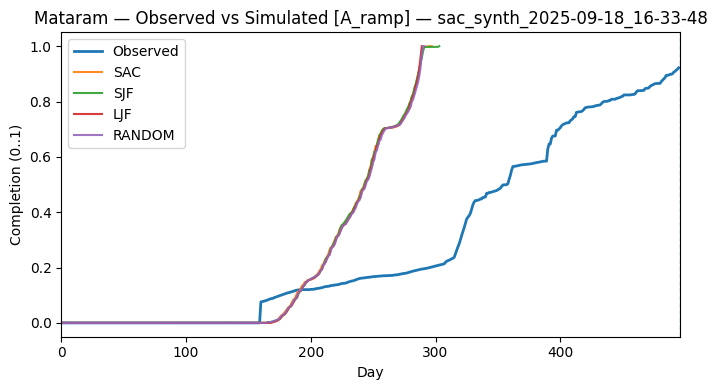

Saved fig: results/multiseed/sac_synth_2025-09-18_16-33-48/figs/Mataram_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


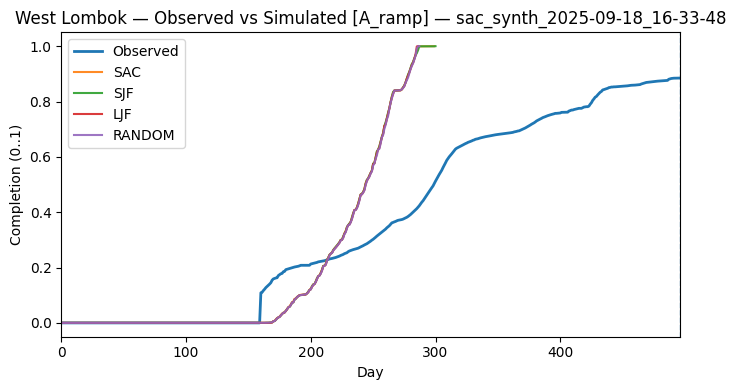

Saved fig: results/multiseed/sac_synth_2025-09-18_16-33-48/figs/West Lombok_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


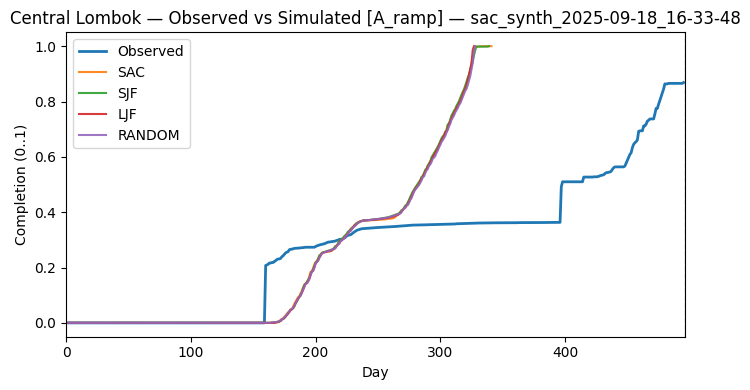

Saved fig: results/multiseed/sac_synth_2025-09-18_16-33-48/figs/Central Lombok_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


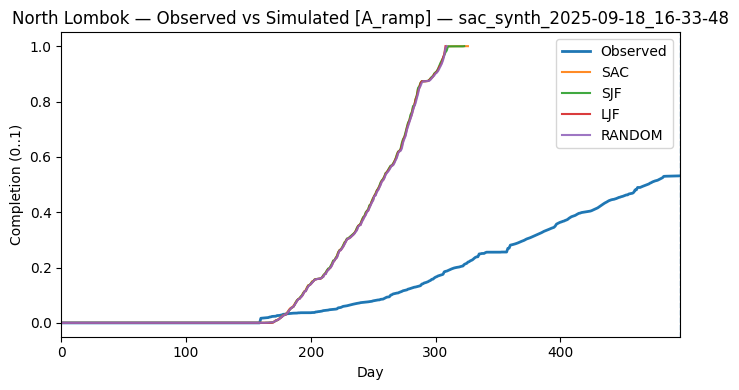

Saved fig: results/multiseed/sac_synth_2025-09-18_16-33-48/figs/North Lombok_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


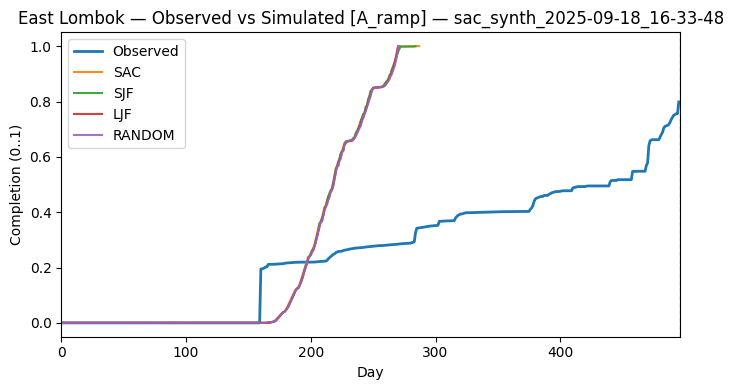

Saved fig: results/multiseed/sac_synth_2025-09-18_16-33-48/figs/East Lombok_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


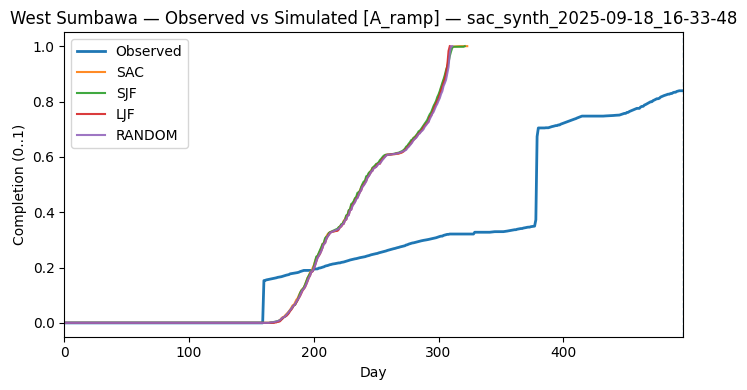

Saved fig: results/multiseed/sac_synth_2025-09-18_16-33-48/figs/West Sumbawa_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


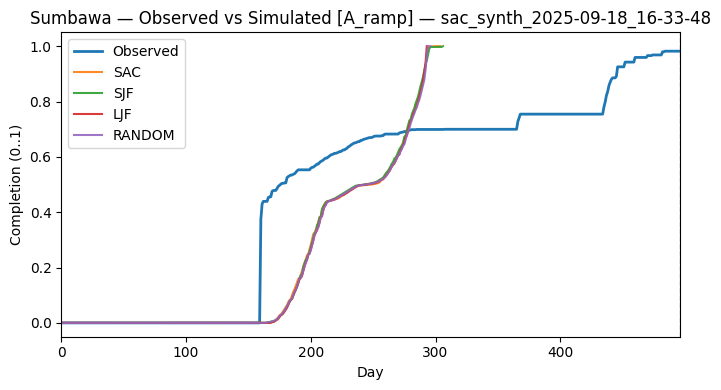

Saved fig: results/multiseed/sac_synth_2025-09-18_16-33-48/figs/Sumbawa_A_ramp.png

=== Evaluating run: sac_synth_2025-09-18_18-20-40 (seed=None) ===


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


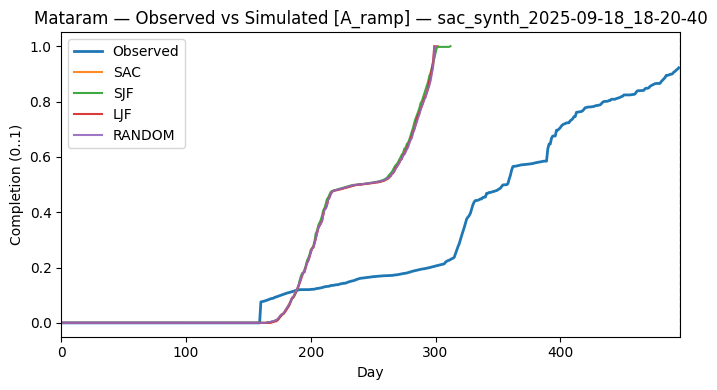

Saved fig: results/multiseed/sac_synth_2025-09-18_18-20-40/figs/Mataram_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


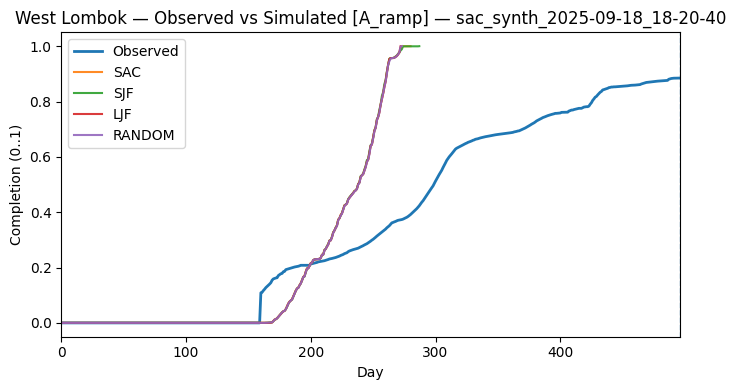

Saved fig: results/multiseed/sac_synth_2025-09-18_18-20-40/figs/West Lombok_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


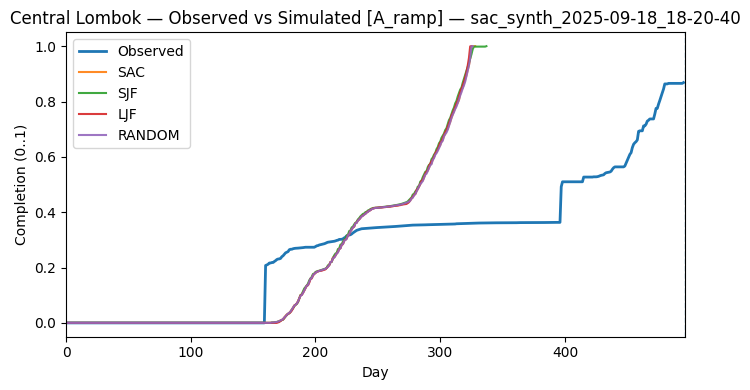

Saved fig: results/multiseed/sac_synth_2025-09-18_18-20-40/figs/Central Lombok_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


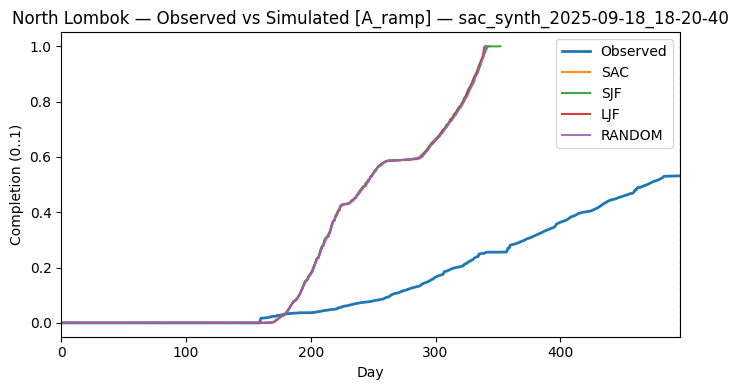

Saved fig: results/multiseed/sac_synth_2025-09-18_18-20-40/figs/North Lombok_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


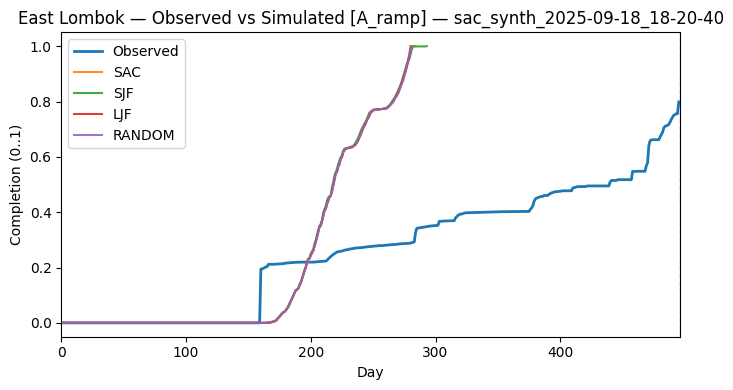

Saved fig: results/multiseed/sac_synth_2025-09-18_18-20-40/figs/East Lombok_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


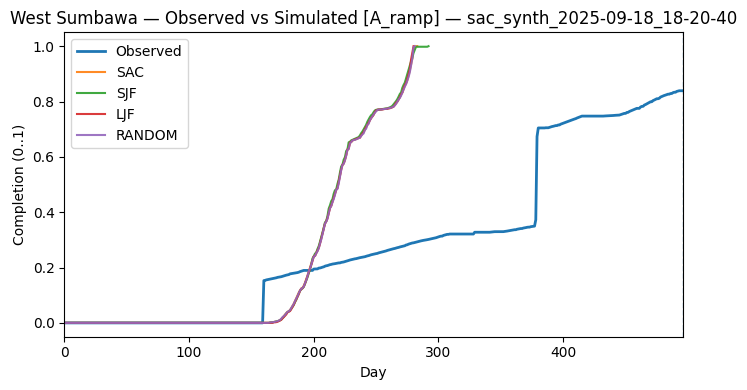

Saved fig: results/multiseed/sac_synth_2025-09-18_18-20-40/figs/West Sumbawa_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


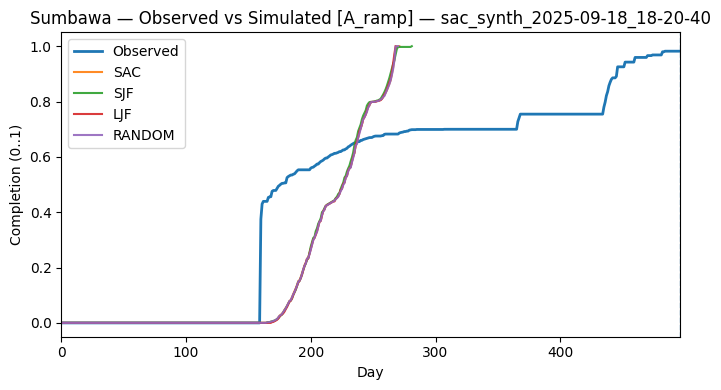

Saved fig: results/multiseed/sac_synth_2025-09-18_18-20-40/figs/Sumbawa_A_ramp.png

=== Evaluating run: sac_synth_seed42_2025-09-18_19-57-46 (seed=42) ===


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


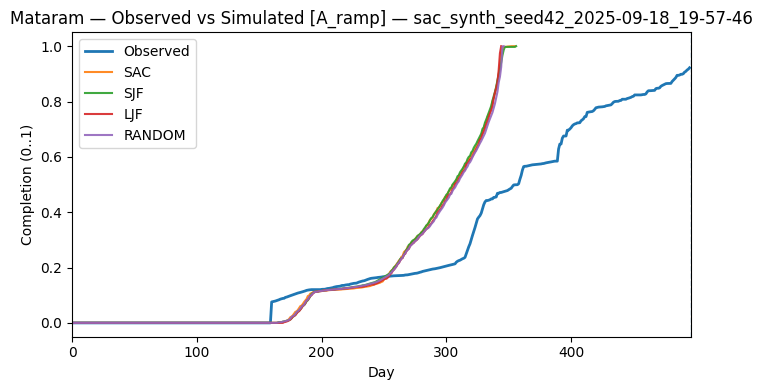

Saved fig: results/multiseed/sac_synth_seed42_2025-09-18_19-57-46/figs/Mataram_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


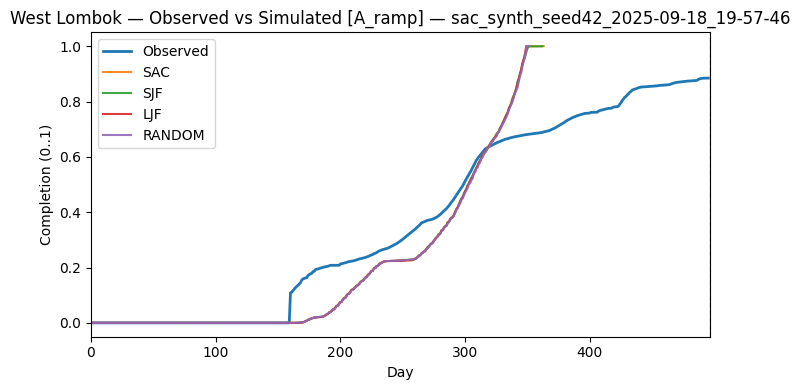

Saved fig: results/multiseed/sac_synth_seed42_2025-09-18_19-57-46/figs/West Lombok_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


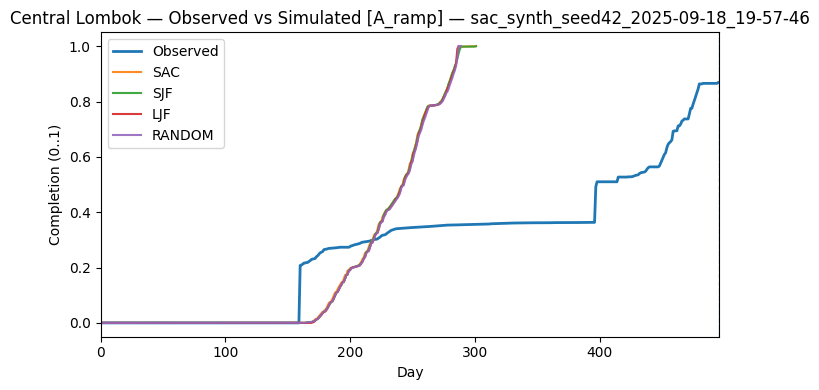

Saved fig: results/multiseed/sac_synth_seed42_2025-09-18_19-57-46/figs/Central Lombok_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


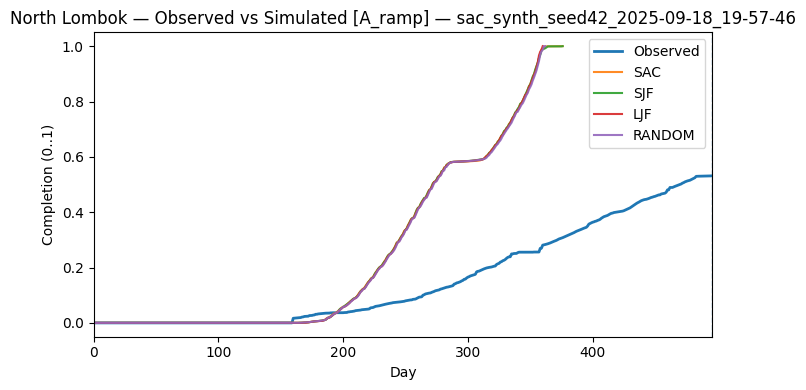

Saved fig: results/multiseed/sac_synth_seed42_2025-09-18_19-57-46/figs/North Lombok_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


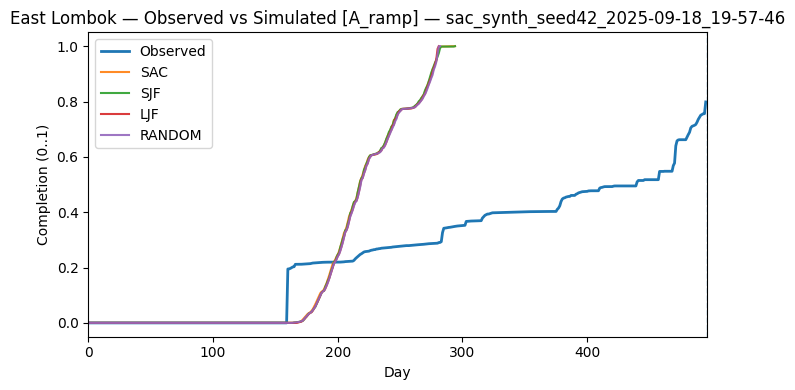

Saved fig: results/multiseed/sac_synth_seed42_2025-09-18_19-57-46/figs/East Lombok_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


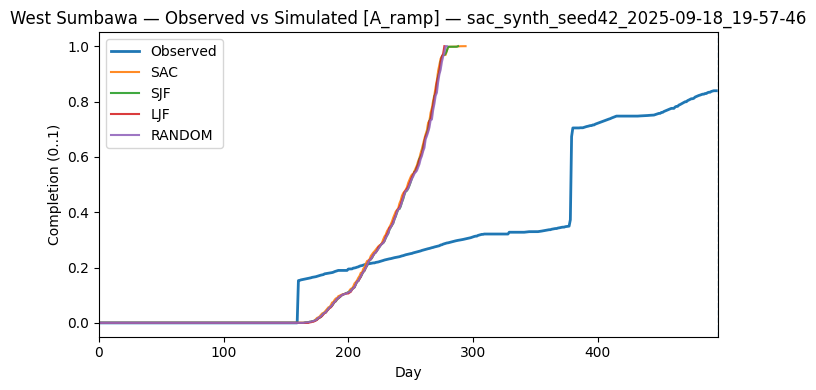

Saved fig: results/multiseed/sac_synth_seed42_2025-09-18_19-57-46/figs/West Sumbawa_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


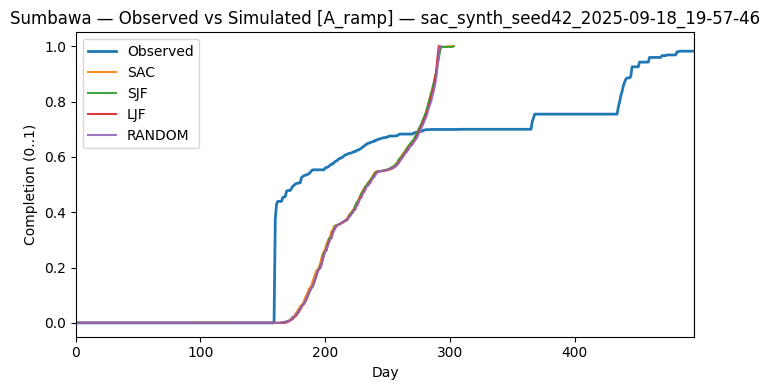

Saved fig: results/multiseed/sac_synth_seed42_2025-09-18_19-57-46/figs/Sumbawa_A_ramp.png

=== Evaluating run: sac_synth_seed43_2025-09-18_20-31-24 (seed=43) ===


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


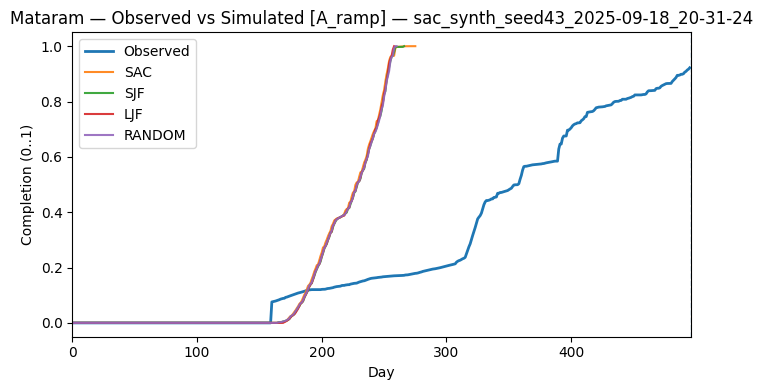

Saved fig: results/multiseed/sac_synth_seed43_2025-09-18_20-31-24/figs/Mataram_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


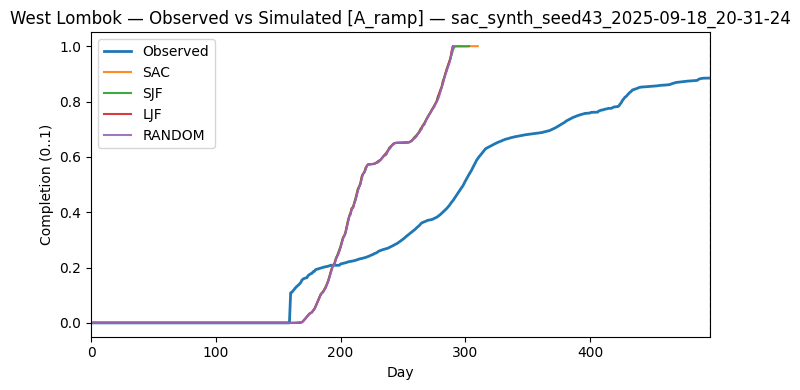

Saved fig: results/multiseed/sac_synth_seed43_2025-09-18_20-31-24/figs/West Lombok_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


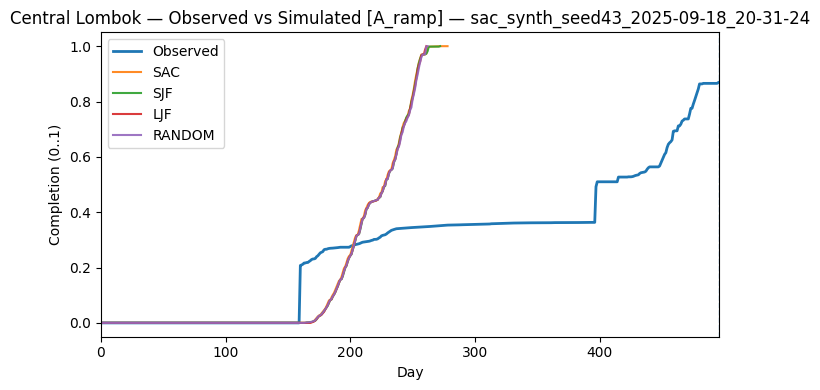

Saved fig: results/multiseed/sac_synth_seed43_2025-09-18_20-31-24/figs/Central Lombok_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


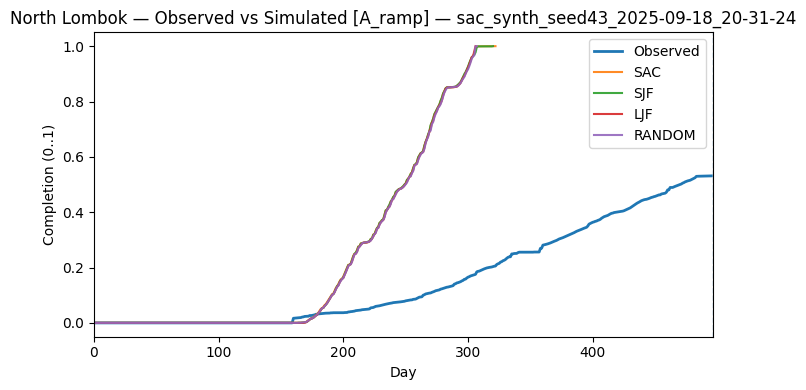

Saved fig: results/multiseed/sac_synth_seed43_2025-09-18_20-31-24/figs/North Lombok_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


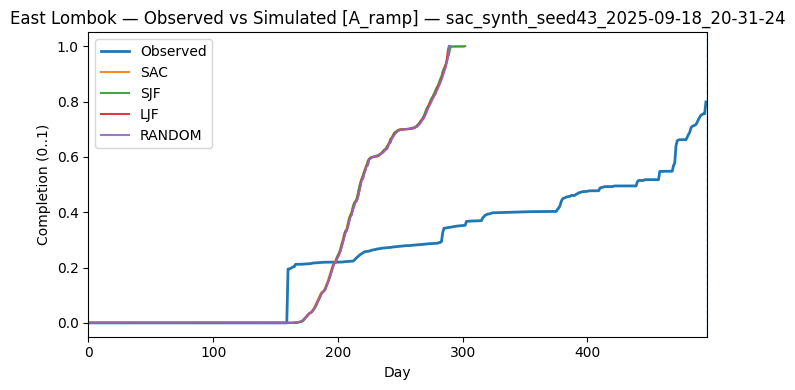

Saved fig: results/multiseed/sac_synth_seed43_2025-09-18_20-31-24/figs/East Lombok_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


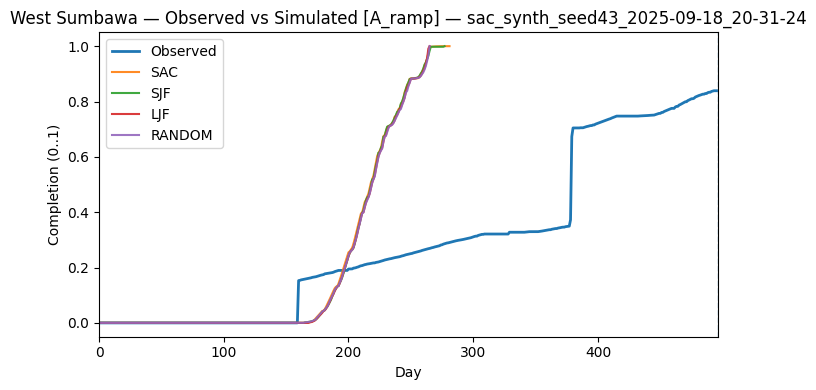

Saved fig: results/multiseed/sac_synth_seed43_2025-09-18_20-31-24/figs/West Sumbawa_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


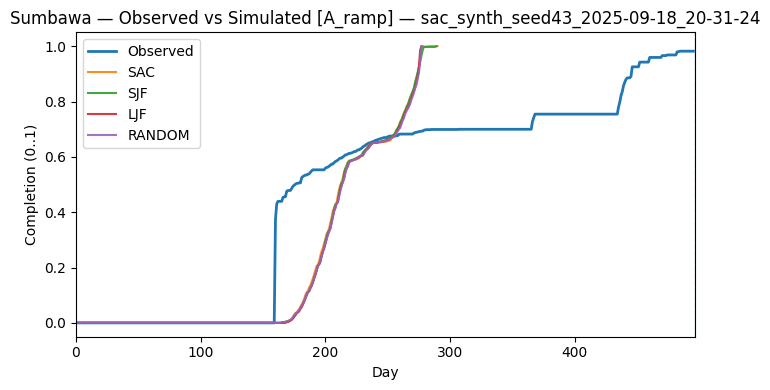

Saved fig: results/multiseed/sac_synth_seed43_2025-09-18_20-31-24/figs/Sumbawa_A_ramp.png

=== Evaluating run: sac_synth_seed44_2025-09-18_21-01-07 (seed=44) ===


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


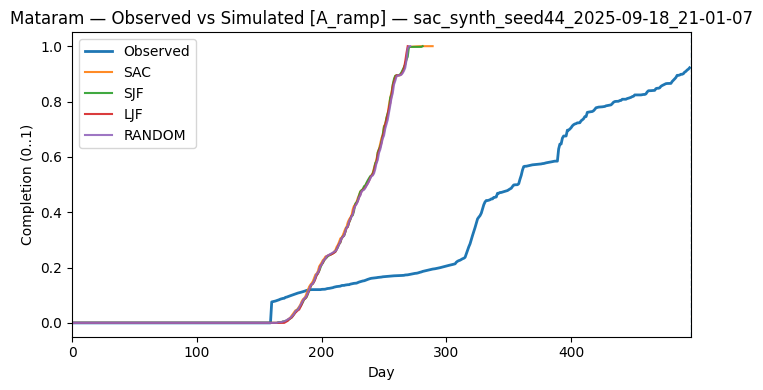

Saved fig: results/multiseed/sac_synth_seed44_2025-09-18_21-01-07/figs/Mataram_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


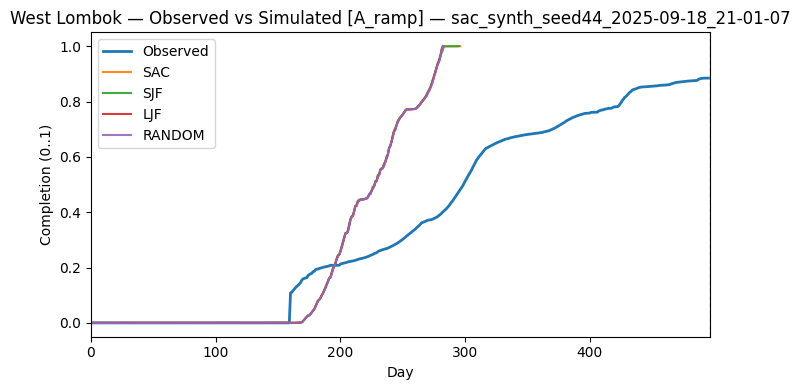

Saved fig: results/multiseed/sac_synth_seed44_2025-09-18_21-01-07/figs/West Lombok_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


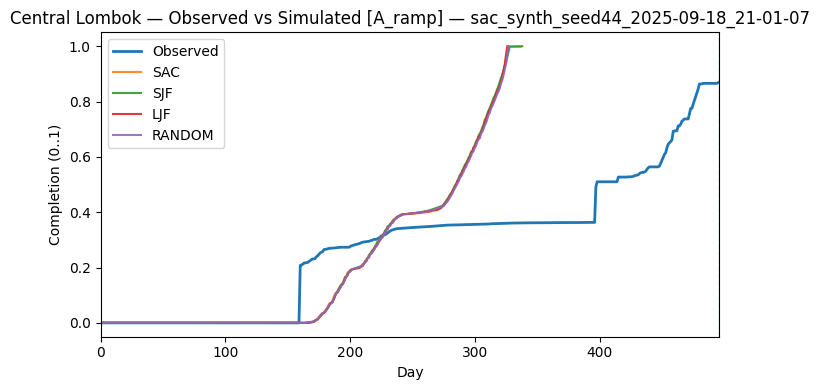

Saved fig: results/multiseed/sac_synth_seed44_2025-09-18_21-01-07/figs/Central Lombok_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


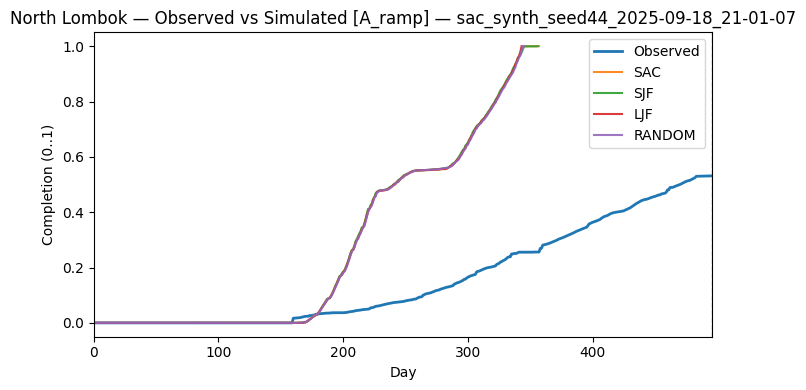

Saved fig: results/multiseed/sac_synth_seed44_2025-09-18_21-01-07/figs/North Lombok_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


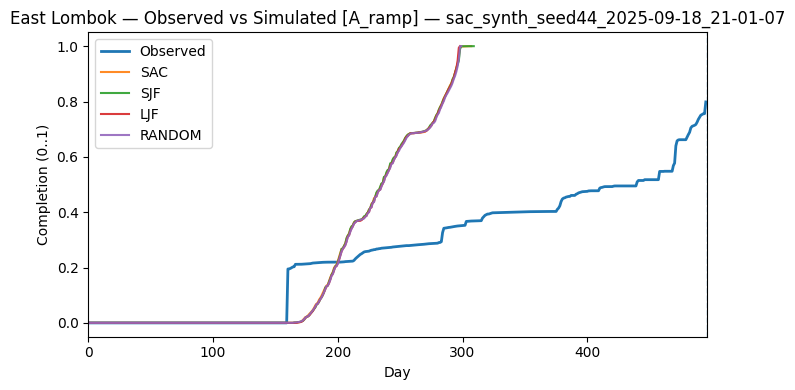

Saved fig: results/multiseed/sac_synth_seed44_2025-09-18_21-01-07/figs/East Lombok_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


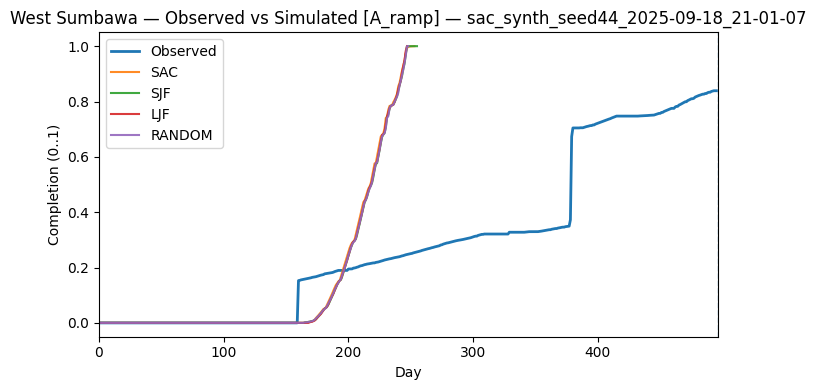

Saved fig: results/multiseed/sac_synth_seed44_2025-09-18_21-01-07/figs/West Sumbawa_A_ramp.png


/var/folders/y9/ph8f511545q4bhydbm6384q40000gn/T/ipykernel_24360/563266779.py:48: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))


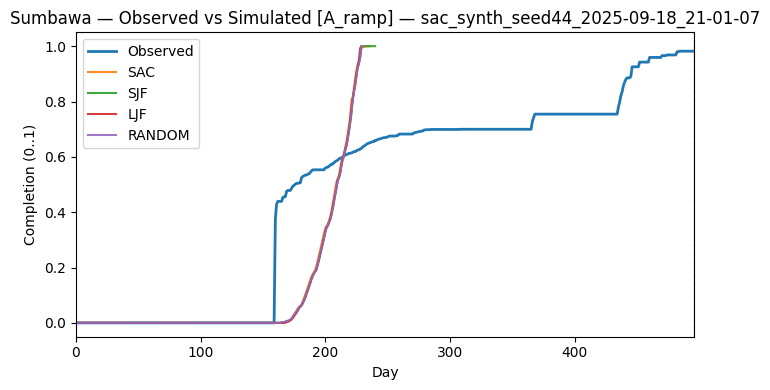

Saved fig: results/multiseed/sac_synth_seed44_2025-09-18_21-01-07/figs/Sumbawa_A_ramp.png

[Eval] Wrote metrics to results/multiseed/metrics_eval_ramp_multiseed.csv

=== RMSE summary for run: sac_synth_2025-09-18_16-33-48 ===


strategy           LJF  RANDOM     SAC     SJF
region                                        
Mataram         0.3380  0.3367  0.3388  0.3388
West Lombok     0.2305  0.2301  0.2306  0.2306
Central Lombok  0.3196  0.3184  0.3197  0.3198
North Lombok    0.4540  0.4534  0.4545  0.4546
East Lombok     0.4086  0.4082  0.4090  0.4092
West Sumbawa    0.3191  0.3180  0.3197  0.3202
Sumbawa         0.2053  0.2045  0.2037  0.2039


=== RMSE summary for run: sac_synth_2025-09-18_18-20-40 ===


strategy           LJF  RANDOM     SAC     SJF
region                                        
Mataram         0.3220  0.3213  0.3215  0.3236
West Lombok     0.2512  0.2509  0.2511  0.2513
Central Lombok  0.3224  0.3213  0.3215  0.3225
North Lombok    0.4254  0.4246  0.4251  0.4261
East Lombok     0.3977  0.3973  0.3975  0.3982
West Sumbawa    0.3704  0.3698  0.3702  0.3713
Sumbawa         0.2137  0.2131  0.2130  0.2132


=== RMSE summary for run: sac_synth_seed42_2025-09-18_19-57-46 ===


strategy           LJF  RANDOM     SAC     SJF
region                                        
Mataram         0.1984  0.1956  0.1997  0.2000
West Lombok     0.1361  0.1358  0.1359  0.1358
Central Lombok  0.3727  0.3720  0.3728  0.3729
North Lombok    0.3784  0.3772  0.3787  0.3788
East Lombok     0.3966  0.3962  0.3971  0.3973
West Sumbawa    0.3508  0.3494  0.3512  0.3502
Sumbawa         0.2073  0.2066  0.2050  0.2063


=== RMSE summary for run: sac_synth_seed43_2025-09-18_20-31-24 ===


strategy           LJF  RANDOM     SAC     SJF
region                                        
Mataram         0.3862  0.3855  0.3873  0.3855
West Lombok     0.2365  0.2363  0.2368  0.2369
Central Lombok  0.3967  0.3963  0.3970  0.3966
North Lombok    0.4647  0.4643  0.4652  0.4653
East Lombok     0.3864  0.3860  0.3868  0.3870
West Sumbawa    0.3879  0.3875  0.3889  0.3886
Sumbawa         0.2049  0.2043  0.2034  0.2044


=== RMSE summary for run: sac_synth_seed44_2025-09-18_21-01-07 ===


strategy           LJF  RANDOM     SAC     SJF
region                                        
Mataram         0.3703  0.3693  0.3709  0.3705
West Lombok     0.2488  0.2486  0.2490  0.2491
Central Lombok  0.3202  0.3191  0.3201  0.3204
North Lombok    0.4227  0.4221  0.4230  0.4235
East Lombok     0.3709  0.3703  0.3711  0.3712
West Sumbawa    0.3991  0.3987  0.3997  0.3987
Sumbawa         0.2282  0.2277  0.2272  0.2280


=== SAC RMSE: mean ± std across runs ===


rmse_mean  rmse_std
region                             
Mataram            0.3236    0.0739
West Lombok        0.2207    0.0482
Central Lombok     0.3462    0.0363
North Lombok       0.4293    0.0337
East Lombok        0.3923    0.0142
West Sumbawa       0.3659    0.0318
Sumbawa            0.2104    0.0102

In [ ]:

import re, numpy as np, pandas as pd, matplotlib.pyplot as plt, torch
from pathlib import Path
from importlib import reload

import evaluate, baseline, housegymrl
reload(evaluate); reload(baseline); reload(housegymrl)

from stable_baselines3 import SAC


BEST_ONLY_FROM_SEEDS = None  


def _latest(paths):
    paths = [p for p in paths if p.exists()]
    return max(paths, key=lambda p: p.stat().st_mtime) if paths else None

def _run_tag_from_model_path(p: Path) -> str:
    try:
        return p.parent.parent.name
    except Exception:
        return p.stem

def _parse_seed_from_tag(tag: str):
    m = re.search(r"seed(\d+)", tag)
    return int(m.group(1)) if m else None

def infer_M_from_model(model_obj) -> int:
    obs_dim = int(model_obj.observation_space.shape[0])
    M = (obs_dim - housegymrl.OBS_G) // housegymrl.OBS_F
    assert housegymrl.OBS_G + M * housegymrl.OBS_F == obs_dim
    return int(M)

def pad_to_length(arr: np.ndarray, L: int) -> np.ndarray:
    n = len(arr)
    return arr[:L] if n>=L else np.concatenate([arr, np.full(L-n, arr[-1] if n>0 else 0.0)])

def rmse(sim: np.ndarray, obs: np.ndarray) -> float:
    D = min(len(sim), len(obs))
    return float(np.sqrt(np.mean((sim[:D]-obs[:D])**2))) if D>0 else float("nan")

def auc_at_T(curve: np.ndarray, T: int) -> float:
    D = min(len(curve), T)
    return 0.0 if D <= 1 else float(np.trapz(curve[:D], np.arange(D)) / max(1.0, float(T)))

def t_reach_idx(curve: np.ndarray, thr: float):
    idx = np.where(curve >= thr)[0]
    return int(idx[0]) if idx.size>0 else None

def t_or_nan(x):
    return float(x) if x is not None else float("nan")

def rollout_free(env, policy: str, model=None, horizon=None) -> np.ndarray:
    obs, _ = env.reset(); ys=[]
    H = env.max_steps if horizon is None else int(horizon)
    for _ in range(H):
        if model is not None and policy=="SAC":
            act, _ = model.predict(obs, deterministic=True)
        else:
            act = baseline.make_baseline_scores(env, policy=policy)
        obs, r, done, trunc, info = env.step(act)
        ys.append(float(info.get("completion", 0.0)))
        if done or trunc: break
    return np.array(ys, dtype=float)

def make_env_region(reg, M_override: int, K_use: int, *,
                    k_ramp=None, max_steps=12_000,
                    fill_non_candidates=True):
    cfg = evaluate.REGION_CONFIG[reg]
    H = int(sum(cfg["damage_dist"]))
    tasks_df, resources, _ = evaluate.generate_synthetic_scenario(reg, H, K_use, cfg.get("seed", None))
    env = housegymrl.HousegymRLENV(
        tasks_df=tasks_df, resources=resources, M=M_override,
        max_steps=max_steps, seed=cfg.get("seed", None),
        print_every=0, tb_every=0,
        fill_non_candidates=fill_non_candidates,
        k_ramp=k_ramp
    )
    return env


all_best = sorted(Path("runs").glob("**/best/best_model.zip"), key=lambda p: p.stat().st_mtime)
# optional: filter only by seeds
if BEST_ONLY_FROM_SEEDS is not None:
    selected = []
    for p in all_best:
        tag = _run_tag_from_model_path(p)
        sd = _parse_seed_from_tag(tag)
        if sd in set(BEST_ONLY_FROM_SEEDS):
            selected.append(p)
    all_best = selected

assert all_best, "No BEST models found under runs/**/best/best_model.zip"

print("Found BEST models:")
for p in all_best:
    print(" -", p)


device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
REGIONS = ["Mataram","West Lombok","Central Lombok","North Lombok","East Lombok","West Sumbawa","Sumbawa"]
observed = evaluate.load_observed(evaluate.DATA_PATH)
region_ramp, warmup_map = evaluate.build_region_ramps(
    observed, rise_days=120, cap=1.0, frac_threshold=0.01, sustain_days=7
)


RESULTS_ROOT = Path("results") / "multiseed"
RESULTS_ROOT.mkdir(parents=True, exist_ok=True)

all_rows = []

for best_model in all_best:
    run_tag = _run_tag_from_model_path(best_model)
    seed_val = _parse_seed_from_tag(run_tag)
    print(f"\n=== Evaluating run: {run_tag} (seed={seed_val}) ===")

    out_dir = RESULTS_ROOT / run_tag
    (out_dir / "figs").mkdir(parents=True, exist_ok=True)
    (out_dir / "curves").mkdir(parents=True, exist_ok=True)

    # load BEST model
    model = SAC.load(str(best_model), device=device)
    M_eval = infer_M_from_model(model)

    for reg in REGIONS:
        if reg not in observed:
            print(f"[Skip] No observed for {reg}")
            continue

        cfg = evaluate.REGION_CONFIG[reg]
        H   = int(sum(cfg["damage_dist"]))
        K0  = int(cfg["num_contractors"])
        obs_curve = observed[reg].to_numpy()
        D_obs = len(obs_curve)

       
        env = make_env_region(
            reg, M_eval, K0,
            k_ramp=region_ramp.get(reg, None),
            max_steps=12_000,
            fill_non_candidates=True
        )

        tag = "A_ramp"
        plt.figure(figsize=(7,4))
        plt.plot(np.arange(D_obs), obs_curve, label="Observed", linewidth=2)
        max_len = D_obs

        for pol in ["SAC", "SJF", "LJF", "RANDOM"]:
            sim = rollout_free(env, pol, model=model if pol=="SAC" else None, horizon=None)

            # save natural-length curve per run
            pd.DataFrame({"day": np.arange(len(sim)), "completion": sim}).to_csv(
                out_dir / "curves" / f"{reg}_{tag}_{pol}.csv", index=False
            )

            # metrics on equal length
            sim_eq = pad_to_length(sim, D_obs)
            all_rows.append({
                "run_tag": run_tag, "seed": seed_val,
                "test": tag, "region": reg, "strategy": pol,
                "rmse": rmse(sim_eq, obs_curve),
                "auc@200": auc_at_T(sim_eq, 200),
                "auc@300": auc_at_T(sim_eq, 300),
                "t80": t_or_nan(t_reach_idx(sim, 0.80)),
                "t90": t_or_nan(t_reach_idx(sim, 0.90)),
                "t95": t_or_nan(t_reach_idx(sim, 0.95)),
                "final_completion": float(sim[-1]) if len(sim)>0 else 0.0,
                "makespan": t_or_nan(t_reach_idx(sim, 0.99)),
                "H": H, "K_raw": K0, "K_used": env.K,
                "warmup": warmup_map.get(reg, np.nan),
                "fill_non_candidates": getattr(env, "fill_non_candidates", True)
            })

            plt.plot(np.arange(len(sim)), sim, label=pol, alpha=0.9)
            max_len = max(max_len, len(sim))
            if len(sim) >= env.max_steps-1 and (len(sim)==0 or sim[-1] < 0.999):
                plt.text(len(sim), sim[-1], " ⟂ truncated", fontsize=8, va="bottom")

        plt.axvline(x=D_obs, linestyle="--", linewidth=1, alpha=0.6)
        plt.xlim(0, max_len)
        title = f"{reg} — Observed vs Simulated [{tag}] — {run_tag}"
        plt.title(title); plt.xlabel("Day"); plt.ylabel("Completion (0..1)")
        plt.legend(); plt.tight_layout()
        outp = out_dir / "figs" / f"{reg}_{tag}.png"
        plt.savefig(outp); plt.show()
        print("Saved fig:", outp)

# ---------- metrics & a summaries ----------
metrics_path = RESULTS_ROOT / "metrics_eval_ramp_multiseed.csv"
pd.DataFrame(all_rows).to_csv(metrics_path, index=False)
print("\n[Eval] Wrote metrics to", metrics_path)

dfm = pd.DataFrame(all_rows)

#RMSE pivot by run
for run_tag in sorted(dfm["run_tag"].unique()):
    print(f"\n=== RMSE summary for run: {run_tag} ===")
    pivot = dfm[dfm["run_tag"]==run_tag].pivot_table(index="region", columns="strategy", values="rmse", aggfunc="mean")
    # 固定地区顺序
    order = ["Mataram","West Lombok","Central Lombok","North Lombok","East Lombok","West Sumbawa","Sumbawa"]
    pivot = pivot.reindex(order)
    display(pivot.round(4))


if "SAC" in dfm["strategy"].unique():
    sac_df = dfm[dfm["strategy"]=="SAC"]
    print("\n=== SAC RMSE: mean ± std across runs ===")
    sac_mean = sac_df.pivot_table(index="region", values="rmse", aggfunc="mean").rename(columns={"rmse":"rmse_mean"})
    sac_std  = sac_df.pivot_table(index="region", values="rmse", aggfunc="std").rename(columns={"rmse":"rmse_std"})
    sac_sum  = sac_mean.join(sac_std)
    order = ["Mataram","West Lombok","Central Lombok","North Lombok","East Lombok","West Sumbawa","Sumbawa"]
    sac_sum = sac_sum.reindex(order)
    display(sac_sum.round(4))


Loaded BEST: runs/sac_synth_seed44_2025-09-18_21-01-07/best/best_model.zip


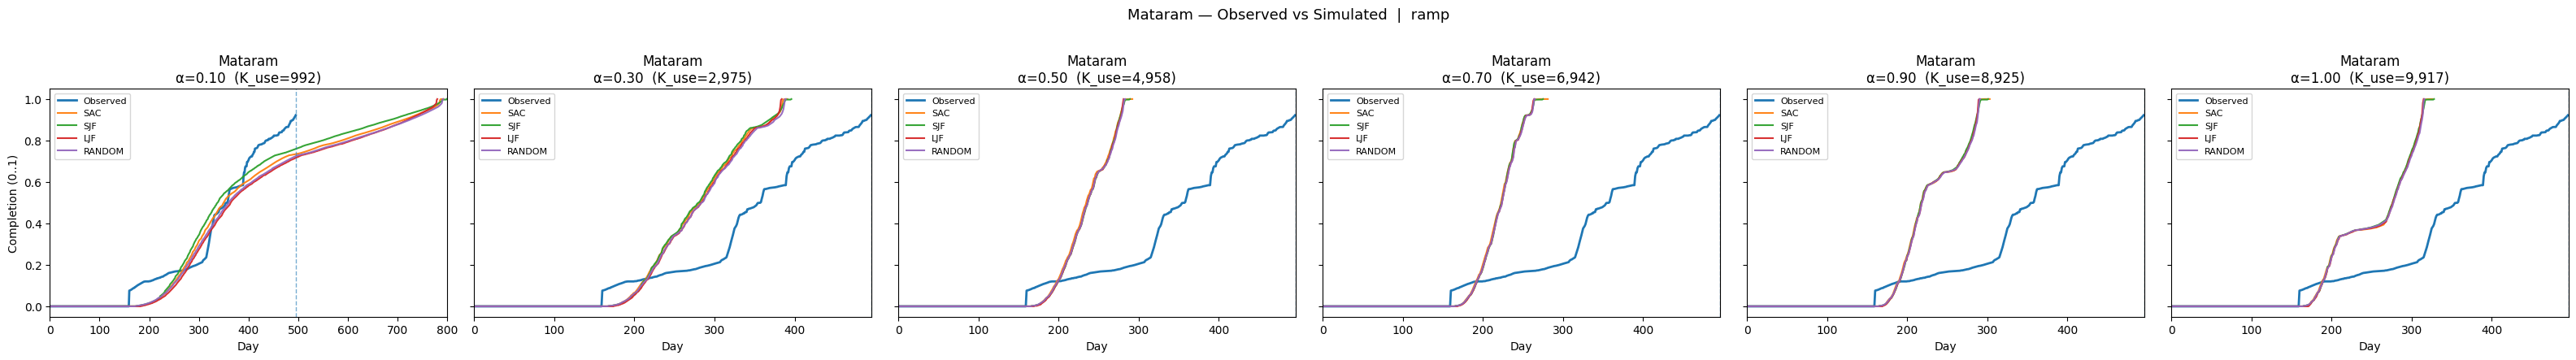

Saved fig: results/alpha_sweep/figs/Mataram_alpha_sweep_ramp.png


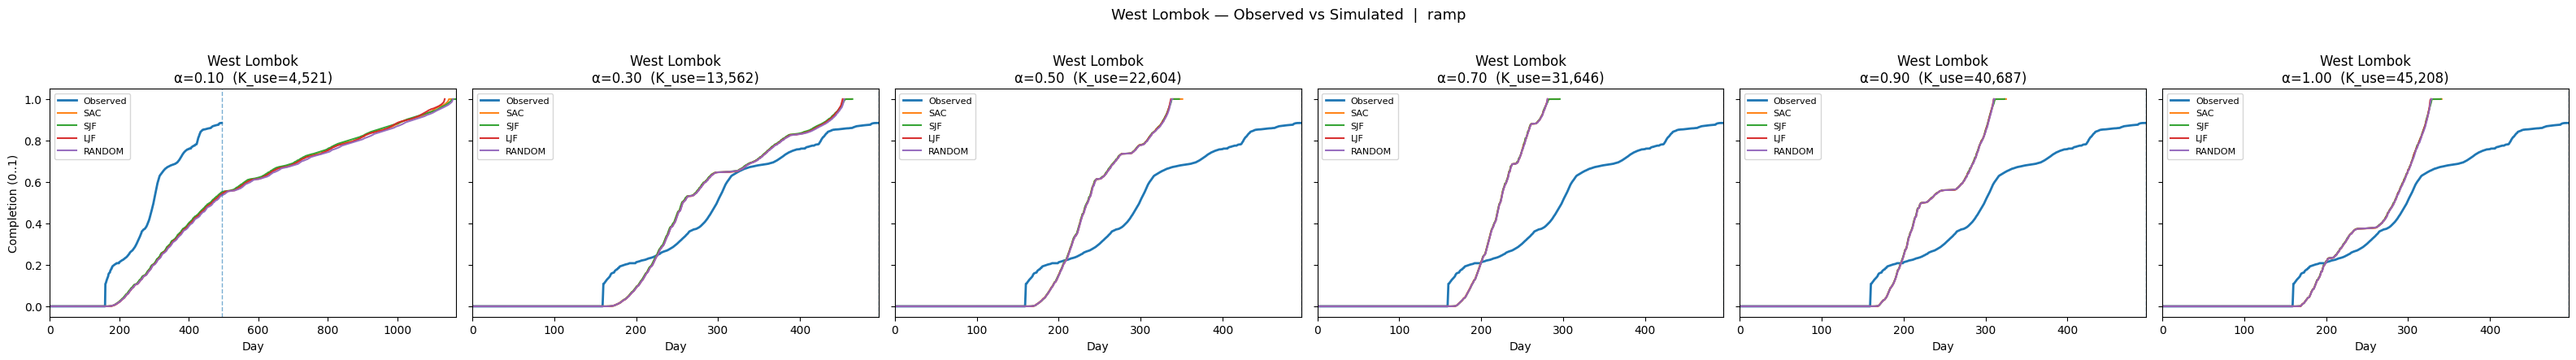

Saved fig: results/alpha_sweep/figs/West Lombok_alpha_sweep_ramp.png


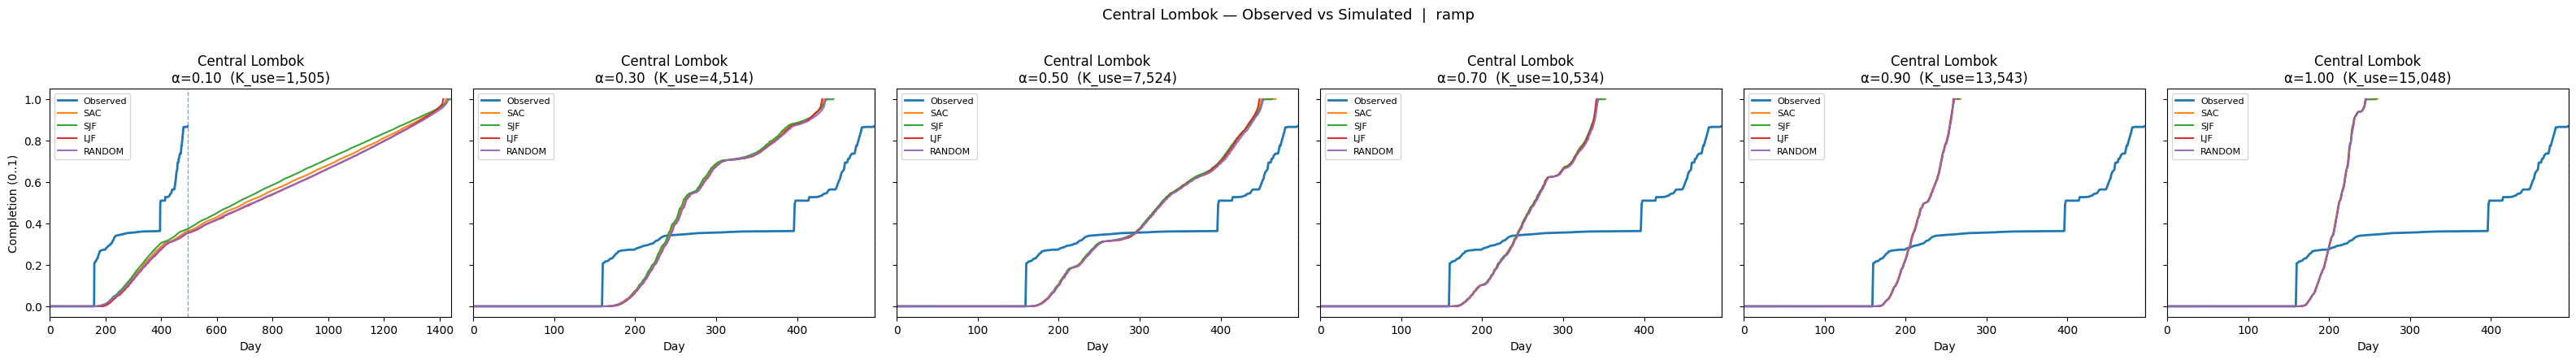

Saved fig: results/alpha_sweep/figs/Central Lombok_alpha_sweep_ramp.png


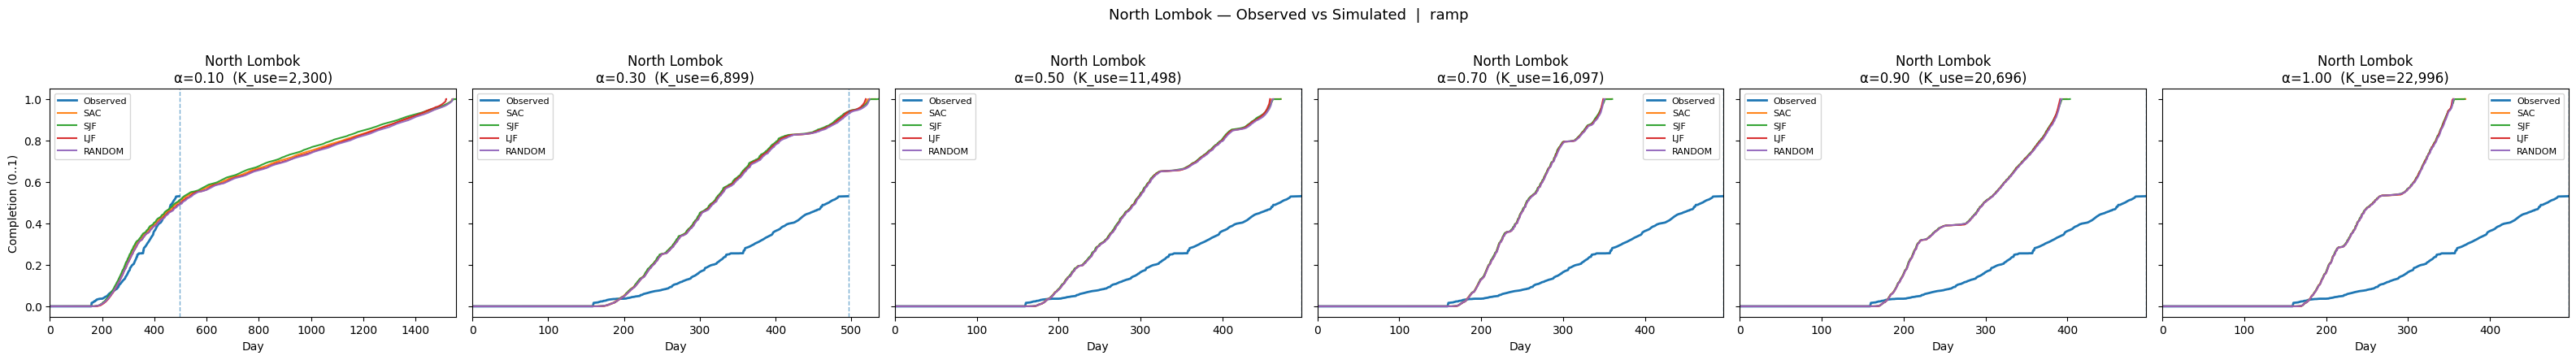

Saved fig: results/alpha_sweep/figs/North Lombok_alpha_sweep_ramp.png


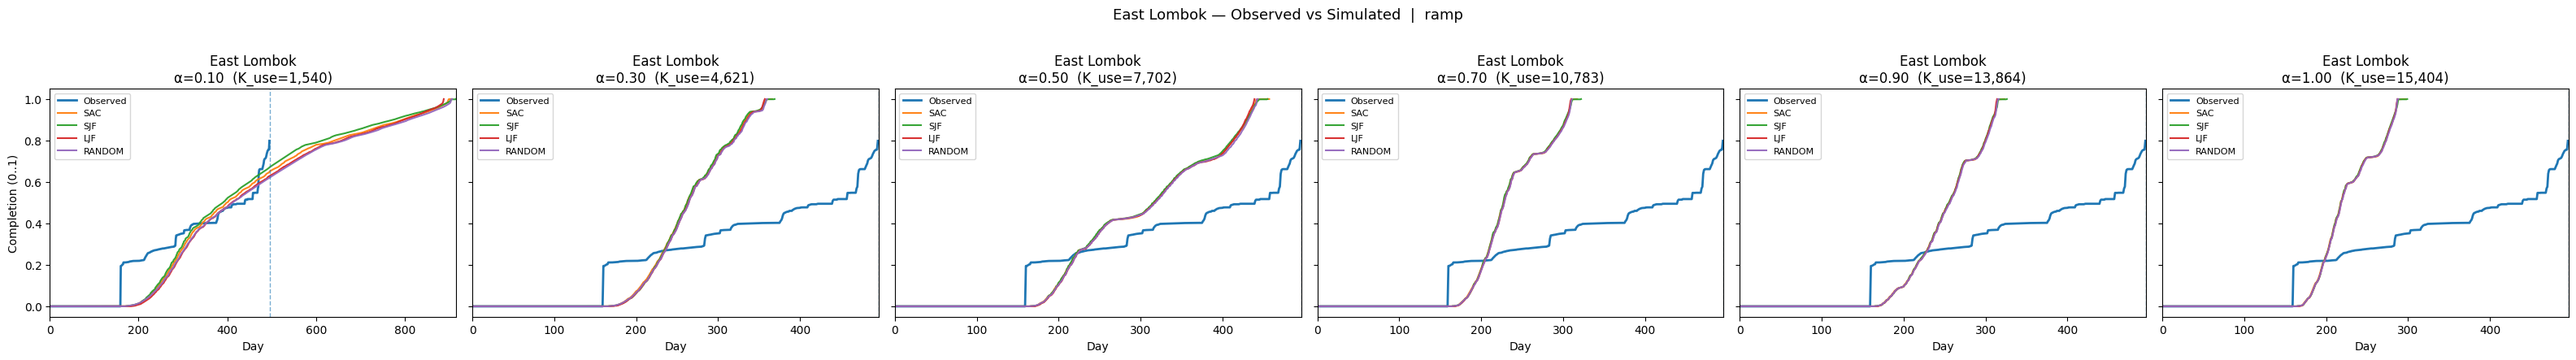

Saved fig: results/alpha_sweep/figs/East Lombok_alpha_sweep_ramp.png


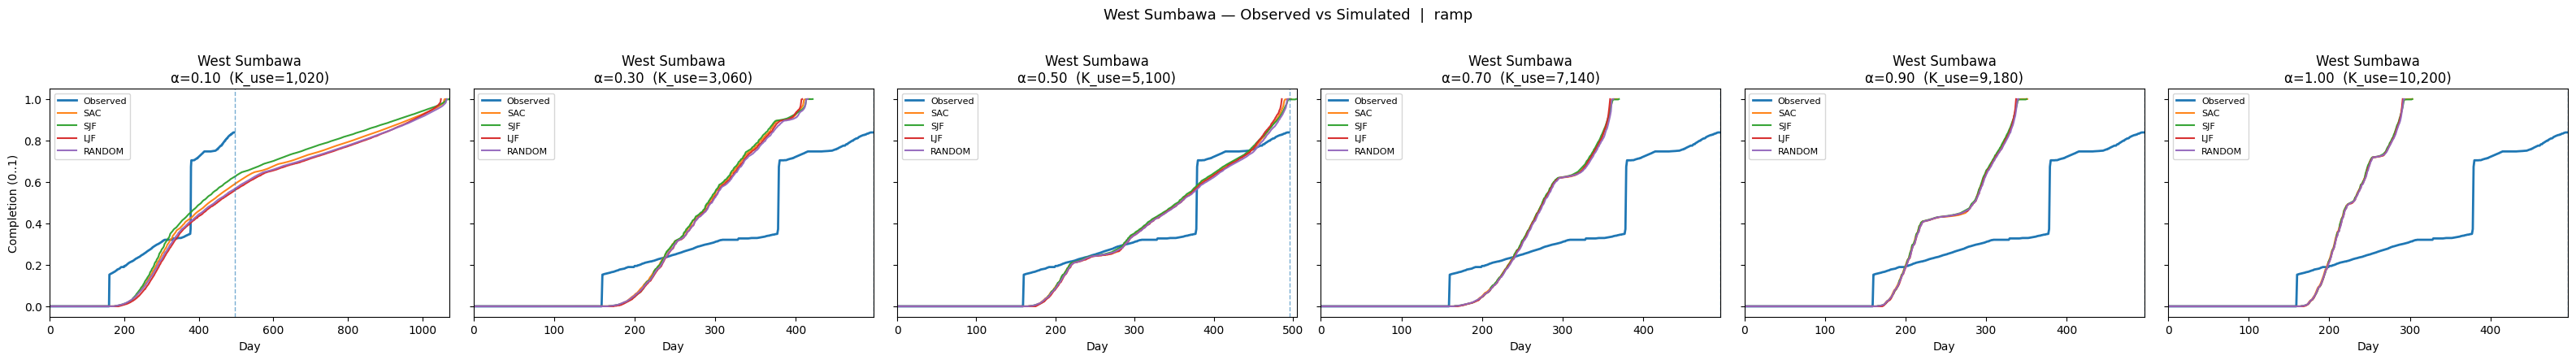

Saved fig: results/alpha_sweep/figs/West Sumbawa_alpha_sweep_ramp.png


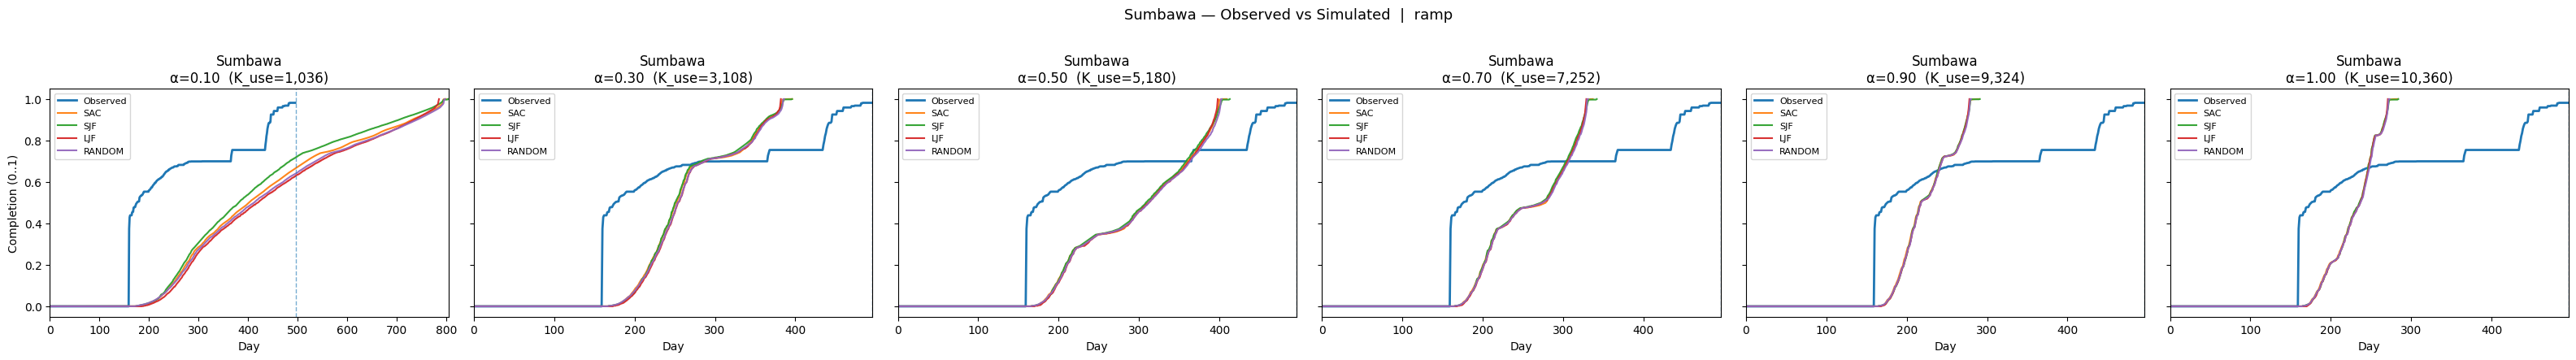

Saved fig: results/alpha_sweep/figs/Sumbawa_alpha_sweep_ramp.png

[AlphaSweep] Wrote metrics to results/alpha_sweep/metrics_alpha_sweep_ramp.csv


alpha              0.1     0.3     0.5     0.7     0.9     1.0
region                                                        
Mataram         0.0789  0.2142  0.3555  0.3926  0.3528  0.2808
West Lombok     0.2537  0.0918  0.1901  0.2580  0.1981  0.1526
Central Lombok  0.2143  0.2561  0.1695  0.3143  0.3959  0.4177
North Lombok    0.0342  0.2500  0.2980  0.4244  0.3470  0.3986
East Lombok     0.0986  0.3240  0.2065  0.3703  0.3493  0.3892
West Sumbawa    0.1488  0.2057  0.0807  0.2403  0.2742  0.3521
Sumbawa         0.3396  0.2075  0.2197  0.2063  0.2070  0.2210

In [ ]:
# ============================ Alpha Sweep (0.1 → 1.0, step 0.2) ============================
import numpy as np, pandas as pd, matplotlib.pyplot as plt, torch, re
from pathlib import Path
from importlib import reload


import evaluate, baseline, housegymrl
reload(evaluate); reload(baseline); reload(housegymrl)

from stable_baselines3 import SAC

# ---------- locate model ----------
def _latest(paths):
    paths = [p for p in paths if p.exists()]
    return max(paths, key=lambda p: p.stat().st_mtime) if paths else None

BEST_FROM = None  # lateste best model
model_path = Path(BEST_FROM) if BEST_FROM else _latest(list(Path("runs").glob("**/best/best_model.zip")))
assert model_path is not None and model_path.exists(), "No BEST model found under runs/**/best/best_model.zip"
print("Loaded BEST:", model_path)

device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
model = SAC.load(str(model_path), device=device)


REGIONS = ["Mataram","West Lombok","Central Lombok","North Lombok","East Lombok","West Sumbawa","Sumbawa"]
observed = evaluate.load_observed(evaluate.DATA_PATH)


region_ramp, warmup_map = evaluate.build_region_ramps(
    observed, rise_days=120, cap=1.0, frac_threshold=0.01, sustain_days=7
)

# ---------- α----------
ALPHAS    = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]  
USE_RAMP  = True                             # False: no ramp. the ideal max recovery speed. 
MAX_DAYS  = 12_000                          
POLICIES  = ["SAC","SJF","LJF","RANDOM"]


def infer_M_from_model(model_obj) -> int:
    obs_dim = int(model_obj.observation_space.shape[0])
    M = (obs_dim - housegymrl.OBS_G) // housegymrl.OBS_F
    assert housegymrl.OBS_G + M * housegymrl.OBS_F == obs_dim
    return int(M)

def pad_to_length(arr: np.ndarray, L: int) -> np.ndarray:
    n = len(arr)
    return arr[:L] if n>=L else np.concatenate([arr, np.full(L-n, arr[-1] if n>0 else 0.0)])

def rmse(sim: np.ndarray, obs: np.ndarray) -> float:
    D = min(len(sim), len(obs))
    return float(np.sqrt(np.mean((sim[:D]-obs[:D])**2))) if D>0 else float("nan")

def rollout_free(env, policy: str, model=None, horizon=None) -> np.ndarray:
    obs, _ = env.reset(); ys=[]
    H = env.max_steps if horizon is None else int(horizon)
    for _ in range(H):
        if model is not None and policy=="SAC":
            act, _ = model.predict(obs, deterministic=True)
        else:
            act = baseline.make_baseline_scores(env, policy=policy)
        obs, r, done, trunc, info = env.step(act)
        ys.append(float(info.get("completion", 0.0)))
        if done or trunc: break
    return np.array(ys, dtype=float)

def make_env_region(reg, M_override: int, K_use: int, *,
                    k_ramp=None, max_steps=12_000,
                    fill_non_candidates=True):
    cfg = evaluate.REGION_CONFIG[reg]
    H = int(sum(cfg["damage_dist"]))
    tasks_df, resources, _ = evaluate.generate_synthetic_scenario(reg, H, int(K_use), cfg.get("seed", None))
    env = housegymrl.HousegymRLENV(
        tasks_df=tasks_df, resources=resources, M=M_override,
        max_steps=max_steps, seed=cfg.get("seed", None),
        print_every=0, tb_every=0,
        fill_non_candidates=fill_non_candidates,
        k_ramp=k_ramp
    )
    return env

# ---------- visualization ----------
M_eval = infer_M_from_model(model)
OUT_DIR = Path("results") / "alpha_sweep"
(OUT_DIR / "figs").mkdir(parents=True, exist_ok=True)
(OUT_DIR / "curves").mkdir(parents=True, exist_ok=True)

all_rows = []

for reg in REGIONS:
    if reg not in observed:
        print(f"[Skip] No observed for {reg}"); 
        continue

    cfg = evaluate.REGION_CONFIG[reg]
    H   = int(sum(cfg["damage_dist"]))
    K0  = int(cfg["num_contractors"])
    obs_curve = observed[reg].to_numpy()
    D_obs = len(obs_curve)

    fig, axes = plt.subplots(1, len(ALPHAS), figsize=(5.3*len(ALPHAS), 4.3), sharey=True)
    if len(ALPHAS) == 1: axes = [axes]

    for j, alpha in enumerate(ALPHAS):
        # available contractors
        K_use = max(1, min(H, int(round(alpha * K0))))
        env = make_env_region(
            reg, M_eval, K_use,
            k_ramp=(region_ramp.get(reg, None) if USE_RAMP else None),
            max_steps=MAX_DAYS,
            fill_non_candidates=True
        )

        ax = axes[j]
        ax.plot(np.arange(D_obs), obs_curve, label="Observed", linewidth=2)
        max_len = D_obs

        for pol in POLICIES:
            sim = rollout_free(env, pol, model=model if pol=="SAC" else None, horizon=None)
            pd.DataFrame({"day": np.arange(len(sim)), "completion": sim}).to_csv(
                OUT_DIR / "curves" / f"{reg}_alpha{alpha:.2f}_{'ramp' if USE_RAMP else 'noramp'}_{pol}.csv",
                index=False
            )
            sim_eq = pad_to_length(sim, D_obs)
            all_rows.append({
                "region": reg, "alpha": alpha, "use_ramp": int(USE_RAMP),
                "strategy": pol,
                "rmse": rmse(sim_eq, obs_curve),
                "final": float(sim[-1]) if len(sim)>0 else 0.0,
                "t80": (np.where(sim >= 0.80)[0][0] if np.any(sim >= 0.80) else np.nan),
                "t90": (np.where(sim >= 0.90)[0][0] if np.any(sim >= 0.90) else np.nan),
                "makespan": (np.where(sim >= 0.99)[0][0] if np.any(sim >= 0.99) else np.nan),
                "H": H, "K0": K0, "K_use": K_use
            })

            ax.plot(np.arange(len(sim)), sim, label=pol, alpha=0.95)
            max_len = max(max_len, len(sim))
            if len(sim) >= env.max_steps-1 and (len(sim)==0 or sim[-1] < 0.999):
                ax.text(len(sim), sim[-1], " ⟂ truncated", fontsize=8, va="bottom")

        ax.axvline(x=D_obs, linestyle="--", linewidth=1, alpha=0.6)
        ax.set_title(f"{reg}\nα={alpha:.2f}  (K_use={K_use:,})")
        ax.set_xlabel("Day")
        if j==0: ax.set_ylabel("Completion (0..1)")
        ax.set_xlim(0, max_len)
        ax.legend(fontsize=8)

    plt.suptitle(f"{reg} — Observed vs Simulated  |  {'ramp' if USE_RAMP else 'no ramp'}", y=1.02, fontsize=13)
    plt.tight_layout()
    fig_path = OUT_DIR / "figs" / f"{reg}_alpha_sweep_{'ramp' if USE_RAMP else 'noramp'}.png"
    plt.savefig(fig_path, bbox_inches="tight"); plt.show()
    print("Saved fig:", fig_path)

# ---------- summary ----------
metrics_path = OUT_DIR / f"metrics_alpha_sweep_{'ramp' if USE_RAMP else 'noramp'}.csv"
pd.DataFrame(all_rows).to_csv(metrics_path, index=False)
print("\n[AlphaSweep] Wrote metrics to", metrics_path)


dfm = pd.DataFrame(all_rows)
sac = dfm[dfm["strategy"]=="SAC"].copy()
pivot = sac.pivot_table(index="region", columns="alpha", values="rmse", aggfunc="mean")
pivot = pivot.reindex(REGIONS) 
display(pivot.round(4))
